# Project 4 of UDACITY Self Driving Course Term1

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle
print('...')

...


# Section 1 - Find the undistortion matrix for the camera

### 1.1 Prepare objpoints

In [4]:
#Prepare object  points
nx = 9 #Number of  inside corners in any given row
ny = 6 #Number of inside corners in any given column

#Read in and make a list of calibration images
images = glob.glob("camera_cal/calibration*.jpg")

#Initialize image point and object point arrays
objpoints = []
imgpoints = []

# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates
print('...')

...


### 1.2 Find Chessboard Corners

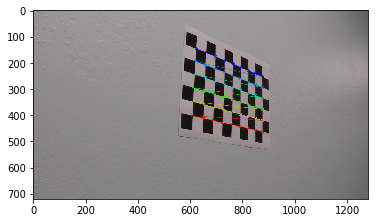

In [5]:
for fname in images:
    #Read in image
    img_x = cv2.imread(fname)
    
    #Convert to grayscale
    gray = cv2.cvtColor(img_x, cv2.COLOR_BGR2GRAY)
    
    #Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    
    #If found draw corners
    if ret == True:
        #Fill in image points and objpoint arrays
        imgpoints.append(corners)
        objpoints.append(objp)
        
         # Draw and display the corners
        cv2.drawChessboardCorners(img_x, (nx, ny), corners, ret)
        plt.imshow(img_x)


### 1.3 Find undistortion matrix and test undistortion on an image

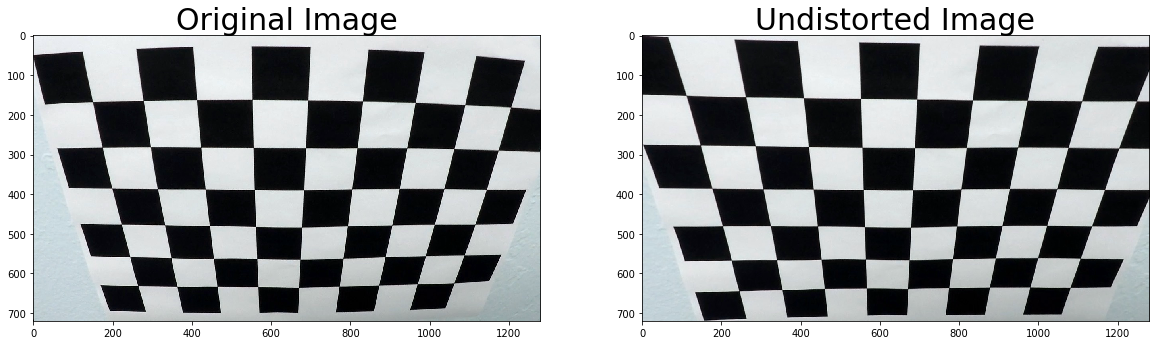

In [6]:
#Define the unidistortion function
def cal_undistort(img, objpoints, imgpoints):
    """Returns undistorted image."""
    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist 

img_test = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img_test.shape[1],img_test.shape[0])

#Find out undistortion matrix mtx for the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img_test,mtx,dist,None,mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

#Save the camera calibration result for later use

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["ret"] = ret
pickle.dump( dist_pickle, open( "camera_calibration_result.p", "wb" ) )

#Visualize undistortion
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('output_images/undistorted_image.jpg')

# Section 2 - Image Transformation

### 2.1 Apply the distortion correction to raw image

In [7]:
def undistort_image(img, mtx = mtx, dist = dist):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted


### 2.2 Apply gradient and other thresholds

In [8]:
def transformed_image(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    #Grayscale image conversion
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 40
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary),sxbinary, s_binary))*255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

### 2.3 Example showing a transfomed binary image

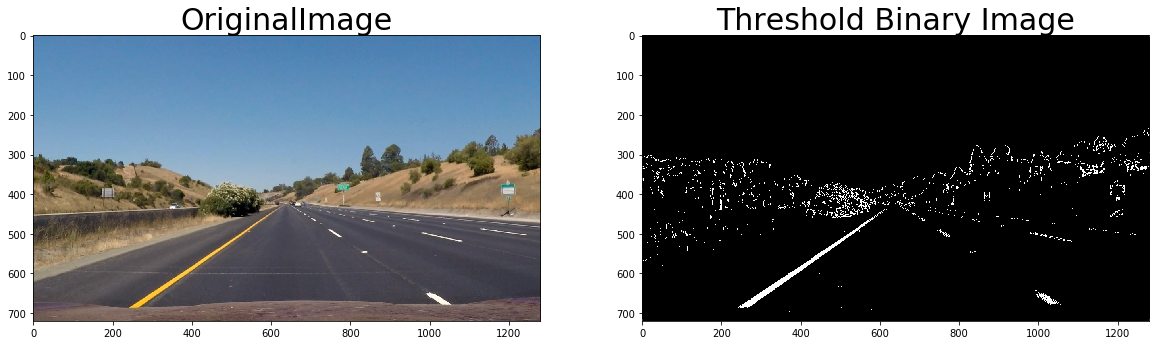

In [9]:
img_test = mpimg.imread('test_images/straight_lines1.jpg')
bin_test = transformed_image(img_test)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(img_test)
ax1.set_title('OriginalImage', fontsize=30)
ax2.imshow(bin_test, cmap = 'gray')
ax2.set_title('Threshold Binary Image', fontsize=30)
plt.savefig('output_images/binary.jpg')

 I used combined_binary, which is an bitwise or of sobelx after threshold filter and s_channel of HLS image

### 2.4 Apply perspective transform to get a Top view of the road

In [10]:
#Define the source polygon in the original image and destination polygon
#in the transformed image. These will be used to calculate the M and Minv matrices.
#These points are chosen so that I get two straight lines in the transformed image
#Then I will use these parameters for all images in the video stream

src = np.float32(
        [[100, 720],
         [590, 450],
         [700, 450],
         [1250, 720]])

dst = np.float32(
        [[300,720],
         [300,200],
         [1000,200],
         [1000,720]])
    
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)    

def perspective_transform(img, src = src , dst = dst):
    imshape = img.shape
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    return warped


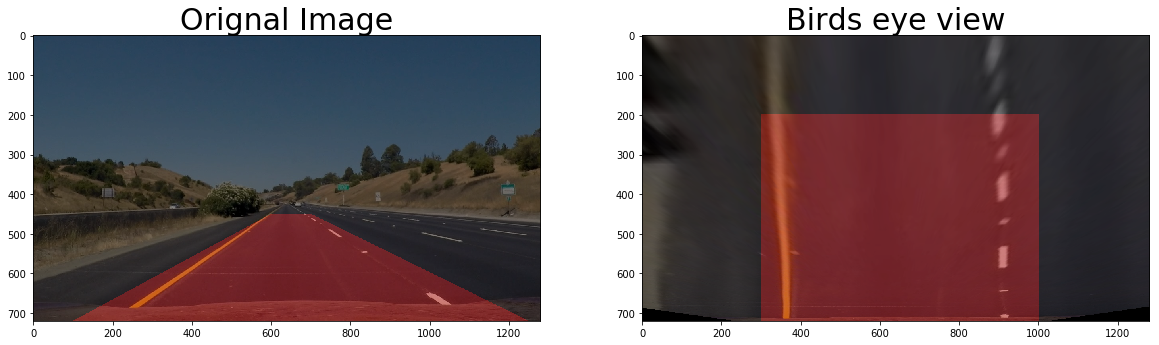

In [11]:
#Check to verify that I get the corerct transform
#It should give a birds eye view of the lanes
mask1 = np.zeros_like(img_test)
fill_color = (255,0,0)
#Polgon corners for source image
source = np.array([[100,720],[600,450],[700,450],[1250,720]], np.int32)
cv2.fillConvexPoly(mask1, source, fill_color)
source_corners = cv2.addWeighted(img_test,0.5,mask1,0.3,0)

#Polgon corners for destination image
mask2 = np.zeros_like(img_test)
destination = np.array([[300,720],[300,200],[1000,200],[1000,720]])
cv2.fillConvexPoly(mask2, destination, fill_color)
warped_img1 = perspective_transform(img_test)
destination_corners = cv2.addWeighted(warped_img1,0.50,mask2,0.3,0)

f, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
ax1.imshow(source_corners)
ax1.set_title('Orignal Image', fontsize = 30)
ax2.imshow(destination_corners)
ax2.set_title('Birds eye view',fontsize = 30)
plt.savefig('output_images/perspective.jpg')

## Relation between pixels and actual distance

You can see that the lanes are parellel. The lanes are around 550 pixels apart. So for x direction we will have a conversion factor of 550/3.7 px/m.
For the y direction we can consider the bigger white line. It is 10 feet in length which is 3 meters approx. It is covering around 70 pixels. So the conversion factor will be 85/3 px/m

# Section 3 - Identifying the lane lines

### 3.1 Generate a histogram

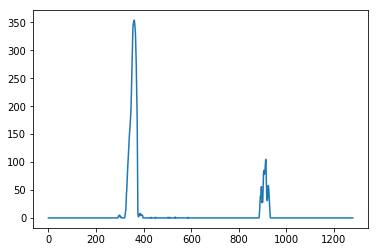

In [12]:
# changed from code to md
#Show apply histogram on the warped image to find the base of lane line
bin_test_warped = perspective_transform(bin_test) 
histogram = np.sum(bin_test_warped[bin_test_warped.shape[0]//2:,:], axis = 0)
plt.plot(histogram)

### 3.2 Create a pipeline to identify the lane lines in the warped image

#### 3.2.1 Detect Lane lines if there is no previous fit

In [13]:
#This function returns the lane line indices is a transformed image is given as an input
#There is no prior knowledge of lane_indices
def non_zero_indices(img):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    non_zero_indices = (nonzeroy, nonzerox)
    return non_zero_indices

def find_lane_lines(img):
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Identify the x and y positions of all nonzero pixels in the image
    nonzeroy = non_zero_indices(img)[0]
    nonzerox = non_zero_indices(img)[1]
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    x_detected = [leftx, rightx]
    y_detected = [lefty, righty]
    
    #Assign none values to fits
    left_fit, right_fit = None, None
    
    # Fit a second order polynomial to each
    if len(leftx)!=0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx)!=0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, x_detected, y_detected

### Visualization - Lane lines detected for the first time

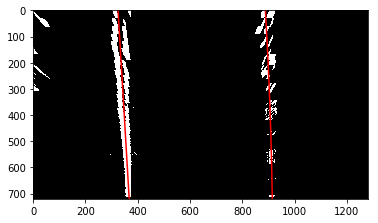

In [14]:
# Generate x and y values for plotting
left_fit, right_fit, x_detected, y_detected = find_lane_lines(bin_test_warped)
ploty = np.linspace(0, bin_test_warped.shape[0]-1, bin_test_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(bin_test_warped, cmap = 'gray')
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/lane_lines.jpg')

#### 3.2.2 Detect Lane lines if we have a previous fit

In [15]:
def redetect_lane_lines(img, left_fit, right_fit):
    
# Identify the x and y positions of all nonzero pixels in the image
    nonzeroy = non_zero_indices(img)[0]
    nonzerox = non_zero_indices(img)[1]
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # generated the detected pixel coordinates
    x_detected = [leftx, rightx]
    y_detected = [lefty, righty]
       
    #Assign None values to left fit and right fit
    left_fit, right_fit = None, None
    
    # Fit a second order polynomial to each
    if len(leftx)!=0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx)!=0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, x_detected, y_detected


# Section 4 - Identifying the radius of curvature and distance from center

In [16]:
def rad_curv_and_center_dist(img, left_fit_2, right_fit_2, x_detected1, y_detected1):
    ym_per_pix = 3/85
    xm_per_pix = 3.7/550
    
    if left_fit_2 is None and right_fit_2 is None:
        left_curve_rad, right_curve_rad, center_dist1 = None, None, None
    
    else:
        [leftx, rightx] = x_detected1
        [lefty, righty] = y_detected1
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        #y positoin where I want to calculate the radius
        plot_y = np.linspace(0,img.shape[0]-1,img.shape[0])
        y_eval = np.max(plot_y)
        # Calculate the new radii of curvature
        left_curve_rad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curve_rad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        xleft = left_fit_2[0]*y_eval**2 + left_fit_2[1]*y_eval+left_fit_2[2]
        xright = right_fit_2[0]*y_eval**2 + right_fit_2[1]*y_eval+right_fit_2[2]
        car_position = img.shape[1]/2
        lane_center = (xright + xleft)/2
        center_dist1 =(car_position - lane_center) * xm_per_pix
    
    return left_curve_rad, right_curve_rad, center_dist1


In [17]:
def draw_data_on_img(img, curv_rad, center_dist2):
    if curv_rad is None or center_dist2 is None:
        return img
    
    new_img = np.copy(img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    if center_dist2 > 0:
        direction = 'right'
    elif center_dist2 < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist2)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

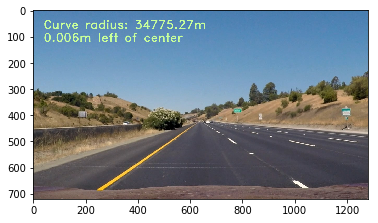

In [18]:
#Visualize the text adding functions
lrad_test, rrad_test, cdist_test = rad_curv_and_center_dist(img_test,left_fit, right_fit, x_detected, y_detected)
img_test_textadded = draw_data_on_img(img_test, (lrad_test+rrad_test)/2,cdist_test)
plt.imshow(img_test_textadded)
plt.savefig('output_images/text_added.jpg')

# Section 5 - Draw Lane on original image

In [19]:
def draw_lane_on_original(original_img, bin_img, left_fit_1, right_fit_1):
    
    if left_fit_1 is None or right_fit_1 is None:
        return original_img
    
    h = bin_img.shape[0]
    ploty = np.linspace(0,h-1,h)
    leftx1 = left_fit_1[0]*ploty**2 + left_fit_1[1]*ploty+left_fit_1[2]
    rightx1 = right_fit_1[0]*ploty**2 + right_fit_1[1]*ploty+right_fit_1[2]
    
    new_img = np.copy(original_img)
    warp_zero = np.zeros_like(bin_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftx1, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx1, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    return result


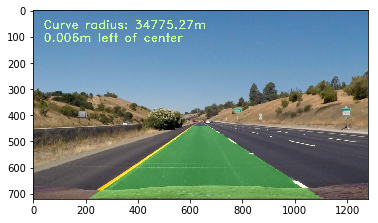

In [20]:
#Visualize the results of projecting lanes on the original image.
img_test_laneadded = draw_lane_on_original(img_test_textadded, bin_test_warped, left_fit, right_fit)
plt.imshow(img_test_laneadded)
plt.savefig('output_images/laneadded')

# Section 6 - Video Processing

In [21]:
#This function will apply the basic tranforms and return a bird's eye view of the image
#The returned image will be a one single channel image

def binary_warped(img):
    #undistort the image
    img = undistort_image(img)
    #apply color filters on the image
    img = transformed_image(img)
    #apply perspective transform on the image
    img = perspective_transform(img)
    return img


In [22]:
class Line:
    def __init__(self):
        self.detected = False
        #x values of the last n fits of the line 
        self.recent_xfitted = []
        #average x values of the fitted lines for the last n ieterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        #self.current_fit = [np.array([False])]  
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def add_fit(self,fit, x_inds):
        #add a found fit to the line,up to n
        if fit is not None:
            if self.best_fit is not None:
                self.diffs = np.absolute(fit - self.best_fit)
            
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                self.detected = False

            else:
                self.detected = True
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    #remove the old fit and keep the newest ones
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis = 0)
        else:
            self.detected = False
            if len(self.current_fit)>0:
                #throw out the oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


In [23]:
def process_img(img):
    new_img = np.copy(img)
    new_img = undistort_image(new_img)
    bin_warp3 = binary_warped(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        print('executing detection for first time')
        lfit, rfit, x_detected, y_detected = find_lane_lines(bin_warp3)
        
    else:
        print('redetecting lane lines')
        lfit, rfit, x_detected, y_detected = redetect_lane_lines(bin_warp3, l_line.best_fit, r_line.best_fit)
        
    #invalidate both fits if the x coordinates are more than 750 +/- 100 px apart
    if lfit is not None and rfit is not None:
        h = bin_warp3.shape[0]
        xleft = lfit[0]*h**2 + lfit[1]*h+lfit[2]
        xright = rfit[0]*h**2 + rfit[1]*h+rfit[2]
        x_diff = xright - xleft
        print ('difference = ' + '{:0.2f}'.format(x_diff))
        if abs(550 - x_diff) > 100:
            print('difference is too much')
            lfit = None
            rfit = None
    

    print('lfit :', end='')
    print(lfit)
    print('rfit :', end='')
    print(rfit)

    [xleft, xright] = x_detected
    
    
    l_line.add_fit(lfit, xleft)
    r_line.add_fit(rfit, xright)
    
    print("left line current fit length : ", end = '')
    print(len(l_line.current_fit))
    print("rigft line current fit length : ", end = '')
    print(len(r_line.current_fit))

    print('left best fit', end='')
    print(l_line.best_fit)
    print('right best fit', end='')
    print(r_line.best_fit)
    
    #draw the current best fit if it exists        
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out = draw_lane_on_original(new_img, bin_warp3, l_line.best_fit, r_line.best_fit)
        rad_l, rad_r, d_center_cur = rad_curv_and_center_dist(bin_warp3, lfit, rfit, x_detected, y_detected)
        if rad_l is not None and rad_r is not None:
            img_out = draw_data_on_img(img_out, (rad_l+rad_r)/2, d_center_cur)
    else:
        img_out = new_img
        
    return img_out

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output1.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(0,5)
processed_video = video_input1.fl_image(process_img)
%time processed_video.write_videofile(video_output1, audio=False)

executing detection for first time
difference = 563.43
lfit :[ -5.25679573e-04   8.86156535e-01   5.25704661e+01]
rfit :[ -3.16296889e-04   6.48713543e-01   6.78415985e+02]
left line current fit length : 1
rigft line current fit length : 1
left best fit[ -5.25679573e-04   8.86156535e-01   5.25704661e+01]
right best fit[ -3.16296889e-04   6.48713543e-01   6.78415985e+02]
[MoviePy] >>>> Building video project_video_output1.mp4
[MoviePy] Writing video project_video_output1.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

redetecting lane lines
difference = 567.72
lfit :[ -5.53598354e-04   9.12115225e-01   4.72192974e+01]
rfit :[ -3.10951125e-04   6.57636043e-01   6.72375448e+02]
left line current fit length : 2
rigft line current fit length : 2
left best fit[ -5.39638964e-04   8.99135880e-01   4.98948818e+01]
right best fit[ -3.13624007e-04   6.53174793e-01   6.75395717e+02]


  0%|                                                                                 | 1/1261 [00:00<05:12,  4.04it/s]

redetecting lane lines
difference = 557.20
lfit :[ -5.72137839e-04   9.30627558e-01   4.40010687e+01]
rfit :[ -4.29940617e-04   7.65599420e-01   6.46308205e+02]
left line current fit length : 3
rigft line current fit length : 3
left best fit[ -5.50471922e-04   9.09633106e-01   4.79302774e+01]
right best fit[ -3.52396210e-04   6.90649669e-01   6.65699880e+02]


  0%|▏                                                                                | 2/1261 [00:00<05:35,  3.76it/s]

redetecting lane lines
difference = 556.46
lfit :[ -5.78213366e-04   9.39099701e-01   4.12400060e+01]
rfit :[ -4.26545351e-04   7.77813694e-01   6.35205919e+02]
left line current fit length : 4
rigft line current fit length : 4
left best fit[ -5.57407283e-04   9.16999755e-01   4.62577096e+01]
right best fit[ -3.70933496e-04   7.12440675e-01   6.58076390e+02]


  0%|▏                                                                                | 3/1261 [00:00<05:23,  3.89it/s]

redetecting lane lines
difference = 548.11
lfit :[ -5.76751888e-04   9.46713331e-01   3.70476040e+01]
rfit :[ -5.26424629e-04   8.73151704e-01   6.12032346e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.61276204e-04   9.22942470e-01   4.44156884e+01]
right best fit[ -4.02031722e-04   7.44582881e-01   6.48867581e+02]


  0%|▎                                                                                | 4/1261 [00:01<05:44,  3.65it/s]

redetecting lane lines
difference = 541.49
lfit :[ -5.62521564e-04   9.41412222e-01   3.52777262e+01]
rfit :[ -5.71867311e-04   9.04366158e-01   6.08284581e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.68644602e-04   9.33993607e-01   4.09571405e+01]
right best fit[ -4.53145807e-04   7.95713404e-01   6.34841300e+02]


  0%|▎                                                                                | 5/1261 [00:01<05:59,  3.50it/s]

redetecting lane lines
difference = 538.48
lfit :[ -5.83779033e-04   9.63390872e-01   3.01361113e+01]
rfit :[ -6.40600899e-04   9.81650715e-01   5.84927273e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.74680738e-04   9.44248737e-01   3.75405033e+01]
right best fit[ -5.19075761e-04   8.60516338e-01   6.17351665e+02]


  0%|▍                                                                                | 6/1261 [00:01<05:59,  3.49it/s]

redetecting lane lines
difference = 540.30
lfit :[ -5.66296052e-04   9.48954454e-01   3.21787441e+01]
rfit :[ -5.90937124e-04   9.29605512e-01   5.99188714e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.73512381e-04   9.47914116e-01   3.51760383e+01]
right best fit[ -5.51275063e-04   8.93317557e-01   6.07927767e+02]


  1%|▍                                                                                | 7/1261 [00:02<06:23,  3.27it/s]

redetecting lane lines
difference = 550.54
lfit :[ -5.95224597e-04   9.87271764e-01   2.07069476e+01]
rfit :[ -5.11606487e-04   9.06727803e-01   5.85889845e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.76914627e-04   9.57548528e-01   3.10694266e+01]
right best fit[ -5.68287290e-04   9.19100378e-01   5.98064552e+02]


  1%|▌                                                                                | 8/1261 [00:02<06:39,  3.14it/s]

redetecting lane lines
difference = 542.11
lfit :[ -5.28099746e-04   9.30414178e-01   2.86385626e+01]
rfit :[ -5.37800841e-04   8.95403161e-01   6.00980860e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.67184199e-04   9.54288698e-01   2.93876184e+01]
right best fit[ -5.70562532e-04   9.23550670e-01   5.95854254e+02]


  1%|▌                                                                                | 9/1261 [00:02<06:37,  3.15it/s]

redetecting lane lines
difference = 551.14
lfit :[ -5.67104513e-04   9.61971201e-01   2.27674562e+01]
rfit :[ -5.04684405e-04   8.83499859e-01   5.98049101e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.68100788e-04   9.58400494e-01   2.68855644e+01]
right best fit[ -5.57125951e-04   9.19377410e-01   5.93807159e+02]


  1%|▋                                                                               | 10/1261 [00:03<06:30,  3.21it/s]

redetecting lane lines
difference = 552.13
lfit :[ -5.89415278e-04   9.88674929e-01   1.48397187e+01]
rfit :[ -4.91056395e-04   8.90683703e-01   5.86534401e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.69228037e-04   9.63457305e-01   2.38262858e+01]
right best fit[ -5.27217050e-04   9.01184007e-01   5.94128584e+02]


  1%|▋                                                                               | 11/1261 [00:03<06:31,  3.19it/s]

redetecting lane lines
difference = 548.93
lfit :[ -5.07253122e-04   9.17666600e-01   2.27277930e+01]
rfit :[ -4.98399226e-04   8.33695935e-01   6.27525130e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.57419451e-04   9.57199734e-01   2.19360956e+01]
right best fit[ -5.08709471e-04   8.82002092e-01   5.99795867e+02]


  1%|▊                                                                               | 12/1261 [00:03<06:00,  3.47it/s]

redetecting lane lines
difference = 559.54
lfit :[ -5.06033992e-04   9.18035002e-01   2.16551327e+01]
rfit :[ -3.77535907e-04   7.65058956e-01   6.24728192e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.39581330e-04   9.43352382e-01   2.21257326e+01]
right best fit[ -4.81895355e-04   8.53668323e-01   6.07563537e+02]


  1%|▊                                                                               | 13/1261 [00:03<05:33,  3.74it/s]

redetecting lane lines
difference = 555.15
lfit :[ -5.38956898e-04   9.60409333e-01   8.72462057e+00]
rfit :[ -4.13964572e-04   8.00075904e-01   6.14518906e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.41752761e-04   9.49351413e-01   1.81429442e+01]
right best fit[ -4.57128101e-04   8.34602871e-01   6.10271146e+02]


  1%|▉                                                                               | 14/1261 [00:04<05:15,  3.95it/s]

redetecting lane lines
difference = 548.41
lfit :[ -6.08519698e-04   1.01920319e+00  -2.77409095e-01]
rfit :[ -5.43044789e-04   9.51424708e-01   5.62993728e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.50035797e-04   9.60797811e-01   1.35339712e+01]
right best fit[ -4.64800178e-04   8.48187841e-01   6.03260071e+02]


  1%|▉                                                                               | 15/1261 [00:04<05:09,  4.03it/s]

redetecting lane lines
difference = 544.74
lfit :[ -6.59666535e-04   1.06906982e+00  -1.07174406e+01]
rfit :[ -5.92153826e-04   1.02447753e+00   5.31129106e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.64086049e-04   9.76876789e-01   8.42253931e+00]
right best fit[ -4.85019664e-04   8.74946607e-01   5.92179012e+02]


  1%|█                                                                               | 16/1261 [00:04<05:20,  3.88it/s]

redetecting lane lines
difference = 542.85
lfit :[ -6.88656765e-04   1.10108955e+00  -1.98761264e+01]
rfit :[ -6.06960075e-04   1.03780392e+00   5.26185632e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.00366778e-04   1.01356138e+00  -9.82445757e-02]
right best fit[ -5.06731834e-04   9.15768203e-01   5.71911113e+02]


  1%|█                                                                               | 17/1261 [00:04<05:05,  4.07it/s]

redetecting lane lines
difference = 542.42
lfit :[ -6.80340270e-04   1.10076061e+00  -2.32861623e+01]
rfit :[ -6.13906289e-04   1.06058963e+00   5.13618133e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.35228033e-04   1.05010650e+00  -9.08650357e+00]
right best fit[ -5.54005910e-04   9.74874337e-01   5.49689101e+02]


  1%|█▏                                                                              | 18/1261 [00:05<05:19,  3.89it/s]

redetecting lane lines
difference = 544.83
lfit :[ -6.70659816e-04   1.08482716e+00  -1.94007928e+01]
rfit :[ -6.26132397e-04   1.05363679e+00   5.24807620e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.61568617e-04   1.07499007e+00  -1.47115862e+01]
right best fit[ -5.96439475e-04   1.02558651e+00   5.31746844e+02]


  2%|█▏                                                                              | 19/1261 [00:05<05:37,  3.68it/s]

redetecting lane lines
difference = 540.48
lfit :[ -6.38243908e-04   1.05227611e+00  -1.34971026e+01]
rfit :[ -6.77159232e-04   1.06993257e+00   5.34448290e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.67513459e-04   1.08160465e+00  -1.73555249e+01]
right best fit[ -6.23262364e-04   1.04928809e+00   5.26037756e+02]


  2%|█▎                                                                              | 20/1261 [00:05<05:47,  3.57it/s]

redetecting lane lines
difference = 534.66
lfit :[ -6.10099683e-04   1.02683297e+00  -1.05105749e+01]
rfit :[ -6.96872537e-04   1.04645505e+00   5.54999753e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.57600088e-04   1.07315728e+00  -1.73141518e+01]
right best fit[ -6.44206106e-04   1.05368359e+00   5.30811886e+02]


  2%|█▎                                                                              | 21/1261 [00:05<06:08,  3.36it/s]

redetecting lane lines
difference = 536.23
lfit :[ -5.53401803e-04   9.78083863e-01  -4.34866246e+00]
rfit :[ -6.83852828e-04   1.01306438e+00   5.74321377e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.30549096e-04   1.04855614e+00  -1.42086590e+01]
right best fit[ -6.59584657e-04   1.04873568e+00   5.40439035e+02]


  2%|█▍                                                                              | 22/1261 [00:06<06:05,  3.39it/s]

redetecting lane lines
difference = 539.20
lfit :[ -5.70976295e-04   9.83501069e-01  -4.02598423e+00]
rfit :[ -6.88926072e-04   9.92942913e-01   5.89516716e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.08676301e-04   1.02510424e+00  -1.03566234e+01]
right best fit[ -6.74588613e-04   1.03520634e+00   5.55618751e+02]


  2%|█▍                                                                              | 23/1261 [00:06<06:10,  3.34it/s]

redetecting lane lines
difference = 554.61
lfit :[ -6.27422562e-04   1.03744675e+00  -1.51837724e+01]
rfit :[ -5.51173393e-04   9.12033131e-01   5.90197011e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.00028850e-04   1.01562815e+00  -9.51321932e+00]
right best fit[ -6.59596812e-04   1.00688561e+00   5.68696629e+02]


  2%|█▌                                                                              | 24/1261 [00:06<06:05,  3.38it/s]

redetecting lane lines
difference = 557.46
lfit :[ -6.44251150e-04   1.04949696e+00  -1.61839640e+01]
rfit :[ -5.52627424e-04   9.31097506e-01   5.79029708e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.01230299e-04   1.01507232e+00  -1.00505916e+01]
right best fit[ -6.34690451e-04   9.79118596e-01   5.77612913e+02]


  2%|█▌                                                                              | 25/1261 [00:07<06:08,  3.36it/s]

redetecting lane lines
difference = 565.10
lfit :[ -6.32727902e-04   1.03262765e+00  -1.21361594e+01]
rfit :[ -4.54527108e-04   8.18074746e-01   6.15067231e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.05755943e-04   1.01623126e+00  -1.03757085e+01]
right best fit[ -5.86221365e-04   9.33442536e-01   5.89626409e+02]


  2%|█▋                                                                              | 26/1261 [00:07<06:06,  3.37it/s]

redetecting lane lines
difference = 564.24
lfit :[ -6.28260319e-04   1.02362305e+00  -8.94868759e+00]
rfit :[ -5.05511326e-04   8.62603709e-01   6.07594208e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.20727646e-04   1.02533909e+00  -1.12957135e+01]
right best fit[ -5.50553065e-04   9.03350401e-01   5.96280975e+02]


  2%|█▋                                                                              | 27/1261 [00:07<06:32,  3.14it/s]

redetecting lane lines
difference = 565.85
lfit :[ -5.90677508e-04   9.84766240e-01  -1.71788928e+00]
rfit :[ -4.80279588e-04   7.97809680e-01   6.41507718e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.24667888e-04   1.02559213e+00  -1.08340945e+01]
right best fit[ -5.08823768e-04   8.64323754e-01   6.06679175e+02]


  2%|█▊                                                                              | 28/1261 [00:08<06:18,  3.25it/s]

redetecting lane lines
difference = 565.85
lfit :[ -6.64066685e-04   1.05375967e+00  -1.51165781e+01]
rfit :[ -4.96139387e-04   8.28797066e-01   6.25652288e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.31996713e-04   1.02885471e+00  -1.08206557e+01]
right best fit[ -4.97816967e-04   8.47676541e-01   6.13770231e+02]


  2%|█▊                                                                              | 29/1261 [00:08<06:21,  3.23it/s]

redetecting lane lines
difference = 558.13
lfit :[ -6.56559800e-04   1.05148616e+00  -1.42195268e+01]
rfit :[ -5.73466372e-04   9.22596259e-01   5.93639208e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.34458443e-04   1.02925256e+00  -1.04277682e+01]
right best fit[ -5.01984756e-04   8.45976292e-01   6.16692131e+02]


  2%|█▉                                                                              | 30/1261 [00:08<06:05,  3.37it/s]

redetecting lane lines
difference = 554.56
lfit :[ -7.22340334e-04   1.11814822e+00  -2.84246366e+01]
rfit :[ -6.94334211e-04   1.06169746e+00   5.52261276e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.52380929e-04   1.04635667e+00  -1.36854637e+01]
right best fit[ -5.49946177e-04   8.94700834e-01   6.04130940e+02]


  2%|█▉                                                                              | 31/1261 [00:08<06:02,  3.39it/s]

redetecting lane lines
difference = 560.50
lfit :[ -7.63536661e-04   1.15855772e+00  -3.48755407e+01]
rfit :[ -6.32534091e-04   1.05912844e+00   5.29297020e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.79436198e-04   1.07334360e+00  -1.88708343e+01]
right best fit[ -5.75350730e-04   9.34005782e-01   5.88471502e+02]


  3%|██                                                                              | 32/1261 [00:09<05:57,  3.44it/s]

redetecting lane lines
difference = 552.25
lfit :[ -7.17414508e-04   1.11440912e+00  -2.64635938e+01]
rfit :[ -7.44331096e-04   1.12614415e+00   5.31295116e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.04783598e-04   1.09927218e+00  -2.38199752e+01]
right best fit[ -6.28161031e-04   9.99672675e-01   5.66428982e+02]


  3%|██                                                                              | 33/1261 [00:09<05:49,  3.51it/s]

redetecting lane lines
difference = 553.92
lfit :[ -7.58659454e-04   1.15689440e+00  -3.55473110e+01]
rfit :[ -7.24474348e-04   1.12484937e+00   5.23721292e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.23702151e-04   1.11989912e+00  -2.79061218e+01]
right best fit[ -6.73828023e-04   1.05888313e+00   5.46042782e+02]


  3%|██▏                                                                             | 34/1261 [00:09<05:25,  3.77it/s]

redetecting lane lines
difference = 566.53
lfit :[ -7.70808499e-04   1.17289111e+00  -3.92220077e+01]
rfit :[ -6.15303794e-04   1.06262785e+00   5.26079527e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.46551891e-04   1.14418011e+00  -3.29066179e+01]
right best fit[ -6.82195508e-04   1.08688945e+00   5.32530846e+02]


  3%|██▏                                                                             | 35/1261 [00:10<05:27,  3.74it/s]

redetecting lane lines
difference = 563.95
lfit :[ -7.82937028e-04   1.19269168e+00  -4.49904639e+01]
rfit :[ -6.01145091e-04   1.06668459e+00   5.15441877e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.58671230e-04   1.15908881e+00  -3.62197834e+01]
right best fit[ -6.63557684e-04   1.08788688e+00   5.25166966e+02]


  3%|██▎                                                                             | 36/1261 [00:10<05:27,  3.75it/s]

redetecting lane lines
difference = 547.32
lfit :[ -7.58637047e-04   1.17355292e+00  -4.17328790e+01]
rfit :[ -7.78222312e-04   1.21616954e+00   4.85053905e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.57691307e-04   1.16208785e+00  -3.75912511e+01]
right best fit[ -6.92695328e-04   1.11929510e+00   5.16318343e+02]


  3%|██▎                                                                             | 37/1261 [00:10<05:41,  3.58it/s]

redetecting lane lines
difference = 548.62
lfit :[ -8.09204758e-04   1.22037612e+00  -5.00876731e+01]
rfit :[ -8.08572058e-04   1.26921655e+00   4.63040580e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.76049357e-04   1.18328125e+00  -4.23160669e+01]
right best fit[ -7.05543521e-04   1.14790958e+00   5.02667436e+02]


  3%|██▍                                                                             | 38/1261 [00:10<05:44,  3.55it/s]

redetecting lane lines
difference = 547.47
lfit :[ -8.08748736e-04   1.23363829e+00  -5.73138883e+01]
rfit :[ -7.81427387e-04   1.26701024e+00   4.51964482e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.86067214e-04   1.19863002e+00  -4.66693824e+01]
right best fit[ -7.16934128e-04   1.17634175e+00   4.88316074e+02]


  3%|██▍                                                                             | 39/1261 [00:11<05:47,  3.52it/s]

redetecting lane lines
difference = 543.38
lfit :[ -7.57121229e-04   1.18880411e+00  -4.94226332e+01]
rfit :[ -7.84506147e-04   1.25522111e+00   4.60329236e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.83329760e-04   1.20181262e+00  -4.87095075e+01]
right best fit[ -7.50774599e-04   1.21486040e+00   4.75166016e+02]


  3%|██▌                                                                             | 40/1261 [00:11<05:43,  3.55it/s]

redetecting lane lines
difference = 547.68
lfit :[ -7.91412337e-04   1.21900768e+00  -5.55022464e+01]
rfit :[ -7.48170882e-04   1.23000590e+00   4.61841676e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.85024821e-04   1.20707582e+00  -5.08118640e+01]
right best fit[ -7.80179757e-04   1.24752467e+00   4.64445976e+02]


  3%|██▌                                                                             | 41/1261 [00:11<05:48,  3.50it/s]

redetecting lane lines
difference = 544.26
lfit :[ -7.23302099e-04   1.16415564e+00  -4.68342750e+01]
rfit :[ -7.12863691e-04   1.19103997e+00   4.72662129e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.77957832e-04   1.20519637e+00  -5.18321432e+01]
right best fit[ -7.67108033e-04   1.24249875e+00   4.61967621e+02]


  3%|██▋                                                                             | 42/1261 [00:12<05:57,  3.41it/s]

redetecting lane lines
difference = 543.94
lfit :[ -6.84006992e-04   1.13365295e+00  -4.32176810e+01]
rfit :[ -6.75589439e-04   1.14087724e+00   4.91155431e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.52918279e-04   1.18785173e+00  -5.04581448e+01]
right best fit[ -7.40511509e-04   1.21683089e+00   4.67590591e+02]


  3%|██▋                                                                             | 43/1261 [00:12<06:13,  3.26it/s]

redetecting lane lines
difference = 543.51
lfit :[ -6.37430000e-04   1.08640809e+00  -3.32767839e+01]
rfit :[ -6.79492786e-04   1.11670275e+00   5.10230711e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.18654531e-04   1.15840569e+00  -4.56507239e+01]
right best fit[ -7.20124589e-04   1.18676940e+00   4.79243837e+02]


  3%|██▊                                                                             | 44/1261 [00:12<06:15,  3.24it/s]

redetecting lane lines
difference = 543.97
lfit :[ -6.11023200e-04   1.06640546e+00  -3.16823336e+01]
rfit :[ -6.44159932e-04   1.07039993e+00   5.26590345e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.89434926e-04   1.13392596e+00  -4.21026640e+01]
right best fit[ -6.92055346e-04   1.14980516e+00   4.92496059e+02]


  4%|██▊                                                                             | 45/1261 [00:13<06:14,  3.24it/s]

redetecting lane lines
difference = 553.23
lfit :[ -5.92566324e-04   1.04864132e+00  -2.83926472e+01]
rfit :[ -5.83810584e-04   1.03244698e+00   5.31954607e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.49665723e-04   1.09985269e+00  -3.66807441e+01]
right best fit[ -6.59183286e-04   1.11029337e+00   5.06518645e+02]


  4%|██▉                                                                             | 46/1261 [00:13<06:20,  3.20it/s]

redetecting lane lines
difference = 553.60
lfit :[ -5.48108254e-04   1.00677777e+00  -2.11986978e+01]
rfit :[ -5.51625457e-04   9.89828023e-01   5.46424381e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.14626954e-04   1.06837712e+00  -3.15536287e+01]
right best fit[ -6.26935639e-04   1.07005099e+00   5.21271095e+02]


  4%|██▉                                                                             | 47/1261 [00:13<06:16,  3.23it/s]

redetecting lane lines
difference = 558.50
lfit :[ -5.66044671e-04   1.02599490e+00  -2.60832553e+01]
rfit :[ -5.18162640e-04   9.91621067e-01   5.32346540e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.91034490e-04   1.04684551e+00  -2.81267436e+01]
right best fit[ -5.95450280e-04   1.04019975e+00   5.29509317e+02]


  4%|███                                                                             | 48/1261 [00:13<06:02,  3.35it/s]

redetecting lane lines
difference = 549.35
lfit :[ -5.37530274e-04   1.00009123e+00  -2.29620827e+01]
rfit :[ -5.77011835e-04   9.92740107e-01   5.52145828e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.71054545e-04   1.02958214e+00  -2.60638033e+01]
right best fit[ -5.74954089e-04   1.01540722e+00   5.37892340e+02]


  4%|███                                                                             | 49/1261 [00:14<05:38,  3.58it/s]

redetecting lane lines
difference = 546.75
lfit :[ -5.33588356e-04   9.99414684e-01  -2.41780386e+01]
rfit :[ -6.11026311e-04   1.03472923e+00   5.37290345e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.55567576e-04   1.01618398e+00  -2.45629443e+01]
right best fit[ -5.68327365e-04   1.00827308e+00   5.40032340e+02]


  4%|███▏                                                                            | 50/1261 [00:14<05:16,  3.83it/s]

redetecting lane lines
difference = 549.71
lfit :[ -5.35067776e-04   9.98744504e-01  -2.39561760e+01]
rfit :[ -5.77303725e-04   1.00849099e+00   5.40626563e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.44067866e-04   1.00620462e+00  -2.36756501e+01]
right best fit[ -5.67025993e-04   1.00348188e+00   5.41766732e+02]


  4%|███▏                                                                            | 51/1261 [00:14<05:06,  3.94it/s]

redetecting lane lines
difference = 537.12
lfit :[ -5.39512998e-04   1.00276459e+00  -2.40620466e+01]
rfit :[ -7.38105417e-04   1.16385642e+00   5.00018925e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.42348815e-04   1.00540198e+00  -2.42483198e+01]
right best fit[ -6.04321985e-04   1.03828756e+00   5.32485640e+02]


  4%|███▎                                                                            | 52/1261 [00:14<05:04,  3.97it/s]

redetecting lane lines
difference = 537.02
lfit :[ -5.30934198e-04   9.88633623e-01  -1.90480123e+01]
rfit :[ -7.16925705e-04   1.14814621e+00   4.99541925e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.35326720e-04   9.97929725e-01  -2.28412712e+01]
right best fit[ -6.44074598e-04   1.06959259e+00   5.25924717e+02]


  4%|███▎                                                                            | 53/1261 [00:15<05:11,  3.88it/s]

redetecting lane lines
difference = 539.39
lfit :[ -5.45331040e-04   9.99137202e-01  -2.11326362e+01]
rfit :[ -7.00869505e-04   1.14546007e+00   4.93536570e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.36886873e-04   9.97738920e-01  -2.24753819e+01]
right best fit[ -6.68846133e-04   1.10013658e+00   5.14202866e+02]


  4%|███▍                                                                            | 54/1261 [00:15<05:04,  3.97it/s]

redetecting lane lines
difference = 541.34
lfit :[ -5.46516685e-04   9.98888019e-01  -2.18852153e+01]
rfit :[ -6.96928487e-04   1.13524704e+00   4.99254030e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.39472539e-04   9.97633587e-01  -2.20168173e+01]
right best fit[ -6.86026568e-04   1.12024014e+00   5.06595603e+02]


  4%|███▍                                                                            | 55/1261 [00:15<05:00,  4.01it/s]

redetecting lane lines
difference = 542.94
lfit :[ -5.16119384e-04   9.62717034e-01  -1.25971229e+01]
rfit :[ -6.87732162e-04   1.11951145e+00   5.06410365e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.35682861e-04   9.90428093e-01  -1.97450067e+01]
right best fit[ -7.08112255e-04   1.14244424e+00   4.99752363e+02]


  4%|███▌                                                                            | 56/1261 [00:15<04:46,  4.20it/s]

redetecting lane lines
difference = 543.83
lfit :[ -5.47842438e-04   9.89502768e-01  -1.73050892e+01]
rfit :[ -6.98539937e-04   1.13275233e+00   5.01503955e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.37348749e-04   9.87775729e-01  -1.83936152e+01]
right best fit[ -7.00199159e-04   1.13622342e+00   5.00049369e+02]


  5%|███▌                                                                            | 57/1261 [00:16<04:41,  4.27it/s]

redetecting lane lines
difference = 544.47
lfit :[ -5.48703871e-04   9.84654028e-01  -1.49696714e+01]
rfit :[ -6.73726309e-04   1.09928228e+00   5.11778129e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.40902684e-04   9.86979810e-01  -1.75779470e+01]
right best fit[ -6.91559280e-04   1.12645063e+00   5.02496610e+02]


  5%|███▋                                                                            | 58/1261 [00:16<04:40,  4.29it/s]

redetecting lane lines
difference = 528.97
lfit :[ -6.07257139e-04   1.03396725e+00  -2.12847583e+01]
rfit :[ -8.88214008e-04   1.31353479e+00   4.52042361e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.53287903e-04   9.93945820e-01  -1.76083714e+01]
right best fit[ -7.29028181e-04   1.16006558e+00   4.94197768e+02]


  5%|███▋                                                                            | 59/1261 [00:16<04:39,  4.30it/s]

redetecting lane lines
difference = 537.87
lfit :[ -6.68045949e-04   1.08374669e+00  -2.79439954e+01]
rfit :[ -8.31537855e-04   1.30372143e+00   4.36294314e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.77593756e-04   1.01091755e+00  -1.88201274e+01]
right best fit[ -7.55950054e-04   1.19376045e+00   4.81605825e+02]


  5%|███▊                                                                            | 60/1261 [00:16<04:37,  4.32it/s]

redetecting lane lines
difference = 538.01
lfit :[ -6.80226649e-04   1.08796245e+00  -2.65746986e+01]
rfit :[ -8.66548209e-04   1.34604848e+00   4.22197795e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.10415209e-04   1.03596664e+00  -2.16156426e+01]
right best fit[ -7.91713264e-04   1.23906786e+00   4.64763311e+02]


  5%|███▊                                                                            | 61/1261 [00:16<04:38,  4.31it/s]

redetecting lane lines
difference = 537.41
lfit :[ -7.27988643e-04   1.12674063e+00  -3.16071769e+01]
rfit :[ -9.11907754e-04   1.40749827e+00   3.99001563e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.46444450e-04   1.06341421e+00  -2.44760601e+01]
right best fit[ -8.34386827e-04   1.29401705e+00   4.44262832e+02]


  5%|███▉                                                                            | 62/1261 [00:17<04:32,  4.41it/s]

redetecting lane lines
difference = 540.42
lfit :[ -7.02210127e-04   1.09309857e+00  -2.19423532e+01]
rfit :[ -8.45994998e-04   1.32034239e+00   4.29402623e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.77145701e-04   1.08510312e+00  -2.58705965e+01]
right best fit[ -8.68840565e-04   1.33822907e+00   4.27787731e+02]


  5%|███▉                                                                            | 63/1261 [00:17<04:28,  4.46it/s]

redetecting lane lines
difference = 536.50
lfit :[ -7.33861745e-04   1.11653381e+00  -2.35557833e+01]
rfit :[ -9.49313761e-04   1.42424995e+00   4.03078338e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.02466623e-04   1.10161643e+00  -2.63248015e+01]
right best fit[ -8.81060516e-04   1.36037210e+00   4.17994927e+02]


  5%|████                                                                            | 64/1261 [00:17<04:39,  4.28it/s]

redetecting lane lines
difference = 540.66
lfit :[ -6.94678772e-04   1.07230194e+00  -1.32485127e+01]
rfit :[ -8.67774073e-04   1.32452091e+00   4.35544256e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.07793187e-04   1.09932748e+00  -2.33857049e+01]
right best fit[ -8.88307759e-04   1.36453200e+00   4.17844915e+02]


  5%|████                                                                            | 65/1261 [00:17<04:32,  4.38it/s]

redetecting lane lines
difference = 534.64
lfit :[ -7.15340931e-04   1.08740041e+00  -1.40678156e+01]
rfit :[ -9.68890015e-04   1.41819000e+00   4.13845628e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.14816044e-04   1.09921507e+00  -2.08843283e+01]
right best fit[ -9.08776120e-04   1.37896030e+00   4.16174481e+02]


  5%|████▏                                                                           | 66/1261 [00:18<04:31,  4.40it/s]

redetecting lane lines
difference = 536.88
lfit :[ -7.05575296e-04   1.07182976e+00  -8.70664176e+00]
rfit :[ -9.05179774e-04   1.34510646e+00   4.34890863e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.10333374e-04   1.08823290e+00  -1.63042213e+01]
right best fit[ -9.07430524e-04   1.36648194e+00   4.23352341e+02]


  5%|████▎                                                                           | 67/1261 [00:18<04:39,  4.27it/s]

redetecting lane lines
difference = 537.75
lfit :[ -6.67373138e-04   1.03424040e+00  -1.87927067e+00]
rfit :[ -8.64257585e-04   1.29231382e+00   4.52125015e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.03365976e-04   1.07646127e+00  -1.22916048e+01]
right best fit[ -9.11083042e-04   1.36087623e+00   4.27896820e+02]


  5%|████▎                                                                           | 68/1261 [00:18<05:08,  3.87it/s]

redetecting lane lines
difference = 534.92
lfit :[ -7.24300582e-04   1.08291698e+00  -9.20548264e+00]
rfit :[ -9.42298991e-04   1.38308973e+00   4.22605005e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.01453744e-04   1.06973790e+00  -9.42154468e+00]
right best fit[ -9.09680088e-04   1.35264418e+00   4.31802153e+02]


  5%|████▍                                                                           | 69/1261 [00:18<04:59,  3.98it/s]

redetecting lane lines
difference = 526.22
lfit :[ -6.60652336e-04   1.02143469e+00   2.18037793e+00]
rfit :[ -9.43240758e-04   1.32732540e+00   4.54654887e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.94648457e-04   1.05956445e+00  -6.33576655e+00]
right best fit[ -9.24773424e-04   1.35320508e+00   4.35624280e+02]


  6%|████▍                                                                           | 70/1261 [00:19<05:19,  3.72it/s]

redetecting lane lines
difference = 528.23
lfit :[ -7.16118838e-04   1.06768423e+00  -4.95336133e+00]
rfit :[ -9.35885668e-04   1.33047841e+00   4.47988586e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.94804038e-04   1.05562121e+00  -4.51287569e+00]
right best fit[ -9.18172555e-04   1.33566276e+00   4.42452871e+02]


  6%|████▌                                                                           | 71/1261 [00:19<05:02,  3.93it/s]

redetecting lane lines
difference = 533.99
lfit :[ -6.59630134e-04   1.01763213e+00   2.59070533e+00]
rfit :[ -8.44138048e-04   1.24190850e+00   4.70747913e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.85615005e-04   1.04478169e+00  -2.25340627e+00]
right best fit[ -9.05964210e-04   1.31502317e+00   4.49624281e+02]


  6%|████▌                                                                           | 72/1261 [00:19<04:52,  4.07it/s]

redetecting lane lines
difference = 536.00
lfit :[ -6.48938427e-04   1.00991461e+00   2.46944095e+00]
rfit :[ -8.48456036e-04   1.24572147e+00   4.72115480e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.81928063e-04   1.03991653e+00  -1.38366395e+00]
right best fit[ -9.02803900e-04   1.30570470e+00   4.53622374e+02]


  6%|████▋                                                                           | 73/1261 [00:19<04:43,  4.20it/s]

redetecting lane lines
difference = 535.33
lfit :[ -6.45739314e-04   1.00562657e+00   3.03272476e+00]
rfit :[ -8.54147219e-04   1.24638065e+00   4.73057399e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.66215810e-04   1.02445845e+00   1.06397753e+00]
right best fit[ -8.85173546e-04   1.27836289e+00   4.63712853e+02]


  6%|████▋                                                                           | 74/1261 [00:20<04:37,  4.28it/s]

redetecting lane lines
difference = 535.23
lfit :[ -6.17189906e-04   9.76978327e-01   7.49871908e+00]
rfit :[ -8.46718170e-04   1.21079778e+00   4.93365844e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.57523323e-04   1.01556717e+00   2.12764576e+00]
right best fit[ -8.65869028e-04   1.25505736e+00   4.71455044e+02]


  6%|████▊                                                                           | 75/1261 [00:20<04:40,  4.22it/s]

redetecting lane lines
difference = 542.68
lfit :[ -6.34721502e-04   9.93340900e-01   4.37063021e+00]
rfit :[ -7.81022041e-04   1.17803583e+00   4.89915124e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.41243856e-04   1.00069851e+00   3.99244406e+00]
right best fit[ -8.34896303e-04   1.22456885e+00   4.79840352e+02]


  6%|████▊                                                                           | 76/1261 [00:20<04:32,  4.35it/s]

redetecting lane lines
difference = 541.35
lfit :[ -5.76001402e-04   9.36013465e-01   1.33475718e+01]
rfit :[ -8.07259615e-04   1.14763773e+00   5.22211589e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.24518110e-04   9.84374775e-01   6.14381735e+00]
right best fit[ -8.27520616e-04   1.20571469e+00   4.90133087e+02]


  6%|████▉                                                                           | 77/1261 [00:20<04:26,  4.44it/s]

redetecting lane lines
difference = 545.23
lfit :[ -5.57018569e-04   9.14629996e-01   1.77698822e+01]
rfit :[ -7.50386117e-04   1.08337496e+00   5.41741677e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.06134139e-04   9.65317852e-01   9.20390560e+00]
right best fit[ -8.07906632e-04   1.17324539e+00   5.04058327e+02]


  6%|████▉                                                                           | 78/1261 [00:20<04:24,  4.46it/s]

redetecting lane lines
difference = 547.71
lfit :[ -5.27658342e-04   8.86263514e-01   2.23828532e+01]
rfit :[ -7.04418078e-04   1.02795788e+00   5.59706927e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.82517944e-04   9.41445240e-01   1.30739313e+01]
right best fit[ -7.77960804e-04   1.12956083e+00   5.21388232e+02]


  6%|█████                                                                           | 79/1261 [00:21<04:20,  4.54it/s]

redetecting lane lines
difference = 550.72
lfit :[ -5.50061916e-04   9.00449657e-01   2.11443497e+01]
rfit :[ -6.84216966e-04   1.01047206e+00   5.62198543e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.69092346e-04   9.26139506e-01   1.58030574e+01]
right best fit[ -7.45460563e-04   1.08949569e+00   5.35154772e+02]


  6%|█████                                                                           | 80/1261 [00:21<04:23,  4.48it/s]

redetecting lane lines
difference = 552.71
lfit :[ -5.89017848e-04   9.32298507e-01   1.64654664e+01]
rfit :[ -6.84403580e-04   1.03166380e+00   5.47075504e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.59951615e-04   9.13931028e-01   1.82220246e+01]
right best fit[ -7.26136871e-04   1.06022129e+00   5.46586848e+02]


  6%|█████▏                                                                          | 81/1261 [00:21<04:26,  4.43it/s]

redetecting lane lines
difference = 553.17
lfit :[ -5.93648446e-04   9.30247169e-01   1.76182604e+01]
rfit :[ -6.90251649e-04   1.01894669e+00   5.57005908e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.63481024e-04   9.12777769e-01   1.90761623e+01]
right best fit[ -7.02735278e-04   1.03448308e+00   5.53545712e+02]


  7%|█████▏                                                                          | 82/1261 [00:21<04:23,  4.47it/s]

redetecting lane lines
difference = 554.89
lfit :[ -5.87260592e-04   9.21401027e-01   1.99186572e+01]
rfit :[ -6.63965114e-04   9.91854063e-01   5.63850605e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.69529429e-04   9.14131975e-01   1.95059174e+01]
right best fit[ -6.85451077e-04   1.01617890e+00   5.57967497e+02]


  7%|█████▎                                                                          | 83/1261 [00:22<04:25,  4.43it/s]

redetecting lane lines
difference = 553.44
lfit :[ -5.17381952e-04   8.59604486e-01   2.76654468e+01]
rfit :[ -6.38037705e-04   9.14532755e-01   6.04101352e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.67474151e-04   9.08800169e-01   2.05624361e+01]
right best fit[ -6.72175003e-04   9.93493875e-01   5.66846382e+02]


  7%|█████▎                                                                          | 84/1261 [00:22<04:26,  4.42it/s]

redetecting lane lines
difference = 561.93
lfit :[ -5.43850003e-04   8.80381861e-01   2.50032631e+01]
rfit :[ -5.98226375e-04   9.00328375e-01   6.00764108e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.66231768e-04   9.04786610e-01   2.13342188e+01]
right best fit[ -6.54976885e-04   9.71465137e-01   5.74559495e+02]


  7%|█████▍                                                                          | 85/1261 [00:22<04:25,  4.44it/s]

redetecting lane lines
difference = 557.28
lfit :[ -5.91187948e-04   9.19526286e-01   1.90908350e+01]
rfit :[ -6.90494381e-04   9.76850620e-01   5.86578122e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.66665788e-04   9.02232166e-01   2.18592925e+01]
right best fit[ -6.56195045e-04   9.60502501e-01   5.82460019e+02]


  7%|█████▍                                                                          | 86/1261 [00:22<04:23,  4.46it/s]

redetecting lane lines
difference = 563.39
lfit :[ -6.95909255e-04   1.01022552e+00   7.48645009e+00]
rfit :[ -6.52662289e-04   1.00110029e+00   5.55031074e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.87117950e-04   9.18227835e-01   1.98329304e+01]
right best fit[ -6.48677173e-04   9.56933220e-01   5.82065052e+02]


  7%|█████▌                                                                          | 87/1261 [00:22<04:18,  4.55it/s]

redetecting lane lines
difference = 555.09
lfit :[ -7.45700934e-04   1.05581758e+00   1.30123721e+00]
rfit :[ -7.92748214e-04   1.15531791e+00   5.09136435e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.18806018e-04   9.45111146e-01   1.61094464e+01]
right best fit[ -6.74433793e-04   9.89625989e-01   5.71122218e+02]


  7%|█████▌                                                                          | 88/1261 [00:23<04:16,  4.58it/s]

redetecting lane lines
difference = 559.59
lfit :[ -8.20073961e-04   1.12447907e+00  -1.04936798e+01]
rfit :[ -7.53115213e-04   1.14187917e+00   5.01861512e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.79344420e-04   9.98086063e-01   8.47762112e+00]
right best fit[ -6.97449294e-04   1.03509527e+00   5.50674250e+02]


  7%|█████▋                                                                          | 89/1261 [00:23<04:15,  4.59it/s]

redetecting lane lines
difference = 557.17
lfit :[ -9.05633001e-04   1.20960119e+00  -2.60247381e+01]
rfit :[ -8.15036395e-04   1.24288034e+00   4.60219894e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.51701020e-04   1.06392993e+00  -1.72797911e+00]
right best fit[ -7.40811298e-04   1.10360566e+00   5.22565407e+02]


  7%|█████▋                                                                          | 90/1261 [00:23<04:14,  4.60it/s]

redetecting lane lines
difference = 555.46
lfit :[ -8.67179771e-04   1.17221155e+00  -1.85783151e+01]
rfit :[ -8.45891416e-04   1.24663658e+00   4.72258410e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.06899384e-04   1.11446698e+00  -9.26180912e+00]
right best fit[ -7.71890705e-04   1.15756286e+00   4.99701465e+02]


  7%|█████▊                                                                          | 91/1261 [00:23<04:17,  4.55it/s]

redetecting lane lines
difference = 553.84
lfit :[ -8.35714807e-04   1.14326810e+00  -1.23979772e+01]
rfit :[ -8.16920773e-04   1.20277706e+00   4.88855096e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.34860495e-04   1.14107550e+00  -1.32386946e+01]
right best fit[ -8.04742402e-04   1.19789821e+00   4.86466269e+02]


  7%|█████▊                                                                          | 92/1261 [00:24<04:15,  4.57it/s]

redetecting lane lines
difference = 551.09
lfit :[ -8.80783513e-04   1.19189150e+00  -2.27437932e+01]
rfit :[ -8.53478498e-04   1.25620096e+00   4.67883993e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.61877011e-04   1.16829028e+00  -1.80477007e+01]
right best fit[ -8.16888459e-04   1.21807482e+00   4.78215781e+02]


  7%|█████▉                                                                          | 93/1261 [00:24<04:15,  4.57it/s]

redetecting lane lines
difference = 547.94
lfit :[ -8.91842833e-04   1.20448679e+00  -2.49479732e+01]
rfit :[ -9.10690547e-04   1.31636984e+00   4.52209553e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.76230785e-04   1.18429182e+00  -2.09385593e+01]
right best fit[ -8.48403526e-04   1.25297296e+00   4.68285389e+02]


  7%|█████▉                                                                          | 94/1261 [00:24<04:21,  4.46it/s]

redetecting lane lines
difference = 543.43
lfit :[ -8.49387133e-04   1.16662539e+00  -1.85614462e+01]
rfit :[ -8.47415748e-04   1.21611877e+00   4.88215261e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.64981612e-04   1.17569666e+00  -1.94459010e+01]
right best fit[ -8.54879397e-04   1.24762064e+00   4.73884462e+02]


  8%|██████                                                                          | 95/1261 [00:24<04:20,  4.48it/s]

redetecting lane lines
difference = 539.10
lfit :[ -8.47608192e-04   1.16527315e+00  -1.84305758e+01]
rfit :[ -8.55312744e-04   1.20957315e+00   4.92762823e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.61067296e-04   1.17430898e+00  -1.94163531e+01]
right best fit[ -8.56763662e-04   1.24020796e+00   4.77985345e+02]


  8%|██████                                                                          | 96/1261 [00:24<04:15,  4.55it/s]

redetecting lane lines
difference = 531.70
lfit :[ -8.56758583e-04   1.17884352e+00  -2.25771109e+01]
rfit :[ -9.37566543e-04   1.27465790e+00   4.82026224e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.65276051e-04   1.18142407e+00  -2.14521799e+01]
right best fit[ -8.80892816e-04   1.25458412e+00   4.76619571e+02]


  8%|██████▏                                                                         | 97/1261 [00:25<04:20,  4.46it/s]

redetecting lane lines
difference = 534.81
lfit :[ -7.87309179e-04   1.11460127e+00  -1.03565901e+01]
rfit :[ -8.74072918e-04   1.19988982e+00   5.08024952e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.46581184e-04   1.16596602e+00  -1.89747393e+01]
right best fit[ -8.85011700e-04   1.24332189e+00   4.84647762e+02]


  8%|██████▏                                                                         | 98/1261 [00:25<04:16,  4.53it/s]

redetecting lane lines
difference = 532.91
lfit :[ -8.28794083e-04   1.15661501e+00  -1.90952075e+01]
rfit :[ -9.38003318e-04   1.27804458e+00   4.83004289e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.33971434e-04   1.15639167e+00  -1.78041861e+01]
right best fit[ -8.90474254e-04   1.23565684e+00   4.90806710e+02]


  8%|██████▎                                                                         | 99/1261 [00:25<04:23,  4.41it/s]

redetecting lane lines
difference = 529.39
lfit :[ -8.04922174e-04   1.13364801e+00  -1.43853634e+01]
rfit :[ -9.86519991e-04   1.30118441e+00   4.88519580e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.25078442e-04   1.14979619e+00  -1.69689696e+01]
right best fit[ -9.18295103e-04   1.25266997e+00   4.90867574e+02]


  8%|██████▎                                                                        | 100/1261 [00:25<04:19,  4.47it/s]

redetecting lane lines
difference = 533.98
lfit :[ -8.20727679e-04   1.15204425e+00  -1.85408648e+01]
rfit :[ -9.38668960e-04   1.27451206e+00   4.88398433e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.19702340e-04   1.14715041e+00  -1.69910274e+01]
right best fit[ -9.34966346e-04   1.26565775e+00   4.89994696e+02]


  8%|██████▎                                                                        | 101/1261 [00:26<04:15,  4.55it/s]

redetecting lane lines
difference = 537.87
lfit :[ -8.40317105e-04   1.17171218e+00  -2.20469505e+01]
rfit :[ -9.18135921e-04   1.27882353e+00   4.79044613e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.16414044e-04   1.14572414e+00  -1.68849953e+01]
right best fit[ -9.31080221e-04   1.26649088e+00   4.89398374e+02]


  8%|██████▍                                                                        | 102/1261 [00:26<04:17,  4.49it/s]

redetecting lane lines
difference = 540.44
lfit :[ -8.41269176e-04   1.17474843e+00  -2.30605397e+01]
rfit :[ -8.94822473e-04   1.25618053e+00   4.86507226e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.27206043e-04   1.15775358e+00  -1.94257852e+01]
right best fit[ -9.35230132e-04   1.27774902e+00   4.85094828e+02]


  8%|██████▍                                                                        | 103/1261 [00:26<04:12,  4.59it/s]

redetecting lane lines
difference = 541.60
lfit :[ -8.40657505e-04   1.17598778e+00  -2.30373269e+01]
rfit :[ -8.67192909e-04   1.23219339e+00   4.91846997e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.29578728e-04   1.16162813e+00  -2.02142091e+01]
right best fit[ -9.21068051e-04   1.26857878e+00   4.86863370e+02]


  8%|██████▌                                                                        | 104/1261 [00:26<04:13,  4.56it/s]

redetecting lane lines
difference = 541.88
lfit :[ -7.68538344e-04   1.10787128e+00  -1.02130536e+01]
rfit :[ -8.33132519e-04   1.16186754e+00   5.26272330e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.22301962e-04   1.15647278e+00  -1.93797471e+01]
right best fit[ -8.90390556e-04   1.24071541e+00   4.94413920e+02]


  8%|██████▌                                                                        | 105/1261 [00:26<04:13,  4.55it/s]

redetecting lane lines
difference = 541.38
lfit :[ -7.40590237e-04   1.08319038e+00  -5.69263279e+00]
rfit :[ -8.32901482e-04   1.14550975e+00   5.38674066e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.06274474e-04   1.14270201e+00  -1.68101007e+01]
right best fit[ -8.69237061e-04   1.21491495e+00   5.04469046e+02]


  8%|██████▋                                                                        | 106/1261 [00:27<04:11,  4.59it/s]

redetecting lane lines
difference = 539.62
lfit :[ -7.10409267e-04   1.05423573e+00   1.83345204e-01]
rfit :[ -8.32850392e-04   1.11680684e+00   5.58228730e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.80292906e-04   1.11920672e+00  -1.23640416e+01]
right best fit[ -8.52179955e-04   1.18251161e+00   5.20305870e+02]


  8%|██████▋                                                                        | 107/1261 [00:27<04:10,  4.61it/s]

redetecting lane lines
difference = 543.21
lfit :[ -7.61993883e-04   1.10696869e+00  -9.81525663e+00]
rfit :[ -7.82431790e-04   1.10186577e+00   5.47658995e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.64437847e-04   1.10565077e+00  -9.71498495e+00]
right best fit[ -8.29701818e-04   1.15164866e+00   5.32536224e+02]


  9%|██████▊                                                                        | 108/1261 [00:27<04:08,  4.63it/s]

redetecting lane lines
difference = 536.83
lfit :[ -7.37671982e-04   1.08440266e+00  -4.36510178e+00]
rfit :[ -8.31600010e-04   1.13752598e+00   5.42904068e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.43840743e-04   1.08733375e+00  -5.98053993e+00]
right best fit[ -8.22583238e-04   1.13271518e+00   5.42747638e+02]


  9%|██████▊                                                                        | 109/1261 [00:27<04:09,  4.61it/s]

redetecting lane lines
difference = 549.28
lfit :[ -7.43170237e-04   1.08814055e+00  -4.21040314e+00]
rfit :[ -7.63776764e-04   1.10121677e+00   5.46338313e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.38767121e-04   1.08338760e+00  -4.78000983e+00]
right best fit[ -8.08712087e-04   1.12058502e+00   5.46760834e+02]


  9%|██████▉                                                                        | 110/1261 [00:28<04:08,  4.63it/s]

redetecting lane lines
difference = 545.39
lfit :[ -7.78328478e-04   1.12179615e+00  -1.09233311e+01]
rfit :[ -8.02833488e-04   1.13458897e+00   5.37957198e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.46314769e-04   1.09110876e+00  -5.82614949e+00]
right best fit[ -8.02698489e-04   1.11840087e+00   5.46617461e+02]


  9%|██████▉                                                                        | 111/1261 [00:28<04:08,  4.62it/s]

redetecting lane lines
difference = 554.53
lfit :[ -6.99455370e-04   1.04753746e+00   2.83499322e+00]
rfit :[ -6.51381555e-04   9.69987899e-01   5.88280518e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.44123990e-04   1.08976910e+00  -5.29581989e+00]
right best fit[ -7.66404721e-04   1.08903708e+00   5.52627818e+02]


  9%|███████                                                                        | 112/1261 [00:28<04:10,  4.59it/s]

redetecting lane lines
difference = 551.23
lfit :[ -7.36337751e-04   1.08667781e+00  -4.56432039e+00]
rfit :[ -7.58289573e-04   1.11296759e+00   5.39113573e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.38992764e-04   1.08571093e+00  -4.24563264e+00]
right best fit[ -7.61576278e-04   1.09125744e+00   5.50918734e+02]


  9%|███████                                                                        | 113/1261 [00:28<04:07,  4.65it/s]

redetecting lane lines
difference = 545.05
lfit :[ -7.43187665e-04   1.09644865e+00  -6.57138950e+00]
rfit :[ -8.07096562e-04   1.14832476e+00   5.34256102e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.40095900e-04   1.08812013e+00  -4.68689018e+00]
right best fit[ -7.56675589e-04   1.09341720e+00   5.49189141e+02]


  9%|███████▏                                                                       | 114/1261 [00:28<04:01,  4.74it/s]

redetecting lane lines
difference = 547.84
lfit :[ -7.89217134e-04   1.14386869e+00  -1.59794506e+01]
rfit :[ -8.10013775e-04   1.19681545e+00   5.04518379e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.49305280e-04   1.09926575e+00  -7.04069967e+00]
right best fit[ -7.65922991e-04   1.11253693e+00   5.40825154e+02]


  9%|███████▏                                                                       | 115/1261 [00:29<04:05,  4.67it/s]

redetecting lane lines
difference = 549.16
lfit :[ -8.08020329e-04   1.16387825e+00  -2.02135409e+01]
rfit :[ -7.99500088e-04   1.20396234e+00   4.95667751e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.55243650e-04   1.10768217e+00  -8.89874162e+00]
right best fit[ -7.65256311e-04   1.12641161e+00   5.32367264e+02]


  9%|███████▎                                                                       | 116/1261 [00:29<04:05,  4.66it/s]

redetecting lane lines
difference = 547.50
lfit :[ -7.80981661e-04   1.14131900e+00  -1.66706366e+01]
rfit :[ -7.88625776e-04   1.18578765e+00   5.02778797e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.71548908e-04   1.12643848e+00  -1.27998676e+01]
right best fit[ -7.92705155e-04   1.16957156e+00   5.15266920e+02]


  9%|███████▎                                                                       | 117/1261 [00:29<04:09,  4.58it/s]

redetecting lane lines
difference = 544.22
lfit :[ -7.77827002e-04   1.14074778e+00  -1.68841647e+01]
rfit :[ -8.16940299e-04   1.20943606e+00   4.98151956e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.79846758e-04   1.13725247e+00  -1.52638364e+01]
right best fit[ -8.04435300e-04   1.18886525e+00   5.07074597e+02]


  9%|███████▍                                                                       | 118/1261 [00:29<04:03,  4.69it/s]

redetecting lane lines
difference = 544.99
lfit :[ -7.76109160e-04   1.14217704e+00  -1.78061227e+01]
rfit :[ -8.16403122e-04   1.21784936e+00   4.93591920e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.86431057e-04   1.14639815e+00  -1.75107831e+01]
right best fit[ -8.06296612e-04   1.20277017e+00   4.98941761e+02]


  9%|███████▍                                                                       | 119/1261 [00:29<04:07,  4.61it/s]

redetecting lane lines
difference = 538.69
lfit :[ -7.81203757e-04   1.15836448e+00  -2.32225537e+01]
rfit :[ -9.18292452e-04   1.34417234e+00   4.52756407e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.84828382e-04   1.14929731e+00  -1.89594037e+01]
right best fit[ -8.27952347e-04   1.23224155e+00   4.88589366e+02]


 10%|███████▌                                                                       | 120/1261 [00:30<04:18,  4.41it/s]

redetecting lane lines
difference = 553.12
lfit :[ -7.79680080e-04   1.15405310e+00  -2.15268820e+01]
rfit :[ -7.39966930e-04   1.18317157e+00   4.90038639e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.79160332e-04   1.14733228e+00  -1.92220719e+01]
right best fit[ -8.16045716e-04   1.22808340e+00   4.87463544e+02]


 10%|███████▌                                                                       | 121/1261 [00:30<04:17,  4.43it/s]

redetecting lane lines
difference = 551.43
lfit :[ -7.63142980e-04   1.14511471e+00  -2.11366327e+01]
rfit :[ -7.43673519e-04   1.19838493e+00   4.81847031e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.75592596e-04   1.14809142e+00  -2.01152711e+01]
right best fit[ -8.07055264e-04   1.23060285e+00   4.83277191e+02]


 10%|███████▋                                                                       | 122/1261 [00:30<04:09,  4.56it/s]

redetecting lane lines
difference = 538.08
lfit :[ -7.84522166e-04   1.16672528e+00  -2.46749784e+01]
rfit :[ -8.66407094e-04   1.30589486e+00   4.55653544e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.76931629e-04   1.15328692e+00  -2.16734339e+01]
right best fit[ -8.16948623e-04   1.24989461e+00   4.74777508e+02]


 10%|███████▋                                                                       | 123/1261 [00:30<04:09,  4.56it/s]

redetecting lane lines
difference = 544.56
lfit :[ -7.88452048e-04   1.16866637e+00  -2.40839882e+01]
rfit :[ -8.19915719e-04   1.28565561e+00   4.52550972e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.79400206e-04   1.15858479e+00  -2.29290070e+01]
right best fit[ -8.17651143e-04   1.26345586e+00   4.66569319e+02]


 10%|███████▊                                                                       | 124/1261 [00:31<04:09,  4.56it/s]

redetecting lane lines
difference = 544.97
lfit :[ -7.95147129e-04   1.17678269e+00  -2.55871793e+01]
rfit :[ -8.08809969e-04   1.28385643e+00   4.49377281e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.82188881e-04   1.16226843e+00  -2.34019321e+01]
right best fit[ -7.95754646e-04   1.25139268e+00   4.65893493e+02]


 10%|███████▊                                                                       | 125/1261 [00:31<04:08,  4.58it/s]

redetecting lane lines
difference = 544.95
lfit :[ -6.98522592e-04   1.09094672e+00  -1.14314281e+01]
rfit :[ -7.43952943e-04   1.18853309e+00   4.86810033e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.65957383e-04   1.14964716e+00  -2.13828413e+01]
right best fit[ -7.96551849e-04   1.25246498e+00   4.65247772e+02]


 10%|███████▉                                                                       | 126/1261 [00:31<04:06,  4.60it/s]

redetecting lane lines
difference = 545.04
lfit :[ -7.37310575e-04   1.12567119e+00  -1.73271807e+01]
rfit :[ -7.74981153e-04   1.22663387e+00   4.74549489e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.60790902e-04   1.14575845e+00  -2.06209509e+01]
right best fit[ -8.02813376e-04   1.25811477e+00   4.63788264e+02]


 10%|███████▉                                                                       | 127/1261 [00:31<04:07,  4.59it/s]

redetecting lane lines
difference = 542.82
lfit :[ -6.98521101e-04   1.08820835e+00  -9.40394666e+00]
rfit :[ -7.60858220e-04   1.19111505e+00   4.91640429e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.43590689e-04   1.13005506e+00  -1.75667446e+01]
right best fit[ -7.81703601e-04   1.23515881e+00   4.70985641e+02]


 10%|████████                                                                       | 128/1261 [00:31<04:05,  4.62it/s]

redetecting lane lines
difference = 545.45
lfit :[ -7.31617441e-04   1.12838346e+00  -1.90650041e+01]
rfit :[ -7.29128539e-04   1.22136337e+00   4.58153847e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.32223768e-04   1.12199848e+00  -1.65629478e+01]
right best fit[ -7.63546165e-04   1.22230036e+00   4.72106216e+02]


 10%|████████                                                                       | 129/1261 [00:32<04:06,  4.59it/s]

redetecting lane lines
difference = 540.23
lfit :[ -6.98808868e-04   1.09632866e+00  -1.25388720e+01]
rfit :[ -7.53553816e-04   1.21688007e+00   4.69269651e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.12956116e-04   1.10590768e+00  -1.39532863e+01]
right best fit[ -7.52494934e-04   1.20890509e+00   4.76084690e+02]


 10%|████████▏                                                                      | 130/1261 [00:32<04:05,  4.61it/s]

redetecting lane lines
difference = 538.35
lfit :[ -7.10762397e-04   1.10865443e+00  -1.51712919e+01]
rfit :[ -8.02597795e-04   1.26880127e+00   4.55477137e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.15404076e-04   1.10944922e+00  -1.47012591e+01]
right best fit[ -7.64223905e-04   1.22495873e+00   4.69818111e+02]


 10%|████████▏                                                                      | 131/1261 [00:32<04:02,  4.67it/s]

redetecting lane lines
difference = 535.39
lfit :[ -7.12855216e-04   1.11072571e+00  -1.42199414e+01]
rfit :[ -8.11861768e-04   1.27949503e+00   4.50984131e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.10513005e-04   1.10646012e+00  -1.40798112e+01]
right best fit[ -7.71600028e-04   1.23553096e+00   4.65105039e+02]


 10%|████████▎                                                                      | 132/1261 [00:32<04:04,  4.61it/s]

redetecting lane lines
difference = 529.71
lfit :[ -6.92294603e-04   1.09339701e+00  -1.10239564e+01]
rfit :[ -8.42178222e-04   1.28116526e+00   4.61194551e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.09267705e-04   1.10749785e+00  -1.44038132e+01]
right best fit[ -7.87864028e-04   1.25354100e+00   4.59015863e+02]


 11%|████████▎                                                                      | 133/1261 [00:33<04:01,  4.67it/s]

redetecting lane lines
difference = 534.09
lfit :[ -7.00993289e-04   1.10102155e+00  -1.09241351e+01]
rfit :[ -7.91578152e-04   1.25455761e+00   4.59580896e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.03142875e-04   1.10202547e+00  -1.27756394e+01]
right best fit[ -8.00353951e-04   1.26017985e+00   4.59301273e+02]


 11%|████████▍                                                                      | 134/1261 [00:33<04:01,  4.66it/s]

redetecting lane lines
difference = 531.07
lfit :[ -6.82789429e-04   1.08074018e+00  -5.30606170e+00]
rfit :[ -8.02756966e-04   1.24271249e+00   4.71337187e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.99938987e-04   1.09890778e+00  -1.13290773e+01]
right best fit[ -8.10194581e-04   1.26534633e+00   4.59714781e+02]


 11%|████████▍                                                                      | 135/1261 [00:33<04:06,  4.58it/s]

redetecting lane lines
difference = 528.35
lfit :[ -6.60105654e-04   1.05692233e+00   1.02346896e-01]
rfit :[ -8.45746905e-04   1.25996285e+00   4.78502112e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.89807638e-04   1.08856136e+00  -8.27434954e+00]
right best fit[ -8.18824403e-04   1.26357865e+00   4.64319776e+02]


 11%|████████▌                                                                      | 136/1261 [00:33<04:08,  4.53it/s]

redetecting lane lines
difference = 533.79
lfit :[ -6.44366087e-04   1.03250832e+00   7.56842354e+00]
rfit :[ -7.76426710e-04   1.17347676e+00   5.08317029e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.76109812e-04   1.07291788e+00  -3.91667655e+00]
right best fit[ -8.11737391e-04   1.24237499e+00   4.75786355e+02]


 11%|████████▌                                                                      | 137/1261 [00:33<04:05,  4.57it/s]

redetecting lane lines
difference = 536.82
lfit :[ -5.96762591e-04   9.80837142e-01   1.97156712e+01]
rfit :[ -7.06843612e-04   1.08018507e+00   5.42071737e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.57003410e-04   1.05040590e+00   2.23124897e+00]
right best fit[ -7.84670469e-04   1.20217896e+00   4.91961792e+02]


 11%|████████▋                                                                      | 138/1261 [00:34<04:04,  4.59it/s]

redetecting lane lines
difference = 536.68
lfit :[ -5.95631022e-04   9.79749304e-01   1.95536333e+01]
rfit :[ -7.09985542e-04   1.07431651e+00   5.47425275e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.35930957e-04   1.02615145e+00   8.32680264e+00]
right best fit[ -7.68351947e-04   1.16613073e+00   5.09530668e+02]


 11%|████████▋                                                                      | 139/1261 [00:34<04:04,  4.59it/s]

redetecting lane lines
difference = 540.29
lfit :[ -5.51070616e-04   9.34376915e-01   2.80594543e+01]
rfit :[ -6.56411668e-04   9.93510205e-01   5.80386024e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.09587194e-04   9.96878802e-01   1.49999058e+01]
right best fit[ -7.39082887e-04   1.11629028e+00   5.31340435e+02]


 11%|████████▊                                                                      | 140/1261 [00:34<04:01,  4.64it/s]

redetecting lane lines
difference = 544.11
lfit :[ -5.83508891e-04   9.60734691e-01   2.35375476e+01]
rfit :[ -6.65006536e-04   1.01639717e+00   5.69816717e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.94267841e-04   9.77641274e-01   1.96869460e+01]
right best fit[ -7.02934813e-04   1.06757714e+00   5.49603356e+02]


 11%|████████▊                                                                      | 141/1261 [00:34<04:03,  4.61it/s]

redetecting lane lines
difference = 545.29
lfit :[ -5.99727297e-04   9.66544078e-01   2.54863672e+01]
rfit :[ -6.69134401e-04   1.02202199e+00   5.66811326e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.85340084e-04   9.64448426e-01   2.32705347e+01]
right best fit[ -6.81476352e-04   1.03728619e+00   5.61302216e+02]


 11%|████████▉                                                                      | 142/1261 [00:34<04:01,  4.64it/s]

redetecting lane lines
difference = 547.47
lfit :[ -6.53015675e-04   1.01961803e+00   1.49610073e+01]
rfit :[ -6.40083332e-04   1.03149284e+00   5.47174236e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.96590700e-04   9.72204604e-01   2.23196020e+01]
right best fit[ -6.68124296e-04   1.02754774e+00   5.62322716e+02]


 11%|████████▉                                                                      | 143/1261 [00:35<04:03,  4.60it/s]

redetecting lane lines
difference = 544.55
lfit :[ -6.69309814e-04   1.02650971e+00   1.57867596e+01]
rfit :[ -6.85540301e-04   1.06008790e+00   5.44576082e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.11326459e-04   9.81556686e-01   2.15662272e+01]
right best fit[ -6.63235247e-04   1.02470202e+00   5.61752877e+02]


 11%|█████████                                                                      | 144/1261 [00:35<04:00,  4.64it/s]

redetecting lane lines
difference = 545.52
lfit :[ -6.80330526e-04   1.03179975e+00   1.62801921e+01]
rfit :[ -6.93109046e-04   1.06401580e+00   5.45232683e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.37178441e-04   1.00104125e+00   1.92103748e+01]
right best fit[ -6.70574723e-04   1.03880314e+00   5.54722209e+02]


 11%|█████████                                                                      | 145/1261 [00:35<03:58,  4.68it/s]

redetecting lane lines
difference = 526.85
lfit :[ -6.65888954e-04   1.02156848e+00   1.81715111e+01]
rfit :[ -8.39067633e-04   1.17306727e+00   5.25713361e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.53654453e-04   1.01320801e+00   1.81371675e+01]
right best fit[ -7.05386943e-04   1.07013716e+00   5.45901538e+02]


 12%|█████████▏                                                                     | 146/1261 [00:35<03:58,  4.67it/s]

redetecting lane lines
difference = 513.88
lfit :[ -6.84954345e-04   1.03909344e+00   1.43248187e+01]
rfit :[ -1.00346249e-03   1.29226524e+00   5.11040209e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.70699863e-04   1.02771788e+00   1.59048578e+01]
right best fit[ -7.72252561e-04   1.12418581e+00   5.34747314e+02]


 12%|█████████▏                                                                     | 147/1261 [00:36<04:02,  4.60it/s]

redetecting lane lines
difference = 524.87
lfit :[ -8.15987422e-04   1.16483282e+00  -9.28114648e+00]
rfit :[ -1.01900380e-03   1.39330222e+00   4.56330917e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.03294212e-04   1.05676084e+00   1.10564270e+01]
right best fit[ -8.48036655e-04   1.19654768e+00   5.16578650e+02]


 12%|█████████▎                                                                     | 148/1261 [00:36<04:00,  4.63it/s]

redetecting lane lines
difference = 528.51
lfit :[ -8.07179775e-04   1.15461850e+00  -6.22047225e+00]
rfit :[ -9.96806936e-04   1.38164790e+00   4.57127888e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.30868204e-04   1.08238260e+00   6.65498064e+00]
right best fit[ -9.10289982e-04   1.26085968e+00   4.99089011e+02]


 12%|█████████▎                                                                     | 149/1261 [00:36<03:57,  4.68it/s]

redetecting lane lines
difference = 527.11
lfit :[ -7.42214780e-04   1.08926837e+00   7.96696010e+00]
rfit :[ -1.01789027e-03   1.37803956e+00   4.70070765e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.43245055e-04   1.09387632e+00   4.99233425e+00]
right best fit[ -9.75246226e-04   1.32366444e+00   4.84056628e+02]


 12%|█████████▍                                                                     | 150/1261 [00:36<03:56,  4.69it/s]

redetecting lane lines
difference = 527.97
lfit :[ -7.51103560e-04   1.09663791e+00   5.43260531e+00]
rfit :[ -1.00610985e-03   1.34665026e+00   4.85587884e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.60287976e-04   1.10889021e+00   2.44455308e+00]
right best fit[ -1.00865467e-03   1.35838103e+00   4.76031532e+02]


 12%|█████████▍                                                                     | 151/1261 [00:36<04:00,  4.62it/s]

redetecting lane lines
difference = 533.37
lfit :[ -7.27977118e-04   1.07412870e+00   8.79615946e+00]
rfit :[ -9.54174480e-04   1.29372195e+00   5.01320240e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.68892531e-04   1.11589726e+00   1.33882123e+00]
right best fit[ -9.98797068e-04   1.35867237e+00   4.74087539e+02]


 12%|█████████▌                                                                     | 152/1261 [00:37<03:55,  4.71it/s]

redetecting lane lines
difference = 532.51
lfit :[ -7.84176033e-04   1.12575869e+00  -5.85870972e-01]
rfit :[ -1.01848506e-03   1.37796773e+00   4.71795284e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.62530253e-04   1.10808243e+00   3.07787633e+00]
right best fit[ -9.98693319e-04   1.35560548e+00   4.77180412e+02]


 12%|█████████▌                                                                     | 153/1261 [00:37<03:56,  4.69it/s]

redetecting lane lines
difference = 542.83
lfit :[ -7.24109875e-04   1.06907574e+00   8.75010606e+00]
rfit :[ -8.94191181e-04   1.25331876e+00   5.07095146e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.45916273e-04   1.09097388e+00   6.07199199e+00]
right best fit[ -9.78170168e-04   1.32993965e+00   4.87173864e+02]


 12%|█████████▋                                                                     | 154/1261 [00:37<03:54,  4.72it/s]

redetecting lane lines
difference = 544.42
lfit :[ -6.89169241e-04   1.04523621e+00   8.51575386e+00]
rfit :[ -8.62627960e-04   1.21572838e+00   5.20105026e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.35307165e-04   1.08216745e+00   6.18175075e+00]
right best fit[ -9.47117707e-04   1.29747742e+00   4.97180716e+02]


 12%|█████████▋                                                                     | 155/1261 [00:37<03:54,  4.72it/s]

redetecting lane lines
difference = 543.18
lfit :[ -7.05491966e-04   1.06479299e+00   1.97985335e+00]
rfit :[ -8.89250476e-04   1.24196387e+00   5.12857841e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.26184847e-04   1.07579846e+00   5.49120035e+00]
right best fit[ -9.23745831e-04   1.27654014e+00   5.02634707e+02]


 12%|█████████▊                                                                     | 156/1261 [00:37<03:54,  4.72it/s]

redetecting lane lines
difference = 542.86
lfit :[ -7.37173078e-04   1.09747390e+00  -7.12696277e+00]
rfit :[ -9.18377845e-04   1.27486320e+00   5.01945451e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.28024039e-04   1.08046750e+00   2.30657591e+00]
right best fit[ -9.16586504e-04   1.27276839e+00   5.02759749e+02]


 12%|█████████▊                                                                     | 157/1261 [00:38<03:50,  4.79it/s]

redetecting lane lines
difference = 535.38
lfit :[ -7.92370895e-04   1.15090442e+00  -1.80397049e+01]
rfit :[ -1.03135700e-03   1.41200286e+00   4.53238350e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.29663011e-04   1.08549665e+00  -1.18419088e+00]
right best fit[ -9.19160893e-04   1.27957542e+00   4.99048363e+02]


 13%|█████████▉                                                                     | 158/1261 [00:38<03:51,  4.76it/s]

redetecting lane lines
difference = 512.77
lfit :[ -7.77355285e-04   1.14191269e+00  -2.01471581e+01]
rfit :[ -1.20679262e-03   1.51169520e+00   4.49000811e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.40312093e-04   1.10006404e+00  -6.96364371e+00]
right best fit[ -9.81681181e-04   1.33125070e+00   4.87429496e+02]


 13%|█████████▉                                                                     | 159/1261 [00:38<03:49,  4.80it/s]

redetecting lane lines
difference = 523.84
lfit :[ -8.15713350e-04   1.18535735e+00  -3.23705939e+01]
rfit :[ -1.16353301e-03   1.52495887e+00   4.27263497e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.65620915e-04   1.12808827e+00  -1.51409133e+01]
right best fit[ -1.04186219e-03   1.39309680e+00   4.68861190e+02]


 13%|██████████                                                                     | 160/1261 [00:38<03:52,  4.73it/s]

redetecting lane lines
difference = 524.84
lfit :[ -7.61614999e-04   1.13590192e+00  -2.49054773e+01]
rfit :[ -1.13312024e-03   1.46619362e+00   4.54712085e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.76845521e-04   1.14231006e+00  -2.05179794e+01]
right best fit[ -1.09063614e-03   1.43794275e+00   4.57232039e+02]


 13%|██████████                                                                     | 161/1261 [00:38<03:38,  5.03it/s]

redetecting lane lines
difference = 529.25
lfit :[ -7.45708231e-04   1.12624530e+00  -2.66627059e+01]
rfit :[ -1.10885032e-03   1.44981846e+00   4.57871193e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.78552552e-04   1.14806434e+00  -2.44251280e+01]
right best fit[ -1.12873064e-03   1.47293380e+00   4.48417187e+02]


 13%|██████████▏                                                                    | 162/1261 [00:39<03:32,  5.17it/s]

redetecting lane lines
difference = 533.10
lfit :[ -7.33245043e-04   1.11427340e+00  -2.58893376e+01]
rfit :[ -1.11291323e-03   1.44318746e+00   4.67211520e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.66727382e-04   1.14073813e+00  -2.59950545e+01]
right best fit[ -1.14504188e-03   1.47917072e+00   4.51211821e+02]


 13%|██████████▏                                                                    | 163/1261 [00:39<03:31,  5.18it/s]

redetecting lane lines
difference = 534.61
lfit :[ -7.99120174e-04   1.18542083e+00  -4.33425129e+01]
rfit :[ -1.13167515e-03   1.49551977e+00   4.40397211e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.71080359e-04   1.14943976e+00  -3.06341255e+01]
right best fit[ -1.13001839e-03   1.47593564e+00   4.49491101e+02]


 13%|██████████▎                                                                    | 164/1261 [00:39<03:31,  5.19it/s]

redetecting lane lines
difference = 540.21
lfit :[ -8.74703580e-04   1.26183649e+00  -6.01881748e+01]
rfit :[ -1.14295094e-03   1.56809055e+00   3.98574936e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.82878405e-04   1.16473559e+00  -3.61976417e+01]
right best fit[ -1.12590197e-03   1.48456197e+00   4.43753389e+02]


 13%|██████████▎                                                                    | 165/1261 [00:39<03:40,  4.96it/s]

redetecting lane lines
difference = 546.04
lfit :[ -8.57824395e-04   1.24534104e+00  -5.81064742e+01]
rfit :[ -1.07799907e-03   1.51051779e+00   4.11142891e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.02120284e-04   1.18662341e+00  -4.28378411e+01]
right best fit[ -1.11487774e-03   1.49342681e+00   4.35039550e+02]


 13%|██████████▍                                                                    | 166/1261 [00:40<03:57,  4.62it/s]

redetecting lane lines
difference = 546.02
lfit :[ -9.12224134e-04   1.30830256e+00  -7.43773679e+01]
rfit :[ -1.12916115e-03   1.60608654e+00   3.69693913e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.35423465e-04   1.22303486e+00  -5.23807735e+01]
right best fit[ -1.11893991e-03   1.52468042e+00   4.17404094e+02]


 13%|██████████▍                                                                    | 167/1261 [00:40<04:19,  4.21it/s]

redetecting lane lines
difference = 549.83
lfit :[ -8.29649840e-04   1.23027551e+00  -6.07349794e+01]
rfit :[ -1.02723151e-03   1.47095252e+00   4.18237645e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.54704424e-04   1.24623529e+00  -5.93499018e+01]
right best fit[ -1.10180356e-03   1.53023344e+00   4.07609319e+02]


 13%|██████████▌                                                                    | 168/1261 [00:40<04:07,  4.41it/s]

redetecting lane lines
difference = 546.41
lfit :[ -8.04292509e-04   1.21022201e+00  -5.99169582e+01]
rfit :[ -1.05726639e-03   1.47531394e+00   4.26771835e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.55738892e-04   1.25119552e+00  -6.26647909e+01]
right best fit[ -1.08692181e-03   1.52619227e+00   4.04884244e+02]


 13%|██████████▌                                                                    | 169/1261 [00:40<04:09,  4.38it/s]

redetecting lane lines
difference = 546.98
lfit :[ -7.62733140e-04   1.17094912e+00  -5.42368108e+01]
rfit :[ -1.01256590e-03   1.40605702e+00   4.52981211e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.33344804e-04   1.23301805e+00  -6.14745181e+01]
right best fit[ -1.06084480e-03   1.49378556e+00   4.15765499e+02]


 13%|██████████▋                                                                    | 170/1261 [00:40<04:01,  4.52it/s]

redetecting lane lines
difference = 539.58
lfit :[ -7.63922539e-04   1.17588249e+00  -5.79367080e+01]
rfit :[ -1.05770888e-03   1.42726589e+00   4.52946195e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.14564432e-04   1.21912634e+00  -6.14405649e+01]
right best fit[ -1.05678677e-03   1.47713518e+00   4.24126160e+02]


 14%|██████████▋                                                                    | 171/1261 [00:41<04:00,  4.54it/s]

redetecting lane lines
difference = 531.05
lfit :[ -7.46593480e-04   1.16190815e+00  -5.67467075e+01]
rfit :[ -1.15195563e-03   1.51108917e+00   4.33033338e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.81438301e-04   1.18984745e+00  -5.79144328e+01]
right best fit[ -1.06134566e-03   1.45813571e+00   4.36794045e+02]


 14%|██████████▊                                                                    | 172/1261 [00:41<03:57,  4.59it/s]

redetecting lane lines
difference = 537.82
lfit :[ -8.10610260e-04   1.21938281e+00  -6.83187062e+01]
rfit :[ -1.16617742e-03   1.56280357e+00   4.06567071e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.77630386e-04   1.18766891e+00  -5.94311781e+01]
right best fit[ -1.08913485e-03   1.47650592e+00   4.34459930e+02]


 14%|██████████▊                                                                    | 173/1261 [00:41<03:54,  4.65it/s]

redetecting lane lines
difference = 548.24
lfit :[ -8.89475803e-04   1.29966232e+00  -8.61612093e+01]
rfit :[ -1.11451612e-03   1.58579706e+00   3.72718527e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.94667044e-04   1.20555698e+00  -6.46800284e+01]
right best fit[ -1.10058479e-03   1.49860254e+00   4.23649268e+02]


 14%|██████████▉                                                                    | 174/1261 [00:41<03:58,  4.56it/s]

redetecting lane lines
difference = 552.92
lfit :[ -9.35878487e-04   1.34545002e+00  -9.64218024e+01]
rfit :[ -1.12023220e-03   1.62688077e+00   3.49433559e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.29296114e-04   1.24045716e+00  -7.31170267e+01]
right best fit[ -1.12211805e-03   1.54276729e+00   4.02939738e+02]


 14%|██████████▉                                                                    | 175/1261 [00:42<03:54,  4.64it/s]

redetecting lane lines
difference = 550.49
lfit :[ -9.59933499e-04   1.37081373e+00  -1.03180802e+02]
rfit :[ -1.20089390e-03   1.71383163e+00   3.25253076e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.68498306e-04   1.27944341e+00  -8.21658455e+01]
right best fit[ -1.15075505e-03   1.60008044e+00   3.77401114e+02]


 14%|███████████                                                                    | 176/1261 [00:42<03:50,  4.70it/s]

redetecting lane lines
difference = 557.01
lfit :[ -8.69233390e-04   1.28308957e+00  -8.67145416e+01]
rfit :[ -1.04871417e-03   1.53434286e+00   3.82435486e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.93026288e-04   1.30367969e+00  -8.81594123e+01]
right best fit[ -1.13010676e-03   1.60473118e+00   3.67281544e+02]


 14%|███████████                                                                    | 177/1261 [00:42<03:52,  4.67it/s]

redetecting lane lines
difference = 560.94
lfit :[ -8.58393662e-04   1.26909943e+00  -8.29148187e+01]
rfit :[ -1.01926417e-03   1.50084475e+00   3.94562584e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -9.02582968e-04   1.31362301e+00  -9.10786348e+01]
right best fit[ -1.10072411e-03   1.59233941e+00   3.64880646e+02]


 14%|███████████▏                                                                   | 178/1261 [00:42<03:48,  4.73it/s]

redetecting lane lines
difference = 561.06
lfit :[ -8.55389579e-04   1.26233832e+00  -7.99568026e+01]
rfit :[ -1.01188072e-03   1.48374581e+00   4.02817018e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.95765723e-04   1.30615821e+00  -8.98377535e+01]
right best fit[ -1.08019703e-03   1.57192916e+00   3.70900344e+02]


 14%|███████████▏                                                                   | 179/1261 [00:42<03:49,  4.71it/s]

redetecting lane lines
difference = 566.36
lfit :[ -8.35352907e-04   1.23877890e+00  -7.36925418e+01]
rfit :[ -9.45689524e-04   1.40775484e+00   4.28204125e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.75660607e-04   1.28482399e+00  -8.52919014e+01]
right best fit[ -1.04528850e-03   1.52810398e+00   3.86654457e+02]


 14%|███████████▎                                                                   | 180/1261 [00:43<03:46,  4.76it/s]

redetecting lane lines
difference = 566.23
lfit :[ -9.03202861e-04   1.30526683e+00  -8.69225782e+01]
rfit :[ -1.03623844e-03   1.52971525e+00   3.86671326e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.64314480e-04   1.27171461e+00  -8.20402566e+01]
right best fit[ -1.01235740e-03   1.49128070e+00   3.98938108e+02]


 14%|███████████▎                                                                   | 181/1261 [00:43<03:48,  4.72it/s]

redetecting lane lines
difference = 574.16
lfit :[ -8.57157199e-04   1.25365425e+00  -7.40591846e+01]
rfit :[ -8.87995478e-04   1.37092897e+00   4.31650384e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.61899242e-04   1.26582755e+00  -7.95091852e+01]
right best fit[ -9.80213666e-04   1.45859792e+00   4.08781087e+02]


 14%|███████████▍                                                                   | 182/1261 [00:43<03:48,  4.71it/s]

redetecting lane lines
difference = 562.31
lfit :[ -9.08723763e-04   1.30061188e+00  -8.13978598e+01]
rfit :[ -1.09291300e-03   1.57218166e+00   3.80861256e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.71965262e-04   1.27213004e+00  -7.92057934e+01]
right best fit[ -9.94943431e-04   1.47286531e+00   4.06040822e+02]


 15%|███████████▍                                                                   | 183/1261 [00:43<03:53,  4.63it/s]

redetecting lane lines
difference = 574.02
lfit :[ -9.57490204e-04   1.34858277e+00  -9.05122679e+01]
rfit :[ -9.90306501e-04   1.53195679e+00   3.68486186e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.92385387e-04   1.28937893e+00  -8.13168865e+01]
right best fit[ -9.90628587e-04   1.48250750e+00   3.99174655e+02]


 15%|███████████▌                                                                   | 184/1261 [00:43<03:53,  4.62it/s]

redetecting lane lines
difference = 577.71
lfit :[ -9.90327435e-04   1.38101053e+00  -9.63632578e+01]
rfit :[ -9.47703390e-04   1.52397567e+00   3.56314744e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -9.23380293e-04   1.31782525e+00  -8.58510296e+01]
right best fit[ -9.91031360e-04   1.50575167e+00   3.84796779e+02]


 15%|███████████▌                                                                   | 185/1261 [00:44<03:51,  4.64it/s]

redetecting lane lines
difference = 570.84
lfit :[ -1.10687405e-03   1.50156516e+00  -1.21265604e+02]
rfit :[ -1.04807189e-03   1.67471464e+00   2.94424701e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -9.64114530e-04   1.35708492e+00  -9.27196349e+01]
right best fit[ -9.93398051e-04   1.53475155e+00   3.66347454e+02]


 15%|███████████▋                                                                   | 186/1261 [00:44<03:50,  4.66it/s]

redetecting lane lines
difference = 569.18
lfit :[ -1.16427047e-03   1.55677840e+00  -1.32753197e+02]
rfit :[ -1.08909944e-03   1.70734471e+00   2.89048054e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.02553718e-03   1.41770975e+00  -1.04458437e+02]
right best fit[ -1.03361884e-03   1.60203469e+00   3.37826988e+02]


 15%|███████████▋                                                                   | 187/1261 [00:44<03:46,  4.74it/s]

redetecting lane lines
difference = 561.31
lfit :[ -1.17732566e-03   1.57518453e+00  -1.36825539e+02]
rfit :[ -1.19592984e-03   1.82633285e+00   2.53300940e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.07925756e-03   1.47262428e+00  -1.15543973e+02]
right best fit[ -1.05422221e-03   1.65286493e+00   3.12314925e+02]


 15%|███████████▊                                                                   | 188/1261 [00:44<03:49,  4.68it/s]

redetecting lane lines
difference = 558.60
lfit :[ -1.14521215e-03   1.54805398e+00  -1.31281833e+02]
rfit :[ -1.17033388e-03   1.79268670e+00   2.64200898e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.11680195e-03   1.51251852e+00  -1.23697886e+02]
right best fit[ -1.09022769e-03   1.70501091e+00   2.91457867e+02]


 15%|███████████▊                                                                   | 189/1261 [00:45<03:59,  4.47it/s]

redetecting lane lines
difference = 552.05
lfit :[ -1.11877773e-03   1.52856947e+00  -1.27913225e+02]
rfit :[ -1.21441292e-03   1.82444120e+00   2.60688534e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.14249201e-03   1.54203031e+00  -1.30007880e+02]
right best fit[ -1.14356959e-03   1.76510402e+00   2.72332625e+02]


 15%|███████████▉                                                                   | 190/1261 [00:45<03:54,  4.56it/s]

redetecting lane lines
difference = 550.04
lfit :[ -1.11131736e-03   1.52817182e+00  -1.28084351e+02]
rfit :[ -1.18764099e-03   1.81629598e+00   2.54070266e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.14338067e-03   1.54735164e+00  -1.31371629e+02]
right best fit[ -1.17148341e-03   1.79342029e+00   2.64261738e+02]


 15%|███████████▉                                                                   | 191/1261 [00:45<03:50,  4.65it/s]

redetecting lane lines
difference = 552.97
lfit :[ -1.07171361e-03   1.49318332e+00  -1.21804518e+02]
rfit :[ -1.07966025e-03   1.69436742e+00   2.90433652e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.12486930e-03   1.53463262e+00  -1.29181893e+02]
right best fit[ -1.16959558e-03   1.79082483e+00   2.64538858e+02]


 15%|████████████                                                                   | 192/1261 [00:45<03:49,  4.66it/s]

redetecting lane lines
difference = 547.97
lfit :[ -1.09813074e-03   1.52881020e+00  -1.31329912e+02]
rfit :[ -1.13937925e-03   1.76744509e+00   2.66203186e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.10903032e-03   1.52535776e+00  -1.28082768e+02]
right best fit[ -1.15828546e-03   1.77904728e+00   2.67119307e+02]


 15%|████████████                                                                   | 193/1261 [00:45<03:47,  4.70it/s]

redetecting lane lines
difference = 541.89
lfit :[ -1.03961681e-03   1.46943333e+00  -1.16742089e+02]
rfit :[ -1.13385068e-03   1.72934213e+00   2.86866729e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.08791125e-03   1.50963363e+00  -1.25174819e+02]
right best fit[ -1.15098882e-03   1.76637836e+00   2.71652474e+02]


 15%|████████████▏                                                                  | 194/1261 [00:46<03:47,  4.69it/s]

redetecting lane lines
difference = 539.56
lfit :[ -1.06251841e-03   1.49011027e+00  -1.20806782e+02]
rfit :[ -1.14843755e-03   1.72924955e+00   2.91117741e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.07665938e-03   1.50194179e+00  -1.23753530e+02]
right best fit[ -1.13779375e-03   1.74734003e+00   2.77738315e+02]


 15%|████████████▏                                                                  | 195/1261 [00:46<03:51,  4.60it/s]

redetecting lane lines
difference = 528.11
lfit :[ -8.49148329e-04   1.27540930e+00  -7.50340472e+01]
rfit :[ -1.15004088e-03   1.61349079e+00   3.65639174e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.02422558e-03   1.45138928e+00  -1.13143469e+02]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 16%|████████████▎                                                                  | 196/1261 [00:46<03:51,  4.60it/s]

redetecting lane lines
difference = 538.39
lfit :[ -7.21875034e-04   1.15041276e+00  -5.14552113e+01]
rfit :[ -1.04379567e-03   1.47322964e+00   4.21386419e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -9.54257864e-04   1.38283517e+00  -9.90736082e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 16%|████████████▎                                                                  | 197/1261 [00:46<03:50,  4.62it/s]

executing detection for first time
difference = 559.10
lfit :[ -5.86024075e-04   1.02189964e+00  -2.89700803e+01]
rfit :[ -6.00964365e-04   9.90039604e-01   5.60818385e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.51836530e-04   1.28145306e+00  -7.86016419e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 16%|████████████▍                                                                  | 198/1261 [00:46<03:49,  4.63it/s]

executing detection for first time
difference = 557.43
lfit :[ -5.02740599e-04   9.47314901e-01  -1.90906577e+01]
rfit :[ -6.25400933e-04   9.58937115e-01   5.93557856e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.44461288e-04   1.17702938e+00  -5.90713557e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 16%|████████████▍                                                                  | 199/1261 [00:47<03:48,  4.65it/s]

executing detection for first time
difference = 566.90
lfit :[ -5.29240544e-04   9.69843864e-01  -2.37319190e+01]
rfit :[ -5.29171388e-04   8.99595680e-01   5.93708112e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.37805716e-04   1.07297610e+00  -3.96563831e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 16%|████████████▌                                                                  | 200/1261 [00:47<03:49,  4.62it/s]

executing detection for first time
difference = 573.06
lfit :[ -5.16118312e-04   9.56946791e-01  -2.28716746e+01]
rfit :[ -4.21935007e-04   7.90612926e-01   6.21128276e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.71199713e-04   1.00928359e+00  -2.92239086e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 16%|████████████▌                                                                  | 201/1261 [00:47<03:49,  4.61it/s]

executing detection for first time
difference = 570.90
lfit :[ -5.64021318e-04   9.95794743e-01  -2.77291900e+01]
rfit :[ -5.03930313e-04   9.10489389e-01   5.73438680e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.39628969e-04   9.78359989e-01  -2.44787043e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 16%|████████████▋                                                                  | 202/1261 [00:47<03:47,  4.64it/s]

executing detection for first time
difference = 567.88
lfit :[ -5.99497010e-04   1.02768469e+00  -3.35895837e+01]
rfit :[ -5.33576647e-04   9.51867539e-01   5.54706744e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.42323557e-04   9.79516998e-01  -2.54026050e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 16%|████████████▋                                                                  | 203/1261 [00:48<03:47,  4.64it/s]

executing detection for first time
difference = 563.98
lfit :[ -5.92592320e-04   1.02272018e+00  -3.33761856e+01]
rfit :[ -5.76388080e-04   9.90183036e-01   5.45629731e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.60293901e-04   9.94598055e-01  -2.82597106e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 16%|████████████▊                                                                  | 204/1261 [00:48<03:48,  4.62it/s]

executing detection for first time
difference = 562.92
lfit :[ -6.63893658e-04   1.08654444e+00  -4.35374388e+01]
rfit :[ -6.32720307e-04   1.07659893e+00   5.10378950e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.87224524e-04   1.01793817e+00  -3.22208145e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 16%|████████████▊                                                                  | 205/1261 [00:48<03:54,  4.51it/s]

executing detection for first time
difference = 570.20
lfit :[ -6.53611317e-04   1.07916256e+00  -4.21004497e+01]
rfit :[ -5.03801547e-04   9.80165182e-01   5.21716103e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.14723125e-04   1.04238132e+00  -3.60665695e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 16%|████████████▉                                                                  | 206/1261 [00:48<03:47,  4.64it/s]

executing detection for first time
difference = 555.42
lfit :[ -7.46114120e-04   1.16602508e+00  -5.67504042e+01]
rfit :[ -7.00310730e-04   1.18486373e+00   4.61364912e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.51141685e-04   1.07642739e+00  -4.18708124e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 16%|████████████▉                                                                  | 207/1261 [00:48<03:49,  4.59it/s]

executing detection for first time
difference = 572.52
lfit :[ -7.84886085e-04   1.20583042e+00  -6.47148120e+01]
rfit :[ -5.31679133e-04   1.09012745e+00   4.59849567e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.88219500e-04   1.11205654e+00  -4.80958580e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 16%|█████████████                                                                  | 208/1261 [00:49<03:46,  4.64it/s]

executing detection for first time
difference = 572.39
lfit :[ -7.47771920e-04   1.16968974e+00  -5.76319820e+01]
rfit :[ -5.19225062e-04   1.04961662e+00   4.82727364e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.19255420e-04   1.14145045e+00  -5.29470173e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 17%|█████████████                                                                  | 209/1261 [00:49<03:47,  4.63it/s]

executing detection for first time
difference = 565.14
lfit :[ -7.00599590e-04   1.12326410e+00  -4.85032377e+01]
rfit :[ -5.64239969e-04   1.05048042e+00   4.98356286e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.26596606e-04   1.14879438e+00  -5.39401771e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 17%|█████████████▏                                                                 | 210/1261 [00:49<03:44,  4.67it/s]

executing detection for first time
difference = 560.95
lfit :[ -6.27974079e-04   1.05892350e+00  -3.88176858e+01]
rfit :[ -5.82388004e-04   1.01138373e+00   5.32727673e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.21469159e-04   1.14474657e+00  -5.32836244e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 17%|█████████████▏                                                                 | 211/1261 [00:49<03:44,  4.68it/s]

executing detection for first time
difference = 567.25
lfit :[ -6.39689520e-04   1.07018295e+00  -4.08411513e+01]
rfit :[ -4.95234484e-04   9.55497837e-01   5.34097763e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.00184239e-04   1.12557814e+00  -5.01017738e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 17%|█████████████▎                                                                 | 212/1261 [00:49<03:42,  4.72it/s]

executing detection for first time
difference = 564.63
lfit :[ -6.35769502e-04   1.06703597e+00  -4.09863686e+01]
rfit :[ -5.13495704e-04   9.61461052e-01   5.36269726e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.70360922e-04   1.09781925e+00  -4.53560851e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 17%|█████████████▎                                                                 | 213/1261 [00:50<03:47,  4.60it/s]

executing detection for first time
difference = 559.36
lfit :[ -6.72525599e-04   1.10189584e+00  -4.84253869e+01]
rfit :[ -5.98701947e-04   1.04373346e+00   5.14544565e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.55311658e-04   1.08426047e+00  -4.35147661e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 17%|█████████████▍                                                                 | 214/1261 [00:50<03:46,  4.61it/s]

executing detection for first time
difference = 555.85
lfit :[ -6.64862872e-04   1.09384754e+00  -4.69125331e+01]
rfit :[ -5.96792251e-04   1.04274076e+00   5.10449347e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.48164315e-04   1.07837716e+00  -4.31966252e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 17%|█████████████▍                                                                 | 215/1261 [00:50<03:46,  4.61it/s]

executing detection for first time
difference = 553.06
lfit :[ -6.53020309e-04   1.08959662e+00  -4.91930251e+01]
rfit :[ -6.06258327e-04   1.05570393e+00   5.04033045e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.53173561e-04   1.08451179e+00  -4.52716930e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 17%|█████████████▌                                                                 | 216/1261 [00:50<03:43,  4.68it/s]

executing detection for first time
difference = 552.80
lfit :[ -6.66702747e-04   1.10643119e+00  -5.43980763e+01]
rfit :[ -5.88682614e-04   1.05259307e+00   4.96723414e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.58576206e-04   1.09176143e+00  -4.79830780e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 17%|█████████████▌                                                                 | 217/1261 [00:51<03:42,  4.69it/s]

executing detection for first time
difference = 551.31
lfit :[ -6.00603208e-04   1.04809679e+00  -4.60005843e+01]
rfit :[ -5.73301451e-04   1.01199388e+00   5.17153434e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.51542947e-04   1.08797360e+00  -4.89859212e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 17%|█████████████▋                                                                 | 218/1261 [00:51<03:44,  4.65it/s]

executing detection for first time
difference = 549.97
lfit :[ -6.50690014e-04   1.09405913e+00  -5.41471712e+01]
rfit :[ -6.08919422e-04   1.07530862e+00   4.87666062e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.47175830e-04   1.08640625e+00  -5.01302780e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 17%|█████████████▋                                                                 | 219/1261 [00:51<03:53,  4.46it/s]

executing detection for first time
difference = 540.54
lfit :[ -5.87157284e-04   1.03809711e+00  -4.64671913e+01]
rfit :[ -6.98319261e-04   1.11071146e+00   4.99421689e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.31634712e-04   1.07525617e+00  -5.00412097e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 17%|█████████████▊                                                                 | 220/1261 [00:51<03:50,  4.51it/s]

executing detection for first time
difference = 526.28
lfit :[ -5.76791315e-04   1.03178915e+00  -4.70900141e+01]
rfit :[ -7.38426891e-04   1.11454030e+00   5.03404186e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.16388913e-04   1.06369467e+00  -4.96206075e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 18%|█████████████▊                                                                 | 221/1261 [00:51<03:49,  4.54it/s]

executing detection for first time
difference = 531.38
lfit :[ -5.69725547e-04   1.02126090e+00  -4.38388157e+01]
rfit :[ -7.66543666e-04   1.15614825e+00   4.92455622e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.96993473e-04   1.04666062e+00  -4.75087553e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 18%|█████████████▉                                                                 | 222/1261 [00:52<03:46,  4.58it/s]

executing detection for first time
difference = 539.74
lfit :[ -5.58206501e-04   1.01139034e+00  -4.30143818e+01]
rfit :[ -7.04834888e-04   1.10674966e+00   5.04079990e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.88514132e-04   1.03931932e+00  -4.69115148e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 18%|█████████████▉                                                                 | 223/1261 [00:52<03:47,  4.55it/s]

executing detection for first time
difference = 540.73
lfit :[ -6.29255395e-04   1.07659697e+00  -5.39447456e+01]
rfit :[ -7.47461669e-04   1.19821706e+00   4.60493950e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.84227208e-04   1.03582689e+00  -4.68710297e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 18%|██████████████                                                                 | 224/1261 [00:52<03:46,  4.57it/s]

executing detection for first time
difference = 535.26
lfit :[ -6.07241508e-04   1.05284194e+00  -4.93268559e+01]
rfit :[ -8.56373534e-04   1.27446134e+00   4.55512326e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.88244053e-04   1.03877586e+00  -4.74429626e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 18%|██████████████                                                                 | 225/1261 [00:52<03:47,  4.55it/s]

executing detection for first time
difference = 539.71
lfit :[ -6.61937174e-04   1.10104605e+00  -5.73288773e+01]
rfit :[ -7.97842022e-04   1.24429945e+00   4.49689174e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.05273225e-04   1.05262724e+00  -4.94907353e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 18%|██████████████▏                                                                | 226/1261 [00:53<03:46,  4.56it/s]

executing detection for first time
difference = 541.98
lfit :[ -6.30221206e-04   1.06926590e+00  -5.12288480e+01]
rfit :[ -7.43930199e-04   1.18817137e+00   4.64081362e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.17372357e-04   1.06222824e+00  -5.09687417e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 18%|██████████████▏                                                                | 227/1261 [00:53<03:45,  4.59it/s]

executing detection for first time
difference = 543.83
lfit :[ -6.07069226e-04   1.04367592e+00  -4.64711367e+01]
rfit :[ -7.07516904e-04   1.13885663e+00   4.80899372e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.27144902e-04   1.06868536e+00  -5.16600927e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 18%|██████████████▎                                                                | 228/1261 [00:53<03:43,  4.62it/s]

executing detection for first time
difference = 543.88
lfit :[ -6.05127869e-04   1.04183058e+00  -4.67966533e+01]
rfit :[ -7.36177172e-04   1.17236144e+00   4.71041166e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.22319396e-04   1.06173208e+00  -5.02304743e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 18%|██████████████▎                                                                | 229/1261 [00:53<03:42,  4.63it/s]

executing detection for first time
difference = 543.64
lfit :[ -5.56634850e-04   9.97855664e-01  -4.11758582e+01]
rfit :[ -7.14144206e-04   1.12122615e+00   4.95287488e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.12198065e-04   1.05073482e+00  -4.86002747e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 18%|██████████████▍                                                                | 230/1261 [00:53<03:47,  4.52it/s]

executing detection for first time
difference = 535.99
lfit :[ -5.83433503e-04   1.01960835e+00  -4.46423532e+01]
rfit :[ -8.43060274e-04   1.25158839e+00   4.58917346e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.96497331e-04   1.03444728e+00  -4.60629699e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 18%|██████████████▍                                                                | 231/1261 [00:54<03:43,  4.61it/s]

executing detection for first time
difference = 532.50
lfit :[ -5.46561870e-04   9.85698989e-01  -4.10134972e+01]
rfit :[ -8.77294299e-04   1.25073077e+00   4.72117090e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.79765464e-04   1.01773390e+00  -4.40198997e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 18%|██████████████▌                                                                | 232/1261 [00:54<03:44,  4.58it/s]

executing detection for first time
difference = 539.34
lfit :[ -5.63403573e-04   9.98738032e-01  -4.40625750e+01]
rfit :[ -7.77570532e-04   1.16397437e+00   4.87335870e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.71032333e-04   1.00874632e+00  -4.35381874e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 18%|██████████████▌                                                                | 233/1261 [00:54<03:42,  4.62it/s]

executing detection for first time
difference = 541.11
lfit :[ -5.69458829e-04   1.00383585e+00  -4.59832005e+01]
rfit :[ -7.98765163e-04   1.19636659e+00   4.75377054e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.63898525e-04   1.00114738e+00  -4.33754968e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 19%|██████████████▋                                                                | 234/1261 [00:54<03:43,  4.60it/s]

executing detection for first time
difference = 558.63
lfit :[ -5.98738918e-04   1.02899495e+00  -5.17906246e+01]
rfit :[ -6.35270020e-04   1.07899682e+00   4.89773936e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.72319339e-04   1.00737523e+00  -4.54984501e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 19%|██████████████▋                                                                | 235/1261 [00:54<03:42,  4.61it/s]

executing detection for first time
difference = 546.98
lfit :[ -6.67609223e-04   1.09192611e+00  -6.23741600e+01]
rfit :[ -8.66420795e-04   1.33318255e+00   4.13966512e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.89154482e-04   1.02183879e+00  -4.90448115e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 19%|██████████████▊                                                                | 236/1261 [00:55<03:44,  4.57it/s]

executing detection for first time
difference = 549.76
lfit :[ -6.74465402e-04   1.09655462e+00  -6.39599308e+01]
rfit :[ -8.37089632e-04   1.29969414e+00   4.23847820e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.14735189e-04   1.04400991e+00  -5.36340982e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 19%|██████████████▊                                                                | 237/1261 [00:55<03:45,  4.54it/s]

executing detection for first time
difference = 552.84
lfit :[ -7.35630910e-04   1.15617032e+00  -7.68480396e+01]
rfit :[ -8.49749587e-04   1.33866172e+00   4.03754470e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.49180656e-04   1.07549637e+00  -6.01911911e+01]
right best fit[ -1.13027372e-03   1.70677900e+00   3.00052097e+02]


 19%|██████████████▉                                                                | 238/1261 [00:55<03:44,  4.55it/s]

executing detection for first time
difference = 548.09
lfit :[ -7.48416076e-04   1.16362269e+00  -7.63933017e+01]
rfit :[ -1.01309936e-03   1.51526422e+00   3.55731390e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.84972106e-04   1.10745374e+00  -6.62732113e+01]
right best fit[ -1.11696154e-03   1.67095836e+00   3.13111644e+02]


 19%|██████████████▉                                                                | 239/1261 [00:55<03:43,  4.56it/s]

redetecting lane lines
difference = 547.43
lfit :[ -7.78116159e-04   1.19181535e+00  -8.32051985e+01]
rfit :[ -1.11958019e-03   1.61744831e+00   3.34784778e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.20847554e-04   1.14001782e+00  -7.25561261e+01]
right best fit[ -1.11300173e-03   1.64095900e+00   3.26827962e+02]


 19%|███████████████                                                                | 240/1261 [00:56<03:44,  4.56it/s]

redetecting lane lines
difference = 546.41
lfit :[ -7.68389296e-04   1.18366369e+00  -8.20784790e+01]
rfit :[ -1.12399198e-03   1.61799885e+00   3.35950513e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.41003569e-04   1.15836533e+00  -7.64969899e+01]
right best fit[ -1.11102999e-03   1.61869034e+00   3.36644719e+02]


 19%|███████████████                                                                | 241/1261 [00:56<03:43,  4.57it/s]

redetecting lane lines
difference = 550.08
lfit :[ -7.10401061e-04   1.12585380e+00  -7.14293934e+01]
rfit :[ -1.02063299e-03   1.48249371e+00   3.82698479e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.48190701e-04   1.16422517e+00  -7.79908825e+01]
right best fit[ -1.08546908e-03   1.56933918e+00   3.54960867e+02]


 19%|███████████████▏                                                               | 242/1261 [00:56<03:41,  4.60it/s]

redetecting lane lines
difference = 550.76
lfit :[ -7.85963565e-04   1.19492453e+00  -8.32839326e+01]
rfit :[ -1.06146989e-03   1.56133498e+00   3.46482250e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.58257232e-04   1.17197601e+00  -7.92780611e+01]
right best fit[ -1.06775488e-03   1.55890801e+00   3.51129482e+02]


 19%|███████████████▏                                                               | 243/1261 [00:56<03:43,  4.56it/s]

redetecting lane lines
difference = 548.11
lfit :[ -7.45985569e-04   1.14993284e+00  -7.18195063e+01]
rfit :[ -1.06234987e-03   1.53792450e+00   3.60936489e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.57771130e-04   1.16923804e+00  -7.83633020e+01]
right best fit[ -1.07760498e-03   1.56344007e+00   3.52170502e+02]


 19%|███████████████▎                                                               | 244/1261 [00:56<03:43,  4.54it/s]

redetecting lane lines
difference = 532.83
lfit :[ -8.16618167e-04   1.21160852e+00  -8.20912812e+01]
rfit :[ -1.25914213e-03   1.72132051e+00   3.13146548e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.65471532e-04   1.17319668e+00  -7.81405185e+01]
right best fit[ -1.10551737e-03   1.58421451e+00   3.47842856e+02]


 19%|███████████████▎                                                               | 245/1261 [00:57<03:43,  4.55it/s]

redetecting lane lines
difference = 536.14
lfit :[ -8.15056873e-04   1.20901334e+00  -8.07498573e+01]
rfit :[ -1.23619371e-03   1.71813200e+00   3.07144702e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.74805047e-04   1.17826661e+00  -7.78747942e+01]
right best fit[ -1.12795772e-03   1.60424114e+00   3.42081693e+02]


 20%|███████████████▍                                                               | 246/1261 [00:57<03:40,  4.60it/s]

redetecting lane lines
difference = 535.10
lfit :[ -7.84996685e-04   1.17770520e+00  -7.42641656e+01]
rfit :[ -1.19661926e-03   1.65733500e+00   3.28887001e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.89724172e-04   1.18863689e+00  -7.84417486e+01]
right best fit[ -1.16315497e-03   1.63920940e+00   3.31319398e+02]


 20%|███████████████▍                                                               | 247/1261 [00:57<03:41,  4.57it/s]

redetecting lane lines
difference = 542.23
lfit :[ -8.59624660e-04   1.24836893e+00  -8.69101506e+01]
rfit :[ -1.19601864e-03   1.71237176e+00   2.95625356e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.04456391e-04   1.19932577e+00  -7.91669922e+01]
right best fit[ -1.19006472e-03   1.66941675e+00   3.21148019e+02]


 20%|███████████████▌                                                               | 248/1261 [00:57<03:44,  4.52it/s]

redetecting lane lines
difference = 544.28
lfit :[ -7.76064072e-04   1.17056851e+00  -7.23857070e+01]
rfit :[ -1.10319787e-03   1.59410470e+00   3.36533833e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.10472091e-04   1.20345290e+00  -7.92802323e+01]
right best fit[ -1.19823432e-03   1.68065280e+00   3.16267488e+02]


 20%|███████████████▌                                                               | 249/1261 [00:58<03:46,  4.46it/s]

redetecting lane lines
difference = 542.46
lfit :[ -7.76618987e-04   1.16634881e+00  -6.88882814e+01]
rfit :[ -1.15279891e-03   1.64669716e+00   3.22728781e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.02472255e-04   1.19440096e+00  -7.66396324e+01]
right best fit[ -1.17696568e-03   1.66572813e+00   3.18183935e+02]


 20%|███████████████▋                                                               | 250/1261 [00:58<03:52,  4.34it/s]

redetecting lane lines
difference = 550.15
lfit :[ -7.35768716e-04   1.12157220e+00  -5.83514778e+01]
rfit :[ -1.00748460e-03   1.49474931e+00   3.63966128e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.86614624e-04   1.17691273e+00  -7.21599565e+01]
right best fit[ -1.13122385e-03   1.62105159e+00   3.29548220e+02]


 20%|███████████████▋                                                               | 251/1261 [00:58<03:48,  4.41it/s]

redetecting lane lines
difference = 549.12
lfit :[ -7.11560522e-04   1.09736238e+00  -5.31680446e+01]
rfit :[ -9.88711694e-04   1.45432878e+00   3.82608307e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.71927391e-04   1.16084417e+00  -6.79407323e+01]
right best fit[ -1.08964234e-03   1.58045034e+00   3.40292481e+02]


 20%|███████████████▊                                                               | 252/1261 [00:58<03:47,  4.44it/s]

redetecting lane lines
difference = 548.28
lfit :[ -6.88202263e-04   1.07200251e+00  -4.57806437e+01]
rfit :[ -9.77464478e-04   1.44552805e+00   3.83510202e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.37642912e-04   1.12557088e+00  -5.97148309e+01]
right best fit[ -1.04593151e-03   1.52708160e+00   3.57869450e+02]


 20%|███████████████▊                                                               | 253/1261 [00:58<03:46,  4.45it/s]

redetecting lane lines
difference = 547.24
lfit :[ -6.43731601e-04   1.02327266e+00  -3.42104717e+01]
rfit :[ -9.62408539e-04   1.39072379e+00   4.13669816e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.11176418e-04   1.09611171e+00  -5.20797839e+01]
right best fit[ -1.01777364e-03   1.48640542e+00   3.73296647e+02]


 20%|███████████████▉                                                               | 254/1261 [00:59<03:45,  4.46it/s]

redetecting lane lines
difference = 547.39
lfit :[ -6.84016463e-04   1.05776281e+00  -3.75032162e+01]
rfit :[ -9.78610770e-04   1.43681992e+00   3.89682172e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.92655913e-04   1.07439451e+00  -4.58027708e+01]
right best fit[ -9.82936016e-04   1.44442997e+00   3.86687325e+02]


 20%|███████████████▉                                                               | 255/1261 [00:59<03:44,  4.47it/s]

redetecting lane lines
difference = 553.92
lfit :[ -6.57306348e-04   1.02145922e+00  -2.56267002e+01]
rfit :[ -8.44186480e-04   1.30358137e+00   4.22048276e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.76963439e-04   1.05437192e+00  -3.92578153e+01]
right best fit[ -9.50276392e-04   1.40619638e+00   3.98303755e+02]


 20%|████████████████                                                               | 256/1261 [00:59<03:51,  4.33it/s]

redetecting lane lines
difference = 548.16
lfit :[ -6.74165817e-04   1.03520322e+00  -2.57810230e+01]
rfit :[ -8.99317531e-04   1.35279660e+00   4.10430728e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.69484499e-04   1.04194008e+00  -3.37804110e+01]
right best fit[ -9.32397560e-04   1.38588995e+00   4.03868239e+02]


 20%|████████████████                                                               | 257/1261 [00:59<03:45,  4.45it/s]

redetecting lane lines
difference = 540.59
lfit :[ -6.61010594e-04   1.01106631e+00  -1.46256988e+01]
rfit :[ -9.64015324e-04   1.39947346e+00   4.03390330e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.64046165e-04   1.02975284e+00  -2.75494220e+01]
right best fit[ -9.29707729e-04   1.37667903e+00   4.07844264e+02]


 20%|████████████████▏                                                              | 258/1261 [01:00<03:45,  4.44it/s]

redetecting lane lines
difference = 542.36
lfit :[ -6.32686887e-04   9.79210436e-01  -5.83255544e+00]
rfit :[ -9.34033208e-04   1.35659942e+00   4.21021223e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.61837222e-04   1.02094040e+00  -2.18738387e+01]
right best fit[ -9.24032663e-04   1.36985415e+00   4.09314546e+02]


 21%|████████████████▏                                                              | 259/1261 [01:00<03:48,  4.38it/s]

redetecting lane lines
difference = 542.03
lfit :[ -6.66904290e-04   1.00453288e+00  -6.02317354e+00]
rfit :[ -9.58562653e-04   1.39199994e+00   4.08228164e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.58414787e-04   1.01029441e+00  -1.55778302e+01]
right best fit[ -9.20023039e-04   1.36089016e+00   4.13023744e+02]


 21%|████████████████▎                                                              | 260/1261 [01:00<03:47,  4.41it/s]

redetecting lane lines
difference = 549.73
lfit :[ -5.89162655e-04   9.29677581e-01   9.16406537e+00]
rfit :[ -7.91570038e-04   1.19520548e+00   4.72643511e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.44786048e-04   9.91938086e-01  -8.61967709e+00]
right best fit[ -9.09499751e-04   1.33921498e+00   4.23142791e+02]


 21%|████████████████▎                                                              | 261/1261 [01:00<03:45,  4.44it/s]

redetecting lane lines
difference = 551.05
lfit :[ -6.11795779e-04   9.42224610e-01   1.14973064e+01]
rfit :[ -8.18341758e-04   1.22620608e+00   4.65151098e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.32312041e-04   9.73342364e-01  -1.16401120e+00]
right best fit[ -8.93304596e-04   1.31389688e+00   4.34086865e+02]


 21%|████████████████▍                                                              | 262/1261 [01:01<03:47,  4.38it/s]

redetecting lane lines
difference = 551.73
lfit :[ -5.68826654e-04   8.98947512e-01   2.22688677e+01]
rfit :[ -7.80053996e-04   1.18474023e+00   4.77731178e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.13875253e-04   9.50918604e-01   6.21490210e+00]
right best fit[ -8.56512331e-04   1.27095023e+00   4.48955035e+02]


 21%|████████████████▍                                                              | 263/1261 [01:01<03:47,  4.39it/s]

redetecting lane lines
difference = 547.82
lfit :[ -5.54084397e-04   8.75839011e-01   3.04015798e+01]
rfit :[ -8.44128406e-04   1.21825451e+00   4.82040594e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.98154755e-04   9.30244319e-01   1.34617291e+01]
right best fit[ -8.38531370e-04   1.24328125e+00   4.61158909e+02]


 21%|████████████████▌                                                              | 264/1261 [01:01<03:53,  4.26it/s]

redetecting lane lines
difference = 549.29
lfit :[ -5.35646543e-04   8.52592323e-01   3.79727993e+01]
rfit :[ -7.91566893e-04   1.15625207e+00   5.01298899e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.71903205e-04   8.99856207e-01   2.22609237e+01]
right best fit[ -8.05132218e-04   1.19613167e+00   4.79773056e+02]


 21%|████████████████▌                                                              | 265/1261 [01:01<03:52,  4.29it/s]

redetecting lane lines
difference = 555.83
lfit :[ -4.72728392e-04   8.03663013e-01   4.25979725e+01]
rfit :[ -6.32957103e-04   9.90015118e-01   5.47316424e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.48616353e-04   8.74653294e-01   2.89477051e+01]
right best fit[ -7.73409631e-04   1.15509360e+00   4.94707639e+02]


 21%|████████████████▋                                                              | 266/1261 [01:01<03:48,  4.36it/s]

redetecting lane lines
difference = 550.16
lfit :[ -4.94651017e-04   8.13513080e-01   4.65756968e+01]
rfit :[ -7.45212069e-04   1.09619355e+00   5.23101291e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.25187400e-04   8.48910988e-01   3.59633832e+01]
right best fit[ -7.58783694e-04   1.12909109e+00   5.06297677e+02]


 21%|████████████████▋                                                              | 267/1261 [01:02<03:43,  4.44it/s]

redetecting lane lines
difference = 551.14
lfit :[ -4.62444982e-04   7.82889266e-01   5.28776362e+01]
rfit :[ -6.96108932e-04   1.03316416e+00   5.44949222e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.03911066e-04   8.25699338e-01   4.20851369e+01]
right best fit[ -7.41994681e-04   1.09877588e+00   5.19741286e+02]


 21%|████████████████▊                                                              | 268/1261 [01:02<03:50,  4.30it/s]

redetecting lane lines
difference = 557.25
lfit :[ -4.32595470e-04   7.53724093e-01   5.80490872e+01]
rfit :[ -6.32316909e-04   9.60178299e-01   5.70187889e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.79613281e-04   8.01276355e-01   4.76146384e+01]
right best fit[ -6.99632381e-04   1.04716064e+00   5.37370745e+02]


 21%|████████████████▊                                                              | 269/1261 [01:02<03:48,  4.35it/s]

redetecting lane lines
difference = 552.79
lfit :[ -4.66638041e-04   7.72210355e-01   5.95125841e+01]
rfit :[ -6.93465570e-04   1.00159535e+00   5.64731578e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.65811580e-04   7.85199961e-01   5.19225954e+01]
right best fit[ -6.80012117e-04   1.01622929e+00   5.50057281e+02]


 21%|████████████████▉                                                              | 270/1261 [01:02<03:46,  4.38it/s]

redetecting lane lines
difference = 550.81
lfit :[ -4.09682865e-04   7.18105494e-01   7.33568718e+01]
rfit :[ -6.72129916e-04   1.00105402e+00   5.56496147e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.53202475e-04   7.68088458e-01   5.80743752e+01]
right best fit[ -6.87846679e-04   1.01843707e+00   5.51893225e+02]


 21%|████████████████▉                                                              | 271/1261 [01:03<03:43,  4.43it/s]

redetecting lane lines
difference = 557.60
lfit :[ -4.84652443e-04   7.73560970e-01   7.09507026e+01]
rfit :[ -6.54482168e-04   1.03854812e+00   5.25801059e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.51202760e-04   7.60098036e-01   6.29493764e+01]
right best fit[ -6.69700699e-04   1.00690799e+00   5.52433179e+02]


 22%|█████████████████                                                              | 272/1261 [01:03<03:43,  4.42it/s]

redetecting lane lines
difference = 554.35
lfit :[ -4.49312714e-04   7.37955255e-01   8.05439467e+01]
rfit :[ -6.47645914e-04   1.02463168e+00   5.31307775e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.48576307e-04   7.51111233e-01   6.84826385e+01]
right best fit[ -6.60008095e-04   1.00520149e+00   5.49704890e+02]


 22%|█████████████████                                                              | 273/1261 [01:03<03:43,  4.43it/s]

redetecting lane lines
difference = 553.93
lfit :[ -4.46598791e-04   7.25709054e-01   9.02458106e+01]
rfit :[ -6.43270880e-04   1.05429861e+00   5.09546950e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.51376971e-04   7.45508226e-01   7.49219832e+01]
right best fit[ -6.62198890e-04   1.02402556e+00   5.37576702e+02]


 22%|█████████████████▏                                                             | 274/1261 [01:03<03:48,  4.33it/s]

redetecting lane lines
difference = 549.84
lfit :[ -4.05566889e-04   6.89472685e-01   9.71070626e+01]
rfit :[ -6.62737024e-04   1.04258901e+00   5.26018679e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.39162740e-04   7.28960692e-01   8.24408789e+01]
right best fit[ -6.56053180e-04   1.03222429e+00   5.29834122e+02]


 22%|█████████████████▏                                                             | 275/1261 [01:04<03:43,  4.42it/s]

redetecting lane lines
difference = 558.47
lfit :[ -4.03883696e-04   6.88277034e-01   9.62312484e+01]
rfit :[ -5.32445538e-04   9.06345867e-01   5.64340895e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.38002907e-04   7.22994999e-01   8.70157542e+01]
right best fit[ -6.28116305e-04   1.01328266e+00   5.31403072e+02]


 22%|█████████████████▎                                                             | 276/1261 [01:04<03:42,  4.42it/s]

redetecting lane lines
difference = 554.33
lfit :[ -3.77681570e-04   6.58296676e-01   1.04809343e+02]
rfit :[ -5.34431852e-04   8.80314175e-01   5.80550054e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.16608732e-04   6.99942141e-01   9.37874822e+01]
right best fit[ -6.04106241e-04   9.81635869e-01   5.42352871e+02]


 22%|█████████████████▎                                                             | 277/1261 [01:04<03:41,  4.44it/s]

redetecting lane lines
difference = 556.08
lfit :[ -3.61285217e-04   6.44434105e-01   1.06632257e+02]
rfit :[ -5.11882889e-04   8.42374764e-01   5.98263284e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.99003233e-04   6.81237911e-01   9.90051442e+01]
right best fit[ -5.76953636e-04   9.45184486e-01   5.55743972e+02]


 22%|█████████████████▍                                                             | 278/1261 [01:04<03:42,  4.42it/s]

redetecting lane lines
difference = 554.46
lfit :[ -3.50452768e-04   6.22781074e-01   1.18575353e+02]
rfit :[ -5.20479000e-04   8.69686690e-01   5.83407550e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.79774028e-04   6.60652315e-01   1.04671053e+02]
right best fit[ -5.52395260e-04   9.08262101e-01   5.70516092e+02]


 22%|█████████████████▍                                                             | 279/1261 [01:04<03:43,  4.39it/s]

redetecting lane lines
difference = 554.80
lfit :[ -3.54441689e-04   6.18881583e-01   1.23257311e+02]
rfit :[ -5.41904945e-04   8.89108166e-01   5.80674560e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.69548988e-04   6.46534094e-01   1.09901102e+02]
right best fit[ -5.28228845e-04   8.77565932e-01   5.81447269e+02]


 22%|█████████████████▌                                                             | 280/1261 [01:05<03:43,  4.39it/s]

redetecting lane lines
difference = 553.12
lfit :[ -3.36665133e-04   5.96039790e-01   1.31338530e+02]
rfit :[ -5.41178652e-04   8.71227935e-01   5.92344120e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.56105275e-04   6.28086645e-01   1.16922559e+02]
right best fit[ -5.29975468e-04   8.70542346e-01   5.87047914e+02]


 22%|█████████████████▌                                                             | 281/1261 [01:05<03:42,  4.41it/s]

redetecting lane lines
difference = 557.51
lfit :[ -3.36142811e-04   5.89600818e-01   1.37259377e+02]
rfit :[ -4.72328595e-04   8.29088605e-01   5.92932715e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.47797523e-04   6.14347474e-01   1.23412566e+02]
right best fit[ -5.17554816e-04   8.60297232e-01   5.89524446e+02]


 22%|█████████████████▋                                                             | 282/1261 [01:05<03:46,  4.33it/s]

redetecting lane lines
difference = 559.57
lfit :[ -3.31346781e-04   5.83835634e-01   1.38764069e+02]
rfit :[ -4.23740542e-04   7.54269990e-01   6.23521514e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.41809836e-04   6.02227780e-01   1.29838928e+02]
right best fit[ -4.99926347e-04   8.42676277e-01   5.94576092e+02]


 22%|█████████████████▋                                                             | 283/1261 [01:05<03:42,  4.40it/s]

redetecting lane lines
difference = 560.43
lfit :[ -3.14603560e-04   5.62398382e-01   1.47650399e+02]
rfit :[ -3.99116961e-04   7.36689393e-01   6.26406615e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.34639995e-04   5.90151241e-01   1.35653937e+02]
right best fit[ -4.75653939e-04   8.16076818e-01   6.03175905e+02]


 23%|█████████████████▊                                                             | 284/1261 [01:06<03:41,  4.41it/s]

redetecting lane lines
difference = 557.93
lfit :[ -3.01712310e-04   5.43655281e-01   1.54108838e+02]
rfit :[ -4.19489156e-04   7.20030046e-01   6.46106485e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.24094119e-04   5.75105981e-01   1.41824243e+02]
right best fit[ -4.51170781e-04   7.82261194e-01   6.16262290e+02]


 23%|█████████████████▊                                                             | 285/1261 [01:06<03:42,  4.39it/s]

redetecting lane lines
difference = 560.06
lfit :[ -2.82597472e-04   5.25672137e-01   1.57210040e+02]
rfit :[ -4.06020584e-04   6.85201518e-01   6.66391474e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.13280587e-04   5.61032450e-01   1.46998545e+02]
right best fit[ -4.24139168e-04   7.45055910e-01   6.31071760e+02]


 23%|█████████████████▉                                                             | 286/1261 [01:06<03:48,  4.26it/s]

redetecting lane lines
difference = 558.12
lfit :[ -2.72859598e-04   5.09944564e-01   1.64585292e+02]
rfit :[ -3.79739336e-04   6.45935879e-01   6.80195172e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.00623944e-04   5.45101200e-01   1.52463728e+02]
right best fit[ -4.05621316e-04   7.08425365e-01   6.48524252e+02]


 23%|█████████████████▉                                                             | 287/1261 [01:06<03:44,  4.33it/s]

redetecting lane lines
difference = 560.59
lfit :[ -2.70557451e-04   5.02881214e-01   1.67642190e+02]
rfit :[ -3.58744501e-04   6.07638669e-01   6.98523860e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.88466078e-04   5.28910315e-01   1.58239352e+02]
right best fit[ -3.92622108e-04   6.79099101e-01   6.63524721e+02]


 23%|██████████████████                                                             | 288/1261 [01:06<03:43,  4.35it/s]

redetecting lane lines
difference = 549.71
lfit :[ -2.33029194e-04   4.55861957e-01   1.86703658e+02]
rfit :[ -4.54352654e-04   7.07143677e-01   6.70228374e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.72151205e-04   5.07603031e-01   1.66050004e+02]
right best fit[ -4.03669246e-04   6.73189958e-01   6.72289073e+02]


 23%|██████████████████                                                             | 289/1261 [01:07<03:43,  4.34it/s]

redetecting lane lines
difference = 553.22
lfit :[ -2.07098311e-04   4.25420071e-01   1.95294625e+02]
rfit :[ -3.83846595e-04   6.28559788e-01   6.93877479e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.53228405e-04   4.83955989e-01   1.74287161e+02]
right best fit[ -3.96540734e-04   6.54895906e-01   6.81843272e+02]


 23%|██████████████████▏                                                            | 290/1261 [01:07<03:44,  4.32it/s]

redetecting lane lines
difference = 549.41
lfit :[ -2.19234180e-04   4.21968680e-01   2.05124421e+02]
rfit :[ -4.37368126e-04   6.97298820e-01   6.69372964e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.40555747e-04   4.63215297e-01   1.83870037e+02]
right best fit[ -4.02810243e-04   6.57315366e-01   6.82439570e+02]


 23%|██████████████████▏                                                            | 291/1261 [01:07<03:43,  4.34it/s]

redetecting lane lines
difference = 553.58
lfit :[ -2.20234801e-04   4.16121427e-01   2.10865624e+02]
rfit :[ -3.67280969e-04   6.47094896e-01   6.74372461e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.30030787e-04   4.44450670e-01   1.93126104e+02]
right best fit[ -4.00318569e-04   6.57547170e-01   6.81275028e+02]


 23%|██████████████████▎                                                            | 292/1261 [01:07<03:42,  4.36it/s]

redetecting lane lines
difference = 558.01
lfit :[ -1.95023416e-04   3.94305340e-01   2.14577837e+02]
rfit :[ -3.38774835e-04   6.22701980e-01   6.82658658e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.14923980e-04   4.22735495e-01   2.02513233e+02]
right best fit[ -3.96324636e-04   6.60559832e-01   6.78101987e+02]


 23%|██████████████████▎                                                            | 293/1261 [01:08<03:47,  4.25it/s]

redetecting lane lines
difference = 553.63
lfit :[ -1.96678657e-04   3.88877577e-01   2.20405649e+02]
rfit :[ -3.58928614e-04   6.44406049e-01   6.74165336e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.07653873e-04   4.09338619e-01   2.09253631e+02]
right best fit[ -3.77239828e-04   6.48012307e-01   6.78889380e+02]


 23%|██████████████████▍                                                            | 294/1261 [01:08<03:45,  4.29it/s]

redetecting lane lines
difference = 559.68
lfit :[ -1.64888544e-04   3.65398068e-01   2.22374059e+02]
rfit :[ -2.53570995e-04   5.42913846e-01   7.00217676e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.99211919e-04   3.97334218e-01   2.14669518e+02]
right best fit[ -3.51184708e-04   6.30883118e-01   6.80157419e+02]


 23%|██████████████████▍                                                            | 295/1261 [01:08<03:43,  4.33it/s]

redetecting lane lines
difference = 547.65
lfit :[ -1.70808879e-04   3.61406968e-01   2.27836496e+02]
rfit :[ -3.82659511e-04   6.49247323e-01   6.78069430e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.89526859e-04   3.85221876e-01   2.19211933e+02]
right best fit[ -3.40242985e-04   6.21272819e-01   6.81896712e+02]


 23%|██████████████████▌                                                            | 296/1261 [01:08<03:41,  4.35it/s]

redetecting lane lines
difference = 548.20
lfit :[ -1.53883705e-04   3.44260364e-01   2.30804275e+02]
rfit :[ -3.54294608e-04   6.03898568e-01   6.95959808e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.76256640e-04   3.70849663e-01   2.23199663e+02]
right best fit[ -3.37645713e-04   6.12633553e-01   6.86214182e+02]


 24%|██████████████████▌                                                            | 297/1261 [01:09<03:42,  4.33it/s]

redetecting lane lines
difference = 551.43
lfit :[ -1.44746986e-04   3.39688463e-01   2.29224372e+02]
rfit :[ -3.28027478e-04   5.84512549e-01   6.99395413e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.66201354e-04   3.59926288e-01   2.26128970e+02]
right best fit[ -3.35496241e-04   6.04995667e-01   6.89561533e+02]


 24%|██████████████████▋                                                            | 298/1261 [01:09<03:39,  4.39it/s]

redetecting lane lines
difference = 551.49
lfit :[ -1.31591246e-04   3.28594849e-01   2.30492641e+02]
rfit :[ -3.00435965e-04   5.51055170e-01   7.09341931e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.53183872e-04   3.47869742e-01   2.28146369e+02]
right best fit[ -3.23797711e-04   5.86325491e-01   6.96596852e+02]


 24%|██████████████████▋                                                            | 299/1261 [01:09<03:37,  4.42it/s]

redetecting lane lines
difference = 555.51
lfit :[ -1.29293289e-04   3.29351007e-01   2.27401365e+02]
rfit :[ -2.29206772e-04   4.65859653e-01   7.36420986e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.46064821e-04   3.40660330e-01   2.29151830e+02]
right best fit[ -3.18924867e-04   5.70914653e-01   7.03837514e+02]


 24%|██████████████████▊                                                            | 300/1261 [01:09<03:36,  4.43it/s]

redetecting lane lines
difference = 548.64
lfit :[ -1.19336628e-04   3.16574876e-01   2.31890207e+02]
rfit :[ -3.12661909e-04   5.38011056e-01   7.21319445e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.35770371e-04   3.31693912e-01   2.29962572e+02]
right best fit[ -3.04925346e-04   5.48667399e-01   7.12487517e+02]


 24%|██████████████████▊                                                            | 301/1261 [01:09<03:39,  4.38it/s]

redetecting lane lines
difference = 555.09
lfit :[ -1.05368232e-04   3.14498743e-01   2.25023847e+02]
rfit :[ -2.23545555e-04   4.35408365e-01   7.54318953e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.26067276e-04   3.25741588e-01   2.28806486e+02]
right best fit[ -2.78775536e-04   5.14969359e-01   7.24159346e+02]


 24%|██████████████████▉                                                            | 302/1261 [01:10<03:39,  4.36it/s]

redetecting lane lines
difference = 555.33
lfit :[ -8.34520397e-05   2.92118241e-01   2.30483671e+02]
rfit :[ -2.11331818e-04   4.33116214e-01   7.50591584e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.13808287e-04   3.16227543e-01   2.29058346e+02]
right best fit[ -2.55436404e-04   4.84690092e-01   7.34398580e+02]


 24%|██████████████████▉                                                            | 303/1261 [01:10<03:38,  4.39it/s]

redetecting lane lines
difference = 547.68
lfit :[ -7.76698382e-05   2.80505033e-01   2.35274050e+02]
rfit :[ -3.24645943e-04   5.26347242e-01   7.33981940e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.03024005e-04   3.06609580e-01   2.30014628e+02]
right best fit[ -2.60278399e-04   4.79748506e-01   7.39326582e+02]


 24%|███████████████████                                                            | 304/1261 [01:10<03:39,  4.37it/s]

redetecting lane lines
difference = 551.02
lfit :[ -6.65471566e-05   2.71476962e-01   2.35311796e+02]
rfit :[ -2.81639105e-04   4.71397003e-01   7.53896789e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -9.04747789e-05   2.95034771e-01   2.31596714e+02]
right best fit[ -2.70764866e-04   4.80855976e-01   7.42821742e+02]


 24%|███████████████████                                                            | 305/1261 [01:10<03:36,  4.42it/s]

redetecting lane lines
difference = 555.74
lfit :[ -9.43592471e-05   2.72219046e-01   2.47913091e+02]
rfit :[ -2.43018385e-04   4.72299867e-01   7.36657418e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.54793028e-05   2.86163605e-01   2.34801291e+02]
right best fit[ -2.56836161e-04   4.67713738e-01   7.45889337e+02]


 24%|███████████████████▏                                                           | 306/1261 [01:11<03:39,  4.34it/s]

redetecting lane lines
difference = 551.13
lfit :[ -5.31210768e-05   2.43209269e-01   2.48885341e+02]
rfit :[ -2.65380801e-04   4.52952504e-01   7.59035420e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.50298717e-05   2.71905710e-01   2.39573590e+02]
right best fit[ -2.65203210e-04   4.71222566e-01   7.46832630e+02]


 24%|███████████████████▏                                                           | 307/1261 [01:11<03:39,  4.34it/s]

redetecting lane lines
difference = 550.39
lfit :[ -6.43086430e-05   2.23710769e-01   2.69952164e+02]
rfit :[ -2.80297439e-04   5.06495065e-01   7.28708442e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.12011923e-05   2.58224216e-01   2.47467288e+02]
right best fit[ -2.78996334e-04   4.85898336e-01   7.42456002e+02]


 24%|███████████████████▎                                                           | 308/1261 [01:11<03:42,  4.29it/s]

redetecting lane lines
difference = 554.23
lfit :[ -7.87442650e-05   2.26389590e-01   2.73714647e+02]
rfit :[ -2.42284361e-04   4.56870598e-01   7.46780988e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.14160777e-05   2.47401127e-01   2.55155408e+02]
right best fit[ -2.62524018e-04   4.72003007e-01   7.45015811e+02]


 25%|███████████████████▎                                                           | 309/1261 [01:11<03:40,  4.31it/s]

redetecting lane lines
difference = 550.88
lfit :[ -2.61150521e-05   1.66135469e-01   2.92871399e+02]
rfit :[ -2.23322514e-04   4.37100122e-01   7.50885275e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.33296568e-05   2.26332829e-01   2.66667328e+02]
right best fit[ -2.50860700e-04   4.65143631e-01   7.44413508e+02]


 25%|███████████████████▍                                                           | 310/1261 [01:12<03:39,  4.34it/s]

redetecting lane lines
difference = 552.23
lfit :[ -1.67754901e-05   1.40329916e-01   3.07810104e+02]
rfit :[ -1.85852991e-04   4.23641436e-01   7.43704362e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.78129054e-05   1.99955003e-01   2.78646731e+02]
right best fit[ -2.39427621e-04   4.55411945e-01   7.45822897e+02]


 25%|███████████████████▍                                                           | 311/1261 [01:12<03:38,  4.35it/s]

redetecting lane lines
difference = 546.78
lfit :[ -3.17417074e-06   1.22359373e-01   3.14592734e+02]
rfit :[ -2.29715321e-04   4.43902082e-01   7.47296450e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.78235242e-05   1.75785024e-01   2.91788210e+02]
right best fit[ -2.32294525e-04   4.53601861e-01   7.43475103e+02]


 25%|███████████████████▌                                                           | 312/1261 [01:12<03:39,  4.32it/s]

redetecting lane lines
difference = 541.62
lfit :[ -7.89764423e-06   9.98957030e-02   3.34407832e+02]
rfit :[ -2.51101897e-04   4.76926808e-01   7.30643197e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.65413244e-05   1.51022010e-01   3.04679343e+02]
right best fit[ -2.26455417e-04   4.47688209e-01   7.43862054e+02]


 25%|███████████████████▌                                                           | 313/1261 [01:12<03:36,  4.38it/s]

redetecting lane lines
difference = 544.63
lfit :[ -2.85015759e-05   1.16401247e-01   3.31429179e+02]
rfit :[ -2.35137353e-04   4.48204896e-01   7.44276583e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.64927866e-05   1.29024342e-01   3.16222250e+02]
right best fit[ -2.25026015e-04   4.45955069e-01   7.43361173e+02]


 25%|███████████████████▋                                                           | 314/1261 [01:12<03:37,  4.35it/s]

redetecting lane lines
difference = 546.30
lfit :[  1.05919805e-05   7.49733817e-02   3.42386200e+02]
rfit :[ -1.62921712e-04   3.71049645e-01   7.65455862e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -9.15138010e-06   1.10791924e-01   3.26125210e+02]
right best fit[ -2.12945855e-04   4.32744973e-01   7.46275291e+02]


 25%|███████████████████▋                                                           | 315/1261 [01:13<03:39,  4.30it/s]

redetecting lane lines
difference = 539.91
lfit :[  2.60344492e-05   6.33089929e-02   3.43239909e+02]
rfit :[ -2.42389609e-04   4.11367390e-01   7.71695040e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.89392227e-07   9.53877395e-02   3.33211171e+02]
right best fit[ -2.24253178e-04   4.30290164e-01   7.51873426e+02]


 25%|███████████████████▊                                                           | 316/1261 [01:13<03:37,  4.34it/s]

redetecting lane lines
difference = 534.62
lfit :[  4.39492138e-05   4.91003892e-02   3.45091673e+02]
rfit :[ -2.76498191e-04   4.11674438e-01   7.84778542e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  8.83528469e-06   8.07359428e-02   3.39310959e+02]
right best fit[ -2.33609752e-04   4.23844635e-01   7.59369845e+02]


 25%|███████████████████▊                                                           | 317/1261 [01:13<03:36,  4.37it/s]

redetecting lane lines
difference = 538.83
lfit :[ -7.92796185e-06   6.81340871e-02   3.55824231e+02]
rfit :[ -2.61034909e-04   4.26804415e-01   7.67618336e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  8.82922117e-06   7.43836197e-02   3.43594238e+02]
right best fit[ -2.35596355e-04   4.13820157e-01   7.66764873e+02]


 25%|███████████████████▉                                                           | 318/1261 [01:13<03:37,  4.34it/s]

redetecting lane lines
difference = 541.68
lfit :[ -3.65522546e-07   6.34416483e-02   3.55097785e+02]
rfit :[ -2.27834064e-04   3.82085854e-01   7.85272760e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.44564318e-05   6.37916998e-02   3.48327960e+02]
right best fit[ -2.34135697e-04   4.00596348e-01   7.74964108e+02]


 25%|███████████████████▉                                                           | 319/1261 [01:14<03:38,  4.32it/s]

redetecting lane lines
difference = 541.09
lfit :[ -8.26873558e-06   5.78113220e-02   3.63884560e+02]
rfit :[ -2.29695794e-04   4.00935785e-01   7.72717486e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.06842886e-05   6.03592879e-02   3.52627632e+02]
right best fit[ -2.47490513e-04   4.06573577e-01   7.76416433e+02]


 25%|████████████████████                                                           | 320/1261 [01:14<03:37,  4.32it/s]

redetecting lane lines
difference = 542.08
lfit :[ -7.56093228e-06   5.42916549e-02   3.64701634e+02]
rfit :[ -2.54276106e-04   4.05197224e-01   7.82029555e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.96521232e-06   5.85558203e-02   3.56919977e+02]
right best fit[ -2.49867813e-04   4.05339543e-01   7.78483336e+02]


 25%|████████████████████                                                           | 321/1261 [01:14<03:47,  4.13it/s]

redetecting lane lines
difference = 541.95
lfit :[ -9.69655147e-06   5.70292725e-02   3.64233519e+02]
rfit :[ -2.44873519e-04   3.90743976e-01   7.87827673e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.76394074e-06   6.01415969e-02   3.60748346e+02]
right best fit[ -2.43542878e-04   4.01153451e-01   7.79093162e+02]


 26%|████████████████████▏                                                          | 322/1261 [01:14<03:40,  4.26it/s]

redetecting lane lines
difference = 547.52
lfit :[ -3.52897882e-05   7.32172034e-02   3.64122660e+02]
rfit :[ -1.76750847e-04   3.28702265e-01   8.01028117e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.22363060e-05   6.11582202e-02   3.62408032e+02]
right best fit[ -2.26686066e-04   3.81533021e-01   7.85775118e+02]


 26%|████████████████████▏                                                          | 323/1261 [01:15<03:41,  4.23it/s]

redetecting lane lines
difference = 545.20
lfit :[ -7.39076517e-06   6.41207966e-02   3.57123202e+02]
rfit :[ -1.95031093e-04   3.05968965e-01   8.25463876e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.36413545e-05   6.12940499e-02   3.62813115e+02]
right best fit[ -2.20125472e-04   3.66309643e-01   7.93813341e+02]


 26%|████████████████████▎                                                          | 324/1261 [01:15<03:40,  4.26it/s]

redetecting lane lines
difference = 548.16
lfit :[ -3.16741959e-05   7.18004952e-02   3.62369631e+02]
rfit :[ -1.80349027e-04   3.06327722e-01   8.18739068e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.83224466e-05   6.40918845e-02   3.62510129e+02]
right best fit[ -2.10256119e-04   3.47388030e-01   8.03017658e+02]


 26%|████████████████████▎                                                          | 325/1261 [01:15<03:36,  4.31it/s]

redetecting lane lines
difference = 548.56
lfit :[ -4.46809490e-05   8.10948371e-02   3.61352516e+02]
rfit :[ -1.82354383e-04   2.99827746e-01   8.23790831e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.57464500e-05   6.94525210e-02   3.61840306e+02]
right best fit[ -1.95871774e-04   3.26314135e-01   8.11369913e+02]


 26%|████████████████████▍                                                          | 326/1261 [01:15<03:35,  4.34it/s]

redetecting lane lines
difference = 550.51
lfit :[ -3.80917809e-05   7.94649926e-02   3.58042606e+02]
rfit :[ -1.82504873e-04   2.86281839e-01   8.34505594e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.14254958e-05   7.39396650e-02   3.60602123e+02]
right best fit[ -1.83398045e-04   3.05421707e-01   8.20705497e+02]


 26%|████████████████████▍                                                          | 327/1261 [01:16<03:40,  4.23it/s]

redetecting lane lines
difference = 554.01
lfit :[ -5.32299074e-05   9.39854618e-02   3.54637395e+02]
rfit :[ -1.51669955e-04   2.60218456e-01   8.39990046e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.50135197e-05   7.80933167e-02   3.58705070e+02]
right best fit[ -1.78381866e-04   2.91724946e-01   8.28497883e+02]


 26%|████████████████████▌                                                          | 328/1261 [01:16<03:37,  4.28it/s]

redetecting lane lines
difference = 550.62
lfit :[  2.32130257e-06   5.40702486e-02   3.54592588e+02]
rfit :[ -1.96108513e-04   2.54791905e-01   8.63563165e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.30711061e-05   7.60832071e-02   3.58198947e+02]
right best fit[ -1.78597350e-04   2.81489534e-01   8.36117741e+02]


 26%|████████████████████▌                                                          | 329/1261 [01:16<03:36,  4.31it/s]

redetecting lane lines
difference = 560.74
lfit :[ -6.04972361e-05   9.81647870e-02   3.53360790e+02]
rfit :[ -1.31230569e-04   2.37128184e-01   8.50712236e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.88357142e-05   8.13560654e-02   3.56397179e+02]
right best fit[ -1.68773658e-04   2.67649626e-01   8.42512374e+02]


 26%|████████████████████▋                                                          | 330/1261 [01:16<03:33,  4.36it/s]

redetecting lane lines
difference = 556.51
lfit :[ -7.07362948e-05   9.62217093e-02   3.59317441e+02]
rfit :[ -1.59578603e-04   2.61116840e-01   8.43159487e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.40467833e-05   8.43814399e-02   3.55990164e+02]
right best fit[ -1.64218503e-04   2.59907445e-01   8.46386106e+02]


 26%|████████████████████▋                                                          | 331/1261 [01:16<03:33,  4.36it/s]

redetecting lane lines
difference = 553.64
lfit :[ -5.81428349e-05   6.58908348e-02   3.77459120e+02]
rfit :[ -1.53145371e-04   2.93514951e-01   8.16462421e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.80569941e-05   8.16666083e-02   3.59873467e+02]
right best fit[ -1.58346602e-04   2.61354067e-01   8.42777471e+02]


 26%|████████████████████▊                                                          | 332/1261 [01:17<03:34,  4.34it/s]

redetecting lane lines
difference = 544.27
lfit :[ -3.44940005e-05   3.88311803e-02   3.86509093e+02]
rfit :[ -2.44366363e-04   3.78273676e-01   7.95176512e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.43098127e-05   7.06357520e-02   3.66247807e+02]
right best fit[ -1.76885884e-04   2.84965111e-01   8.33814764e+02]


 26%|████████████████████▊                                                          | 333/1261 [01:17<03:46,  4.10it/s]

redetecting lane lines
difference = 541.99
lfit :[ -5.53027392e-05   5.98280668e-02   3.80996270e+02]
rfit :[ -2.74846090e-04   3.86156938e-01   8.01844289e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.58346211e-05   7.17873156e-02   3.71528543e+02]
right best fit[ -1.92633399e-04   3.11238118e-01   8.21470989e+02]


 26%|████████████████████▉                                                          | 334/1261 [01:17<04:02,  3.82it/s]

redetecting lane lines
difference = 545.78
lfit :[ -3.71870110e-05   4.61368073e-02   3.82926319e+02]
rfit :[ -2.14734159e-04   3.38783253e-01   8.10044814e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.11725761e-05   6.13817197e-02   3.77441649e+02]
right best fit[ -2.09334117e-04   3.31569132e-01   8.13337505e+02]


 27%|████████████████████▉                                                          | 335/1261 [01:17<04:01,  3.84it/s]

redetecting lane lines
difference = 550.65
lfit :[ -8.11649198e-05   1.06234581e-01   3.58842967e+02]
rfit :[ -2.06262635e-04   2.84323399e-01   8.46116173e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.32583011e-05   6.33842941e-02   3.77346754e+02]
right best fit[ -2.18670924e-04   3.36210444e-01   8.13928842e+02]


 27%|█████████████████████                                                          | 336/1261 [01:18<03:53,  3.97it/s]

redetecting lane lines
difference = 552.16
lfit :[ -7.04079796e-05   9.56515619e-02   3.61582294e+02]
rfit :[ -1.79131998e-04   2.60635657e-01   8.51312762e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.57113300e-05   6.93364395e-02   3.74171389e+02]
right best fit[ -2.23868249e-04   3.29634585e-01   8.20898910e+02]


 27%|█████████████████████                                                          | 337/1261 [01:18<03:49,  4.02it/s]

redetecting lane lines
difference = 550.55
lfit :[ -9.66801939e-05   1.22329284e-01   3.55237095e+02]
rfit :[ -2.01783810e-04   2.64583595e-01   8.57846667e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.81485687e-05   8.60360602e-02   3.67916989e+02]
right best fit[ -2.15351738e-04   3.06896569e-01   8.33432941e+02]


 27%|█████████████████████▏                                                         | 338/1261 [01:18<03:45,  4.09it/s]

redetecting lane lines
difference = 548.80
lfit :[ -5.66889048e-05   8.36011346e-02   3.64717645e+02]
rfit :[ -1.78908826e-04   2.47724238e-01   8.58709583e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.84258018e-05   9.07906738e-02   3.64661264e+02]
right best fit[ -1.96164286e-04   2.79210029e-01   8.44806000e+02]


 27%|█████████████████████▏                                                         | 339/1261 [01:19<04:18,  3.56it/s]

redetecting lane lines
difference = 545.07
lfit :[ -2.91411727e-05   4.81958602e-02   3.78710277e+02]
rfit :[ -1.75113755e-04   2.62006015e-01   8.45508180e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.68166342e-05   9.12024844e-02   3.63818056e+02]
right best fit[ -1.88240205e-04   2.63854581e-01   8.51898673e+02]


 27%|█████████████████████▎                                                         | 340/1261 [01:19<04:38,  3.31it/s]

redetecting lane lines
difference = 533.73
lfit :[ -3.16258802e-05   5.59286348e-02   3.75702678e+02]
rfit :[ -2.62529321e-04   3.18224961e-01   8.40275348e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.69088262e-05   8.11412951e-02   3.67189998e+02]
right best fit[ -1.99493542e-04   2.70634893e-01   8.50730508e+02]


 27%|█████████████████████▎                                                         | 341/1261 [01:19<04:46,  3.21it/s]

redetecting lane lines
difference = 541.81
lfit :[  2.40795111e-06   8.13506956e-03   3.95617424e+02]
rfit :[ -1.81322275e-04   3.02275696e-01   8.20895137e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.23456401e-05   6.36379966e-02   3.73997024e+02]
right best fit[ -1.99931597e-04   2.78962901e-01   8.44646983e+02]


 27%|█████████████████████▍                                                         | 342/1261 [01:20<04:47,  3.20it/s]

redetecting lane lines
difference = 535.95
lfit :[  3.96360673e-06   1.87067612e-02   3.86960061e+02]
rfit :[ -2.36366216e-04   3.21320122e-01   8.29620283e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.22168800e-05   4.29134921e-02   3.80341617e+02]
right best fit[ -2.06848079e-04   2.90310206e-01   8.39001706e+02]


 27%|█████████████████████▍                                                         | 343/1261 [01:20<04:51,  3.15it/s]

redetecting lane lines
difference = 541.57
lfit :[  1.96337168e-05   1.41606144e-02   3.82238547e+02]
rfit :[ -1.77353984e-04   2.64730426e-01   8.45511829e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.95235565e-06   2.90253880e-02   3.83845797e+02]
right best fit[ -2.06537110e-04   2.93711444e-01   8.36362155e+02]


 27%|█████████████████████▌                                                         | 344/1261 [01:20<04:59,  3.07it/s]

redetecting lane lines
difference = 541.03
lfit :[  3.66156638e-05   9.35748798e-03   3.78454953e+02]
rfit :[ -1.57255913e-04   2.35623540e-01   8.57080026e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.19901166e-06   2.12577136e-02   3.83794733e+02]
right best fit[ -2.02965542e-04   2.88434949e-01   8.38676525e+02]


 27%|█████████████████████▌                                                         | 345/1261 [01:21<05:09,  2.96it/s]

redetecting lane lines
difference = 546.40
lfit :[  4.90305240e-05   7.90358432e-03   3.72969326e+02]
rfit :[ -1.05255333e-04   1.77377127e-01   8.77329389e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.23302925e-05   1.16527035e-02   3.83248062e+02]
right best fit[ -1.71510744e-04   2.60265382e-01   8.46087333e+02]


 27%|█████████████████████▋                                                         | 346/1261 [01:21<05:03,  3.02it/s]

redetecting lane lines
difference = 536.65
lfit :[  8.77904760e-05  -3.23006641e-02   3.84894588e+02]
rfit :[ -1.91665630e-04   2.59888304e-01   8.56033731e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.94067975e-05   3.56555674e-03   3.81103495e+02]
right best fit[ -1.73579415e-04   2.51787904e-01   8.53115052e+02]


 28%|█████████████████████▋                                                         | 347/1261 [01:21<04:57,  3.07it/s]

redetecting lane lines
difference = 545.57
lfit :[  2.20584069e-05   3.53856103e-02   3.66162241e+02]
rfit :[ -1.23632692e-04   1.79939222e-01   8.83179602e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.30257575e-05   6.90132657e-03   3.76943931e+02]
right best fit[ -1.51032710e-04   2.23511724e-01   8.63826915e+02]


 28%|█████████████████████▊                                                         | 348/1261 [01:22<04:58,  3.06it/s]

redetecting lane lines
difference = 539.86
lfit :[  4.65820909e-05   6.65523925e-03   3.76068506e+02]
rfit :[ -1.77974431e-04   2.40915052e-01   8.63667505e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.84154323e-05   5.40025155e-03   3.75709923e+02]
right best fit[ -1.51156800e-04   2.18748649e-01   8.67458051e+02]


 28%|█████████████████████▊                                                         | 349/1261 [01:22<05:06,  2.97it/s]

redetecting lane lines
difference = 540.39
lfit :[  8.02857551e-05  -1.22304240e-02   3.73499094e+02]
rfit :[ -1.58563037e-04   2.07780409e-01   8.79303872e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.71494506e-05   1.08266915e-03   3.74718751e+02]
right best fit[ -1.51418225e-04   2.13180023e-01   8.71902820e+02]


 28%|█████████████████████▉                                                         | 350/1261 [01:22<05:12,  2.91it/s]

redetecting lane lines
difference = 538.99
lfit :[  4.22906330e-05   1.93736912e-02   3.68458044e+02]
rfit :[ -2.06025013e-04   2.50627646e-01   8.69672874e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.58014724e-05   3.37669053e-03   3.73816495e+02]
right best fit[ -1.71572161e-04   2.27830127e-01   8.70371517e+02]


 28%|█████████████████████▉                                                         | 351/1261 [01:23<05:11,  2.93it/s]

redetecting lane lines
difference = 543.62
lfit :[  8.55923131e-05  -2.38205771e-02   3.78382421e+02]
rfit :[ -9.73794679e-05   1.56703995e-01   8.86881656e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.53618398e-05   5.07270794e-03   3.72514061e+02]
right best fit[ -1.52714928e-04   2.07193265e-01   8.76541102e+02]


 28%|██████████████████████                                                         | 352/1261 [01:23<05:06,  2.97it/s]

redetecting lane lines
difference = 532.98
lfit :[  9.37391172e-05  -1.65457705e-02   3.68936746e+02]
rfit :[ -2.26014624e-04   2.33227806e-01   8.87844702e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.96979819e-05  -5.31356822e-03   3.73068962e+02]
right best fit[ -1.73191315e-04   2.17850982e-01   8.77474122e+02]


 28%|██████████████████████                                                         | 353/1261 [01:23<04:56,  3.06it/s]

redetecting lane lines
difference = 539.00
lfit :[  8.73522632e-05  -2.08673829e-02   3.74366773e+02]
rfit :[ -1.80702726e-04   2.13418917e-01   8.83636278e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  7.78520163e-05  -1.08180926e-02   3.72728616e+02]
right best fit[ -1.73736974e-04   2.12351755e-01   8.81467876e+02]


 28%|██████████████████████▏                                                        | 354/1261 [01:24<04:56,  3.05it/s]

redetecting lane lines
difference = 541.82
lfit :[  9.25902533e-05  -2.29750308e-02   3.72930191e+02]
rfit :[ -1.72839540e-04   2.05358917e-01   8.87951382e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  8.03129160e-05  -1.29670140e-02   3.72614835e+02]
right best fit[ -1.76592274e-04   2.11867456e-01   8.83197378e+02]


 28%|██████████████████████▏                                                        | 355/1261 [01:24<04:52,  3.09it/s]

redetecting lane lines
difference = 545.72
lfit :[  1.11013915e-04  -4.60145536e-02   3.80484311e+02]
rfit :[ -1.22310732e-04   1.71314658e-01   8.90686938e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  9.40575724e-05  -2.60446630e-02   3.75020088e+02]
right best fit[ -1.59849418e-04   1.96004859e-01   8.87400191e+02]


 28%|██████████████████████▎                                                        | 356/1261 [01:24<04:47,  3.14it/s]

redetecting lane lines
difference = 548.40
lfit :[  1.53867001e-04  -1.09687802e-01   4.05201265e+02]
rfit :[ -6.47506029e-05   1.43666217e-01   8.84514401e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.07712510e-04  -4.32181080e-02   3.80383857e+02]
right best fit[ -1.53323645e-04   1.93397303e-01   8.86926740e+02]


 28%|██████████████████████▎                                                        | 357/1261 [01:24<04:35,  3.28it/s]

redetecting lane lines
difference = 545.96
lfit :[  1.50325778e-04  -9.36775640e-02   3.96259435e+02]
rfit :[ -7.71108431e-05   1.42756890e-01   8.89886894e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.19029842e-04  -5.86444668e-02   3.85848395e+02]
right best fit[ -1.23542889e-04   1.75303120e-01   8.87335178e+02]


 28%|██████████████████████▍                                                        | 358/1261 [01:25<04:16,  3.52it/s]

redetecting lane lines
difference = 541.16
lfit :[  1.63011223e-04  -1.26137731e-01   4.13600321e+02]
rfit :[ -1.25103627e-04   1.95964414e-01   8.72209676e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.34161634e-04  -7.96985364e-02   3.93695105e+02]
right best fit[ -1.12423069e-04   1.71812219e-01   8.85049858e+02]


 28%|██████████████████████▍                                                        | 359/1261 [01:25<04:04,  3.69it/s]

redetecting lane lines
difference = 546.56
lfit :[  1.54723256e-04  -1.07350349e-01   4.04638454e+02]
rfit :[ -3.96322760e-05   1.14869920e-01   8.91954357e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.46588235e-04  -9.65736001e-02   4.00036757e+02]
right best fit[ -8.57816162e-05   1.53714420e-01   8.85850453e+02]


 29%|██████████████████████▌                                                        | 360/1261 [01:25<04:14,  3.54it/s]

redetecting lane lines
difference = 545.17
lfit :[  1.44940668e-04  -1.03306953e-01   4.05520224e+02]
rfit :[ -5.20329349e-05   1.16230851e-01   8.94735239e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.53373585e-04  -1.08032080e-01   4.05043940e+02]
right best fit[ -7.17260567e-05   1.42697659e-01   8.86660113e+02]


 29%|██████████████████████▌                                                        | 361/1261 [01:26<04:18,  3.48it/s]

redetecting lane lines
difference = 544.80
lfit :[  1.06262757e-04  -9.57200733e-02   4.16416957e+02]
rfit :[ -9.25155885e-05   1.56811618e-01   8.82445795e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.43852736e-04  -1.05238534e-01   4.07287078e+02]
right best fit[ -7.72790538e-05   1.45326739e-01   8.86246392e+02]


 29%|██████████████████████▋                                                        | 362/1261 [01:26<04:22,  3.42it/s]

redetecting lane lines
difference = 544.44
lfit :[  1.29628965e-04  -1.13322936e-01   4.18456767e+02]
rfit :[ -7.99837341e-05   1.35139134e-01   8.92665772e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.39713374e-04  -1.09167609e-01   4.11726545e+02]
right best fit[ -7.78536320e-05   1.43803188e-01   8.86802168e+02]


 29%|██████████████████████▋                                                        | 363/1261 [01:26<04:35,  3.26it/s]

redetecting lane lines
difference = 550.64
lfit :[  5.32817112e-05  -6.92397423e-02   4.23182791e+02]
rfit :[ -4.04997934e-05   1.34562466e-01   8.75705793e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.17767471e-04  -9.77880107e-02   4.13643039e+02]
right best fit[ -6.09328654e-05   1.31522798e-01   8.87501391e+02]


 29%|██████████████████████▊                                                        | 364/1261 [01:27<04:43,  3.16it/s]

redetecting lane lines
difference = 556.43
lfit :[  6.56008352e-05  -7.48977963e-02   4.20804655e+02]
rfit :[ -6.05932738e-06   1.02244218e-01   8.86843908e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  9.99429873e-05  -9.12975002e-02   4.16876279e+02]
right best fit[ -5.42182756e-05   1.28997658e-01   8.86479301e+02]


 29%|██████████████████████▊                                                        | 365/1261 [01:27<04:49,  3.09it/s]

redetecting lane lines
difference = 558.48
lfit :[  4.01697144e-05  -5.66982867e-02   4.19324113e+02]
rfit :[  3.55435400e-07   1.00248099e-01   8.85440036e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  7.89887966e-05  -8.19757668e-02   4.19637057e+02]
right best fit[ -4.37406016e-05   1.25801107e-01   8.84620261e+02]


 29%|██████████████████████▉                                                        | 366/1261 [01:27<04:41,  3.18it/s]

redetecting lane lines
difference = 558.70
lfit :[  1.69544894e-05  -3.65253404e-02   4.14282041e+02]
rfit :[ -3.08818489e-06   8.26440591e-02   8.97570482e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.11271430e-05  -7.01368202e-02   4.19210073e+02]
right best fit[ -2.58551209e-05   1.10967595e-01   8.87645198e+02]


 29%|██████████████████████▉                                                        | 367/1261 [01:27<04:28,  3.34it/s]

redetecting lane lines
difference = 552.93
lfit :[  4.11083166e-05  -5.20831841e-02   4.13101748e+02]
rfit :[ -7.10482658e-05   1.21918055e-01   8.98893174e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.34230134e-05  -5.78888699e-02   4.18139069e+02]
right best fit[ -2.40680272e-05   1.08323380e-01   8.88890678e+02]


 29%|███████████████████████                                                        | 368/1261 [01:28<04:10,  3.57it/s]

redetecting lane lines
difference = 561.90
lfit :[ -2.26696232e-05  -1.33518112e-02   4.14950894e+02]
rfit :[  3.56176623e-05   4.95817986e-02   9.01325986e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.82327465e-05  -4.67112837e-02   4.16492690e+02]
right best fit[ -8.84453607e-06   9.13272461e-02   8.94014717e+02]


 29%|███████████████████████                                                        | 369/1261 [01:28<03:59,  3.72it/s]

redetecting lane lines
difference = 562.83
lfit :[ -2.64604353e-05  -3.72246728e-03   4.08280800e+02]
rfit :[  2.10407516e-05   4.70507550e-02   9.09933931e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  9.82049239e-06  -3.24762179e-02   4.13987919e+02]
right best fit[ -3.42452026e-06   8.02885534e-02   8.98632722e+02]


 29%|███████████████████████▏                                                       | 370/1261 [01:28<03:48,  3.90it/s]

redetecting lane lines
difference = 564.94
lfit :[ -3.43672575e-05   5.27628389e-03   4.05636034e+02]
rfit :[  5.42943536e-05   2.73335929e-02   9.08728192e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.08690198e-06  -2.00813038e-02   4.11250304e+02]
right best fit[  7.36326337e-06   6.57056521e-02   9.03290353e+02]


 29%|███████████████████████▏                                                       | 371/1261 [01:28<03:41,  4.02it/s]

redetecting lane lines
difference = 562.23
lfit :[ -3.20927645e-05   1.39305975e-02   3.97044719e+02]
rfit :[  9.91213527e-06   4.56655500e-02   9.14652284e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.48963528e-05  -9.99011622e-03   4.07802839e+02]
right best fit[  9.96332740e-06   5.83099503e-02   9.06706714e+02]


 30%|███████████████████████▎                                                       | 372/1261 [01:29<03:37,  4.09it/s]

redetecting lane lines
difference = 563.34
lfit :[ -3.08786642e-05   1.30053893e-02   3.95586894e+02]
rfit :[  2.94021705e-05   1.90999872e-02   9.23288152e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.92937489e-05   3.02759845e-03   4.04299868e+02]
right best fit[  3.00534147e-05   3.77463367e-02   9.11585709e+02]


 30%|███████████████████████▎                                                       | 373/1261 [01:29<03:39,  4.04it/s]

redetecting lane lines
difference = 562.99
lfit :[ -5.63703899e-05   3.29409556e-02   3.93753999e+02]
rfit :[  7.77207722e-05  -1.84482281e-02   9.24227593e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.60339023e-05   1.22861518e-02   4.00060489e+02]
right best fit[  3.84740366e-05   2.41403314e-02   9.16166030e+02]


 30%|███████████████████████▍                                                       | 374/1261 [01:29<04:13,  3.50it/s]

redetecting lane lines
difference = 563.42
lfit :[ -1.13763715e-04   7.83856349e-02   3.87758768e+02]
rfit :[  1.27642376e-05   4.68163024e-02   9.08316680e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.34945583e-05   2.87077722e-02   3.95956083e+02]
right best fit[  3.68187338e-05   2.40934409e-02   9.15842580e+02]


 30%|███████████████████████▍                                                       | 375/1261 [01:30<04:46,  3.09it/s]

redetecting lane lines
difference = 556.93
lfit :[ -1.08305420e-04   6.11572235e-02   3.99950866e+02]
rfit :[ -1.63301178e-05   9.51444712e-02   8.84729736e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.82821909e-05   3.98839602e-02   3.94819049e+02]
right best fit[  2.26938396e-05   3.76556165e-02   9.11042889e+02]


 30%|███████████████████████▌                                                       | 376/1261 [01:30<04:28,  3.30it/s]

redetecting lane lines
difference = 557.04
lfit :[ -1.28010872e-04   8.13937727e-02   3.94556303e+02]
rfit :[ -3.14968314e-05   9.97969855e-02   8.88314071e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.74658125e-05   5.33765952e-02   3.94321366e+02]
right best fit[  1.44120462e-05   4.84819036e-02   9.05775246e+02]


 30%|███████████████████████▌                                                       | 377/1261 [01:30<04:09,  3.54it/s]

redetecting lane lines
difference = 556.27
lfit :[ -1.15319028e-04   7.28147460e-02   3.96185930e+02]
rfit :[  9.91442984e-06   6.53868178e-02   8.92882449e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.04353885e-04   6.53384665e-02   3.94441173e+02]
right best fit[  1.05144981e-05   5.77392697e-02   8.99694106e+02]


 30%|███████████████████████▋                                                       | 378/1261 [01:30<03:58,  3.70it/s]

redetecting lane lines
difference = 554.99
lfit :[ -1.11221576e-04   7.90939363e-02   3.89685791e+02]
rfit :[ -2.49162722e-05   8.00543002e-02   8.99241270e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.15324122e-04   7.45690627e-02   3.93627532e+02]
right best fit[ -1.00129108e-05   7.74397754e-02   8.94696841e+02]


 30%|███████████████████████▋                                                       | 379/1261 [01:31<03:48,  3.87it/s]

redetecting lane lines
difference = 554.07
lfit :[ -9.62394403e-05   7.76073192e-02   3.84625286e+02]
rfit :[ -1.20116778e-05   5.28021134e-02   9.12891938e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.11819267e-04   7.44133995e-02   3.93000835e+02]
right best fit[ -1.49680939e-05   7.86369376e-02   8.95611893e+02]


 30%|███████████████████████▊                                                       | 380/1261 [01:31<03:43,  3.94it/s]

redetecting lane lines
difference = 553.99
lfit :[ -9.46112136e-05   8.51858541e-02   3.78922553e+02]
rfit :[ -2.29956049e-05   5.18854337e-02   9.19758435e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.09080426e-04   7.92191257e-02   3.88795172e+02]
right best fit[ -1.63011913e-05   6.99851301e-02   9.02617633e+02]


 30%|███████████████████████▊                                                       | 381/1261 [01:31<03:36,  4.06it/s]

redetecting lane lines
difference = 551.83
lfit :[ -8.05553592e-05   7.91870040e-02   3.77190329e+02]
rfit :[ -1.56564199e-05   3.73879345e-02   9.25471197e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -9.95893235e-05   7.87777719e-02   3.85321978e+02]
right best fit[ -1.31331090e-05   5.75033199e-02   9.10049058e+02]


 30%|███████████████████████▉                                                       | 382/1261 [01:31<03:33,  4.11it/s]

redetecting lane lines
difference = 548.60
lfit :[ -6.85264807e-05   6.66752650e-02   3.81939931e+02]
rfit :[ -3.74271959e-05   6.68491219e-02   9.14290510e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -9.02308140e-05   7.75498757e-02   3.82472778e+02]
right best fit[ -2.26014342e-05   5.77957807e-02   9.14330670e+02]


 30%|███████████████████████▉                                                       | 383/1261 [01:32<03:30,  4.17it/s]

redetecting lane lines
difference = 547.52
lfit :[ -6.05003543e-05   6.45765272e-02   3.80807460e+02]
rfit :[ -2.80294989e-05   6.19775101e-02   9.13364396e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.00865696e-05   7.46463939e-02   3.80697112e+02]
right best fit[ -2.32240795e-05   5.41804227e-02   9.17155295e+02]


 30%|████████████████████████                                                       | 384/1261 [01:32<03:28,  4.21it/s]

redetecting lane lines
difference = 548.31
lfit :[ -3.47279243e-05   5.03131894e-02   3.80021395e+02]
rfit :[ -2.96048602e-06   4.35376403e-02   9.16741444e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.77842664e-05   6.91875679e-02   3.79776334e+02]
right best fit[ -2.14138411e-05   5.23275281e-02   9.17925196e+02]


 31%|████████████████████████                                                       | 385/1261 [01:32<03:39,  3.99it/s]

redetecting lane lines
difference = 547.46
lfit :[ -5.25105860e-05   7.47254663e-02   3.70455913e+02]
rfit :[ -2.49806681e-05   4.92179263e-02   9.22010018e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.93641409e-05   6.70954904e-02   3.78083006e+02]
right best fit[ -2.18108538e-05   5.17940266e-02   9.18375513e+02]


 31%|████████████████████████▏                                                      | 386/1261 [01:32<03:35,  4.06it/s]

redetecting lane lines
difference = 546.68
lfit :[ -6.23000714e-05   9.92065630e-02   3.56920695e+02]
rfit :[ -6.66775406e-05   6.83314116e-02   9.28095112e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.57130833e-05   7.10994022e-02   3.74029079e+02]
right best fit[ -3.20150779e-05   5.79827221e-02   9.18900296e+02]


 31%|████████████████████████▏                                                      | 387/1261 [01:33<03:31,  4.13it/s]

redetecting lane lines
difference = 546.71
lfit :[ -2.85394630e-05   7.18054166e-02   3.62286483e+02]
rfit :[ -6.36602931e-06   2.77525717e-02   9.29220965e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.77156798e-05   7.21254325e-02   3.70098389e+02]
right best fit[ -2.58028446e-05   5.01634120e-02   9.21886387e+02]


 31%|████████████████████████▎                                                      | 388/1261 [01:33<03:34,  4.07it/s]

redetecting lane lines
difference = 539.85
lfit :[ -1.19958217e-05   6.80204757e-02   3.56819749e+02]
rfit :[ -1.05455332e-04   1.05432358e-01   9.18180045e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.80147733e-05   7.28142222e-02   3.65300847e+02]
right best fit[ -4.12880113e-05   5.88543816e-02   9.22849517e+02]


 31%|████████████████████████▎                                                      | 389/1261 [01:33<03:33,  4.08it/s]

redetecting lane lines
difference = 547.75
lfit :[ -2.71978593e-05   9.13564773e-02   3.46576143e+02]
rfit :[ -9.76478873e-06   1.80879338e-02   9.38046289e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.65087603e-05   8.10228798e-02   3.58611797e+02]
right best fit[ -4.26488718e-05   5.37644403e-02   9.27110486e+02]


 31%|████████████████████████▍                                                      | 390/1261 [01:33<04:10,  3.48it/s]

redetecting lane lines
difference = 547.34
lfit :[ -1.78345828e-05   8.78883471e-02   3.44462415e+02]
rfit :[  7.29888351e-06   2.66909961e-03   9.40131285e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.95735596e-05   8.36554559e-02   3.53413097e+02]
right best fit[ -3.61929615e-05   4.44546750e-02   9.30734739e+02]


 31%|████████████████████████▍                                                      | 391/1261 [01:34<04:04,  3.55it/s]

redetecting lane lines
difference = 543.99
lfit :[ -1.29619154e-05   9.30296391e-02   3.37773868e+02]
rfit :[ -4.41287157e-05   4.06954521e-02   9.35601918e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.97059284e-05   8.24200711e-02   3.49583731e+02]
right best fit[ -3.16831965e-05   3.89274831e-02   9.32236100e+02]


 31%|████████████████████████▌                                                      | 392/1261 [01:34<03:52,  3.74it/s]

redetecting lane lines
difference = 553.85
lfit :[ -1.77655915e-05   9.33442098e-02   3.40771975e+02]
rfit :[  1.12054963e-04  -6.28944373e-02   9.39812261e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.75511541e-05   8.67278298e-02   3.45280830e+02]
right best fit[ -7.99899812e-06   2.07980813e-02   9.34354360e+02]


 31%|████████████████████████▌                                                      | 393/1261 [01:34<04:08,  3.49it/s]

redetecting lane lines
difference = 554.75
lfit :[ -1.15770838e-05   9.80162923e-02   3.33666806e+02]
rfit :[  1.14709868e-04  -6.91050948e-02   9.43274384e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.74674065e-05   9.27269931e-02   3.40650241e+02]
right best fit[  3.60340419e-05  -1.41094093e-02   9.39373227e+02]


 31%|████████████████████████▋                                                      | 394/1261 [01:34<03:54,  3.70it/s]

redetecting lane lines
difference = 550.88
lfit :[ -1.20722159e-05   9.63782348e-02   3.34323560e+02]
rfit :[  6.74058252e-05  -2.37734729e-02   9.30515810e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.44422779e-05   9.37313446e-02   3.38199725e+02]
right best fit[  5.14681647e-05  -2.24816907e-02   9.37867132e+02]


 31%|████████████████████████▋                                                      | 395/1261 [01:35<03:42,  3.89it/s]

redetecting lane lines
difference = 549.67
lfit :[ -1.11836939e-05   9.67141317e-02   3.32904376e+02]
rfit :[  7.16164985e-05  -3.53109041e-02   9.34706279e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.31121001e-05   9.54965015e-02   3.35888117e+02]
right best fit[  6.43316877e-05  -3.00776914e-02   9.36782130e+02]


 31%|████████████████████████▊                                                      | 396/1261 [01:35<03:38,  3.96it/s]

redetecting lane lines
difference = 552.41
lfit :[ -2.23682545e-05   1.15253222e-01   3.23897368e+02]
rfit :[  1.05828952e-04  -7.92719554e-02   9.49909551e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.49933679e-05   9.99412180e-02   3.33112817e+02]
right best fit[  9.43232213e-05  -5.40711729e-02   9.39643657e+02]


 31%|████████████████████████▊                                                      | 397/1261 [01:35<03:30,  4.10it/s]

redetecting lane lines
difference = 552.91
lfit :[ -2.83081111e-05   1.21357395e-01   3.21578496e+02]
rfit :[  1.16882360e-04  -8.84761348e-02   9.50300768e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.71018718e-05   1.05543855e-01   3.29274121e+02]
right best fit[  9.52887008e-05  -5.91875124e-02   9.41741359e+02]


 32%|████████████████████████▉                                                      | 398/1261 [01:35<03:26,  4.19it/s]

redetecting lane lines
difference = 556.34
lfit :[ -5.08154486e-05   1.44371360e-01   3.14442225e+02]
rfit :[  1.39280995e-04  -1.16322901e-01   9.59940949e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.49495448e-05   1.14814869e-01   3.25429205e+02]
right best fit[  1.00202926e-04  -6.86310736e-02   9.45074671e+02]


 32%|████████████████████████▉                                                      | 399/1261 [01:36<03:25,  4.19it/s]

redetecting lane lines
difference = 543.77
lfit :[ -4.04752354e-05   1.33258054e-01   3.17717265e+02]
rfit :[ -4.94777235e-05   4.23033057e-02   9.31642932e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.06301487e-05   1.22190832e-01   3.22107946e+02]
right best fit[  7.68262163e-05  -5.54157178e-02   9.45300096e+02]


 32%|█████████████████████████                                                      | 400/1261 [01:36<03:21,  4.26it/s]

redetecting lane lines
difference = 543.50
lfit :[ -5.37192264e-05   1.44371242e-01   3.14350926e+02]
rfit :[ -7.89494094e-05   6.27402384e-02   9.29705300e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.91372552e-05   1.31722255e-01   3.18397256e+02]
right best fit[  4.67130348e-05  -3.58054893e-02   9.44299900e+02]


 32%|█████████████████████████                                                      | 401/1261 [01:36<03:17,  4.35it/s]

redetecting lane lines
difference = 538.24
lfit :[ -5.05292592e-05   1.44810124e-01   3.12305674e+02]
rfit :[ -1.36794101e-04   1.07683994e-01   9.21995076e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.47694561e-05   1.37633635e-01   3.16078917e+02]
right best fit[ -1.81157577e-06   1.58570052e-03   9.38717005e+02]


 32%|█████████████████████████▏                                                     | 402/1261 [01:36<03:17,  4.35it/s]

redetecting lane lines
difference = 543.28
lfit :[ -4.36695303e-05   1.32232778e-01   3.18132332e+02]
rfit :[ -5.87478730e-05   5.61201505e-02   9.24031911e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.78417400e-05   1.39808712e-01   3.15389684e+02]
right best fit[ -3.69376224e-05   3.05049576e-02   9.33463233e+02]


 32%|█████████████████████████▏                                                     | 403/1261 [01:37<03:19,  4.30it/s]

redetecting lane lines
difference = 545.66
lfit :[ -4.45371284e-05   1.41534310e-01   3.10879143e+02]
rfit :[ -2.93899926e-05   1.51909508e-02   9.39657594e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.65860760e-05   1.39241302e-01   3.14677068e+02]
right best fit[ -7.06718198e-05   5.68077279e-02   9.29406563e+02]


 32%|█████████████████████████▎                                                     | 404/1261 [01:37<03:15,  4.38it/s]

redetecting lane lines
difference = 551.97
lfit :[ -2.45695891e-05   1.18291790e-01   3.18770533e+02]
rfit :[  3.85313608e-05  -8.91892220e-03   9.29616983e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.34049467e-05   1.36248049e-01   3.14887722e+02]
right best fit[ -5.30700030e-05   4.65632823e-02   9.29001373e+02]


 32%|█████████████████████████▎                                                     | 405/1261 [01:37<03:17,  4.34it/s]

redetecting lane lines
difference = 552.60
lfit :[ -4.57918855e-05   1.44317954e-01   3.08514780e+02]
rfit :[  2.89860636e-05  -1.88840900e-02   9.39854011e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.18194785e-05   1.36237391e-01   3.13720492e+02]
right best fit[ -3.14829084e-05   3.02384166e-02   9.31031115e+02]


 32%|█████████████████████████▍                                                     | 406/1261 [01:37<03:13,  4.42it/s]

redetecting lane lines
difference = 555.05
lfit :[ -3.76606695e-05   1.39520955e-01   3.07155965e+02]
rfit :[  5.34665331e-05  -3.38343037e-02   9.39781031e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.92457606e-05   1.35179557e-01   3.12690550e+02]
right best fit[  6.56921839e-06   1.93475708e-03   9.34588306e+02]


 32%|█████████████████████████▍                                                     | 407/1261 [01:37<03:17,  4.33it/s]

redetecting lane lines
difference = 554.71
lfit :[ -2.59637378e-05   1.28805974e-01   3.09100231e+02]
rfit :[  8.87634379e-05  -7.02139646e-02   9.47633213e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.57046021e-05   1.34494197e-01   3.10884130e+02]
right best fit[  3.60714806e-05  -2.33320660e-02   9.39308566e+02]


 32%|█████████████████████████▌                                                     | 408/1261 [01:38<03:11,  4.46it/s]

redetecting lane lines
difference = 552.51
lfit :[ -3.12773026e-05   1.33993629e-01   3.06656836e+02]
rfit :[  5.59758526e-05  -4.65689795e-02   9.43940084e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.30526369e-05   1.32986060e-01   3.10039669e+02]
right best fit[  5.31446496e-05  -3.56840520e-02   9.40165064e+02]


 32%|█████████████████████████▌                                                     | 409/1261 [01:38<03:12,  4.43it/s]

redetecting lane lines
difference = 554.37
lfit :[ -5.82704677e-05   1.50007404e-01   3.07683615e+02]
rfit :[  8.72944150e-05  -5.94976438e-02   9.37441307e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.97928126e-05   1.39329183e-01   3.07822285e+02]
right best fit[  6.28972604e-05  -4.57997963e-02   9.41729929e+02]


 33%|█████████████████████████▋                                                     | 410/1261 [01:38<03:11,  4.44it/s]

redetecting lane lines
difference = 553.94
lfit :[ -4.70000373e-05   1.37792794e-01   3.09759670e+02]
rfit :[  4.92860607e-05  -2.87429929e-02   9.33692175e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.00344430e-05   1.38024151e-01   3.08071263e+02]
right best fit[  6.69572599e-05  -4.77715769e-02   9.40497562e+02]


 33%|█████████████████████████▋                                                     | 411/1261 [01:38<03:13,  4.40it/s]

redetecting lane lines
difference = 545.60
lfit :[ -6.27178142e-05   1.53044520e-01   3.06061473e+02]
rfit :[ -8.42105962e-05   8.43145844e-02   9.12291385e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.50458719e-05   1.40728864e-01   3.07852365e+02]
right best fit[  3.94218340e-05  -2.41417993e-02   9.34999633e+02]


 33%|█████████████████████████▊                                                     | 412/1261 [01:39<03:10,  4.46it/s]

redetecting lane lines
difference = 535.67
lfit :[ -5.67329277e-05   1.48043160e-01   3.06256755e+02]
rfit :[ -1.57340128e-04   1.31145637e-01   9.06243389e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.11997099e-05   1.44576301e-01   3.07283670e+02]
right best fit[ -9.79887918e-06   1.61301210e-02   9.26721668e+02]


 33%|█████████████████████████▊                                                     | 413/1261 [01:39<03:10,  4.44it/s]

redetecting lane lines
difference = 533.00
lfit :[ -4.69682091e-05   1.38977862e-01   3.08301471e+02]
rfit :[ -1.94613862e-04   1.64029332e-01   8.99803186e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.43378912e-05   1.45573148e-01   3.07612597e+02]
right best fit[ -5.99168221e-05   5.82497834e-02   9.17894288e+02]


 33%|█████████████████████████▉                                                     | 414/1261 [01:39<03:15,  4.34it/s]

redetecting lane lines
difference = 553.08
lfit :[ -7.05207877e-05   1.45504955e-01   3.14942855e+02]
rfit :[  1.58410679e-05   3.27109378e-02   9.04463078e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.67879552e-05   1.44672658e-01   3.09064445e+02]
right best fit[ -7.42074915e-05   7.66914997e-02   9.11298643e+02]


 33%|█████████████████████████▉                                                     | 415/1261 [01:39<03:13,  4.38it/s]

redetecting lane lines
difference = 554.05
lfit :[ -6.97795864e-05   1.62032922e-01   3.01720569e+02]
rfit :[  1.50947911e-05   1.06524267e-02   9.20766659e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.13438650e-05   1.49520684e-01   3.07456624e+02]
right best fit[ -8.10457455e-05   8.45705836e-02   9.08713540e+02]


 33%|██████████████████████████                                                     | 416/1261 [01:40<03:18,  4.26it/s]

redetecting lane lines
difference = 553.89
lfit :[ -7.74021281e-05   1.61163043e-01   3.05682261e+02]
rfit :[  3.81424850e-05  -3.51880148e-03   9.18249783e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.42807278e-05   1.51144388e-01   3.07380782e+02]
right best fit[ -5.65751292e-05   6.70039064e-02   9.09905219e+02]


 33%|██████████████████████████                                                     | 417/1261 [01:40<03:15,  4.32it/s]

redetecting lane lines
difference = 558.33
lfit :[ -5.78754212e-05   1.49495438e-01   3.04344054e+02]
rfit :[  7.39867327e-05  -2.40021961e-02   9.19238150e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.45092265e-05   1.51434844e-01   3.06998242e+02]
right best fit[ -1.03097571e-05   3.59743398e-02   9.12504171e+02]


 33%|██████████████████████████▏                                                    | 418/1261 [01:40<03:17,  4.28it/s]

redetecting lane lines
difference = 558.30
lfit :[ -6.09732781e-05   1.56092238e-01   3.00565002e+02]
rfit :[  7.60263644e-05  -3.50582128e-02   9.25470141e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.73102403e-05   1.54857719e-01   3.05450948e+02]
right best fit[  4.38182882e-05  -3.84316920e-03   9.17637562e+02]


 33%|██████████████████████████▏                                                    | 419/1261 [01:40<03:12,  4.37it/s]

redetecting lane lines
difference = 551.07
lfit :[ -3.86416715e-05   1.27691329e-01   3.11416319e+02]
rfit :[  4.06283657e-05  -4.62721795e-03   9.16658538e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.09344171e-05   1.51294994e-01   3.04745641e+02]
right best fit[  4.87757478e-05  -1.13108003e-02   9.20076654e+02]


 33%|██████████████████████████▎                                                    | 420/1261 [01:40<03:13,  4.35it/s]

redetecting lane lines
difference = 543.61
lfit :[ -3.13421160e-06   9.99604982e-02   3.15141141e+02]
rfit :[ -4.88176898e-05   7.06834763e-02   9.03511018e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.76053421e-05   1.38880509e-01   3.07429756e+02]
right best fit[  3.59932516e-05   6.95409594e-04   9.16625526e+02]


 33%|██████████████████████████▍                                                    | 421/1261 [01:41<03:08,  4.45it/s]

redetecting lane lines
difference = 537.65
lfit :[  4.88881291e-06   8.26265876e-02   3.24536181e+02]
rfit :[ -1.18762478e-04   1.51948354e-01   8.76371074e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.11471539e-05   1.23173218e-01   3.11200539e+02]
right best fit[  4.61225899e-06   3.17888408e-02   9.08249784e+02]


 33%|██████████████████████████▍                                                    | 422/1261 [01:41<03:08,  4.44it/s]

redetecting lane lines
difference = 538.92
lfit :[  2.14507222e-05   7.37443418e-02   3.21504124e+02]
rfit :[ -8.93750626e-05   1.13359186e-01   8.89352702e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.52819252e-05   1.08022999e-01   3.14632554e+02]
right best fit[ -2.80601001e-05   5.92611172e-02   9.02272695e+02]


 34%|██████████████████████████▌                                                    | 423/1261 [01:41<03:11,  4.38it/s]

redetecting lane lines
difference = 533.96
lfit :[  6.23617491e-05   4.32258069e-02   3.23674451e+02]
rfit :[ -1.22637937e-04   1.34374812e-01   8.87910518e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  9.38508022e-06   8.54497126e-02   3.19254443e+02]
right best fit[ -6.77929603e-05   9.31477222e-02   8.94760770e+02]


 34%|██████████████████████████▌                                                    | 424/1261 [01:41<03:14,  4.31it/s]

redetecting lane lines
difference = 532.23
lfit :[  7.07590932e-05   3.59919438e-02   3.24244857e+02]
rfit :[ -1.11961727e-04   1.17986536e-01   8.92164807e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.12652332e-05   6.71098357e-02   3.21820151e+02]
right best fit[ -9.83109789e-05   1.17670473e-01   8.89862024e+02]


 34%|██████████████████████████▋                                                    | 425/1261 [01:42<03:12,  4.35it/s]

redetecting lane lines
difference = 534.56
lfit :[  3.26733506e-05   8.53235486e-02   3.04779227e+02]
rfit :[ -1.29488010e-04   1.09431875e-01   9.06041984e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.84267456e-05   6.41824457e-02   3.19747768e+02]
right best fit[ -1.14445043e-04   1.25420153e-01   8.90368217e+02]


 34%|██████████████████████████▋                                                    | 426/1261 [01:42<03:14,  4.29it/s]

redetecting lane lines
difference = 539.46
lfit :[  2.74903529e-05   8.54975102e-02   3.06630413e+02]
rfit :[ -1.01445930e-04   1.09934804e-01   8.95338316e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.29470536e-05   6.47566303e-02   3.16166614e+02]
right best fit[ -1.10981733e-04   1.17017443e-01   8.94161665e+02]


 34%|██████████████████████████▊                                                    | 427/1261 [01:42<03:18,  4.20it/s]

redetecting lane lines
difference = 546.05
lfit :[  5.18946440e-05   5.42611371e-02   3.15651415e+02]
rfit :[ -2.91411433e-05   5.61285821e-02   9.02368921e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.90358380e-05   6.08599893e-02   3.14996073e+02]
right best fit[ -9.89349495e-05   1.05571322e-01   8.96764909e+02]


 34%|██████████████████████████▊                                                    | 428/1261 [01:42<03:14,  4.27it/s]

redetecting lane lines
difference = 543.65
lfit :[  7.83887352e-05   2.80665896e-02   3.22208943e+02]
rfit :[ -1.62976134e-05   5.70871450e-02   8.94045644e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.22412352e-05   5.78281459e-02   3.14702971e+02]
right best fit[ -7.76668848e-05   9.01137884e-02   8.97991934e+02]


 34%|██████████████████████████▉                                                    | 429/1261 [01:43<03:15,  4.25it/s]

redetecting lane lines
difference = 541.34
lfit :[  8.58375885e-05   1.78961811e-02   3.24468278e+02]
rfit :[ -5.35583818e-05   8.43059106e-02   8.90256877e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.52569343e-05   5.42089933e-02   3.14747655e+02]
right best fit[ -6.59862157e-05   8.33776634e-02   8.97610348e+02]


 34%|██████████████████████████▉                                                    | 430/1261 [01:43<03:11,  4.35it/s]

redetecting lane lines
difference = 544.10
lfit :[  7.10222222e-05   4.76542108e-02   3.08535066e+02]
rfit :[ -5.69112821e-05   7.04116867e-02   9.02566935e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.29267086e-05   4.66751258e-02   3.15498823e+02]
right best fit[ -5.14708701e-05   7.55736256e-02   8.96915339e+02]


 34%|███████████████████████████                                                    | 431/1261 [01:43<03:10,  4.35it/s]

redetecting lane lines
difference = 541.41
lfit :[  9.66493104e-05   1.52862718e-02   3.18367315e+02]
rfit :[ -1.10995556e-04   1.24296267e-01   8.88930540e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  7.67585001e-05   3.26328781e-02   3.17846203e+02]
right best fit[ -5.33807953e-05   7.84459183e-02   8.95633783e+02]


 34%|███████████████████████████                                                    | 432/1261 [01:43<03:09,  4.39it/s]

redetecting lane lines
difference = 547.67
lfit :[  8.93359712e-05   3.61337104e-02   3.04970060e+02]
rfit :[ -4.26626919e-05   4.18886626e-02   9.16926219e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  8.42467655e-05   2.90073928e-02   3.15709932e+02]
right best fit[ -5.60851050e-05   7.55979344e-02   8.98545243e+02]


 34%|███████████████████████████▏                                                   | 433/1261 [01:43<03:09,  4.36it/s]

redetecting lane lines
difference = 547.18
lfit :[  5.50950675e-05   5.01888019e-02   3.09407236e+02]
rfit :[ -1.22438213e-04   1.27055934e-01   8.93275290e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  7.95880319e-05   3.34318352e-02   3.13149591e+02]
right best fit[ -7.73132249e-05   8.95916922e-02   8.98391172e+02]


 34%|███████████████████████████▏                                                   | 434/1261 [01:44<03:08,  4.39it/s]

redetecting lane lines
difference = 544.23
lfit :[  1.06542780e-04   2.77405325e-03   3.19044137e+02]
rfit :[ -1.33101488e-04   1.36801101e-01   8.91008846e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  8.37290702e-05   3.04074096e-02   3.12064763e+02]
right best fit[ -9.32218460e-05   1.00090730e-01   8.98541566e+02]


 34%|███████████████████████████▎                                                   | 435/1261 [01:44<03:09,  4.36it/s]

redetecting lane lines
difference = 549.68
lfit :[  8.21546745e-05   7.24284065e-03   3.26022789e+02]
rfit :[ -1.05768413e-04   1.32242574e-01   8.83120430e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  8.59555606e-05   2.23251356e-02   3.15562308e+02]
right best fit[ -1.02993272e-04   1.12456908e-01   8.94652265e+02]


 35%|███████████████████████████▎                                                   | 436/1261 [01:44<03:11,  4.32it/s]

redetecting lane lines
difference = 557.79
lfit :[  7.58934134e-05  -9.67739338e-03   3.41082447e+02]
rfit :[ -4.43808768e-06   7.13163481e-02   8.82196383e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  8.18043812e-05   1.73324026e-02   3.20105334e+02]
right best fit[ -8.16817786e-05   1.01860924e-01   8.93305434e+02]


 35%|███████████████████████████▍                                                   | 437/1261 [01:44<03:11,  4.31it/s]

redetecting lane lines
difference = 553.54
lfit :[  6.73434275e-05   1.71534885e-02   3.25506367e+02]
rfit :[ -5.23733887e-05   8.89837171e-02   8.89390633e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  7.74058725e-05   1.35363582e-02   3.24212595e+02]
right best fit[ -8.36239180e-05   1.11279935e-01   8.87798316e+02]


 35%|███████████████████████████▍                                                   | 438/1261 [01:45<03:09,  4.34it/s]

redetecting lane lines
difference = 544.49
lfit :[  7.24725806e-05  -2.19770469e-02   3.50041747e+02]
rfit :[ -1.65299222e-04   2.05528070e-01   8.53986981e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  8.08813751e-05  -8.96811567e-04   3.32339498e+02]
right best fit[ -9.21961199e-05   1.26974362e-01   8.79940655e+02]


 35%|███████████████████████████▌                                                   | 439/1261 [01:45<03:12,  4.27it/s]

redetecting lane lines
difference = 550.71
lfit :[  5.07633188e-05  -2.08640382e-02   3.60160046e+02]
rfit :[ -7.59020179e-05   1.52192916e-01   8.51933696e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.97254829e-05  -5.62442985e-03   3.40562679e+02]
right best fit[ -8.07562259e-05   1.30052725e-01   8.72125625e+02]


 35%|███████████████████████████▌                                                   | 440/1261 [01:45<03:09,  4.33it/s]

redetecting lane lines
difference = 553.57
lfit :[  2.41100286e-05   8.15778499e-03   3.50274207e+02]
rfit :[ -8.96720851e-05   1.54105211e-01   8.57750914e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.81165538e-05  -5.44144098e-03   3.45412963e+02]
right best fit[ -7.75369603e-05   1.34425253e-01   8.67051722e+02]


 35%|███████████████████████████▋                                                   | 441/1261 [01:45<03:07,  4.36it/s]

redetecting lane lines
difference = 556.45
lfit :[  1.46800309e-05   1.46545241e-02   3.49228799e+02]
rfit :[ -4.43315020e-05   1.09536138e-01   8.67952608e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.58738773e-05  -5.75057490e-04   3.47042233e+02]
right best fit[ -8.55156432e-05   1.42069211e-01   8.64202966e+02]


 35%|███████████████████████████▋                                                   | 442/1261 [01:46<03:07,  4.37it/s]

redetecting lane lines
difference = 559.14
lfit :[  4.65740315e-05   1.54917453e-02   3.31330604e+02]
rfit :[ -2.68010339e-05   5.61164251e-02   8.99259028e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.17199981e-05  -9.07406132e-04   3.48207081e+02]
right best fit[ -8.04011722e-05   1.35495752e-01   8.66176645e+02]


 35%|███████████████████████████▊                                                   | 443/1261 [01:46<03:06,  4.37it/s]

redetecting lane lines
difference = 559.93
lfit :[  2.07766682e-06   4.10942942e-02   3.31924658e+02]
rfit :[ -6.67211990e-05   9.48173969e-02   8.88841783e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.76410153e-05   1.17068621e-02   3.44583663e+02]
right best fit[ -6.06855676e-05   1.13353617e-01   8.73147606e+02]


 35%|███████████████████████████▊                                                   | 444/1261 [01:46<03:09,  4.30it/s]

redetecting lane lines
difference = 559.85
lfit :[  3.59073679e-05   1.62783574e-02   3.32218453e+02]
rfit :[ -6.16225206e-05   8.04482035e-02   8.96424776e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.46698251e-05   1.91353412e-02   3.38995344e+02]
right best fit[ -5.78296681e-05   9.90046749e-02   8.82045822e+02]


 35%|███████████████████████████▉                                                   | 445/1261 [01:46<03:08,  4.33it/s]

redetecting lane lines
difference = 561.65
lfit :[  7.44670302e-06   3.15945634e-02   3.33960679e+02]
rfit :[ -7.27459276e-05   1.03110310e-01   8.85687347e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.13371600e-05   2.38226969e-02   3.35732639e+02]
right best fit[ -5.44444366e-05   8.88056948e-02   8.87633108e+02]


 35%|███████████████████████████▉                                                   | 446/1261 [01:46<03:09,  4.30it/s]

redetecting lane lines
difference = 564.41
lfit :[ -1.53836190e-05   3.12404988e-02   3.45282143e+02]
rfit :[  4.61923670e-06   5.01154200e-02   8.85727931e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.53244300e-05   2.71398918e-02   3.34943307e+02]
right best fit[ -4.46542889e-05   7.69215512e-02   8.91188173e+02]


 35%|████████████████████████████                                                   | 447/1261 [01:47<03:07,  4.33it/s]

redetecting lane lines
difference = 570.64
lfit :[ -2.76607929e-05   4.54146541e-02   3.40424155e+02]
rfit :[  3.07502839e-05   3.49030177e-02   8.88351845e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.77465157e-07   3.31244736e-02   3.36762018e+02]
right best fit[ -3.31440253e-05   7.26788697e-02   8.89006736e+02]


 36%|████████████████████████████                                                   | 448/1261 [01:47<03:07,  4.33it/s]

redetecting lane lines
difference = 579.72
lfit :[ -6.00447653e-05   6.00248004e-02   3.44943503e+02]
rfit :[  9.97285268e-05  -1.17821331e-03   8.85906704e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.19470213e-05   3.69105748e-02   3.39365787e+02]
right best fit[  1.45919839e-07   5.34797477e-02   8.88419720e+02]


 36%|████████████████████████████▏                                                  | 449/1261 [01:47<03:05,  4.39it/s]

redetecting lane lines
difference = 582.12
lfit :[ -7.25471762e-05   7.16655800e-02   3.41892768e+02]
rfit :[  1.14290086e-04  -2.10998699e-02   8.93942855e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.36379301e-05   4.79880194e-02   3.41300650e+02]
right best fit[  3.53284411e-05   3.31701330e-02   8.87923336e+02]


 36%|████████████████████████████▏                                                  | 450/1261 [01:47<03:06,  4.35it/s]

redetecting lane lines
difference = 575.42
lfit :[ -7.44807046e-05   6.92596779e-02   3.44454144e+02]
rfit :[  6.37745369e-05   1.31529147e-02   8.88594844e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.00234116e-05   5.55210423e-02   3.43399343e+02]
right best fit[  6.26325340e-05   1.51786538e-02   8.88504836e+02]


 36%|████████████████████████████▎                                                  | 451/1261 [01:48<03:07,  4.33it/s]

redetecting lane lines
difference = 573.49
lfit :[ -8.03440895e-05   7.88462533e-02   3.41116856e+02]
rfit :[  6.85317587e-05  -2.92726712e-03   8.96307632e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.30155057e-05   6.50421932e-02   3.42566285e+02]
right best fit[  7.54150384e-05   4.57011642e-03   8.90620776e+02]


 36%|████████████████████████████▎                                                  | 452/1261 [01:48<03:09,  4.27it/s]

redetecting lane lines
difference = 575.05
lfit :[ -5.42855143e-05   6.35813063e-02   3.39907757e+02]
rfit :[  9.34445640e-05  -3.23435597e-02   9.07441439e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.83404500e-05   6.86755236e-02   3.42463006e+02]
right best fit[  8.79538944e-05  -8.87919906e-03   8.94438695e+02]


 36%|████████████████████████████▍                                                  | 453/1261 [01:48<03:04,  4.38it/s]

redetecting lane lines
difference = 565.31
lfit :[ -6.31238690e-05   5.87438417e-02   3.50035922e+02]
rfit :[  9.62552019e-06   4.44187325e-02   8.87949946e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.89562707e-05   6.84193319e-02   3.43481490e+02]
right best fit[  6.99332931e-05   2.40190096e-04   8.94847343e+02]


 36%|████████████████████████████▍                                                  | 454/1261 [01:48<03:06,  4.32it/s]

redetecting lane lines
difference = 564.11
lfit :[ -4.32795838e-05   4.09093180e-02   3.54584969e+02]
rfit :[  3.61452775e-05   1.35912046e-02   8.97191010e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.31027523e-05   6.22680795e-02   3.46019930e+02]
right best fit[  5.43043315e-05   7.17840499e-03   8.95496974e+02]


 36%|████████████████████████████▌                                                  | 455/1261 [01:49<03:06,  4.33it/s]

redetecting lane lines
difference = 561.06
lfit :[ -5.13382851e-05   4.54524220e-02   3.55678337e+02]
rfit :[  1.29877433e-05   2.10026754e-02   9.00995094e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.84742684e-05   5.75066283e-02   3.48264768e+02]
right best fit[  4.41469727e-05   8.74835712e-03   8.97977024e+02]


 36%|████████████████████████████▌                                                  | 456/1261 [01:49<03:06,  4.31it/s]

redetecting lane lines
difference = 559.10
lfit :[ -3.84996910e-05   3.71099596e-02   3.57766608e+02]
rfit :[  3.00612672e-05   5.42752625e-03   9.04131885e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.01053887e-05   4.91593695e-02   3.51594719e+02]
right best fit[  3.64528745e-05   1.04193158e-02   8.99541875e+02]


 36%|████████████████████████████▋                                                  | 457/1261 [01:49<03:04,  4.36it/s]

redetecting lane lines
difference = 556.55
lfit :[ -3.89548882e-05   3.72275244e-02   3.58810654e+02]
rfit :[  3.41388985e-06   1.41695267e-02   9.09995729e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.70392634e-05   4.38886131e-02   3.55375298e+02]
right best fit[  1.84467396e-05   1.97219331e-02   9.00052733e+02]


 36%|████████████████████████████▋                                                  | 458/1261 [01:49<03:07,  4.28it/s]

redetecting lane lines
difference = 556.29
lfit :[ -4.44976946e-05   2.57483295e-02   3.71339307e+02]
rfit :[  4.35344880e-05  -6.11746749e-03   9.04932410e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.33140286e-05   3.72895107e-02   3.59635975e+02]
right best fit[  2.52285332e-05   9.61469308e-03   9.03449226e+02]


 36%|████████████████████████████▊                                                  | 459/1261 [01:49<03:02,  4.39it/s]

redetecting lane lines
difference = 555.66
lfit :[ -3.50477180e-05   2.77520894e-02   3.65987528e+02]
rfit :[  5.51125998e-05  -2.93509356e-02   9.16020599e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.16676554e-05   3.46580650e-02   3.61916487e+02]
right best fit[  2.90219976e-05   1.02626504e-03   9.07215143e+02]


 36%|████████████████████████████▊                                                  | 460/1261 [01:50<03:02,  4.38it/s]

redetecting lane lines
difference = 563.21
lfit :[ -4.06606759e-05   3.59142981e-02   3.63235441e+02]
rfit :[  1.07410802e-04  -6.44323719e-02   9.21930556e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.95321335e-05   3.27504402e-02   3.63427908e+02]
right best fit[  4.79066093e-05  -1.60607444e-02   9.11402236e+02]


 37%|████████████████████████████▉                                                  | 461/1261 [01:50<03:01,  4.40it/s]

redetecting lane lines
difference = 563.47
lfit :[ -2.60220745e-05   3.29732421e-02   3.57998482e+02]
rfit :[  1.15216741e-04  -9.02605412e-02   9.36977626e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.70366102e-05   3.19230967e-02   3.63474283e+02]
right best fit[  6.49377041e-05  -3.51983579e-02   9.17971384e+02]


 37%|████████████████████████████▉                                                  | 462/1261 [01:50<03:03,  4.34it/s]

redetecting lane lines
difference = 560.87
lfit :[ -2.93685730e-05   5.19477623e-02   3.45958213e+02]
rfit :[  8.59142488e-05  -8.93986632e-02   9.48834025e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.51193472e-05   3.48671443e-02   3.60903794e+02]
right best fit[  8.14377759e-05  -5.59119959e-02   9.25739043e+02]


 37%|█████████████████████████████                                                  | 463/1261 [01:50<03:00,  4.42it/s]

redetecting lane lines
difference = 559.02
lfit :[ -1.08023165e-04   1.10890979e-01   3.42171524e+02]
rfit :[  6.08498726e-05  -5.55620950e-02   9.33496136e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.78244412e-05   5.18956741e-02   3.55070238e+02]
right best fit[  8.49008528e-05  -6.58009214e-02   9.31451789e+02]


 37%|█████████████████████████████                                                  | 464/1261 [01:51<03:02,  4.36it/s]

redetecting lane lines
difference = 558.08
lfit :[ -2.76037157e-05   3.78423510e-02   3.56938569e+02]
rfit :[  1.19341629e-04  -1.14164616e-01   9.48286320e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.63356408e-05   5.39137264e-02   3.53260446e+02]
right best fit[  9.77466586e-05  -8.27636575e-02   9.37904933e+02]


 37%|█████████████████████████████▏                                                 | 465/1261 [01:51<03:04,  4.32it/s]

redetecting lane lines
difference = 545.54
lfit :[ -4.64919760e-05   4.39522208e-02   3.62301218e+02]
rfit :[ -6.08166842e-05   4.61311771e-02   9.13702985e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.75019008e-05   5.55213110e-02   3.53073601e+02]
right best fit[  6.41011614e-05  -6.06509477e-02   9.36259418e+02]


 37%|█████████████████████████████▏                                                 | 466/1261 [01:51<03:04,  4.31it/s]

redetecting lane lines
difference = 546.80
lfit :[ -3.37919412e-05   3.78692528e-02   3.60774760e+02]
rfit :[ -1.62772258e-05  -1.64908160e-03   9.26951238e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.90558741e-05   5.65005131e-02   3.53628857e+02]
right best fit[  3.78023681e-05  -4.29286558e-02   9.34254141e+02]


 37%|█████████████████████████████▎                                                 | 467/1261 [01:51<03:05,  4.27it/s]

redetecting lane lines
difference = 544.29
lfit :[ -2.87657805e-05   3.56549335e-02   3.60741309e+02]
rfit :[ -4.20048248e-05   1.63431879e-02   9.25803231e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.89353157e-05   5.32419474e-02   3.56585476e+02]
right best fit[  1.22185533e-05  -2.17802856e-02   9.29647982e+02]


 37%|█████████████████████████████▎                                                 | 468/1261 [01:52<03:05,  4.28it/s]

redetecting lane lines
difference = 541.71
lfit :[ -1.73788627e-05   2.75868297e-02   3.62154352e+02]
rfit :[ -7.99655129e-05   5.36288145e-02   9.17556562e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.08064552e-05   3.65811176e-02   3.60582042e+02]
right best fit[ -1.59445238e-05   5.78963452e-05   9.26460067e+02]


 37%|█████████████████████████████▍                                                 | 469/1261 [01:52<03:00,  4.38it/s]

redetecting lane lines
difference = 543.23
lfit :[ -1.15672342e-05   4.65103012e-02   3.45356849e+02]
rfit :[ -5.63130480e-05   1.15679220e-02   9.36939323e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.75991589e-05   3.83147076e-02   3.58265698e+02]
right best fit[ -5.10754591e-05   2.52044040e-02   9.24190668e+02]


 37%|█████████████████████████████▍                                                 | 470/1261 [01:52<03:01,  4.36it/s]

redetecting lane lines
difference = 538.17
lfit :[ -3.66763224e-07   2.55885940e-02   3.55978854e+02]
rfit :[ -6.99768154e-05   3.18736478e-02   9.25710315e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.83741164e-05   3.46419823e-02   3.57001225e+02]
right best fit[ -5.29074854e-05   2.23528981e-02   9.26592134e+02]


 37%|█████████████████████████████▌                                                 | 471/1261 [01:52<03:01,  4.35it/s]

redetecting lane lines
difference = 533.22
lfit :[  1.14324781e-05   2.12478914e-02   3.53304355e+02]
rfit :[ -1.20490870e-04   6.34835965e-02   9.24504554e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -9.32923251e-06   3.13177100e-02   3.55507144e+02]
right best fit[ -7.37502142e-05   3.53794338e-02   9.26102797e+02]


 37%|█████████████████████████████▌                                                 | 472/1261 [01:52<03:01,  4.34it/s]

redetecting lane lines
difference = 527.00
lfit :[  2.19888267e-05   1.83763414e-02   3.51688738e+02]
rfit :[ -1.20173606e-04   4.84639196e-02   9.30721664e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  8.21688934e-07   2.78619915e-02   3.53696630e+02]
right best fit[ -8.93839705e-05   4.18035801e-02   9.27086484e+02]


 38%|█████████████████████████████▋                                                 | 473/1261 [01:53<03:02,  4.31it/s]

redetecting lane lines
difference = 535.18
lfit :[  2.26297245e-05   9.92819144e-03   3.57744325e+02]
rfit :[ -5.52091476e-05   1.89234448e-02   9.26798433e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  8.82340639e-06   2.43302639e-02   3.52814624e+02]
right best fit[ -8.44326974e-05   3.48625061e-02   9.28934858e+02]


 38%|█████████████████████████████▋                                                 | 474/1261 [01:53<03:01,  4.34it/s]

redetecting lane lines
difference = 535.80
lfit :[  4.06297936e-05   1.48234702e-02   3.44731191e+02]
rfit :[ -7.58326492e-05   1.08741640e-02   9.43744122e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.92628119e-05   1.79928977e-02   3.52689493e+02]
right best fit[ -8.83366176e-05   3.47237545e-02   9.30295818e+02]


 38%|█████████████████████████████▊                                                 | 475/1261 [01:53<03:04,  4.27it/s]

redetecting lane lines
difference = 543.78
lfit :[  3.07062899e-05   1.89121767e-02   3.46764376e+02]
rfit :[  3.99694854e-06  -3.76116277e-02   9.45086471e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.54774226e-05   1.66576142e-02   3.50846597e+02]
right best fit[ -7.35418649e-05   2.08266995e-02   9.34171049e+02]


 38%|█████████████████████████████▊                                                 | 476/1261 [01:53<03:01,  4.33it/s]

redetecting lane lines
difference = 543.97
lfit :[  4.46048356e-05   1.67282257e-02   3.40904550e+02]
rfit :[ -1.55135281e-05  -4.09088186e-02   9.57538570e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.21118941e-05   1.57536811e-02   3.48366636e+02]
right best fit[ -5.25463965e-05  -5.17835783e-05   9.40777852e+02]


 38%|█████████████████████████████▉                                                 | 477/1261 [01:54<03:00,  4.35it/s]

redetecting lane lines
difference = 545.40
lfit :[  3.11886194e-05   3.21984104e-02   3.35234838e+02]
rfit :[ -3.54363098e-05  -2.94498301e-02   9.59562227e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.39518526e-05   1.85180949e-02   3.45075856e+02]
right best fit[ -3.55989372e-05  -1.56345335e-02   9.46545965e+02]


 38%|█████████████████████████████▉                                                 | 478/1261 [01:54<02:59,  4.37it/s]

redetecting lane lines
difference = 547.06
lfit :[  4.76157836e-05   2.01499578e-02   3.36061672e+02]
rfit :[ -1.36180584e-05  -5.28974527e-02   9.67455428e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.89490644e-05   2.05624482e-02   3.40739325e+02]
right best fit[ -2.72807194e-05  -2.99987130e-02   9.54677364e+02]


 38%|██████████████████████████████                                                 | 479/1261 [01:54<02:59,  4.36it/s]

redetecting lane lines
difference = 549.66
lfit :[  3.11245429e-05   4.30557885e-02   3.25793412e+02]
rfit :[ -3.10199463e-05  -5.29965330e-02   9.76828397e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.70480143e-05   2.62089118e-02   3.36951770e+02]
right best fit[ -1.83181788e-05  -4.27728524e-02   9.61294219e+02]


 38%|██████████████████████████████                                                 | 480/1261 [01:54<02:57,  4.39it/s]

redetecting lane lines
difference = 551.37
lfit :[  3.94393862e-05   2.62753746e-02   3.34572224e+02]
rfit :[  4.21479374e-06  -6.72939709e-02   9.71577165e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.87946335e-05   2.76815514e-02   3.34513339e+02]
right best fit[ -1.82746098e-05  -4.87093211e-02   9.66592357e+02]


 38%|██████████████████████████████▏                                                | 481/1261 [01:54<02:56,  4.42it/s]

redetecting lane lines
difference = 553.15
lfit :[  4.76489427e-05   2.71699713e-02   3.28296010e+02]
rfit :[ -3.18890061e-05  -4.68951335e-02   9.76003279e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.94034550e-05   2.97699005e-02   3.31991631e+02]
right best fit[ -2.15497054e-05  -4.99065840e-02   9.70285299e+02]


 38%|██████████████████████████████▏                                                | 482/1261 [01:55<02:59,  4.35it/s]

redetecting lane lines
difference = 558.72
lfit :[  4.78615855e-05   2.74428771e-02   3.26361622e+02]
rfit :[  7.98998070e-06  -8.06135618e-02   9.83552527e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.27380482e-05   2.88187939e-02   3.30216988e+02]
right best fit[ -1.28644473e-05  -6.01393304e-02   9.75083359e+02]


 38%|██████████████████████████████▎                                                | 483/1261 [01:55<03:00,  4.32it/s]

redetecting lane lines
difference = 560.07
lfit :[  2.91585220e-05   3.21137935e-02   3.32302047e+02]
rfit :[  1.65782821e-05  -7.28011485e-02   9.74428663e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.90465959e-05   3.12115610e-02   3.29465063e+02]
right best fit[ -6.82517917e-06  -6.41200695e-02   9.76478006e+02]


 38%|██████████████████████████████▎                                                | 484/1261 [01:55<02:58,  4.36it/s]

redetecting lane lines
difference = 548.52
lfit :[  1.70060289e-05   3.89646934e-02   3.32101724e+02]
rfit :[ -1.49106151e-04   5.61883329e-02   9.54329568e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.62228931e-05   3.03933420e-02   3.30726726e+02]
right best fit[ -3.04424201e-05  -4.22830963e-02   9.71978240e+02]


 38%|██████████████████████████████▍                                                | 485/1261 [01:55<02:58,  4.34it/s]

redetecting lane lines
difference = 552.50
lfit :[ -9.71493678e-06   4.46182387e-02   3.41388794e+02]
rfit :[ -1.06074042e-04   4.42542291e-02   9.44104189e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.63920285e-05   3.40619148e-02   3.32090040e+02]
right best fit[ -5.25001872e-05  -1.99734564e-02   9.66483645e+02]


 39%|██████████████████████████████▍                                                | 486/1261 [01:56<02:58,  4.35it/s]

redetecting lane lines
difference = 560.76
lfit :[  3.50595386e-06   2.58295128e-02   3.48671304e+02]
rfit :[ -2.07538463e-05  -1.18285368e-02   9.49126274e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.75634307e-05   3.37938231e-02   3.36165098e+02]
right best fit[ -5.02731552e-05  -1.29601370e-02   9.61108244e+02]


 39%|██████████████████████████████▌                                                | 487/1261 [01:56<02:57,  4.35it/s]

redetecting lane lines
difference = 563.07
lfit :[ -4.51819932e-05   5.25124498e-02   3.53514066e+02]
rfit :[ -7.40997101e-06   1.93856260e-05   9.34794944e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.04528504e-06   3.88077376e-02   3.41595587e+02]
right best fit[ -5.33531455e-05   3.16645246e-03   9.51356728e+02]


 39%|██████████████████████████████▌                                                | 488/1261 [01:56<02:56,  4.37it/s]

redetecting lane lines
difference = 555.32
lfit :[ -2.42275077e-05   3.16641461e-02   3.60812112e+02]
rfit :[ -5.93096034e-05   5.05632043e-02   9.20715454e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.17224910e-05   3.87178082e-02   3.47297600e+02]
right best fit[ -6.85307226e-05   2.78393230e-02   9.40614086e+02]


 39%|██████████████████████████████▋                                                | 489/1261 [01:56<02:54,  4.42it/s]

redetecting lane lines
difference = 554.07
lfit :[ -5.19180361e-05   5.48885481e-02   3.56595154e+02]
rfit :[ -1.01642269e-04   8.12781931e-02   9.17438932e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.55073040e-05   4.19025791e-02   3.52196286e+02]
right best fit[ -5.90379463e-05   3.28572951e-02   9.33235958e+02]


 39%|██████████████████████████████▋                                                | 490/1261 [01:57<02:58,  4.33it/s]

redetecting lane lines
difference = 551.44
lfit :[ -5.11441735e-05   4.88196798e-02   3.61255533e+02]
rfit :[ -1.42483756e-04   1.23997885e-01   9.05914998e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.37931513e-05   4.27428673e-02   3.56169634e+02]
right best fit[ -6.63198891e-05   4.88060262e-02   9.25598120e+02]


 39%|██████████████████████████████▊                                                | 491/1261 [01:57<02:53,  4.43it/s]

redetecting lane lines
difference = 554.62
lfit :[ -6.97116377e-05   8.22070005e-02   3.45914576e+02]
rfit :[ -1.01432306e-04   6.95690863e-02   9.26074713e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.84366697e-05   5.40183649e-02   3.55618288e+02]
right best fit[ -8.24555810e-05   6.50855508e-02   9.20987808e+02]


 39%|██████████████████████████████▊                                                | 492/1261 [01:57<02:54,  4.41it/s]

redetecting lane lines
difference = 554.89
lfit :[ -6.78444977e-05   8.37557536e-02   3.44723878e+02]
rfit :[ -8.64242105e-05   6.05755090e-02   9.25934068e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.29691706e-05   6.02670256e-02   3.53860250e+02]
right best fit[ -9.82584289e-05   7.71967755e-02   9.19215633e+02]


 39%|██████████████████████████████▉                                                | 493/1261 [01:57<02:51,  4.47it/s]

redetecting lane lines
difference = 556.98
lfit :[ -5.92823656e-05   9.03667245e-02   3.35023065e+02]
rfit :[ -5.41153345e-05   1.25131714e-02   9.45382201e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.99801421e-05   7.20075413e-02   3.48702441e+02]
right best fit[ -9.72195751e-05   6.95867689e-02   9.24148982e+02]


 39%|██████████████████████████████▉                                                | 494/1261 [01:57<02:53,  4.42it/s]

redetecting lane lines
difference = 555.38
lfit :[ -6.99585611e-05   1.05624876e-01   3.28389340e+02]
rfit :[ -1.04932609e-04   5.09333226e-02   9.41279034e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.35882471e-05   8.21548068e-02   3.43061278e+02]
right best fit[ -9.78776432e-05   6.35177948e-02   9.28917003e+02]


 39%|███████████████████████████████                                                | 495/1261 [01:58<02:55,  4.36it/s]

redetecting lane lines
difference = 554.49
lfit :[ -8.34117399e-05   1.15192473e-01   3.27968860e+02]
rfit :[ -1.34871425e-04   8.78402535e-02   9.28826506e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.00417604e-05   9.54293655e-02   3.36403944e+02]
right best fit[ -9.63551769e-05   5.62862686e-02   9.33499304e+02]


 39%|███████████████████████████████                                                | 496/1261 [01:58<02:57,  4.30it/s]

redetecting lane lines
difference = 551.29
lfit :[ -8.51846158e-05   1.23965140e-01   3.23677013e+02]
rfit :[ -1.53776497e-04   1.03519470e-01   9.25243432e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.31363560e-05   1.03780993e-01   3.31956431e+02]
right best fit[ -1.06824015e-04   6.30763452e-02   9.33333048e+02]


 39%|███████████████████████████████▏                                               | 497/1261 [01:58<02:55,  4.36it/s]

redetecting lane lines
difference = 554.92
lfit :[  6.03191647e-06   3.85764321e-02   3.43673204e+02]
rfit :[ -3.99935560e-05   3.22117316e-02   9.27031226e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.83610732e-05   9.47451290e-02   3.31746296e+02]
right best fit[ -9.75378843e-05   5.74035898e-02   9.33552480e+02]


 39%|███████████████████████████████▏                                               | 498/1261 [01:58<02:56,  4.33it/s]

redetecting lane lines
difference = 557.37
lfit :[ -1.04017947e-05   6.14548091e-02   3.33560764e+02]
rfit :[ -5.84654486e-05   3.81098242e-02   9.32654254e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.85849590e-05   8.89627459e-02   3.31453836e+02]
right best fit[ -9.84079071e-05   6.25229203e-02   9.31006890e+02]


 40%|███████████████████████████████▎                                               | 499/1261 [01:59<02:53,  4.38it/s]

redetecting lane lines
difference = 554.42
lfit :[ -4.60727827e-05   1.07728413e-01   3.15599879e+02]
rfit :[ -1.50136331e-04   9.30754656e-02   9.34520998e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.38078033e-05   8.93834532e-02   3.28895944e+02]
right best fit[ -1.07448651e-04   7.09513489e-02   9.29655283e+02]


 40%|███████████████████████████████▎                                               | 500/1261 [01:59<02:53,  4.40it/s]

redetecting lane lines
difference = 558.07
lfit :[ -4.82744262e-05   1.23112339e-01   3.05320368e+02]
rfit :[ -1.30982321e-04   6.37501779e-02   9.49008967e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.67803406e-05   9.09674264e-02   3.24366246e+02]
right best fit[ -1.06670831e-04   6.61333338e-02   9.33691775e+02]


 40%|███████████████████████████████▍                                               | 501/1261 [01:59<02:53,  4.39it/s]

redetecting lane lines
difference = 559.34
lfit :[ -9.02475814e-05   1.77815665e-01   2.85039181e+02]
rfit :[ -1.67893079e-04   7.35804932e-02   9.59683810e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.77929337e-05   1.01737531e-01   3.16638679e+02]
right best fit[ -1.09494147e-04   6.01455385e-02   9.40579851e+02]


 40%|███████████████████████████████▍                                               | 502/1261 [01:59<02:51,  4.43it/s]

redetecting lane lines
difference = 561.94
lfit :[  1.13679151e-05   7.34497050e-02   3.14572703e+02]
rfit :[ -5.56119421e-05   1.46467324e-02   9.53576800e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.67257340e-05   1.08712186e-01   3.10818579e+02]
right best fit[ -1.12617824e-04   5.66325387e-02   9.45888966e+02]


 40%|███████████████████████████████▌                                               | 503/1261 [02:00<02:53,  4.36it/s]

redetecting lane lines
difference = 559.23
lfit :[  2.64647393e-05   6.24224398e-02   3.15813968e+02]
rfit :[ -7.96176185e-05   2.62225815e-02   9.56100456e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.93524272e-05   1.08905712e-01   3.07269220e+02]
right best fit[ -1.16848258e-04   5.42550901e-02   9.50578206e+02]


 40%|███████████████████████████████▌                                               | 504/1261 [02:00<02:55,  4.30it/s]

redetecting lane lines
difference = 564.06
lfit :[  2.37099708e-05   6.43076326e-02   3.15759157e+02]
rfit :[ -3.35737210e-06  -3.35141367e-02   9.64281941e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.53958765e-05   1.00221556e-01   3.07301075e+02]
right best fit[ -8.74924665e-05   2.89371697e-02   9.56530395e+02]


 40%|███████████████████████████████▋                                               | 505/1261 [02:00<02:51,  4.41it/s]

redetecting lane lines
difference = 563.76
lfit :[ -9.88878554e-06   9.15963524e-02   3.11771959e+02]
rfit :[ -6.98812608e-06  -3.29185230e-02   9.63682250e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.71874836e-06   9.39183590e-02   3.08591394e+02]
right best fit[ -6.26936275e-05   9.60342949e-03   9.59465052e+02]


 40%|███████████████████████████████▋                                               | 506/1261 [02:00<02:54,  4.34it/s]

redetecting lane lines
difference = 567.81
lfit :[ -1.96566927e-05   1.10053247e-01   3.02540632e+02]
rfit :[  1.09231314e-05  -4.68204590e-02   9.67445392e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.39942939e-06   8.03658754e-02   3.12091684e+02]
right best fit[ -2.69303855e-05  -1.44767609e-02   9.61017368e+02]


 40%|███████████████████████████████▊                                               | 507/1261 [02:00<02:49,  4.45it/s]

redetecting lane lines
difference = 556.21
lfit :[  3.41916376e-05   6.10821899e-02   3.13225287e+02]
rfit :[ -8.16020309e-05   3.20386770e-02   9.50370043e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.09641739e-05   7.78923724e-02   3.11822200e+02]
right best fit[ -3.21284032e-05  -1.09983720e-02   9.60376016e+02]


 40%|███████████████████████████████▊                                               | 508/1261 [02:01<02:52,  4.37it/s]

redetecting lane lines
difference = 555.50
lfit :[ -9.12069976e-06   1.04042995e-01   3.00904189e+02]
rfit :[ -1.16701030e-04   5.45061216e-02   9.47838714e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.84708609e-06   8.62164834e-02   3.08840245e+02]
right best fit[ -3.95450855e-05  -5.34166400e-03   9.58723668e+02]


 40%|███████████████████████████████▉                                               | 509/1261 [02:01<02:53,  4.33it/s]

redetecting lane lines
difference = 563.23
lfit :[ -2.52960509e-05   1.14587445e-01   3.00751716e+02]
rfit :[ -5.64954670e-05   2.29051057e-02   9.46166137e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.95411825e-06   9.62724460e-02   3.05838757e+02]
right best fit[ -5.01727045e-05   5.94218449e-03   9.55100507e+02]


 40%|███████████████████████████████▉                                               | 510/1261 [02:01<02:53,  4.33it/s]

redetecting lane lines
difference = 567.83
lfit :[ -1.71188540e-05   1.03846820e-01   3.03716867e+02]
rfit :[  5.64036574e-06  -2.30828641e-02   9.51139640e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.40013195e-06   9.87225396e-02   3.04227738e+02]
right best fit[ -4.76470061e-05   7.90931627e-03   9.52591985e+02]


 41%|████████████████████████████████                                               | 511/1261 [02:01<02:52,  4.34it/s]

redetecting lane lines
difference = 563.16
lfit :[ -3.48037206e-05   1.19503997e-01   3.01638007e+02]
rfit :[ -3.62241196e-05   2.06440298e-02   9.36711810e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.04295375e-05   1.00612689e-01   3.04047213e+02]
right best fit[ -5.70764563e-05   2.14022140e-02   9.46445269e+02]


 41%|████████████████████████████████                                               | 512/1261 [02:02<02:49,  4.41it/s]

redetecting lane lines
difference = 564.12
lfit :[ -5.70792941e-05   1.23967332e-01   3.10043142e+02]
rfit :[ -1.03138739e-06   1.58098991e-02   9.22978942e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.86837239e-05   1.13189718e-01   3.03410784e+02]
right best fit[ -4.09623276e-05   1.81564584e-02   9.40967049e+02]


 41%|████████████████████████████████▏                                              | 513/1261 [02:02<02:53,  4.31it/s]

redetecting lane lines
difference = 561.31
lfit :[ -2.57464189e-05   1.04275022e-01   3.08942145e+02]
rfit :[ -2.73771885e-05   3.08729271e-02   9.23943282e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.20088677e-05   1.13236123e-01   3.05018375e+02]
right best fit[ -2.30975593e-05   1.34298195e-02   9.36187962e+02]


 41%|████████████████████████████████▏                                              | 514/1261 [02:02<02:52,  4.32it/s]

redetecting lane lines
difference = 557.21
lfit :[ -2.16460950e-05   1.00639448e-01   3.10435234e+02]
rfit :[ -8.87672352e-05   9.27123438e-02   9.08144505e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.12788765e-05   1.10446524e-01   3.06955079e+02]
right best fit[ -2.95519130e-05   2.73912672e-02   9.28583636e+02]


 41%|████████████████████████████████▎                                              | 515/1261 [02:02<02:49,  4.39it/s]

redetecting lane lines
difference = 553.00
lfit :[ -3.53219633e-06   9.21137464e-02   3.07002178e+02]
rfit :[ -1.56573262e-04   1.30827299e-01   9.11466868e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.85615450e-05   1.08099909e-01   3.07612141e+02]
right best fit[ -6.19946385e-05   5.81732998e-02   9.20649081e+02]


 41%|████████████████████████████████▎                                              | 516/1261 [02:02<02:50,  4.36it/s]

redetecting lane lines
difference = 556.11
lfit :[ -2.75012762e-05   1.21218960e-01   2.97033536e+02]
rfit :[ -1.77006178e-04   1.51241088e-01   9.09033868e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.71010561e-05   1.08442902e-01   3.06691247e+02]
right best fit[ -9.01510501e-05   8.42927114e-02   9.15113493e+02]


 41%|████████████████████████████████▍                                              | 517/1261 [02:03<02:49,  4.39it/s]

redetecting lane lines
difference = 559.01
lfit :[ -5.10974099e-05   1.38601883e-01   2.96097750e+02]
rfit :[ -8.81815215e-05   6.92745618e-02   9.24249162e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.59046793e-05   1.11369812e-01   3.03902169e+02]
right best fit[ -1.07581077e-04   9.49856440e-02   9.15367537e+02]


 41%|████████████████████████████████▍                                              | 518/1261 [02:03<02:50,  4.35it/s]

redetecting lane lines
difference = 562.87
lfit :[ -3.84822627e-05   1.35224961e-01   2.92514268e+02]
rfit :[ -1.39975533e-04   1.24987185e-01   9.15374568e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.84518480e-05   1.17559800e-01   3.00616593e+02]
right best fit[ -1.30100746e-04   1.13808496e-01   9.13653794e+02]


 41%|████████████████████████████████▌                                              | 519/1261 [02:03<02:51,  4.33it/s]

redetecting lane lines
difference = 574.57
lfit :[ -2.31417864e-05   1.03482254e-01   3.08794721e+02]
rfit :[  2.21732270e-05   1.18550387e-02   9.25844297e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.87509863e-05   1.18128361e-01   3.00288491e+02]
right best fit[ -1.07912653e-04   9.76370345e-02   9.17193752e+02]


 41%|████████████████████████████████▌                                              | 520/1261 [02:03<02:49,  4.36it/s]

redetecting lane lines
difference = 564.59
lfit :[ -4.01519056e-05   1.17231482e-01   3.07671862e+02]
rfit :[ -3.66643184e-05   3.00679748e-02   9.33210282e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.60749281e-05   1.23151908e-01   3.00422428e+02]
right best fit[ -8.39308647e-05   7.74851696e-02   9.21542435e+02]


 41%|████████████████████████████████▋                                              | 521/1261 [02:04<02:46,  4.44it/s]

redetecting lane lines
difference = 562.84
lfit :[ -4.80884537e-06   7.62348102e-02   3.20099693e+02]
rfit :[ -3.34837494e-05   1.84522284e-02   9.39412752e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.15364420e-05   1.14155078e-01   3.05035659e+02]
right best fit[ -5.52263791e-05   5.09273977e-02   9.27618212e+02]


 41%|████████████████████████████████▋                                              | 522/1261 [02:04<02:47,  4.40it/s]

redetecting lane lines
difference = 573.07
lfit :[ -2.01251284e-05   8.20779082e-02   3.23658471e+02]
rfit :[  1.06739433e-05   1.55932402e-02   9.28634277e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.53419857e-05   1.02850283e-01   3.10547803e+02]
right best fit[ -3.54552861e-05   4.01911334e-02   9.28495235e+02]


 41%|████████████████████████████████▊                                              | 523/1261 [02:04<02:46,  4.44it/s]

redetecting lane lines
difference = 565.30
lfit :[ -4.53886508e-05   9.69431463e-02   3.25841182e+02]
rfit :[ -1.41374692e-05   1.81179185e-02   9.31689993e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.67232633e-05   9.51939200e-02   3.17213186e+02]
right best fit[ -1.02876733e-05   1.88172801e-02   9.31758320e+02]


 42%|████████████████████████████████▊                                              | 524/1261 [02:04<02:44,  4.48it/s]

redetecting lane lines
difference = 562.09
lfit :[ -3.71484684e-05   7.47198144e-02   3.37937601e+02]
rfit :[ -3.30599132e-05   4.23332783e-02   9.21223198e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.95245997e-05   8.94414322e-02   3.23041762e+02]
right best fit[ -2.13343014e-05   2.49129280e-02   9.30834100e+02]


 42%|████████████████████████████████▉                                              | 525/1261 [02:05<02:45,  4.45it/s]

redetecting lane lines
difference = 568.90
lfit :[ -4.23427756e-05   9.88154377e-02   3.21651590e+02]
rfit :[  4.12008174e-05  -4.62333592e-02   9.51673770e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.99627737e-05   8.57582233e-02   3.25837708e+02]
right best fit[ -5.76127421e-06   9.65266124e-03   9.34526798e+02]


 42%|████████████████████████████████▉                                              | 526/1261 [02:05<02:47,  4.39it/s]

redetecting lane lines
difference = 562.92
lfit :[ -6.02610579e-05   1.27697279e-01   3.08919865e+02]
rfit :[ -7.75613851e-05   4.15315679e-02   9.42844783e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.10532162e-05   9.60507171e-02   3.23601742e+02]
right best fit[ -1.45768014e-05   1.42685291e-02   9.35213204e+02]


 42%|█████████████████████████████████                                              | 527/1261 [02:05<02:43,  4.48it/s]

redetecting lane lines
difference = 567.53
lfit :[ -6.25332753e-05   1.46484474e-01   2.95768831e+02]
rfit :[ -7.72053962e-06  -4.09048209e-02   9.69805967e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.95348456e-05   1.08932030e-01   3.18023814e+02]
right best fit[ -1.82556979e-05   2.96891693e-03   9.43447542e+02]


 42%|█████████████████████████████████                                              | 528/1261 [02:05<02:43,  4.48it/s]

redetecting lane lines
difference = 563.85
lfit :[ -9.60203821e-05   1.73322261e-01   2.93696234e+02]
rfit :[ -9.47026528e-05   5.32411375e-02   9.43323870e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.96611919e-05   1.24207853e-01   3.11594824e+02]
right best fit[ -3.43687347e-05   9.99356073e-03   9.45774318e+02]


 42%|█████████████████████████████████▏                                             | 529/1261 [02:05<02:44,  4.44it/s]

redetecting lane lines
difference = 562.69
lfit :[ -2.99767287e-05   7.94272989e-02   3.30396851e+02]
rfit :[  4.05949455e-05  -5.67244408e-02   9.54527605e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.82268439e-05   1.25149350e-01   3.10086674e+02]
right best fit[ -1.96377629e-05  -9.81798309e-03   9.52435199e+02]


 42%|█████████████████████████████████▏                                             | 530/1261 [02:06<02:43,  4.48it/s]

redetecting lane lines
difference = 563.12
lfit :[ -2.67455067e-05   6.25565511e-02   3.42021113e+02]
rfit :[  9.66294104e-05  -9.69567549e-02   9.56037611e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.51073901e-05   1.17897573e-01   3.14160579e+02]
right best fit[ -8.55204432e-06  -1.99626622e-02   9.53307967e+02]


 42%|█████████████████████████████████▎                                             | 531/1261 [02:06<02:40,  4.54it/s]

redetecting lane lines
difference = 562.57
lfit :[  1.84045059e-06   1.21431882e-03   3.73685712e+02]
rfit :[  1.66394972e-04  -1.36032690e-01   9.49770090e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.26870884e-05   9.26009808e-02   3.27113748e+02]
right best fit[  4.02392272e-05  -5.54755139e-02   9.54693029e+02]


 42%|█████████████████████████████████▎                                             | 532/1261 [02:06<02:46,  4.38it/s]

redetecting lane lines
difference = 571.07
lfit :[ -3.90520502e-05   4.91409962e-02   3.60493108e+02]
rfit :[  2.18169433e-04  -1.65276582e-01   9.52602497e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.79908434e-05   7.31322852e-02   3.40058604e+02]
right best fit[  8.54172216e-05  -8.03498660e-02   9.51252335e+02]


 42%|█████████████████████████████████▍                                             | 533/1261 [02:06<02:42,  4.48it/s]

redetecting lane lines
difference = 574.95
lfit :[ -1.12594819e-04   1.41386913e-01   3.32198555e+02]
rfit :[  2.89714882e-04  -2.26745107e-01   9.63642044e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.13057307e-05   6.67452157e-02   3.47759068e+02]
right best fit[  1.62300729e-04  -1.36347115e-01   9.55315969e+02]


 42%|█████████████████████████████████▍                                             | 534/1261 [02:07<02:41,  4.50it/s]

redetecting lane lines
difference = 576.11
lfit :[ -9.39691811e-05   1.36241637e-01   3.26513762e+02]
rfit :[  2.93214378e-04  -2.37169829e-01   9.70767425e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.41042212e-05   7.81080833e-02   3.46982450e+02]
right best fit[  2.12824615e-04  -1.72436193e-01   9.58563934e+02]


 42%|█████████████████████████████████▌                                             | 535/1261 [02:07<02:40,  4.53it/s]

redetecting lane lines
difference = 572.30
lfit :[ -1.54778578e-04   2.28951704e-01   2.90660113e+02]
rfit :[  2.33910150e-04  -2.22959899e-01   9.86841233e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.97108354e-05   1.11387114e-01   3.36710250e+02]
right best fit[  2.40280763e-04  -1.97636821e-01   9.64724658e+02]


 43%|█████████████████████████████████▌                                             | 536/1261 [02:07<02:41,  4.48it/s]

redetecting lane lines
difference = 571.40
lfit :[ -3.35040284e-04   4.22758858e-01   2.40424483e+02]
rfit :[  2.27789363e-04  -2.38432498e-01   9.96114701e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.47086982e-04   1.95696022e-01   3.10058005e+02]
right best fit[  2.52559641e-04  -2.18116783e-01   9.73993580e+02]


 43%|█████████████████████████████████▋                                             | 537/1261 [02:07<02:44,  4.39it/s]

redetecting lane lines
difference = 568.49
lfit :[ -1.67124846e-04   2.50967927e-01   2.80501806e+02]
rfit :[  2.03325003e-04  -2.31782729e-01   1.00452828e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.72701541e-04   2.36061408e-01   2.94059744e+02]
right best fit[  2.49590755e-04  -2.31418013e-01   9.84378738e+02]


 43%|█████████████████████████████████▋                                             | 538/1261 [02:07<02:45,  4.37it/s]

redetecting lane lines
difference = 566.11
lfit :[ -1.52635792e-04   2.41944064e-01   2.82578121e+02]
rfit :[  2.32236826e-04  -2.49496704e-01   1.00301093e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.80709736e-04   2.56172838e-01   2.84135657e+02]
right best fit[  2.38095144e-04  -2.35968332e-01   9.92252515e+02]


 43%|█████████████████████████████████▊                                             | 539/1261 [02:08<02:47,  4.31it/s]

redetecting lane lines
difference = 563.02
lfit :[ -1.38284865e-04   2.12102080e-01   2.94576870e+02]
rfit :[  1.71100963e-04  -2.08627293e-01   1.00013760e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.89572873e-04   2.71344926e-01   2.77748279e+02]
right best fit[  2.13672461e-04  -2.30259825e-01   9.98126550e+02]


 43%|█████████████████████████████████▊                                             | 540/1261 [02:08<02:43,  4.40it/s]

redetecting lane lines
difference = 561.51
lfit :[ -4.18090237e-05   9.23907821e-02   3.32412204e+02]
rfit :[  2.62676100e-04  -2.90392284e-01   1.01168146e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.66978962e-04   2.44032742e-01   2.86098697e+02]
right best fit[  2.19425651e-04  -2.43746302e-01   1.00309460e+03]


 43%|█████████████████████████████████▉                                             | 541/1261 [02:08<02:39,  4.51it/s]

redetecting lane lines
difference = 550.00
lfit :[ -3.92671270e-05   8.50953538e-02   3.36961351e+02]
rfit :[  9.14916182e-05  -1.39893646e-01   9.81168544e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.07824331e-04   1.76500041e-01   3.05406070e+02]
right best fit[  1.92166102e-04  -2.24038531e-01   1.00010537e+03]


 43%|█████████████████████████████████▉                                             | 542/1261 [02:08<02:40,  4.49it/s]

redetecting lane lines
difference = 542.60
lfit :[  1.83369731e-04  -1.59525450e-01   4.02835170e+02]
rfit :[  3.84213805e-05  -1.05087129e-01   9.81380049e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.77254153e-05   9.44013659e-02   3.29872743e+02]
right best fit[  1.59185378e-04  -1.98699411e-01   9.95475718e+02]


 43%|██████████████████████████████████                                             | 543/1261 [02:09<02:39,  4.50it/s]

redetecting lane lines
difference = 548.84
lfit :[ -9.78076948e-05   1.55768880e-01   3.17313027e+02]
rfit :[  8.03634559e-05  -1.27815967e-01   9.77973350e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.67597960e-05   7.71663291e-02   3.36819724e+02]
right best fit[  1.28810704e-04  -1.74363263e-01   9.90468201e+02]


 43%|██████████████████████████████████                                             | 544/1261 [02:09<02:41,  4.44it/s]

redetecting lane lines
difference = 545.11
lfit :[ -4.75513274e-05   1.02151610e-01   3.29202025e+02]
rfit :[  5.29794123e-05  -1.22568426e-01   9.83997386e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -8.61308839e-06   5.51762352e-02   3.43744755e+02]
right best fit[  1.05186393e-04  -1.57151490e-01   9.87240159e+02]


 43%|██████████████████████████████████▏                                            | 545/1261 [02:09<02:38,  4.51it/s]

redetecting lane lines
difference = 544.79
lfit :[ -1.13199977e-04   1.83332085e-01   3.04736449e+02]
rfit :[  8.48590593e-05  -1.54067969e-01   9.89784674e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.28912790e-05   7.33644959e-02   3.38209604e+02]
right best fit[  6.96229853e-05  -1.29886627e-01   9.82860801e+02]


 43%|██████████████████████████████████▏                                            | 546/1261 [02:09<02:35,  4.59it/s]

redetecting lane lines
difference = 540.94
lfit :[ -1.34162606e-04   2.27913880e-01   2.84454263e+02]
rfit :[  5.83147023e-05  -1.52324529e-01   9.99386664e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.18703747e-05   1.01928201e-01   3.27708187e+02]
right best fit[  6.29876021e-05  -1.32372804e-01   9.86504425e+02]


 43%|██████████████████████████████████▎                                            | 547/1261 [02:09<02:36,  4.56it/s]

redetecting lane lines
difference = 541.16
lfit :[ -7.18450073e-05   1.66170917e-01   2.98357973e+02]
rfit :[  3.74595161e-05  -1.37375625e-01   1.00140651e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -9.29133224e-05   1.67067475e-01   3.06812747e+02]
right best fit[  6.27952292e-05  -1.38830503e-01   9.90509717e+02]


 43%|██████████████████████████████████▎                                            | 548/1261 [02:10<02:34,  4.63it/s]

redetecting lane lines
difference = 535.45
lfit :[  1.98596144e-04  -1.26397110e-01   3.74767123e+02]
rfit :[  2.49724943e-05  -1.26607128e-01   1.00037310e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.36325546e-05   1.10634277e-01   3.18303566e+02]
right best fit[  5.17170369e-05  -1.38588736e-01   9.94989667e+02]


 44%|██████████████████████████████████▍                                            | 549/1261 [02:10<02:35,  4.59it/s]

redetecting lane lines
difference = 549.63
lfit :[ -1.88137308e-04   3.34225771e-01   2.33074329e+02]
rfit :[  1.84868931e-05  -1.55596282e-01   1.02826546e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.17497507e-05   1.57049109e-01   2.99078027e+02]
right best fit[  4.48185330e-05  -1.45194307e-01   1.00384328e+03]


 44%|██████████████████████████████████▍                                            | 550/1261 [02:10<02:33,  4.64it/s]

redetecting lane lines
difference = 553.28
lfit :[ -1.41458752e-04   2.54443859e-01   2.63843612e+02]
rfit :[  1.28696985e-05  -1.49070310e-01   1.02765061e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.74015057e-05   1.71271464e-01   2.90899460e+02]
right best fit[  3.04206609e-05  -1.44194775e-01   1.01141647e+03]


 44%|██████████████████████████████████▌                                            | 551/1261 [02:10<02:35,  4.57it/s]

redetecting lane lines
difference = 552.14
lfit :[  5.65075009e-05   3.76745138e-02   3.19849168e+02]
rfit :[  3.25077008e-05  -1.83269732e-01   1.04350802e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.92674844e-05   1.33223590e-01   2.97978441e+02]
right best fit[  2.52592606e-05  -1.50383815e-01   1.02024074e+03]


 44%|██████████████████████████████████▌                                            | 552/1261 [02:11<02:33,  4.61it/s]

redetecting lane lines
difference = 553.69
lfit :[  1.02065061e-04  -2.74260510e-02   3.43210370e+02]
rfit :[  5.65327863e-05  -2.04249254e-01   1.04781989e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.51452931e-06   9.45041966e-02   3.06948920e+02]
right best fit[  2.90739146e-05  -1.63758541e-01   1.02952341e+03]


 44%|██████████████████████████████████▋                                            | 553/1261 [02:11<02:37,  4.50it/s]

redetecting lane lines
difference = 549.17
lfit :[ -7.87727152e-08   1.09798579e-01   2.96536904e+02]
rfit :[ -1.64512338e-05  -1.50469186e-01   1.04158567e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -3.42204541e-05   1.41743334e-01   2.91302877e+02]
right best fit[  2.07891690e-05  -1.68530953e-01   1.03776593e+03]


 44%|██████████████████████████████████▋                                            | 554/1261 [02:11<02:40,  4.42it/s]

redetecting lane lines
difference = 545.57
lfit :[  5.41449700e-05   3.94932969e-02   3.20302521e+02]
rfit :[ -5.90113170e-05  -1.04188646e-01   1.02798114e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.42360015e-05   8.27968396e-02   3.08748515e+02]
right best fit[  5.28952695e-06  -1.58249426e-01   1.03770906e+03]


 44%|██████████████████████████████████▊                                            | 555/1261 [02:11<02:38,  4.44it/s]

redetecting lane lines
difference = 523.29
lfit :[  1.24595827e-04  -6.02988650e-02   3.57759521e+02]
rfit :[ -2.80848417e-04   8.23259556e-02   9.88540742e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.74469173e-05   1.98482948e-02   3.27531697e+02]
right best fit[ -5.34540962e-05  -1.11970172e-01   1.02988709e+03]


 44%|██████████████████████████████████▊                                            | 556/1261 [02:11<02:35,  4.52it/s]

redetecting lane lines
difference = 535.34
lfit :[  1.82295936e-04  -1.49841244e-01   3.92036904e+02]
rfit :[ -2.19146834e-04   6.57636889e-02   9.80246750e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  9.26046043e-05  -1.76548567e-02   3.41969244e+02]
right best fit[ -1.03785003e-04  -6.21634883e-02   1.01723484e+03]


 44%|██████████████████████████████████▉                                            | 557/1261 [02:12<02:36,  4.50it/s]

redetecting lane lines
difference = 540.27
lfit :[  2.71850239e-04  -2.65925235e-01   4.26839830e+02]
rfit :[ -2.46692766e-04   8.93456931e-02   9.80132061e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.26561640e-04  -6.53546935e-02   3.58695136e+02]
right best fit[ -1.64430114e-04  -3.44449889e-03   1.00369727e+03]


 44%|██████████████████████████████████▉                                            | 558/1261 [02:12<02:35,  4.53it/s]

redetecting lane lines
difference = 565.30
lfit :[  2.13690675e-04  -1.43900977e-01   3.65276995e+02]
rfit :[  2.87267853e-05  -2.02875178e-01   1.06892393e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.69315529e-04  -1.16094605e-01   3.72443154e+02]
right best fit[ -1.55394510e-04  -1.39256972e-02   1.00916492e+03]


 44%|███████████████████████████████████                                            | 559/1261 [02:12<02:38,  4.44it/s]

redetecting lane lines
difference = 576.68
lfit :[  1.22740963e-04   5.83371691e-02   2.61517583e+02]
rfit :[ -1.15447613e-04  -1.46606420e-01   1.10923205e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.69315529e-04  -1.16094605e-01   3.72443154e+02]
right best fit[ -1.55394510e-04  -1.39256972e-02   1.00916492e+03]


 44%|███████████████████████████████████                                            | 560/1261 [02:12<02:36,  4.47it/s]

executing detection for first time
difference = 588.13
lfit :[  1.14346216e-04   8.26391476e-02   2.44139015e+02]
rfit :[  5.26341674e-05  -3.43193403e-01   1.17086132e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.69315529e-04  -1.16094605e-01   3.72443154e+02]
right best fit[ -1.55394510e-04  -1.39256972e-02   1.00916492e+03]


 44%|███████████████████████████████████▏                                           | 561/1261 [02:13<02:38,  4.43it/s]

executing detection for first time
difference = 594.20
lfit :[  5.62580055e-06   2.35797793e-01   1.86572931e+02]
rfit :[  1.32158169e-05  -3.34298107e-01   1.18730373e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.69315529e-04  -1.16094605e-01   3.72443154e+02]
right best fit[ -1.55394510e-04  -1.39256972e-02   1.00916492e+03]


 45%|███████████████████████████████████▏                                           | 562/1261 [02:13<02:33,  4.55it/s]

executing detection for first time
difference = 586.46
lfit :[ -5.11631506e-05   2.15127025e-01   2.31650034e+02]
rfit :[  2.48487403e-05  -2.66086109e-01   1.12517981e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.69315529e-04  -1.16094605e-01   3.72443154e+02]
right best fit[ -1.55394510e-04  -1.39256972e-02   1.00916492e+03]


 45%|███████████████████████████████████▎                                           | 563/1261 [02:13<02:37,  4.44it/s]

executing detection for first time
difference = 570.29
lfit :[ -9.23077911e-05   2.02745725e-01   2.65084385e+02]
rfit :[ -1.97148391e-04   4.51547665e-02   1.00318886e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.69315529e-04  -1.16094605e-01   3.72443154e+02]
right best fit[ -1.83021925e-04   1.59429853e-02   1.00420647e+03]


 45%|███████████████████████████████████▎                                           | 564/1261 [02:13<02:34,  4.50it/s]

executing detection for first time
difference = 565.48
lfit :[ -1.49368415e-04   2.48341821e-01   2.64584150e+02]
rfit :[ -1.97008471e-04   1.04609544e-01   9.58244525e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.69315529e-04  -1.16094605e-01   3.72443154e+02]
right best fit[ -1.66253935e-04   2.03997029e-02   9.98147223e+02]


 45%|███████████████████████████████████▍                                           | 565/1261 [02:13<02:38,  4.39it/s]

executing detection for first time
difference = 586.75
lfit :[ -4.52872058e-04   6.08820474e-01   1.64716925e+02]
rfit :[  1.20879383e-04  -7.93947325e-02   9.49548465e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.69315529e-04  -1.16094605e-01   3.72443154e+02]
right best fit[ -9.82486919e-05  -8.63198140e-03   9.92007567e+02]


 45%|███████████████████████████████████▍                                           | 566/1261 [02:14<02:35,  4.47it/s]

executing detection for first time
difference = 576.02
lfit :[ -9.80080630e-05   1.45753275e-01   3.17816033e+02]
rfit :[  9.15001087e-05  -4.38757542e-02   9.32124374e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.38884923e-04  -9.48426092e-02   3.71945857e+02]
right best fit[ -3.06101171e-05  -3.52762709e-02   9.82406029e+02]


 45%|███████████████████████████████████▌                                           | 567/1261 [02:14<02:35,  4.46it/s]

redetecting lane lines
difference = 566.39
lfit :[  8.25675192e-05  -7.97236390e-02   3.89451637e+02]
rfit :[ -2.86401352e-05   6.05628996e-02   9.12485706e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.30479261e-04  -9.87275640e-02   3.78284280e+02]
right best fit[ -4.20835012e-05   1.74113446e-02   9.51118385e+02]


 45%|███████████████████████████████████▌                                           | 568/1261 [02:14<02:33,  4.52it/s]

redetecting lane lines
difference = 568.98
lfit :[  4.45969136e-07   6.03983930e-02   3.30317453e+02]
rfit :[ -2.56218951e-05   3.37094152e-02   9.32024077e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  9.41092677e-05  -5.66796367e-02   3.65940390e+02]
right best fit[ -7.77820190e-06   1.51222744e-02   9.36885429e+02]


 45%|███████████████████████████████████▋                                           | 569/1261 [02:14<02:33,  4.50it/s]

redetecting lane lines
difference = 569.54
lfit :[  1.02764788e-04  -6.64584499e-02   3.68770115e+02]
rfit :[ -6.07516946e-06  -8.90090165e-03   9.53289485e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.02921776e-05  -1.67862796e-02   3.54326447e+02]
right best fit[  3.04084584e-05  -7.57981471e-03   9.35894421e+02]


 45%|███████████████████████████████████▋                                           | 570/1261 [02:15<02:30,  4.59it/s]

redetecting lane lines
difference = 574.54
lfit :[  1.53524138e-04  -1.13056114e-01   3.74477915e+02]
rfit :[  9.51835599e-06  -6.21596047e-02   9.87020435e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.82588704e-05  -1.06173071e-02   3.56166631e+02]
right best fit[  8.13625300e-06  -4.13278915e-03   9.43388815e+02]


 45%|███████████████████████████████████▊                                           | 571/1261 [02:15<02:31,  4.57it/s]

redetecting lane lines
difference = 574.77
lfit :[  1.29658327e-04  -9.63733748e-02   3.74991507e+02]
rfit :[  5.04934637e-05  -1.00229842e-01   9.93577421e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  9.37921485e-05  -5.90426370e-02   3.67601725e+02]
right best fit[ -6.50760016e-08  -1.54036067e-02   9.55679425e+02]


 45%|███████████████████████████████████▊                                           | 572/1261 [02:15<02:30,  4.57it/s]

redetecting lane lines
difference = 575.04
lfit :[  8.23708663e-05  -2.36533907e-02   3.45765939e+02]
rfit :[  7.14065528e-05  -1.44748715e-01   1.01368302e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  9.37528179e-05  -4.78285873e-02   3.58864586e+02]
right best fit[  1.99442616e-05  -5.64659297e-02   9.75918888e+02]


 45%|███████████████████████████████████▉                                           | 573/1261 [02:15<02:33,  4.49it/s]

redetecting lane lines
difference = 576.48
lfit :[ -7.97401598e-06   8.69462699e-02   3.14391688e+02]
rfit :[  6.06212873e-05  -1.17802771e-01   1.00273166e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  9.20688209e-05  -4.25190119e-02   3.55679433e+02]
right best fit[  3.71928981e-05  -8.67683669e-02   9.90060404e+02]


 46%|███████████████████████████████████▉                                           | 574/1261 [02:15<02:34,  4.44it/s]

redetecting lane lines
difference = 575.43
lfit :[ -3.20757819e-04   4.97150604e-01   1.81160827e+02]
rfit :[  5.88947786e-05  -1.17266497e-01   1.00216014e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  9.20688209e-05  -4.25190119e-02   3.55679433e+02]
right best fit[  5.01868877e-05  -1.08441486e-01   9.99834536e+02]


 46%|████████████████████████████████████                                           | 575/1261 [02:16<02:35,  4.41it/s]

executing detection for first time
difference = 862.02
difference is too much
lfit :None
rfit :None
left line current fit length : 4
rigft line current fit length : 4
left best fit[  1.17079530e-04  -7.48853324e-02   3.66001369e+02]
right best fit[  4.80099149e-05  -1.06235233e-01   9.99253134e+02]


 46%|████████████████████████████████████                                           | 576/1261 [02:16<02:33,  4.46it/s]

executing detection for first time
difference = 578.69
lfit :[  1.13669343e-04  -8.95584974e-02   3.80795398e+02]
rfit :[  1.18546621e-04  -1.24811512e-01   9.82335040e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.16397493e-04  -7.78199654e-02   3.68960175e+02]
right best fit[  6.21172562e-05  -1.09950489e-01   9.95869515e+02]


 46%|████████████████████████████████████▏                                          | 577/1261 [02:16<02:32,  4.48it/s]

redetecting lane lines
difference = 578.53
lfit :[  1.81623746e-05   4.55477292e-02   3.35147660e+02]
rfit :[  1.66532560e-04  -1.50790874e-01   9.78126378e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  9.94770099e-05  -5.54187296e-02   3.62235684e+02]
right best fit[  9.35200969e-05  -1.27676743e-01   9.94090704e+02]


 46%|████████████████████████████████████▏                                          | 578/1261 [02:16<02:30,  4.55it/s]

redetecting lane lines
difference = 573.74
lfit :[  1.39430650e-04  -1.45576763e-01   4.08689105e+02]
rfit :[  1.56784418e-04  -1.43023250e-01   9.71590737e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  9.66583124e-05  -6.19228593e-02   3.69077922e+02]
right best fit[  1.14778288e-04  -1.36235424e-01   9.89693367e+02]


 46%|████████████████████████████████████▎                                          | 579/1261 [02:17<02:29,  4.55it/s]

redetecting lane lines
difference = 579.88
lfit :[  2.78639479e-05  -1.44891667e-02   3.71197238e+02]
rfit :[  1.86363690e-04  -1.67956410e-01   9.79402489e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  7.62994365e-05  -4.55460177e-02   3.68319068e+02]
right best fit[  1.37769715e-04  -1.40876963e-01   9.82837260e+02]


 46%|████████████████████████████████████▎                                          | 580/1261 [02:17<02:29,  4.57it/s]

redetecting lane lines
difference = 595.42
lfit :[ -4.29456251e-04   3.62783992e-01   3.24135598e+02]
rfit :[  2.12661641e-04  -1.86123822e-01   9.81892305e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -2.60659869e-05   3.17414588e-02   3.63993000e+02]
right best fit[  1.68177786e-04  -1.54541173e-01   9.78669390e+02]


 46%|████████████████████████████████████▍                                          | 581/1261 [02:17<02:29,  4.53it/s]

redetecting lane lines
difference = 592.27
lfit :[ -2.70643231e-04   2.33485461e-01   3.38014719e+02]
rfit :[  2.41338227e-04  -2.15949114e-01   9.88469563e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.02928502e-04   9.63502505e-02   3.55436864e+02]
right best fit[  1.92736107e-04  -1.72768694e-01   9.79896294e+02]


 46%|████████████████████████████████████▍                                          | 582/1261 [02:17<02:30,  4.52it/s]

redetecting lane lines
difference = 575.50
lfit :[  3.13045914e-04  -2.29662282e-01   3.85149878e+02]
rfit :[  3.24936313e-04  -2.89220160e-01   9.97363605e+02]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.39517939e-05   4.13082483e-02   3.65437308e+02]
right best fit[  2.24416858e-04  -2.00454551e-01   9.83743740e+02]


 46%|████████████████████████████████████▌                                          | 583/1261 [02:17<02:32,  4.46it/s]

redetecting lane lines
difference = 570.49
lfit :[  3.00750846e-04  -2.64430940e-01   4.16066522e+02]
rfit :[  3.61097564e-04  -3.29423094e-01   1.00206706e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.16877547e-05   1.75374128e-02   3.66912791e+02]
right best fit[  2.65279487e-04  -2.37734520e-01   9.89839004e+02]


 46%|████████████████████████████████████▌                                          | 584/1261 [02:18<02:33,  4.42it/s]

redetecting lane lines
difference = 567.61
lfit :[  3.93926950e-04  -2.97659820e-01   3.91535692e+02]
rfit :[  2.80456775e-04  -2.76928453e-01   1.00304493e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.15248458e-05  -3.90967178e-02   3.70980482e+02]
right best fit[  2.84098104e-04  -2.59528928e-01   9.94567492e+02]


 46%|████████████████████████████████████▋                                          | 585/1261 [02:18<02:32,  4.43it/s]

redetecting lane lines
difference = 566.78
lfit :[  3.79099849e-04  -3.21494927e-01   4.17136795e+02]
rfit :[  3.23049916e-04  -3.14733014e-01   1.00810881e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.23236066e-04  -1.75952502e-01   3.89580721e+02]
right best fit[  3.06175759e-04  -2.85250767e-01   9.99810793e+02]


 46%|████████████████████████████████████▋                                          | 586/1261 [02:18<02:31,  4.45it/s]

redetecting lane lines
difference = 569.36
lfit :[  4.52614742e-04  -3.61891833e-01   4.08704155e+02]
rfit :[  3.75126092e-04  -3.69726543e-01   1.02387872e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.67887660e-04  -2.95027960e-01   4.03718608e+02]
right best fit[  3.32933332e-04  -3.16006253e-01   1.00689262e+03]


 47%|████████████████████████████████████▊                                          | 587/1261 [02:18<02:34,  4.37it/s]

redetecting lane lines
difference = 573.87
lfit :[  5.10950190e-04  -4.17876699e-01   4.21875968e+02]
rfit :[  4.55376362e-04  -4.23682747e-01   1.02873172e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.07468516e-04  -3.32670844e-01   4.11063826e+02]
right best fit[  3.59021342e-04  -3.42898770e-01   1.01316625e+03]


 47%|████████████████████████████████████▊                                          | 588/1261 [02:19<02:33,  4.39it/s]

redetecting lane lines
difference = 571.17
lfit :[  5.09498071e-04  -4.10216231e-01   4.17448065e+02]
rfit :[  4.30616667e-04  -4.18762141e-01   1.03566575e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.49217961e-04  -3.61827902e-01   4.11340135e+02]
right best fit[  3.72925163e-04  -3.60766580e-01   1.01988599e+03]


 47%|████████████████████████████████████▉                                          | 589/1261 [02:19<02:30,  4.48it/s]

redetecting lane lines
difference = 576.10
lfit :[  3.17375577e-04  -2.08211724e-01   3.66048495e+02]
rfit :[  3.88246106e-04  -4.06728300e-01   1.04834140e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.33907686e-04  -3.43938283e-01   4.06242695e+02]
right best fit[  3.94483029e-04  -3.86726549e-01   1.02894528e+03]


 47%|████████████████████████████████████▉                                          | 590/1261 [02:19<02:29,  4.50it/s]

redetecting lane lines
difference = 589.05
lfit :[  6.12449599e-05   6.84811770e-03   3.34011476e+02]
rfit :[  4.34284324e-04  -4.46869831e-01   1.05635696e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.70336708e-04  -2.78269674e-01   3.89617632e+02]
right best fit[  4.16729910e-04  -4.13153912e-01   1.03859491e+03]


 47%|█████████████████████████████████████                                          | 591/1261 [02:19<02:29,  4.49it/s]

redetecting lane lines
difference = 572.63
lfit :[  4.37343351e-04  -3.05706914e-01   3.73505448e+02]
rfit :[  4.06566163e-04  -4.48805773e-01   1.06511810e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.67282430e-04  -2.67032690e-01   3.82577890e+02]
right best fit[  4.23017924e-04  -4.28969758e-01   1.04684279e+03]


 47%|█████████████████████████████████████                                          | 592/1261 [02:19<02:29,  4.47it/s]

redetecting lane lines
difference = 569.59
lfit :[  6.23205509e-04  -4.56355208e-01   3.88190762e+02]
rfit :[  4.41846268e-04  -4.87024969e-01   1.07388104e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.89733494e-04  -2.74728392e-01   3.75840849e+02]
right best fit[  4.20311906e-04  -4.41638203e-01   1.05587265e+03]


 47%|█████████████████████████████████████▏                                         | 593/1261 [02:20<02:25,  4.60it/s]

redetecting lane lines
difference = 568.28
lfit :[  4.40161812e-04  -3.07634619e-01   3.69722648e+02]
rfit :[  3.82372638e-04  -4.60707130e-01   1.07817331e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.75866242e-04  -2.54212069e-01   3.66295766e+02]
right best fit[  4.10663100e-04  -4.50027200e-01   1.06437416e+03]


 47%|█████████████████████████████████████▏                                         | 594/1261 [02:20<02:24,  4.61it/s]

redetecting lane lines
difference = 567.81
lfit :[  5.37390575e-04  -4.16077935e-01   3.98954683e+02]
rfit :[  4.33203136e-04  -5.00763152e-01   1.08174551e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.19869242e-04  -2.95785312e-01   3.72877004e+02]
right best fit[  4.19654506e-04  -4.68834171e-01   1.07105498e+03]


 47%|█████████████████████████████████████▎                                         | 595/1261 [02:20<02:24,  4.60it/s]

redetecting lane lines
difference = 570.09
lfit :[  4.01650234e-04  -2.70746849e-01   3.61010485e+02]
rfit :[  4.01531433e-04  -5.03423797e-01   1.09868538e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.87950296e-04  -3.51304305e-01   3.78276805e+02]
right best fit[  4.13103928e-04  -4.80144964e-01   1.07952067e+03]


 47%|█████████████████████████████████████▎                                         | 596/1261 [02:20<02:26,  4.53it/s]

redetecting lane lines
difference = 575.24
lfit :[  1.62976345e-04  -3.92328233e-02   3.12550012e+02]
rfit :[  4.15314490e-04  -5.26769786e-01   1.10800842e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.33076895e-04  -2.98009487e-01   3.66085718e+02]
right best fit[  4.14853593e-04  -4.95737767e-01   1.08809873e+03]


 47%|█████████████████████████████████████▍                                         | 597/1261 [02:21<02:28,  4.47it/s]

redetecting lane lines
difference = 571.94
lfit :[  3.98128206e-04  -2.79414859e-01   3.65598988e+02]
rfit :[  4.40557955e-04  -5.62321190e-01   1.11923409e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.88061434e-04  -2.62621417e-01   3.61567363e+02]
right best fit[  4.14595930e-04  -5.10797011e-01   1.09716934e+03]


 47%|█████████████████████████████████████▍                                         | 598/1261 [02:21<02:33,  4.33it/s]

redetecting lane lines
difference = 573.41
lfit :[  4.51775113e-04  -3.39526195e-01   3.80156001e+02]
rfit :[  4.43644042e-04  -5.78758115e-01   1.13002343e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.90384095e-04  -2.68999732e-01   3.63654034e+02]
right best fit[  4.26850211e-04  -5.34407208e-01   1.10753937e+03]


 48%|█████████████████████████████████████▌                                         | 599/1261 [02:21<02:31,  4.38it/s]

redetecting lane lines
difference = 576.23
lfit :[  5.92659324e-04  -4.80755904e-01   4.10005581e+02]
rfit :[  4.71381412e-04  -6.02688591e-01   1.13689413e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.01437844e-04  -2.81935326e-01   3.65864213e+02]
right best fit[  4.34485866e-04  -5.54792296e-01   1.11856909e+03]


 48%|█████████████████████████████████████▌                                         | 600/1261 [02:21<02:30,  4.38it/s]

redetecting lane lines
difference = 569.06
lfit :[  6.72176294e-04  -5.42528687e-01   4.13802920e+02]
rfit :[  3.71069415e-04  -5.46109635e-01   1.14153095e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.55543056e-04  -3.36291694e-01   3.76422700e+02]
right best fit[  4.28393463e-04  -5.63329464e-01   1.12713820e+03]


 48%|█████████████████████████████████████▋                                         | 601/1261 [02:21<02:29,  4.42it/s]

redetecting lane lines
difference = 582.46
lfit :[  4.21394215e-04  -3.05545073e-01   3.64380060e+02]
rfit :[  3.90894925e-04  -5.74148711e-01   1.15604405e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.07226630e-04  -3.89554144e-01   3.86788710e+02]
right best fit[  4.23509550e-04  -5.72805249e-01   1.13674533e+03]


 48%|█████████████████████████████████████▋                                         | 602/1261 [02:22<02:26,  4.50it/s]

redetecting lane lines
difference = 583.19
lfit :[  5.88276459e-04  -4.77870542e-01   4.03352584e+02]
rfit :[  4.20843636e-04  -6.12346835e-01   1.17016376e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.45256281e-04  -4.29245280e-01   3.94339429e+02]
right best fit[  4.19566686e-04  -5.82810378e-01   1.14693126e+03]


 48%|█████████████████████████████████████▊                                         | 603/1261 [02:22<02:26,  4.49it/s]

redetecting lane lines
difference = 579.28
lfit :[  7.92526667e-04  -7.27390388e-01   4.78141011e+02]
rfit :[  4.45646441e-04  -6.47544777e-01   1.17975850e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  4.19967166e-04  -5.96567710e-01   1.15687828e+03]


 48%|█████████████████████████████████████▊                                         | 604/1261 [02:22<02:26,  4.50it/s]

redetecting lane lines
difference = 569.29
lfit :[  8.18009873e-04  -8.19817754e-01   5.30365260e+02]
rfit :[  4.54640770e-04  -6.63229037e-01   1.17527727e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  4.16619037e-04  -6.08675799e-01   1.16455490e+03]


 48%|█████████████████████████████████████▉                                         | 605/1261 [02:22<02:24,  4.55it/s]

executing detection for first time
difference = 572.02
lfit :[  1.04543274e-03  -1.13199387e+00   6.37337040e+02]
rfit :[  5.60171560e-04  -7.37484627e-01   1.17687000e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  4.54439466e-04  -6.46950797e-01   1.17162272e+03]


 48%|█████████████████████████████████████▉                                         | 606/1261 [02:23<02:24,  4.54it/s]

executing detection for first time
difference = 569.07
lfit :[  1.24032845e-03  -1.39646638e+00   7.26284909e+02]
rfit :[  6.19364084e-04  -7.90154825e-01   1.18072105e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  5.00133298e-04  -6.90152020e-01   1.17655812e+03]


 48%|██████████████████████████████████████                                         | 607/1261 [02:23<02:26,  4.46it/s]

executing detection for first time
difference = 566.11
lfit :[  1.05732382e-03  -1.18501925e+00   6.63465317e+02]
rfit :[  4.89622320e-04  -6.98769234e-01   1.17376843e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  5.13889035e-04  -7.07436500e-01   1.17727905e+03]


 48%|██████████████████████████████████████                                         | 608/1261 [02:23<02:29,  4.37it/s]

executing detection for first time
difference = 567.37
lfit :[  1.02343732e-03  -1.14116663e+00   6.46847847e+02]
rfit :[  5.13746098e-04  -7.30800635e-01   1.18297959e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  5.27508966e-04  -7.24087672e-01   1.17792327e+03]


 48%|██████████████████████████████████████▏                                        | 609/1261 [02:23<02:33,  4.26it/s]

executing detection for first time
difference = 566.99
lfit :[  1.01904384e-03  -1.14782294e+00   6.51067672e+02]
rfit :[  4.79052207e-04  -7.12404185e-01   1.18448999e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  5.32391254e-04  -7.33922701e-01   1.17976581e+03]


 48%|██████████████████████████████████████▏                                        | 610/1261 [02:24<02:34,  4.21it/s]

executing detection for first time
difference = 566.04
lfit :[  1.30016754e-03  -1.46894907e+00   7.38387065e+02]
rfit :[  5.09787574e-04  -7.43148944e-01   1.19158474e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  5.22314457e-04  -7.35055564e-01   1.18270876e+03]


 48%|██████████████████████████████████████▎                                        | 611/1261 [02:24<02:32,  4.27it/s]

executing detection for first time
difference = 567.76
lfit :[  1.02370779e-03  -1.19714177e+00   6.82714206e+02]
rfit :[  5.42218097e-04  -7.73713153e-01   1.19521472e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  5.06885259e-04  -7.31767230e-01   1.18560749e+03]


 49%|██████████████████████████████████████▎                                        | 612/1261 [02:24<02:29,  4.33it/s]

executing detection for first time
difference = 568.38
lfit :[  1.11634524e-03  -1.31640548e+00   7.20460916e+02]
rfit :[  5.59269226e-04  -7.92503966e-01   1.20042092e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  5.20814640e-04  -7.50514176e-01   1.19093799e+03]


 49%|██████████████████████████████████████▍                                        | 613/1261 [02:24<02:27,  4.39it/s]

executing detection for first time
difference = 564.09
lfit :[  1.10809792e-03  -1.33571248e+00   7.36955167e+02]
rfit :[  5.78896612e-04  -8.32629035e-01   1.21315853e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  5.33844743e-04  -7.70879857e-01   1.19697378e+03]


 49%|██████████████████████████████████████▍                                        | 614/1261 [02:24<02:26,  4.41it/s]

executing detection for first time
difference = 567.88
lfit :[  1.12124860e-03  -1.36277411e+00   7.47165001e+02]
rfit :[  5.49149722e-04  -8.07162717e-01   1.21157974e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  5.47864246e-04  -7.89831563e-01   1.20239173e+03]


 49%|██████████████████████████████████████▌                                        | 615/1261 [02:25<02:27,  4.39it/s]

executing detection for first time
difference = 573.67
lfit :[  8.69928764e-04  -1.12621022e+00   6.99586619e+02]
rfit :[  5.69612946e-04  -8.28122674e-01   1.21432073e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  5.59829321e-04  -8.06826309e-01   1.20693893e+03]


 49%|██████████████████████████████████████▌                                        | 616/1261 [02:25<02:25,  4.42it/s]

executing detection for first time
difference = 578.57
lfit :[  8.07714214e-04  -1.08415414e+00   7.01965346e+02]
rfit :[  6.93181340e-04  -9.38516336e-01   1.23504860e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  5.90021969e-04  -8.39786946e-01   1.21490571e+03]


 49%|██████████████████████████████████████▋                                        | 617/1261 [02:25<02:26,  4.41it/s]

executing detection for first time
difference = 578.11
lfit :[  8.41821579e-04  -1.14252558e+00   7.26453717e+02]
rfit :[  6.76253948e-04  -9.29972624e-01   1.23735294e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  6.13418914e-04  -8.67280677e-01   1.22229211e+03]


 49%|██████████████████████████████████████▋                                        | 618/1261 [02:25<02:25,  4.40it/s]

executing detection for first time
difference = 578.56
lfit :[  8.43880859e-04  -1.19362816e+00   7.63165261e+02]
rfit :[  7.92942348e-04  -1.04023874e+00   1.25768688e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  6.56228061e-04  -9.08802619e-01   1.23119778e+03]


 49%|██████████████████████████████████████▊                                        | 619/1261 [02:26<02:24,  4.45it/s]

executing detection for first time
difference = 577.65
lfit :[  8.46387493e-04  -1.21372703e+00   7.74042173e+02]
rfit :[  7.20232481e-04  -9.91914336e-01   1.25738884e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  6.90444613e-04  -9.45752943e-01   1.24035960e+03]


 49%|██████████████████████████████████████▊                                        | 620/1261 [02:26<02:24,  4.43it/s]

executing detection for first time
difference = 576.20
lfit :[  9.85052300e-04  -1.40059033e+00   8.38984643e+02]
rfit :[  7.46435487e-04  -1.02585482e+00   1.26907309e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  7.25809121e-04  -9.85299373e-01   1.25131007e+03]


 49%|██████████████████████████████████████▉                                        | 621/1261 [02:26<02:23,  4.46it/s]

executing detection for first time
difference = 577.34
lfit :[  8.36895461e-04  -1.20478087e+00   7.75362018e+02]
rfit :[  7.04163095e-04  -1.00095222e+00   1.27475621e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  7.28005472e-04  -9.97786549e-01   1.25925159e+03]


 49%|██████████████████████████████████████▉                                        | 622/1261 [02:26<02:22,  4.47it/s]

executing detection for first time
difference = 577.26
lfit :[  8.61418767e-04  -1.23928352e+00   7.90622205e+02]
rfit :[  6.65485119e-04  -9.69152784e-01   1.27496070e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  7.25851706e-04  -1.00562258e+00   1.26677314e+03]


 49%|███████████████████████████████████████                                        | 623/1261 [02:26<02:21,  4.50it/s]

executing detection for first time
difference = 573.89
lfit :[  8.19062707e-04  -1.19750964e+00   7.83861198e+02]
rfit :[  6.38136889e-04  -9.65215197e-01   1.28429037e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.13406592e-04  -5.06818119e-01   4.13936431e+02]
right best fit[  6.94890614e-04  -9.90617872e-01   1.27209384e+03]


 49%|███████████████████████████████████████                                        | 624/1261 [02:27<02:22,  4.48it/s]

executing detection for first time
difference = 808.76
difference is too much
lfit :None
rfit :None
left line current fit length : 4
rigft line current fit length : 4
left best fit[  5.68626573e-04  -4.51675051e-01   3.97885286e+02]
right best fit[  7.09079046e-04  -9.96968541e-01   1.26904471e+03]


 50%|███████████████████████████████████████▏                                       | 625/1261 [02:27<02:20,  4.52it/s]

executing detection for first time
difference = 826.55
difference is too much
lfit :None
rfit :None
left line current fit length : 3
rigft line current fit length : 3
left best fit[  5.62076611e-04  -4.42943221e-01   3.96062854e+02]
right best fit[  7.23610354e-04  -1.00624046e+00   1.26707271e+03]


 50%|███████████████████████████████████████▏                                       | 626/1261 [02:27<02:20,  4.50it/s]

executing detection for first time
difference = 856.16
difference is too much
lfit :None
rfit :None
left line current fit length : 2
rigft line current fit length : 2
left best fit[  6.32417809e-04  -5.11642295e-01   4.11904250e+02]
right best fit[  7.33333984e-04  -1.00888458e+00   1.26323096e+03]


 50%|███████████████████████████████████████▎                                       | 627/1261 [02:27<02:20,  4.52it/s]

executing detection for first time
difference = 870.90
difference is too much
lfit :None
rfit :None
left line current fit length : 1
rigft line current fit length : 1
left best fit[  5.92659324e-04  -4.80755904e-01   4.10005581e+02]
right best fit[  7.20232481e-04  -9.91914336e-01   1.25738884e+03]


 50%|███████████████████████████████████████▎                                       | 628/1261 [02:28<02:20,  4.52it/s]

executing detection for first time
difference = 896.33
difference is too much
lfit :None
rfit :None
left line current fit length : 0
rigft line current fit length : 0
left best fit[  5.92659324e-04  -4.80755904e-01   4.10005581e+02]
right best fit[  7.20232481e-04  -9.91914336e-01   1.25738884e+03]


 50%|███████████████████████████████████████▍                                       | 629/1261 [02:28<02:18,  4.55it/s]

executing detection for first time
difference = 578.93
lfit :[  5.33989631e-04  -9.55868998e-01   7.62361632e+02]
rfit :[  5.94342816e-04  -9.59823250e-01   1.31285491e+03]
left line current fit length : 1
rigft line current fit length : 1
left best fit[  5.33989631e-04  -9.55868998e-01   7.62361632e+02]
right best fit[  5.94342816e-04  -9.59823250e-01   1.31285491e+03]


 50%|███████████████████████████████████████▍                                       | 630/1261 [02:28<02:20,  4.50it/s]

redetecting lane lines
difference = 580.38
lfit :[  3.80452686e-04  -7.41629277e-01   6.80921349e+02]
rfit :[  4.50133552e-04  -8.61290392e-01   1.31133398e+03]
left line current fit length : 2
rigft line current fit length : 2
left best fit[  4.57221159e-04  -8.48749138e-01   7.21641490e+02]
right best fit[  5.22238184e-04  -9.10556821e-01   1.31209445e+03]


 50%|███████████████████████████████████████▌                                       | 631/1261 [02:28<02:19,  4.51it/s]

redetecting lane lines
difference = 581.30
lfit :[  3.53167704e-04  -6.68050495e-01   6.40905049e+02]
rfit :[  3.94051298e-04  -8.19579131e-01   1.31011204e+03]
left line current fit length : 3
rigft line current fit length : 3
left best fit[  4.22536674e-04  -7.88516257e-01   6.94729343e+02]
right best fit[  4.79509222e-04  -8.80230924e-01   1.31143365e+03]


 50%|███████████████████████████████████████▌                                       | 632/1261 [02:28<02:20,  4.49it/s]

redetecting lane lines
difference = 581.68
lfit :[  3.44823576e-04  -6.60489351e-01   6.38522814e+02]
rfit :[  3.89703265e-04  -8.11211769e-01   1.30545939e+03]
left line current fit length : 4
rigft line current fit length : 4
left best fit[  4.03108399e-04  -7.56509530e-01   6.80677711e+02]
right best fit[  4.57057733e-04  -8.62976136e-01   1.30994008e+03]


 50%|███████████████████████████████████████▋                                       | 633/1261 [02:29<02:21,  4.44it/s]

redetecting lane lines
difference = 586.34
lfit :[  3.69120765e-04  -7.14098080e-01   6.67121114e+02]
rfit :[  5.30242581e-04  -9.09096275e-01   1.31033723e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.96310872e-04  -7.48027240e-01   6.77966392e+02]
right best fit[  4.71694702e-04  -8.72200164e-01   1.31001951e+03]


 50%|███████████████████████████████████████▋                                       | 634/1261 [02:29<02:21,  4.44it/s]

redetecting lane lines
difference = 573.09
lfit :[  5.08514874e-04  -9.19260999e-01   7.49537666e+02]
rfit :[  6.16583982e-04  -9.82172691e-01   1.31189832e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.91215921e-04  -7.40705641e-01   6.75401599e+02]
right best fit[  4.76142936e-04  -8.76670052e-01   1.30982819e+03]


 50%|███████████████████████████████████████▊                                       | 635/1261 [02:29<02:21,  4.44it/s]

redetecting lane lines
difference = 570.72
lfit :[  5.11116001e-04  -9.85242875e-01   7.99506617e+02]
rfit :[  7.79223382e-04  -1.12084256e+00   1.32887140e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.91215921e-04  -7.40705641e-01   6.75401599e+02]
right best fit[  5.41960902e-04  -9.28580486e-01   1.31333568e+03]


 50%|███████████████████████████████████████▊                                       | 636/1261 [02:29<02:20,  4.46it/s]

executing detection for first time
difference = 561.82
lfit :[  4.94547979e-04  -1.02843610e+00   8.44469606e+02]
rfit :[  9.02189604e-04  -1.23841788e+00   1.34615266e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.91215921e-04  -7.40705641e-01   6.75401599e+02]
right best fit[  6.43588563e-04  -1.01234824e+00   1.32054380e+03]


 51%|███████████████████████████████████████▉                                       | 637/1261 [02:30<02:20,  4.45it/s]

executing detection for first time
difference = 556.73
lfit :[  4.89794016e-04  -1.01802283e+00   8.42879005e+02]
rfit :[  8.61168648e-04  -1.20792587e+00   1.34381652e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.91215921e-04  -7.40705641e-01   6.75401599e+02]
right best fit[  7.37881640e-04  -1.09169106e+00   1.32821523e+03]


 51%|███████████████████████████████████████▉                                       | 638/1261 [02:30<02:19,  4.47it/s]

executing detection for first time
difference = 558.08
lfit :[  4.40906837e-04  -9.27297621e-01   8.03373743e+02]
rfit :[  7.56437249e-04  -1.11011004e+00   1.32951113e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.91215921e-04  -7.40705641e-01   6.75401599e+02]
right best fit[  7.83120573e-04  -1.13189381e+00   1.33205001e+03]


 51%|████████████████████████████████████████                                       | 639/1261 [02:30<02:21,  4.39it/s]

executing detection for first time
difference = 557.90
lfit :[  4.00990894e-04  -8.13347930e-01   7.42013539e+02]
rfit :[  5.95490583e-04  -9.75744959e-01   1.31601491e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.95323563e-04  -7.55049371e-01   6.87620037e+02]
right best fit[  7.78901893e-04  -1.13060826e+00   1.33287332e+03]


 51%|████████████████████████████████████████                                       | 640/1261 [02:30<02:19,  4.45it/s]

redetecting lane lines
difference = 569.52
lfit :[  2.83146132e-04  -6.25676607e-01   6.64325318e+02]
rfit :[  5.32041639e-04  -9.22125726e-01   1.31825670e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.81319248e-04  -7.46574594e-01   6.92304090e+02]
right best fit[  7.29465545e-04  -1.09086489e+00   1.33075038e+03]


 51%|████████████████████████████████████████▏                                      | 641/1261 [02:30<02:21,  4.39it/s]

redetecting lane lines
difference = 563.98
lfit :[  2.57744450e-04  -5.76408102e-01   6.42778304e+02]
rfit :[  4.47328411e-04  -8.58453437e-01   1.31154771e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.63903423e-04  -7.29758344e-01   6.93155188e+02]
right best fit[  6.38493306e-04  -1.01487201e+00   1.32382939e+03]


 51%|████████████████████████████████████████▏                                      | 642/1261 [02:31<02:18,  4.46it/s]

redetecting lane lines
difference = 557.84
lfit :[  4.26430841e-04  -7.53470900e-01   6.91543734e+02]
rfit :[  4.80078821e-04  -8.79817276e-01   1.31254406e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.75365438e-04  -7.37632908e-01   6.98039712e+02]
right best fit[  5.62275341e-04  -9.49250287e-01   1.31757490e+03]


 51%|████████████████████████████████████████▎                                      | 643/1261 [02:31<02:19,  4.42it/s]

redetecting lane lines
difference = 550.83
lfit :[  3.79106538e-04  -7.25972133e-01   6.97939862e+02]
rfit :[  4.41671474e-04  -8.42369332e-01   1.30014032e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.49483771e-04  -6.98975134e-01   6.87720152e+02]
right best fit[  4.99322186e-04  -8.95702146e-01   1.31170074e+03]


 51%|████████████████████████████████████████▎                                      | 644/1261 [02:31<02:21,  4.37it/s]

redetecting lane lines
difference = 547.76
lfit :[  4.63874085e-04  -8.22793632e-01   7.27976871e+02]
rfit :[  4.87286719e-04  -8.79657147e-01   1.30454047e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.62060409e-04  -7.00864275e-01   6.84912818e+02]
right best fit[  4.77681413e-04  -8.76484584e-01   1.30940585e+03]


 51%|████████████████████████████████████████▍                                      | 645/1261 [02:31<02:20,  4.37it/s]

redetecting lane lines
difference = 548.78
lfit :[  5.15294525e-04  -8.92168969e-01   7.55754746e+02]
rfit :[  5.90264383e-04  -9.55469582e-01   1.31124612e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.08490088e-04  -7.54162747e-01   7.03198704e+02]
right best fit[  4.89325962e-04  -8.83153355e-01   1.30800373e+03]


 51%|████████████████████████████████████████▍                                      | 646/1261 [02:32<02:19,  4.40it/s]

redetecting lane lines
difference = 547.55
lfit :[  5.54661953e-04  -9.26051576e-01   7.61434063e+02]
rfit :[  5.46187699e-04  -9.09818312e-01   1.30168453e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.67873588e-04  -8.24091442e-01   7.26929855e+02]
right best fit[  5.09097819e-04  -8.93426330e-01   1.30603110e+03]


 51%|████████████████████████████████████████▌                                      | 647/1261 [02:32<02:21,  4.33it/s]

redetecting lane lines
difference = 543.56
lfit :[  5.49703250e-04  -9.15194663e-01   7.56626087e+02]
rfit :[  4.98771279e-04  -8.68079941e-01   1.29266314e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.92528070e-04  -8.56436194e-01   7.39946326e+02]
right best fit[  5.12836311e-04  -8.91078863e-01   1.30205492e+03]


 51%|████████████████████████████████████████▌                                      | 648/1261 [02:32<02:20,  4.37it/s]

redetecting lane lines
difference = 550.24
lfit :[  5.45519325e-04  -9.08634721e-01   7.54553151e+02]
rfit :[  5.93812146e-04  -9.36623172e-01   1.29991266e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.25810628e-04  -8.92968712e-01   7.51268984e+02]
right best fit[  5.43264445e-04  -9.09929631e-01   1.30200938e+03]


 51%|████████████████████████████████████████▋                                      | 649/1261 [02:32<02:20,  4.36it/s]

redetecting lane lines
difference = 539.87
lfit :[  5.66143398e-04  -8.97872633e-01   7.38335171e+02]
rfit :[  4.24588314e-04  -7.95169663e-01   1.27764424e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.46264490e-04  -9.07984512e-01   7.53340644e+02]
right best fit[  5.30724764e-04  -8.93032134e-01   1.29663014e+03]


 52%|████████████████████████████████████████▋                                      | 650/1261 [02:33<02:19,  4.37it/s]

redetecting lane lines
difference = 545.62
lfit :[  5.46739526e-04  -8.77917718e-01   7.34040731e+02]
rfit :[  5.15276807e-04  -8.65366541e-01   1.28693053e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.52553490e-04  -9.05134262e-01   7.48997841e+02]
right best fit[  5.15727249e-04  -8.75011526e-01   1.29176702e+03]


 52%|████████████████████████████████████████▊                                      | 651/1261 [02:33<02:18,  4.39it/s]

redetecting lane lines
difference = 543.54
lfit :[  5.78661603e-04  -9.04492399e-01   7.38308974e+02]
rfit :[  5.15770420e-04  -8.66002065e-01   1.28673654e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.57353420e-04  -9.00822427e-01   7.44372823e+02]
right best fit[  5.09643793e-04  -8.66248276e-01   1.28877742e+03]


 52%|████████████████████████████████████████▊                                      | 652/1261 [02:33<02:21,  4.31it/s]

redetecting lane lines
difference = 542.76
lfit :[  6.19782928e-04  -9.46380715e-01   7.50100014e+02]
rfit :[  5.58903762e-04  -8.91203084e-01   1.28469407e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.71369356e-04  -9.07059637e-01   7.43067608e+02]
right best fit[  5.21670290e-04  -8.70872905e-01   1.28718361e+03]


 52%|████████████████████████████████████████▉                                      | 653/1261 [02:33<02:20,  4.32it/s]

redetecting lane lines
difference = 537.83
lfit :[  6.02695196e-04  -9.28328567e-01   7.46324729e+02]
rfit :[  5.04334157e-04  -8.52236287e-01   1.28035694e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.82804530e-04  -9.10998406e-01   7.41421924e+02]
right best fit[  5.03774692e-04  -8.53995528e-01   1.28327246e+03]


 52%|████████████████████████████████████████▉                                      | 654/1261 [02:33<02:18,  4.37it/s]

redetecting lane lines
difference = 541.72
lfit :[  7.04968787e-04  -1.03348171e+00   7.73447850e+02]
rfit :[  5.67627305e-04  -8.84856684e-01   1.27935243e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.10569608e-04  -9.38120221e-01   7.48444459e+02]
right best fit[  5.32382490e-04  -8.71932932e-01   1.28361410e+03]


 52%|█████████████████████████████████████████                                      | 655/1261 [02:34<02:20,  4.31it/s]

redetecting lane lines
difference = 546.71
lfit :[  6.03401319e-04  -9.34656475e-01   7.51465882e+02]
rfit :[  5.57919992e-04  -8.72706707e-01   1.27714491e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.21901967e-04  -9.49467972e-01   7.51929490e+02]
right best fit[  5.40911127e-04  -8.73400965e-01   1.28165698e+03]


 52%|█████████████████████████████████████████                                      | 656/1261 [02:34<02:19,  4.34it/s]

redetecting lane lines
difference = 547.27
lfit :[  5.84716506e-04  -9.18183096e-01   7.49090345e+02]
rfit :[  5.68754586e-04  -8.82502799e-01   1.27894561e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.23112947e-04  -9.52206112e-01   7.54085764e+02]
right best fit[  5.51507961e-04  -8.76701112e-01   1.28009879e+03]


 52%|█████████████████████████████████████████▏                                     | 657/1261 [02:34<02:20,  4.29it/s]

redetecting lane lines
difference = 543.74
lfit :[  5.88408152e-04  -9.26979059e-01   7.55148724e+02]
rfit :[  5.67232448e-04  -8.80039704e-01   1.27606958e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.16837992e-04  -9.48325781e-01   7.55095506e+02]
right best fit[  5.53173698e-04  -8.74468436e-01   1.27837389e+03]


 52%|█████████████████████████████████████████▏                                     | 658/1261 [02:34<02:17,  4.37it/s]

redetecting lane lines
difference = 543.99
lfit :[  6.03444076e-04  -9.30987781e-01   7.50108683e+02]
rfit :[  5.45887118e-04  -8.64772920e-01   1.27626039e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.16987768e-04  -9.48857623e-01   7.55852297e+02]
right best fit[  5.61484290e-04  -8.76975763e-01   1.27755458e+03]


 52%|█████████████████████████████████████████▎                                     | 659/1261 [02:35<02:18,  4.35it/s]

redetecting lane lines
difference = 541.81
lfit :[  6.29461272e-04  -9.60639057e-01   7.58925549e+02]
rfit :[  5.46619565e-04  -8.61434152e-01   1.27224877e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.01886265e-04  -9.34289094e-01   7.52947837e+02]
right best fit[  5.57282742e-04  -8.72291257e-01   1.27613385e+03]


 52%|█████████████████████████████████████████▎                                     | 660/1261 [02:35<02:18,  4.35it/s]

redetecting lane lines
difference = 544.49
lfit :[  5.13025312e-04  -8.36059997e-01   7.24541089e+02]
rfit :[  4.76366371e-04  -8.01158107e-01   1.26291002e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.83811064e-04  -9.14569798e-01   7.47562878e+02]
right best fit[  5.40972018e-04  -8.57981536e-01   1.27328687e+03]


 52%|█████████████████████████████████████████▍                                     | 661/1261 [02:35<02:18,  4.34it/s]

redetecting lane lines
difference = 546.38
lfit :[  5.43994202e-04  -8.50347811e-01   7.19876249e+02]
rfit :[  5.06476719e-04  -8.24172273e-01   1.26685936e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.75666603e-04  -9.01002741e-01   7.41720059e+02]
right best fit[  5.28516444e-04  -8.46315431e-01   1.27086962e+03]


 52%|█████████████████████████████████████████▍                                     | 662/1261 [02:35<02:19,  4.29it/s]

redetecting lane lines
difference = 544.24
lfit :[  5.12986813e-04  -8.15206785e-01   7.09656141e+02]
rfit :[  4.35171181e-04  -7.63889623e-01   1.25728835e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.60582335e-04  -8.78648286e-01   7.32621542e+02]
right best fit[  5.02104191e-04  -8.23085415e-01   1.26711338e+03]


 53%|█████████████████████████████████████████▌                                     | 663/1261 [02:36<02:19,  4.29it/s]

redetecting lane lines
difference = 548.98
lfit :[  4.38918292e-04  -7.32510943e-01   6.86776361e+02]
rfit :[  4.70563331e-04  -7.88768894e-01   1.25985976e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.27677178e-04  -8.38952919e-01   7.19955078e+02]
right best fit[  4.87039433e-04  -8.07884610e-01   1.26383325e+03]


 53%|█████████████████████████████████████████▌                                     | 664/1261 [02:36<02:18,  4.31it/s]

redetecting lane lines
difference = 552.27
lfit :[  4.42550020e-04  -7.49257377e-01   6.96972512e+02]
rfit :[  5.25988965e-04  -8.26385758e-01   1.26152090e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.90294928e-04  -7.96676583e-01   7.07564471e+02]
right best fit[  4.82913313e-04  -8.00874931e-01   1.26168768e+03]


 53%|█████████████████████████████████████████▋                                     | 665/1261 [02:36<02:17,  4.35it/s]

redetecting lane lines
difference = 559.73
lfit :[  4.08298648e-04  -7.31966869e-01   7.00807747e+02]
rfit :[  5.87960595e-04  -8.65777263e-01   1.26374209e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.69349595e-04  -7.75857957e-01   7.02817802e+02]
right best fit[  5.05232158e-04  -8.13798762e-01   1.26185409e+03]


 53%|█████████████████████████████████████████▋                                     | 666/1261 [02:36<02:16,  4.34it/s]

redetecting lane lines
difference = 562.85
lfit :[  4.51697070e-04  -7.80216549e-01   7.15129632e+02]
rfit :[  6.44935860e-04  -9.03339458e-01   1.26645446e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.50890169e-04  -7.61831705e-01   7.01868479e+02]
right best fit[  5.32923986e-04  -8.29632199e-01   1.26177311e+03]


 53%|█████████████████████████████████████████▊                                     | 667/1261 [02:36<02:17,  4.32it/s]

redetecting lane lines
difference = 559.44
lfit :[  4.45442665e-04  -7.57584677e-01   7.02162836e+02]
rfit :[  5.69857913e-04  -8.49646938e-01   1.26339377e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.37381339e-04  -7.50307283e-01   7.00369818e+02]
right best fit[  5.59861333e-04  -8.46783662e-01   1.26299420e+03]


 53%|█████████████████████████████████████████▊                                     | 668/1261 [02:37<02:16,  4.34it/s]

redetecting lane lines
difference = 562.85
lfit :[  4.75431621e-04  -7.78489026e-01   7.03076903e+02]
rfit :[  6.02627200e-04  -8.71006497e-01   1.26660085e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.44684005e-04  -7.59502900e-01   7.03629926e+02]
right best fit[  5.86274107e-04  -8.63231183e-01   1.26434241e+03]


 53%|█████████████████████████████████████████▉                                     | 669/1261 [02:37<02:16,  4.34it/s]

redetecting lane lines
difference = 566.56
lfit :[  3.10929974e-04  -6.18096263e-01   6.66897779e+02]
rfit :[  5.81719780e-04  -8.58036596e-01   1.26584182e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.18359996e-04  -7.33270677e-01   6.97614979e+02]
right best fit[  5.97420270e-04  -8.69561350e-01   1.26520660e+03]


 53%|█████████████████████████████████████████▉                                     | 670/1261 [02:37<02:15,  4.35it/s]

redetecting lane lines
difference = 563.12
lfit :[  2.83351079e-04  -5.78918307e-01   6.53192279e+02]
rfit :[  5.19112760e-04  -8.10998199e-01   1.26119337e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.93370482e-04  -7.02660964e-01   6.88091886e+02]
right best fit[  5.83650703e-04  -8.58605537e-01   1.26469685e+03]


 53%|██████████████████████████████████████████                                     | 671/1261 [02:37<02:15,  4.36it/s]

redetecting lane lines
difference = 557.14
lfit :[  3.88766242e-04  -7.00286832e-01   6.89993652e+02]
rfit :[  5.41739454e-04  -8.29456989e-01   1.26083948e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.80784316e-04  -6.86675021e-01   6.83064690e+02]
right best fit[  5.63011421e-04  -8.43829044e-01   1.26357386e+03]


 53%|██████████████████████████████████████████                                     | 672/1261 [02:38<02:15,  4.36it/s]

redetecting lane lines
difference = 556.84
lfit :[  3.93023013e-04  -6.96336563e-01   6.85707182e+02]
rfit :[  5.32600142e-04  -8.19725631e-01   1.25902752e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.70300386e-04  -6.74425398e-01   6.79773559e+02]
right best fit[  5.55559867e-04  -8.37844782e-01   1.26270061e+03]


 53%|██████████████████████████████████████████▏                                    | 673/1261 [02:38<02:16,  4.31it/s]

redetecting lane lines
difference = 557.23
lfit :[  3.58462174e-04  -6.65795751e-01   6.81051854e+02]
rfit :[  5.62904773e-04  -8.48437825e-01   1.26380339e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.46906496e-04  -6.51886743e-01   6.75368549e+02]
right best fit[  5.47615382e-04  -8.33331048e-01   1.26214111e+03]


 53%|██████████████████████████████████████████▏                                    | 674/1261 [02:38<02:14,  4.36it/s]

redetecting lane lines
difference = 555.23
lfit :[  4.35573744e-04  -7.46818729e-01   7.02298533e+02]
rfit :[  6.01340413e-04  -8.78736372e-01   1.26658020e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.71835250e-04  -6.77631237e-01   6.82448700e+02]
right best fit[  5.51539508e-04  -8.37471003e-01   1.26228879e+03]


 54%|██████████████████████████████████████████▎                                    | 675/1261 [02:38<02:12,  4.43it/s]

redetecting lane lines
difference = 555.10
lfit :[  3.80384791e-04  -6.91371729e-01   6.90837886e+02]
rfit :[  6.00072858e-04  -8.75610862e-01   1.26469935e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.91241993e-04  -7.00121921e-01   6.89977822e+02]
right best fit[  5.67731528e-04  -8.50393536e-01   1.26298999e+03]


 54%|██████████████████████████████████████████▎                                    | 676/1261 [02:39<02:12,  4.43it/s]

redetecting lane lines
difference = 551.46
lfit :[  4.98348005e-04  -8.12541830e-01   7.20934892e+02]
rfit :[  6.07283170e-04  -8.81266072e-01   1.26540713e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.13158346e-04  -7.22572921e-01   6.96166070e+02]
right best fit[  5.80840271e-04  -8.60755352e-01   1.26390352e+03]


 54%|██████████████████████████████████████████▍                                    | 677/1261 [02:39<02:17,  4.25it/s]

redetecting lane lines
difference = 558.83
lfit :[  3.07381199e-04  -6.03050980e-01   6.64842365e+02]
rfit :[  5.92701771e-04  -8.59844987e-01   1.26065757e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.96029983e-04  -7.03915804e-01   6.91993106e+02]
right best fit[  5.92860597e-04  -8.68779224e-01   1.26422953e+03]


 54%|██████████████████████████████████████████▍                                    | 678/1261 [02:39<02:13,  4.38it/s]

redetecting lane lines
difference = 559.52
lfit :[  3.61500801e-04  -6.57896288e-01   6.78950495e+02]
rfit :[  6.56336189e-04  -9.12122043e-01   1.26867207e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.96637708e-04  -7.02335911e-01   6.91572834e+02]
right best fit[  6.11546880e-04  -8.81516067e-01   1.26520326e+03]


 54%|██████████████████████████████████████████▌                                    | 679/1261 [02:39<02:07,  4.55it/s]

redetecting lane lines
difference = 556.59
lfit :[  3.87616511e-04  -6.79003899e-01   6.81623147e+02]
rfit :[  6.26311889e-04  -8.86519710e-01   1.26388030e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.87046262e-04  -6.88772945e-01   6.87437757e+02]
right best fit[  6.16541175e-04  -8.83072735e-01   1.26466328e+03]


 54%|██████████████████████████████████████████▌                                    | 680/1261 [02:39<02:05,  4.61it/s]

redetecting lane lines
difference = 556.80
lfit :[  3.72862875e-04  -6.62925698e-01   6.78049570e+02]
rfit :[  6.54516892e-04  -9.12356353e-01   1.26842902e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.85541878e-04  -6.83083739e-01   6.84880094e+02]
right best fit[  6.27429982e-04  -8.90421833e-01   1.26540922e+03]


 54%|██████████████████████████████████████████▋                                    | 681/1261 [02:40<02:02,  4.75it/s]

redetecting lane lines
difference = 558.62
lfit :[  3.62194281e-04  -6.43467522e-01   6.69981159e+02]
rfit :[  6.52639631e-04  -9.03829042e-01   1.26549498e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.58311133e-04  -6.49268877e-01   6.74689347e+02]
right best fit[  6.36501274e-04  -8.94934427e-01   1.26542679e+03]


 54%|██████████████████████████████████████████▋                                    | 682/1261 [02:40<02:00,  4.79it/s]

redetecting lane lines
difference = 550.83
lfit :[  3.73273628e-04  -6.46765112e-01   6.67656060e+02]
rfit :[  6.00070004e-04  -8.69313518e-01   1.26115219e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.71489619e-04  -6.58011704e-01   6.75252086e+02]
right best fit[  6.37974921e-04  -8.96828133e-01   1.26552571e+03]


 54%|██████████████████████████████████████████▊                                    | 683/1261 [02:40<02:05,  4.59it/s]

redetecting lane lines
difference = 550.31
lfit :[  4.34392562e-04  -7.02973228e-01   6.77640937e+02]
rfit :[  5.81439782e-04  -8.54128532e-01   1.26055130e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.86067971e-04  -6.67027092e-01   6.74990175e+02]
right best fit[  6.22995639e-04  -8.85229431e-01   1.26390156e+03]


 54%|██████████████████████████████████████████▊                                    | 684/1261 [02:40<02:07,  4.54it/s]

redetecting lane lines
difference = 550.89
lfit :[  5.29069744e-04  -8.03945865e-01   7.03918995e+02]
rfit :[  6.38241720e-04  -8.95125388e-01   1.26386110e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.14358618e-04  -6.92015485e-01   6.79449344e+02]
right best fit[  6.25381606e-04  -8.86950567e-01   1.26389772e+03]


 54%|██████████████████████████████████████████▉                                    | 685/1261 [02:41<02:12,  4.35it/s]

redetecting lane lines
difference = 547.51
lfit :[  5.15627382e-04  -7.92408880e-01   7.03513214e+02]
rfit :[  6.67361830e-04  -9.26105139e-01   1.26862597e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.42911519e-04  -7.17912121e-01   6.84542073e+02]
right best fit[  6.27950593e-04  -8.89700324e-01   1.26393711e+03]


 54%|██████████████████████████████████████████▉                                    | 686/1261 [02:41<02:16,  4.22it/s]

redetecting lane lines
difference = 545.03
lfit :[  5.53106242e-04  -8.30076117e-01   7.11936782e+02]
rfit :[  6.42407569e-04  -9.07342504e-01   1.26630635e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.81093912e-04  -7.55233840e-01   6.92933197e+02]
right best fit[  6.25904181e-04  -8.90403016e-01   1.26409938e+03]


 54%|███████████████████████████████████████████                                    | 687/1261 [02:41<02:16,  4.20it/s]

redetecting lane lines
difference = 548.72
lfit :[  5.31715367e-04  -8.03873710e-01   7.02686224e+02]
rfit :[  6.52343266e-04  -9.12314765e-01   1.26695511e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.12782260e-04  -7.86655560e-01   6.99939230e+02]
right best fit[  6.36358833e-04  -8.99003266e-01   1.26525996e+03]


 55%|███████████████████████████████████████████                                    | 688/1261 [02:41<02:15,  4.22it/s]

redetecting lane lines
difference = 545.39
lfit :[  5.93321267e-04  -8.44075259e-01   7.01290971e+02]
rfit :[  5.86435720e-04  -8.68193521e-01   1.26761780e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.44568001e-04  -8.14875966e-01   7.04669237e+02]
right best fit[  6.37358021e-04  -9.01816263e-01   1.26667327e+03]


 55%|███████████████████████████████████████████▏                                   | 689/1261 [02:41<02:15,  4.22it/s]

redetecting lane lines
difference = 553.48
lfit :[  5.56413519e-04  -8.13793639e-01   6.97111253e+02]
rfit :[  6.57901759e-04  -9.10704757e-01   1.26775544e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.50036756e-04  -8.16845521e-01   7.03307689e+02]
right best fit[  6.41290029e-04  -9.04932137e-01   1.26745213e+03]


 55%|███████████████████████████████████████████▏                                   | 690/1261 [02:42<02:14,  4.23it/s]

redetecting lane lines
difference = 548.60
lfit :[  6.07314304e-04  -8.68496410e-01   7.11261113e+02]
rfit :[  6.15693565e-04  -8.80772992e-01   1.26435861e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.68374140e-04  -8.32063027e-01   7.04857269e+02]
right best fit[  6.30956376e-04  -8.95865708e-01   1.26659866e+03]


 55%|███████████████████████████████████████████▎                                   | 691/1261 [02:42<02:19,  4.09it/s]

redetecting lane lines
difference = 547.64
lfit :[  7.33579565e-04  -1.01737003e+00   7.55727235e+02]
rfit :[  6.78808059e-04  -9.32720209e-01   1.27081584e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.04468805e-04  -8.69521810e-01   7.13615359e+02]
right best fit[  6.38236474e-04  -9.00941249e-01   1.26750056e+03]


 55%|███████████████████████████████████████████▎                                   | 692/1261 [02:42<02:21,  4.01it/s]

redetecting lane lines
difference = 546.05
lfit :[  6.77263545e-04  -9.55894040e-01   7.39278211e+02]
rfit :[  6.58462545e-04  -9.17097553e-01   1.26714002e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.33578440e-04  -8.99925876e-01   7.20933757e+02]
right best fit[  6.39460330e-04  -9.01897806e-01   1.26753754e+03]


 55%|███████████████████████████████████████████▍                                   | 693/1261 [02:43<02:22,  3.98it/s]

redetecting lane lines
difference = 545.06
lfit :[  6.32143251e-04  -9.12222023e-01   7.28658639e+02]
rfit :[  6.22703292e-04  -8.93277447e-01   1.26497014e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.41342837e-04  -9.13555229e-01   7.26407290e+02]
right best fit[  6.46713844e-04  -9.06914591e-01   1.26700801e+03]


 55%|███████████████████████████████████████████▍                                   | 694/1261 [02:43<02:22,  3.98it/s]

redetecting lane lines
difference = 550.69
lfit :[  5.99843485e-04  -8.82787774e-01   7.22679719e+02]
rfit :[  6.82081713e-04  -9.39955246e-01   1.27189637e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.50028830e-04  -9.27354056e-01   7.31520983e+02]
right best fit[  6.51549835e-04  -9.12764689e-01   1.26783620e+03]


 55%|███████████████████████████████████████████▌                                   | 695/1261 [02:43<02:25,  3.89it/s]

redetecting lane lines
difference = 552.84
lfit :[  5.49731447e-04  -8.29379082e-01   7.08199128e+02]
rfit :[  6.70695322e-04  -9.27039725e-01   1.26864823e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.38512259e-04  -9.19530591e-01   7.30908586e+02]
right best fit[  6.62550186e-04  -9.22018036e-01   1.26869412e+03]


 55%|███████████████████████████████████████████▌                                   | 696/1261 [02:43<02:25,  3.88it/s]

redetecting lane lines
difference = 545.22
lfit :[  7.29915407e-04  -1.02498586e+00   7.60644146e+02]
rfit :[  6.91731090e-04  -9.54949571e-01   1.27522881e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.37779427e-04  -9.21053755e-01   7.31891968e+02]
right best fit[  6.65134793e-04  -9.26463908e-01   1.26957671e+03]


 55%|███████████████████████████████████████████▋                                   | 697/1261 [02:44<02:23,  3.92it/s]

redetecting lane lines
difference = 548.51
lfit :[  6.23810279e-04  -9.31340171e-01   7.44229445e+02]
rfit :[  7.02970409e-04  -9.64163332e-01   1.27533517e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.27088774e-04  -9.16142982e-01   7.32882215e+02]
right best fit[  6.74036365e-04  -9.35877064e-01   1.27121574e+03]


 55%|███████████████████████████████████████████▋                                   | 698/1261 [02:44<02:25,  3.86it/s]

redetecting lane lines
difference = 545.92
lfit :[  6.16732766e-04  -9.27039090e-01   7.45100230e+02]
rfit :[  6.83527577e-04  -9.47558500e-01   1.27116881e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.24006677e-04  -9.19106395e-01   7.36170533e+02]
right best fit[  6.86201222e-04  -9.46733274e-01   1.27245548e+03]


 55%|███████████████████████████████████████████▊                                   | 699/1261 [02:44<02:22,  3.94it/s]

redetecting lane lines
difference = 548.07
lfit :[  6.23717752e-04  -9.57841000e-01   7.62738480e+02]
rfit :[  7.55719213e-04  -1.01058394e+00   1.28035462e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.28781530e-04  -9.34117040e-01   7.44182286e+02]
right best fit[  7.00928722e-04  -9.60859014e-01   1.27414713e+03]


 56%|███████████████████████████████████████████▊                                   | 700/1261 [02:44<02:19,  4.02it/s]

redetecting lane lines
difference = 545.48
lfit :[  6.10725743e-04  -9.50064602e-01   7.63568632e+02]
rfit :[  7.34311444e-04  -1.00189950e+00   1.28230007e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.40980390e-04  -9.58254144e-01   7.55256187e+02]
right best fit[  7.13651947e-04  -9.75830968e-01   1.27687749e+03]


 56%|███████████████████████████████████████████▉                                   | 701/1261 [02:45<02:13,  4.19it/s]

redetecting lane lines
difference = 544.07
lfit :[  6.96954756e-04  -1.02549669e+00   7.75794028e+02]
rfit :[  7.17973666e-04  -9.81641315e-01   1.27739352e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.34388259e-04  -9.58356311e-01   7.58286163e+02]
right best fit[  7.18900462e-04  -9.81169317e-01   1.27731044e+03]


 56%|███████████████████████████████████████████▉                                   | 702/1261 [02:45<02:09,  4.32it/s]

redetecting lane lines
difference = 549.52
lfit :[  5.84233423e-04  -9.12949858e-01   7.49503080e+02]
rfit :[  7.25466610e-04  -9.88166927e-01   1.27996493e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.26472888e-04  -9.54678248e-01   7.59340890e+02]
right best fit[  7.23399702e-04  -9.85970036e-01   1.27823639e+03]


 56%|████████████████████████████████████████████                                   | 703/1261 [02:45<02:06,  4.41it/s]

redetecting lane lines
difference = 553.84
lfit :[  5.05138543e-04  -8.27745363e-01   7.27354336e+02]
rfit :[  7.40192785e-04  -9.94793287e-01   1.27961690e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.04154043e-04  -9.34819503e-01   7.55791711e+02]
right best fit[  7.34732744e-04  -9.95416994e-01   1.27992601e+03]


 56%|████████████████████████████████████████████                                   | 704/1261 [02:45<02:05,  4.43it/s]

redetecting lane lines
difference = 551.51
lfit :[  5.91436048e-04  -9.34550358e-01   7.60339384e+02]
rfit :[  7.62007434e-04  -1.02173623e+00   1.28619620e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.97697703e-04  -9.30161374e-01   7.55311892e+02]
right best fit[  7.35990388e-04  -9.97647450e-01   1.28109432e+03]


 56%|████████████████████████████████████████████▏                                  | 705/1261 [02:45<02:06,  4.40it/s]

redetecting lane lines
difference = 552.33
lfit :[  5.44910773e-04  -8.79822026e-01   7.43602509e+02]
rfit :[  7.38584939e-04  -9.99621754e-01   1.28178334e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.84534708e-04  -9.16112859e-01   7.51318667e+02]
right best fit[  7.36845087e-04  -9.97191902e-01   1.28099098e+03]


 56%|████████████████████████████████████████████▏                                  | 706/1261 [02:46<02:06,  4.38it/s]

redetecting lane lines
difference = 553.70
lfit :[  5.19709206e-04  -8.50026028e-01   7.33943091e+02]
rfit :[  7.46405745e-04  -1.01082101e+00   1.28589431e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.49085599e-04  -8.81018727e-01   7.42948480e+02]
right best fit[  7.42531503e-04  -1.00302784e+00   1.28269113e+03]


 56%|████████████████████████████████████████████▎                                  | 707/1261 [02:46<02:05,  4.40it/s]

redetecting lane lines
difference = 548.93
lfit :[  6.73303927e-04  -1.00055664e+00   7.67660833e+02]
rfit :[  7.35804363e-04  -9.98078719e-01   1.28240752e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.66899699e-04  -8.98540083e-01   7.46580031e+02]
right best fit[  7.44599053e-04  -1.00501020e+00   1.28317965e+03]


 56%|████████████████████████████████████████████▎                                  | 708/1261 [02:46<02:03,  4.49it/s]

redetecting lane lines
difference = 547.82
lfit :[  5.98674086e-04  -9.31544804e-01   7.54088686e+02]
rfit :[  7.21749348e-04  -9.86304537e-01   1.27753581e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.85606808e-04  -9.19299972e-01   7.51926901e+02]
right best fit[  7.40910366e-04  -1.00331245e+00   1.28276343e+03]


 56%|████████████████████████████████████████████▍                                  | 709/1261 [02:46<02:02,  4.50it/s]

redetecting lane lines
difference = 546.83
lfit :[  5.55043883e-04  -8.91557311e-01   7.46607608e+02]
rfit :[  7.06014293e-04  -9.77313342e-01   1.27691945e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.78328375e-04  -9.10701362e-01   7.49180546e+02]
right best fit[  7.29711738e-04  -9.94427873e-01   1.28090809e+03]


 56%|████████████████████████████████████████████▍                                  | 710/1261 [02:47<02:03,  4.46it/s]

redetecting lane lines
difference = 544.33
lfit :[  4.92819234e-04  -8.18671991e-01   7.25658689e+02]
rfit :[  6.58939403e-04  -9.44579751e-01   1.27452471e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.67910067e-04  -8.98471355e-01   7.45591781e+02]
right best fit[  7.13782630e-04  -9.83419472e-01   1.27945636e+03]


 56%|████████████████████████████████████████████▌                                  | 711/1261 [02:47<02:02,  4.50it/s]

redetecting lane lines
difference = 545.79
lfit :[  4.35732149e-04  -7.44949851e-01   7.00827927e+02]
rfit :[  6.37125527e-04  -9.25367352e-01   1.27212092e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.51114656e-04  -8.77456120e-01   7.38968749e+02]
right best fit[  6.91926587e-04  -9.66328740e-01   1.27670168e+03]


 56%|████████████████████████████████████████████▌                                  | 712/1261 [02:47<02:01,  4.51it/s]

redetecting lane lines
difference = 546.09
lfit :[  4.34378251e-04  -7.42283681e-01   6.99006760e+02]
rfit :[  6.24170511e-04  -9.14762849e-01   1.27088934e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.03329520e-04  -8.25801528e-01   7.25237934e+02]
right best fit[  6.69599816e-04  -9.49665566e-01   1.27439805e+03]


 57%|████████████████████████████████████████████▋                                  | 713/1261 [02:47<02:00,  4.56it/s]

redetecting lane lines
difference = 541.46
lfit :[  5.88112422e-04  -9.13918550e-01   7.47753069e+02]
rfit :[  6.64351086e-04  -9.50171482e-01   1.27578889e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.01217188e-04  -8.22276277e-01   7.23970811e+02]
right best fit[  6.58120164e-04  -9.42438955e-01   1.27404866e+03]


 57%|████████████████████████████████████████████▋                                  | 714/1261 [02:47<02:01,  4.52it/s]

redetecting lane lines
difference = 539.99
lfit :[  6.21311319e-04  -9.62447836e-01   7.66706870e+02]
rfit :[  6.84487023e-04  -9.71392438e-01   1.28038547e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.14470675e-04  -8.36454382e-01   7.27990663e+02]
right best fit[  6.53814710e-04  -9.41254774e-01   1.27474187e+03]


 57%|████████████████████████████████████████████▊                                  | 715/1261 [02:48<02:02,  4.46it/s]

redetecting lane lines
difference = 543.07
lfit :[  5.60212882e-04  -8.90891752e-01   7.46763883e+02]
rfit :[  7.05917343e-04  -9.90455293e-01   1.28598439e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.27949405e-04  -8.50898334e-01   7.32211702e+02]
right best fit[  6.63210298e-04  -9.50429883e-01   1.27703380e+03]


 57%|████████████████████████████████████████████▊                                  | 716/1261 [02:48<02:01,  4.50it/s]

redetecting lane lines
difference = 538.38
lfit :[  6.26650345e-04  -9.49530739e-01   7.56099137e+02]
rfit :[  6.43973890e-04  -9.48615683e-01   1.28483773e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.66133044e-04  -8.91814512e-01   7.43265944e+02]
right best fit[  6.64579971e-04  -9.55079549e-01   1.27957717e+03]


 57%|████████████████████████████████████████████▉                                  | 717/1261 [02:48<01:58,  4.57it/s]

redetecting lane lines
difference = 539.11
lfit :[  6.07200590e-04  -9.23057083e-01   7.46576561e+02]
rfit :[  5.93389203e-04  -9.07597564e-01   1.28171456e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  6.00697512e-04  -9.27969192e-01   7.52779904e+02]
right best fit[  6.58423709e-04  -9.53646492e-01   1.28174221e+03]


 57%|████████████████████████████████████████████▉                                  | 718/1261 [02:48<01:59,  4.53it/s]

redetecting lane lines
difference = 541.06
lfit :[  4.92304225e-04  -8.03570215e-01   7.18005246e+02]
rfit :[  6.00244345e-04  -9.20402039e-01   1.28722496e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.81535872e-04  -9.05899525e-01   7.46830339e+02]
right best fit[  6.45602361e-04  -9.47692604e-01   1.28402942e+03]


 57%|█████████████████████████████████████████████                                  | 719/1261 [02:48<01:57,  4.59it/s]

redetecting lane lines
difference = 539.73
lfit :[  6.21909171e-04  -9.42397100e-01   7.53333817e+02]
rfit :[  5.91079200e-04  -9.18220051e-01   1.29164054e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.81655443e-04  -9.01889378e-01   7.44155729e+02]
right best fit[  6.26920796e-04  -9.37058126e-01   1.28628044e+03]


 57%|█████████████████████████████████████████████                                  | 720/1261 [02:49<01:58,  4.58it/s]

redetecting lane lines
difference = 542.22
lfit :[  5.93901663e-04  -9.10429337e-01   7.44749039e+02]
rfit :[  5.95613939e-04  -9.21504478e-01   1.29405288e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.88393199e-04  -9.05796895e-01   7.43752760e+02]
right best fit[  6.04860115e-04  -9.23267963e-01   1.28789414e+03]


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [02:49<01:58,  4.57it/s]

redetecting lane lines
difference = 541.50
lfit :[  5.54199039e-04  -8.71490301e-01   7.36188026e+02]
rfit :[  5.69697388e-04  -9.12105265e-01   1.29890040e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.73902938e-04  -8.90188807e-01   7.39770538e+02]
right best fit[  5.90004815e-04  -9.15965879e-01   1.29070667e+03]


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [02:49<01:59,  4.50it/s]

redetecting lane lines
difference = 543.48
lfit :[  5.95094762e-04  -9.12589076e-01   7.46347770e+02]
rfit :[  5.98488612e-04  -9.35911988e-01   1.30486502e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.71481772e-04  -8.88095206e-01   7.39724780e+02]
right best fit[  5.91024697e-04  -9.21628764e-01   1.29533676e+03]


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [02:49<01:57,  4.58it/s]

redetecting lane lines
difference = 541.64
lfit :[  5.58853603e-04  -8.73946270e-01   7.36645179e+02]
rfit :[  5.68786417e-04  -9.22075155e-01   1.30778882e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.84791648e-04  -9.02170417e-01   7.43452766e+02]
right best fit[  5.84733111e-04  -9.21963387e-01   1.29944954e+03]


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [02:50<01:57,  4.58it/s]

redetecting lane lines
difference = 546.27
lfit :[  4.73848024e-04  -7.78657721e-01   7.09216992e+02]
rfit :[  5.27125325e-04  -8.86935721e-01   1.30582653e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.55179418e-04  -8.69422541e-01   7.34629401e+02]
right best fit[  5.71942336e-04  -9.15706521e-01   1.30228673e+03]


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [02:50<01:56,  4.61it/s]

redetecting lane lines
difference = 544.62
lfit :[  4.97944584e-04  -8.07224601e-01   7.19625617e+02]
rfit :[  5.58478798e-04  -9.15895594e-01   1.31111259e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.35988003e-04  -8.48781594e-01   7.29604717e+02]
right best fit[  5.64515308e-04  -9.14584745e-01   1.30569868e+03]


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [02:50<01:56,  4.59it/s]

redetecting lane lines
difference = 547.14
lfit :[  5.34494660e-04  -8.60611621e-01   7.39624400e+02]
rfit :[  5.93605107e-04  -9.47518827e-01   1.31869058e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.32047127e-04  -8.46605858e-01   7.30291992e+02]
right best fit[  5.69296852e-04  -9.21667457e-01   1.30965671e+03]


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [02:50<01:56,  4.59it/s]

redetecting lane lines
difference = 540.76
lfit :[  4.93117407e-04  -8.15257005e-01   7.29447758e+02]
rfit :[  5.37560179e-04  -9.10769843e-01   1.31593837e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.11651656e-04  -8.27139444e-01   7.26911989e+02]
right best fit[  5.57111165e-04  -9.16639028e-01   1.31187138e+03]


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [02:50<01:59,  4.45it/s]

redetecting lane lines
difference = 541.05
lfit :[  5.62838441e-04  -9.05665142e-01   7.59308199e+02]
rfit :[  5.26884629e-04  -8.96034290e-01   1.31206323e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.12448623e-04  -8.33483218e-01   7.31444593e+02]
right best fit[  5.48730808e-04  -9.11430855e-01   1.31272626e+03]


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [02:51<01:57,  4.51it/s]

redetecting lane lines
difference = 547.03
lfit :[  5.37336605e-04  -8.83133107e-01   7.56152072e+02]
rfit :[  5.73442872e-04  -9.32569403e-01   1.32005799e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.25146339e-04  -8.54378295e-01   7.40831609e+02]
right best fit[  5.57994317e-04  -9.20557591e-01   1.31557255e+03]


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [02:51<01:57,  4.52it/s]

redetecting lane lines
difference = 545.16
lfit :[  6.49154615e-04  -1.00616562e+00   7.91224625e+02]
rfit :[  6.35451384e-04  -9.89498591e-01   1.33148387e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.55388346e-04  -8.94166498e-01   7.55151411e+02]
right best fit[  5.73388834e-04  -9.35278191e-01   1.31964681e+03]


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [02:51<01:56,  4.56it/s]

redetecting lane lines
difference = 543.58
lfit :[  6.05273047e-04  -9.83154585e-01   7.96301183e+02]
rfit :[  6.34538984e-04  -9.90182551e-01   1.32977003e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.69544023e-04  -9.18675091e-01   7.66486767e+02]
right best fit[  5.81575610e-04  -9.43810936e-01   1.32186270e+03]


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [02:51<01:55,  4.57it/s]

redetecting lane lines
difference = 542.85
lfit :[  5.93013816e-04  -9.85363891e-01   8.04928249e+02]
rfit :[  6.76703124e-04  -1.03094666e+00   1.33720845e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.89523305e-04  -9.52696469e-01   7.81582865e+02]
right best fit[  6.09404199e-04  -9.67846299e-01   1.32611671e+03]


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [02:52<01:54,  4.63it/s]

redetecting lane lines
difference = 544.62
lfit :[  5.40035935e-04  -9.26567280e-01   7.89374432e+02]
rfit :[  6.99782327e-04  -1.05260123e+00   1.34192878e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.84962804e-04  -9.56876896e-01   7.87596112e+02]
right best fit[  6.43983738e-04  -9.99159687e-01   1.33208982e+03]


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [02:52<01:55,  4.55it/s]

redetecting lane lines
difference = 544.92
lfit :[  5.27478353e-04  -9.15070549e-01   7.87295756e+02]
rfit :[  6.71222129e-04  -1.02821761e+00   1.33916628e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.82991153e-04  -9.63264385e-01   7.93824849e+02]
right best fit[  6.63539589e-04  -1.01828933e+00   1.33591148e+03]


 58%|██████████████████████████████████████████████                                 | 735/1261 [02:52<01:54,  4.60it/s]

redetecting lane lines
difference = 544.23
lfit :[  4.84037091e-04  -8.70709101e-01   7.77743944e+02]
rfit :[  6.79218603e-04  -1.04281233e+00   1.34470268e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.49967649e-04  -9.36173081e-01   7.91128713e+02]
right best fit[  6.72293033e-04  -1.02895208e+00   1.33855524e+03]


 58%|██████████████████████████████████████████████                                 | 736/1261 [02:52<01:55,  4.56it/s]

redetecting lane lines
difference = 544.57
lfit :[  4.65798262e-04  -8.48581532e-01   7.71177399e+02]
rfit :[  6.53866822e-04  -1.02005888e+00   1.34171883e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.22072692e-04  -9.09258471e-01   7.86103956e+02]
right best fit[  6.76158601e-04  -1.03492734e+00   1.34094500e+03]


 58%|██████████████████████████████████████████████▏                                | 737/1261 [02:52<01:53,  4.61it/s]

redetecting lane lines
difference = 543.94
lfit :[  4.96831135e-04  -8.85327504e-01   7.83643812e+02]
rfit :[  7.24387241e-04  -1.09144893e+00   1.35802335e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.02836155e-04  -8.89251193e-01   7.81847069e+02]
right best fit[  6.85695424e-04  -1.04702780e+00   1.34510798e+03]


 59%|██████████████████████████████████████████████▏                                | 738/1261 [02:53<01:53,  4.59it/s]

redetecting lane lines
difference = 550.23
lfit :[  4.65233137e-04  -8.52809352e-01   7.75406809e+02]
rfit :[  7.21475711e-04  -1.07562758e+00   1.35322805e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.87875596e-04  -8.74499608e-01   7.79053544e+02]
right best fit[  6.90034101e-04  -1.05163307e+00   1.34736784e+03]


 59%|██████████████████████████████████████████████▎                                | 739/1261 [02:53<01:53,  4.61it/s]

redetecting lane lines
difference = 545.79
lfit :[  5.17088559e-04  -9.06896732e-01   7.91207099e+02]
rfit :[  7.40911543e-04  -1.09786121e+00   1.35846117e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.85797637e-04  -8.72864844e-01   7.79835813e+02]
right best fit[  7.03971984e-04  -1.06556179e+00   1.35122682e+03]


 59%|██████████████████████████████████████████████▎                                | 740/1261 [02:53<01:52,  4.61it/s]

redetecting lane lines
difference = 546.48
lfit :[  4.77226200e-04  -8.72914682e-01   7.86275024e+02]
rfit :[  7.29843233e-04  -1.08695598e+00   1.35590364e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.84435458e-04  -8.73305961e-01   7.81542029e+02]
right best fit[  7.14096910e-04  -1.07439052e+00   1.35346701e+03]


 59%|██████████████████████████████████████████████▍                                | 741/1261 [02:53<01:53,  4.59it/s]

redetecting lane lines
difference = 544.79
lfit :[  4.76529786e-04  -8.83330597e-01   7.94885647e+02]
rfit :[  7.37235040e-04  -1.09562098e+00   1.35737789e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.86581763e-04  -8.80255774e-01   7.86283678e+02]
right best fit[  7.30770554e-04  -1.08950294e+00   1.35659882e+03]


 59%|██████████████████████████████████████████████▍                                | 742/1261 [02:54<01:53,  4.58it/s]

redetecting lane lines
difference = 537.08
lfit :[  5.41089288e-04  -9.49021647e-01   8.11736091e+02]
rfit :[  6.62921102e-04  -1.03797595e+00   1.34970876e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.95433394e-04  -8.92994602e-01   7.91902134e+02]
right best fit[  7.18477326e-04  -1.07880834e+00   1.35493590e+03]


 59%|██████████████████████████████████████████████▌                                | 743/1261 [02:54<01:52,  4.59it/s]

redetecting lane lines
difference = 536.74
lfit :[  5.00445132e-04  -9.08535254e-01   8.03687603e+02]
rfit :[  6.55264484e-04  -1.02817637e+00   1.34631041e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.02475793e-04  -9.04139782e-01   7.97558293e+02]
right best fit[  7.05235080e-04  -1.06931810e+00   1.35355237e+03]


 59%|██████████████████████████████████████████████▌                                | 744/1261 [02:54<01:53,  4.56it/s]

redetecting lane lines
difference = 537.47
lfit :[  4.99096030e-04  -8.98470940e-01   7.97980022e+02]
rfit :[  6.52972706e-04  -1.02699849e+00   1.34821566e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.98877287e-04  -9.02454624e-01   7.98912877e+02]
right best fit[  6.87647313e-04  -1.05514555e+00   1.35150327e+03]


 59%|██████████████████████████████████████████████▋                                | 745/1261 [02:54<01:52,  4.60it/s]

redetecting lane lines
difference = 537.50
lfit :[  4.98318199e-04  -8.87111867e-01   7.91263777e+02]
rfit :[  6.39011795e-04  -1.01416182e+00   1.34729925e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.03095687e-04  -9.05294061e-01   7.99910628e+02]
right best fit[  6.69481025e-04  -1.04058672e+00   1.34978239e+03]


 59%|██████████████████████████████████████████████▋                                | 746/1261 [02:54<01:52,  4.58it/s]

redetecting lane lines
difference = 533.99
lfit :[  5.50354899e-04  -9.29430218e-01   7.98422371e+02]
rfit :[  5.98278367e-04  -9.79972379e-01   1.34395606e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.17860709e-04  -9.14513985e-01   8.00617973e+02]
right best fit[  6.41689691e-04  -1.01745700e+00   1.34709803e+03]


 59%|██████████████████████████████████████████████▊                                | 747/1261 [02:55<01:52,  4.56it/s]

redetecting lane lines
difference = 531.13
lfit :[  5.75720197e-04  -9.47360000e-01   7.99981468e+02]
rfit :[  5.37865815e-04  -9.36439271e-01   1.34287395e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.24786891e-04  -9.14181656e-01   7.98267048e+02]
right best fit[  6.16678633e-04  -9.97149665e-01   1.34573107e+03]


 59%|██████████████████████████████████████████████▊                                | 748/1261 [02:55<01:54,  4.48it/s]

redetecting lane lines
difference = 536.52
lfit :[  4.61261639e-04  -8.20113090e-01   7.65575726e+02]
rfit :[  5.73580807e-04  -9.71169521e-01   1.35263390e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.16950193e-04  -8.96497223e-01   7.90644673e+02]
right best fit[  6.00341898e-04  -9.85748296e-01   1.34699577e+03]


 59%|██████████████████████████████████████████████▉                                | 749/1261 [02:55<01:52,  4.55it/s]

redetecting lane lines
difference = 537.21
lfit :[  4.51818396e-04  -8.17849425e-01   7.69432303e+02]
rfit :[  5.78859920e-04  -9.75901734e-01   1.35457713e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.07494666e-04  -8.80372920e-01   7.84935129e+02]
right best fit[  5.85519341e-04  -9.75528946e-01   1.34826806e+03]


 59%|██████████████████████████████████████████████▉                                | 750/1261 [02:55<01:52,  4.52it/s]

redetecting lane lines
difference = 526.26
lfit :[  4.97671462e-04  -8.62479139e-01   7.80838801e+02]
rfit :[  4.56156300e-04  -8.83884062e-01   1.34403555e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.07365319e-04  -8.75446375e-01   7.82850134e+02]
right best fit[  5.48948242e-04  -9.49473394e-01   1.34761532e+03]


 60%|███████████████████████████████████████████████                                | 751/1261 [02:55<01:52,  4.54it/s]

redetecting lane lines
difference = 529.22
lfit :[  4.67266357e-04  -8.25456212e-01   7.70110015e+02]
rfit :[  5.02811995e-04  -9.32072141e-01   1.35766593e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.90747610e-04  -8.54651573e-01   7.77187662e+02]
right best fit[  5.29854967e-04  -9.39893346e-01   1.35035729e+03]


 60%|███████████████████████████████████████████████                                | 752/1261 [02:56<01:52,  4.53it/s]

redetecting lane lines
difference = 528.77
lfit :[  5.29491929e-04  -9.00892442e-01   7.94867860e+02]
rfit :[  5.01825805e-04  -9.29544411e-01   1.35860499e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.81501957e-04  -8.45358062e-01   7.76164941e+02]
right best fit[  5.22646965e-04  -9.38514374e-01   1.35350350e+03]


 60%|███████████████████████████████████████████████▏                               | 753/1261 [02:56<01:51,  4.55it/s]

redetecting lane lines
difference = 520.90
lfit :[  6.55595716e-04  -1.04899182e+00   8.41448065e+02]
rfit :[  4.70312483e-04  -9.00593009e-01   1.35155561e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.20368772e-04  -8.91133807e-01   7.91339409e+02]
right best fit[  5.01993301e-04  -9.24399072e-01   1.35328784e+03]


 60%|███████████████████████████████████████████████▏                               | 754/1261 [02:56<01:53,  4.48it/s]

redetecting lane lines
difference = 529.52
lfit :[  4.73631743e-04  -8.58038650e-01   7.95736999e+02]
rfit :[  5.40690776e-04  -9.59020561e-01   1.36319842e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.24731442e-04  -8.99171652e-01   7.96600348e+02]
right best fit[  4.94359472e-04  -9.21022837e-01   1.35501210e+03]


 60%|███████████████████████████████████████████████▎                               | 755/1261 [02:56<01:52,  4.50it/s]

redetecting lane lines
difference = 527.49
lfit :[  4.92852032e-04  -8.63018110e-01   7.91229127e+02]
rfit :[  4.75137907e-04  -9.08213387e-01   1.36044683e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.23767556e-04  -8.99279447e-01   7.98678413e+02]
right best fit[  4.98155793e-04  -9.25888702e-01   1.35829436e+03]


 60%|███████████████████████████████████████████████▎                               | 756/1261 [02:57<01:52,  4.49it/s]

redetecting lane lines
difference = 530.38
lfit :[  5.22372836e-04  -8.88381755e-01   7.95961629e+02]
rfit :[  4.81738239e-04  -9.06514083e-01   1.36045975e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.34788851e-04  -9.11864555e-01   8.03848736e+02]
right best fit[  4.93941042e-04  -9.20777090e-01   1.35885312e+03]


 60%|███████████████████████████████████████████████▍                               | 757/1261 [02:57<01:52,  4.48it/s]

redetecting lane lines
difference = 528.02
lfit :[  4.74199887e-04  -8.25444973e-01   7.75545193e+02]
rfit :[  4.16694336e-04  -8.55441752e-01   1.35497114e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.23730443e-04  -8.96775062e-01   7.99984203e+02]
right best fit[  4.76914748e-04  -9.05956559e-01   1.35812635e+03]


 60%|███████████████████████████████████████████████▍                               | 758/1261 [02:57<01:53,  4.45it/s]

redetecting lane lines
difference = 529.28
lfit :[  5.51208464e-04  -9.03982257e-01   7.94404772e+02]
rfit :[  4.50013112e-04  -8.79210740e-01   1.35830809e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.02852992e-04  -8.67773149e-01   7.90575544e+02]
right best fit[  4.72854874e-04  -9.01680105e-01   1.35947685e+03]


 60%|███████████████████████████████████████████████▌                               | 759/1261 [02:57<01:51,  4.50it/s]

redetecting lane lines
difference = 529.71
lfit :[  5.82651828e-04  -9.35450294e-01   8.02196945e+02]
rfit :[  4.53381203e-04  -8.75130660e-01   1.35549364e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.24657009e-04  -8.83255478e-01   7.91867533e+02]
right best fit[  4.55392959e-04  -8.84902124e-01   1.35793589e+03]


 60%|███████████████████████████████████████████████▌                               | 760/1261 [02:57<01:51,  4.51it/s]

redetecting lane lines
difference = 530.31
lfit :[  5.65136146e-04  -9.15712348e-01   7.96674789e+02]
rfit :[  4.56547874e-04  -8.74368280e-01   1.35350449e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.39113832e-04  -8.93794326e-01   7.92956666e+02]
right best fit[  4.51674953e-04  -8.78133103e-01   1.35654742e+03]


 60%|███████████████████████████████████████████████▋                               | 761/1261 [02:58<01:50,  4.53it/s]

redetecting lane lines
difference = 529.78
lfit :[  5.24140379e-04  -8.44954236e-01   7.67643130e+02]
rfit :[  4.16630234e-04  -8.37969052e-01   1.34813011e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.39467341e-04  -8.85108822e-01   7.87292966e+02]
right best fit[  4.38653352e-04  -8.64424097e-01   1.35408149e+03]


 60%|███████████████████████████████████████████████▋                               | 762/1261 [02:58<01:51,  4.49it/s]

redetecting lane lines
difference = 532.93
lfit :[  5.49819515e-04  -8.79518652e-01   7.78672868e+02]
rfit :[  4.31739840e-04  -8.43920696e-01   1.34718689e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.54591266e-04  -8.95923558e-01   7.87918501e+02]
right best fit[  4.41662453e-04  -8.62119885e-01   1.35252464e+03]


 61%|███████████████████████████████████████████████▊                               | 763/1261 [02:58<01:51,  4.45it/s]

redetecting lane lines
difference = 527.88
lfit :[  6.17402300e-04  -9.37846529e-01   7.88565566e+02]
rfit :[  3.94102743e-04  -8.09838826e-01   1.34004201e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.67830034e-04  -9.02696412e-01   7.86750659e+02]
right best fit[  4.30480379e-04  -8.48245503e-01   1.34887143e+03]


 61%|███████████████████████████████████████████████▊                               | 764/1261 [02:58<01:50,  4.51it/s]

redetecting lane lines
difference = 527.61
lfit :[  5.85833275e-04  -8.99828428e-01   7.77087304e+02]
rfit :[  3.84042564e-04  -8.05329566e-01   1.34126821e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.68466323e-04  -8.95572039e-01   7.81728731e+02]
right best fit[  4.16612651e-04  -8.34285284e-01   1.34602634e+03]


 61%|███████████████████████████████████████████████▉                               | 765/1261 [02:59<01:50,  4.49it/s]

redetecting lane lines
difference = 535.44
lfit :[  5.47555811e-04  -8.77377794e-01   7.78573263e+02]
rfit :[  4.38901149e-04  -8.30679544e-01   1.33671395e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.64950256e-04  -8.87905128e-01   7.78108426e+02]
right best fit[  4.13083306e-04  -8.25547537e-01   1.34266823e+03]


 61%|███████████████████████████████████████████████▉                               | 766/1261 [02:59<01:50,  4.48it/s]

redetecting lane lines
difference = 540.06
lfit :[  5.11975335e-04  -8.46276426e-01   7.71904286e+02]
rfit :[  4.34492502e-04  -8.21798647e-01   1.33450597e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.62517247e-04  -8.88169566e-01   7.78960657e+02]
right best fit[  4.16655760e-04  -8.22313455e-01   1.33994340e+03]


 61%|████████████████████████████████████████████████                               | 767/1261 [02:59<01:49,  4.52it/s]

redetecting lane lines
difference = 537.97
lfit :[  5.45453951e-04  -8.80801828e-01   7.81506221e+02]
rfit :[  4.65141758e-04  -8.51340197e-01   1.33990102e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.61644134e-04  -8.88426201e-01   7.79527328e+02]
right best fit[  4.23336143e-04  -8.23797356e-01   1.33848623e+03]


 61%|████████████████████████████████████████████████                               | 768/1261 [02:59<01:49,  4.49it/s]

redetecting lane lines
difference = 542.95
lfit :[  5.22376498e-04  -8.74119265e-01   7.88009071e+02]
rfit :[  5.29548119e-04  -8.88990907e-01   1.33794568e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.42638974e-04  -8.75680748e-01   7.79416029e+02]
right best fit[  4.50425218e-04  -8.39627772e-01   1.33806696e+03]


 61%|████████████████████████████████████████████████▏                              | 769/1261 [02:59<01:47,  4.58it/s]

redetecting lane lines
difference = 536.45
lfit :[  5.95893877e-04  -9.47494480e-01   8.05937291e+02]
rfit :[  4.76505311e-04  -8.42584326e-01   1.32873920e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.44651094e-04  -8.85213959e-01   7.85186026e+02]
right best fit[  4.68917768e-04  -8.47078724e-01   1.33556116e+03]


 61%|████████████████████████████████████████████████▏                              | 770/1261 [03:00<01:47,  4.57it/s]

redetecting lane lines
difference = 544.73
lfit :[  4.81194348e-04  -8.32215337e-01   7.78448570e+02]
rfit :[  5.08733410e-04  -8.63966477e-01   1.33176094e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.31378802e-04  -8.76181467e-01   7.85161088e+02]
right best fit[  4.82884220e-04  -8.53736111e-01   1.33457056e+03]


 61%|████████████████████████████████████████████████▎                              | 771/1261 [03:00<01:47,  4.56it/s]

redetecting lane lines
difference = 546.77
lfit :[  4.46017208e-04  -7.86359406e-01   7.61626886e+02]
rfit :[  4.59566370e-04  -8.25976347e-01   1.32990061e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.18187176e-04  -8.64198063e-01   7.83105608e+02]
right best fit[  4.87898994e-04  -8.54571651e-01   1.33364949e+03]


 61%|████████████████████████████████████████████████▎                              | 772/1261 [03:00<01:46,  4.60it/s]

redetecting lane lines
difference = 544.65
lfit :[  4.91336109e-04  -8.20451472e-01   7.64499201e+02]
rfit :[  4.27172835e-04  -7.94233271e-01   1.32353347e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.07363608e-04  -8.52127992e-01   7.79704204e+02]
right best fit[  4.80305209e-04  -8.43150266e-01   1.33037598e+03]


 61%|████████████████████████████████████████████████▍                              | 773/1261 [03:00<01:45,  4.61it/s]

redetecting lane lines
difference = 544.61
lfit :[  4.87893157e-04  -8.15359472e-01   7.62987077e+02]
rfit :[  4.29207541e-04  -7.90828431e-01   1.32036051e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.00466940e-04  -8.40376033e-01   7.74699805e+02]
right best fit[  4.60237093e-04  -8.23517771e-01   1.32685895e+03]


 61%|████████████████████████████████████████████████▍                              | 774/1261 [03:01<01:47,  4.52it/s]

redetecting lane lines
difference = 545.93
lfit :[  4.29966572e-04  -7.63719656e-01   7.52574171e+02]
rfit :[  4.10848596e-04  -7.76559407e-01   1.31766346e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.67281479e-04  -8.03621069e-01   7.64027181e+02]
right best fit[  4.47105750e-04  -8.10312787e-01   1.32464380e+03]


 61%|████████████████████████████████████████████████▌                              | 775/1261 [03:01<01:49,  4.44it/s]

redetecting lane lines
difference = 542.33
lfit :[  4.75539077e-04  -8.17630577e-01   7.69985224e+02]
rfit :[  4.10919037e-04  -7.68468456e-01   1.31041719e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.66150425e-04  -8.00704117e-01   7.62334512e+02]
right best fit[  4.27542876e-04  -7.91213183e-01   1.32037505e+03]


 62%|████████████████████████████████████████████████▌                              | 776/1261 [03:01<01:49,  4.43it/s]

redetecting lane lines
difference = 545.28
lfit :[  4.36243140e-04  -7.82730081e-01   7.64264628e+02]
rfit :[  4.26835567e-04  -7.71504284e-01   1.30633822e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.64195611e-04  -7.99978251e-01   7.62862060e+02]
right best fit[  4.20996715e-04  -7.80318770e-01   1.31566257e+03]


 62%|████████████████████████████████████████████████▋                              | 777/1261 [03:01<01:49,  4.43it/s]

redetecting lane lines
difference = 542.87
lfit :[  4.82050083e-04  -8.46565337e-01   7.87314918e+02]
rfit :[  4.31866285e-04  -7.66658960e-01   1.29866948e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.62338406e-04  -8.05201025e-01   7.67425204e+02]
right best fit[  4.21935405e-04  -7.74803908e-01   1.31068977e+03]


 62%|████████████████████████████████████████████████▋                              | 778/1261 [03:02<01:49,  4.39it/s]

redetecting lane lines
difference = 541.81
lfit :[  4.92474090e-04  -8.48540395e-01   7.84767409e+02]
rfit :[  4.25672207e-04  -7.52104711e-01   1.29176893e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.63254592e-04  -8.11837209e-01   7.71781270e+02]
right best fit[  4.21228338e-04  -7.67059164e-01   1.30497146e+03]


 62%|████████████████████████████████████████████████▊                              | 779/1261 [03:02<01:48,  4.43it/s]

redetecting lane lines
difference = 545.01
lfit :[  4.92327468e-04  -8.34707596e-01   7.76444261e+02]
rfit :[  4.70301707e-04  -7.81755024e-01   1.29474487e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.75726772e-04  -8.26034797e-01   7.76555288e+02]
right best fit[  4.33118960e-04  -7.68098287e-01   1.30038774e+03]


 62%|████████████████████████████████████████████████▊                              | 780/1261 [03:02<01:48,  4.43it/s]

redetecting lane lines
difference = 544.59
lfit :[  4.11186199e-04  -7.41562504e-01   7.48628416e+02]
rfit :[  3.91972603e-04  -7.11981716e-01   1.28187695e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.62856196e-04  -8.10821183e-01   7.72283926e+02]
right best fit[  4.29329674e-04  -7.56800939e-01   1.29467969e+03]


 62%|████████████████████████████████████████████████▉                              | 781/1261 [03:02<01:46,  4.50it/s]

redetecting lane lines
difference = 549.15
lfit :[  3.21426533e-04  -6.24766489e-01   7.08087886e+02]
rfit :[  3.79073106e-04  -7.04277264e-01   1.28460015e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.39892875e-04  -7.79228464e-01   7.61048578e+02]
right best fit[  4.19777182e-04  -7.43355535e-01   1.29033208e+03]


 62%|████████████████████████████████████████████████▉                              | 782/1261 [03:02<01:47,  4.44it/s]

redetecting lane lines
difference = 547.08
lfit :[  3.45764150e-04  -6.49066300e-01   7.13878226e+02]
rfit :[  3.66623492e-04  -6.81687970e-01   1.27363684e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.12635688e-04  -7.39728657e-01   7.46361239e+02]
right best fit[  4.06728623e-04  -7.26361337e-01   1.28532555e+03]


 62%|█████████████████████████████████████████████████                              | 783/1261 [03:03<01:47,  4.45it/s]

redetecting lane lines
difference = 547.49
lfit :[  3.21737283e-04  -6.15214013e-01   7.01086672e+02]
rfit :[  3.30941805e-04  -6.45674098e-01   1.26573416e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.78488326e-04  -6.93063380e-01   7.29625092e+02]
right best fit[  3.87782543e-04  -7.05075214e-01   1.28011859e+03]


 62%|█████████████████████████████████████████████████                              | 784/1261 [03:03<01:48,  4.39it/s]

redetecting lane lines
difference = 552.24
lfit :[  2.64955050e-04  -5.46956369e-01   6.79038869e+02]
rfit :[  3.55444082e-04  -6.64313386e-01   1.26886822e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.33013843e-04  -6.35513135e-01   7.10144013e+02]
right best fit[  3.64811018e-04  -6.81586887e-01   1.27494326e+03]


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [03:03<01:46,  4.48it/s]

redetecting lane lines
difference = 547.67
lfit :[  2.57511006e-04  -5.41733921e-01   6.80092524e+02]
rfit :[  3.15814790e-04  -6.23848055e-01   1.25665955e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.02278804e-04  -5.95547418e-01   6.96436835e+02]
right best fit[  3.49579455e-04  -6.63960155e-01   1.26989978e+03]


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [03:03<01:46,  4.45it/s]

redetecting lane lines
difference = 547.48
lfit :[  2.83982479e-04  -5.60156393e-01   6.81091489e+02]
rfit :[  3.34056703e-04  -6.30491986e-01   1.25325891e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.94789993e-04  -5.82625399e-01   6.91037556e+02]
right best fit[  3.40576174e-04  -6.49203099e-01   1.26363153e+03]


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [03:04<01:45,  4.50it/s]

redetecting lane lines
difference = 542.73
lfit :[  2.98751802e-04  -5.78048062e-01   6.87843078e+02]
rfit :[  3.51456068e-04  -6.51865580e-01   1.25639968e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.85387524e-04  -5.68421752e-01   6.85830526e+02]
right best fit[  3.37542689e-04  -6.43238621e-01   1.26018410e+03]


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [03:04<01:47,  4.38it/s]

redetecting lane lines
difference = 550.37
lfit :[  3.05901777e-04  -5.88832987e-01   6.93185675e+02]
rfit :[  4.50198675e-04  -7.08112761e-01   1.25462946e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.82220423e-04  -5.63145547e-01   6.84250327e+02]
right best fit[  3.61394064e-04  -6.55726354e-01   1.25796316e+03]


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [03:04<01:45,  4.46it/s]

redetecting lane lines
difference = 547.51
lfit :[  2.84776064e-04  -5.63107308e-01   6.86429019e+02]
rfit :[  4.34351096e-04  -6.91901809e-01   1.24912908e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.86184626e-04  -5.66375734e-01   6.85728357e+02]
right best fit[  3.77175466e-04  -6.61244038e-01   1.25401534e+03]


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [03:04<01:45,  4.47it/s]

redetecting lane lines
difference = 544.02
lfit :[  3.09524589e-04  -5.80211246e-01   6.87589779e+02]
rfit :[  3.92936357e-04  -6.56956771e-01   1.24362896e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.96587342e-04  -5.74071199e-01   6.87227808e+02]
right best fit[  3.92599780e-04  -6.67865781e-01   1.25140922e+03]


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [03:04<01:42,  4.60it/s]

redetecting lane lines
difference = 547.28
lfit :[  2.65595261e-04  -5.27636511e-01   6.70818030e+02]
rfit :[  3.96712038e-04  -6.58136795e-01   1.24408437e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.92909899e-04  -5.67567223e-01   6.85173116e+02]
right best fit[  4.05130847e-04  -6.73394743e-01   1.24957431e+03]


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [03:05<01:43,  4.52it/s]

redetecting lane lines
difference = 544.04
lfit :[  3.00193684e-04  -5.64201312e-01   6.81308588e+02]
rfit :[  4.04765420e-04  -6.55198152e-01   1.23665477e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.93198275e-04  -5.64797873e-01   6.83866218e+02]
right best fit[  4.15792717e-04  -6.74061257e-01   1.24562533e+03]


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [03:05<01:44,  4.46it/s]

redetecting lane lines
difference = 545.67
lfit :[  3.31016211e-04  -5.93119288e-01   6.87036515e+02]
rfit :[  4.38364708e-04  -6.75405036e-01   1.23629793e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.98221162e-04  -5.65655133e-01   6.82636386e+02]
right best fit[  4.13425924e-04  -6.67519713e-01   1.24195902e+03]


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [03:05<01:45,  4.44it/s]

redetecting lane lines
difference = 544.49
lfit :[  3.10996717e-04  -5.72535291e-01   6.82804246e+02]
rfit :[  4.85544562e-04  -7.14656867e-01   1.23913790e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.03465292e-04  -5.67540730e-01   6.81911431e+02]
right best fit[  4.23664617e-04  -6.72070724e-01   1.23996079e+03]


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [03:06<02:24,  3.22it/s]

redetecting lane lines
difference = 543.36
lfit :[  2.94769842e-04  -5.58839066e-01   6.81598207e+02]
rfit :[  5.07556507e-04  -7.24475602e-01   1.23390685e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.00514343e-04  -5.63266294e-01   6.80713117e+02]
right best fit[  4.46588647e-04  -6.85574490e-01   1.23801636e+03]


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [03:06<02:24,  3.23it/s]

redetecting lane lines
difference = 543.98
lfit :[  2.73904974e-04  -5.21602379e-01   6.65686204e+02]
rfit :[  5.12548226e-04  -7.23600402e-01   1.23139484e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.02176286e-04  -5.62059467e-01   6.79686752e+02]
right best fit[  4.69755885e-04  -6.98667212e-01   1.23547846e+03]


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [03:06<02:17,  3.38it/s]

redetecting lane lines
difference = 543.98
lfit :[  3.22503966e-04  -5.64086521e-01   6.72900371e+02]
rfit :[  5.33637737e-04  -7.39212277e-01   1.23351968e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.06638342e-04  -5.62036509e-01   6.78005108e+02]
right best fit[  4.95530348e-04  -7.15470037e-01   1.23485144e+03]


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [03:06<02:05,  3.69it/s]

redetecting lane lines
difference = 548.73
lfit :[  3.63102253e-04  -5.84439057e-01   6.67462726e+02]
rfit :[  5.25298304e-04  -7.19958917e-01   1.22968016e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.13055550e-04  -5.60300463e-01   6.74090351e+02]
right best fit[  5.12917067e-04  -7.24380813e-01   1.23352789e+03]


 63%|██████████████████████████████████████████████████                             | 799/1261 [03:07<01:59,  3.86it/s]

redetecting lane lines
difference = 544.22
lfit :[  4.18851989e-04  -6.16544513e-01   6.64630164e+02]
rfit :[  4.75956582e-04  -6.83794153e-01   1.22766205e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.34626605e-04  -5.69102307e-01   6.70455534e+02]
right best fit[  5.10999471e-04  -7.18208270e-01   1.23123272e+03]


 63%|██████████████████████████████████████████████████                             | 800/1261 [03:07<01:55,  3.99it/s]

redetecting lane lines
difference = 545.69
lfit :[  4.69882506e-04  -6.51743250e-01   6.65225476e+02]
rfit :[  4.68234078e-04  -6.61026746e-01   1.21845521e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.69649137e-04  -5.87683144e-01   6.67180988e+02]
right best fit[  5.03134985e-04  -7.05518499e-01   1.22814239e+03]


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [03:07<01:50,  4.16it/s]

redetecting lane lines
difference = 550.96
lfit :[  3.87962112e-04  -5.62909103e-01   6.39601770e+02]
rfit :[  5.03804968e-04  -6.91837572e-01   1.22334190e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.92460565e-04  -5.95944489e-01   6.61964101e+02]
right best fit[  5.01386334e-04  -6.99165933e-01   1.22653180e+03]


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [03:07<01:53,  4.05it/s]

redetecting lane lines
difference = 549.09
lfit :[  4.09660148e-04  -5.82923521e-01   6.42905987e+02]
rfit :[  4.96852864e-04  -6.84263029e-01   1.21976104e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.09891801e-04  -5.99711889e-01   6.55965224e+02]
right best fit[  4.94029359e-04  -6.88176083e-01   1.22378007e+03]


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [03:08<01:50,  4.13it/s]

redetecting lane lines
difference = 550.59
lfit :[  4.44333585e-04  -6.32478720e-01   6.61771830e+02]
rfit :[  6.12559820e-04  -7.67699804e-01   1.22251259e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.26138068e-04  -6.09319821e-01   6.54827045e+02]
right best fit[  5.11481662e-04  -6.97724261e-01   1.22234656e+03]


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [03:08<01:49,  4.18it/s]

redetecting lane lines
difference = 546.11
lfit :[  4.55153630e-04  -6.65851170e-01   6.79576468e+02]
rfit :[  6.13543055e-04  -7.64536663e-01   1.21462718e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.33398396e-04  -6.19181152e-01   6.57816306e+02]
right best fit[  5.38998957e-04  -7.13872763e-01   1.21973958e+03]


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [03:08<02:03,  3.70it/s]

redetecting lane lines
difference = 546.30
lfit :[  4.59021787e-04  -6.60697533e-01   6.74196689e+02]
rfit :[  6.67585909e-04  -8.10237219e-01   1.22004959e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.31226252e-04  -6.20972009e-01   6.59610549e+02]
right best fit[  5.78869323e-04  -7.43714857e-01   1.22005846e+03]


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [03:08<02:09,  3.52it/s]

redetecting lane lines
difference = 541.29
lfit :[  5.02708927e-04  -6.99401587e-01   6.79696878e+02]
rfit :[  6.35326630e-04  -7.94232578e-01   1.22051944e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.54175615e-04  -6.48270506e-01   6.67629570e+02]
right best fit[  6.05173656e-04  -7.64193858e-01   1.21949397e+03]


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [03:09<02:00,  3.77it/s]

redetecting lane lines
difference = 539.65
lfit :[  5.37427157e-04  -7.39130247e-01   6.90901678e+02]
rfit :[  6.65447665e-04  -8.16705096e-01   1.22004151e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.79729017e-04  -6.79511851e-01   6.77228708e+02]
right best fit[  6.38892616e-04  -7.90682272e-01   1.21955006e+03]


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [03:09<01:55,  3.93it/s]

redetecting lane lines
difference = 542.45
lfit :[  4.80079559e-04  -6.54118405e-01   6.57679087e+02]
rfit :[  6.26931890e-04  -7.85302374e-01   1.21844911e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.86878212e-04  -6.83839788e-01   6.76410160e+02]
right best fit[  6.41767030e-04  -7.94202786e-01   1.21873737e+03]


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [03:09<01:52,  4.03it/s]

redetecting lane lines
difference = 544.98
lfit :[  4.40572680e-04  -6.11514011e-01   6.43334319e+02]
rfit :[  5.59955002e-04  -7.32233603e-01   1.21334830e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.83962022e-04  -6.72972356e-01   6.69161730e+02]
right best fit[  6.31049419e-04  -7.87742174e-01   1.21848159e+03]


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [03:09<01:47,  4.20it/s]

redetecting lane lines
difference = 552.58
lfit :[  4.77618118e-04  -6.35750878e-01   6.42209002e+02]
rfit :[  6.03621252e-04  -7.54206012e-01   1.21475550e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.87681288e-04  -6.67983025e-01   6.62764193e+02]
right best fit[  6.18256488e-04  -7.76535933e-01   1.21742277e+03]


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [03:10<01:46,  4.23it/s]

redetecting lane lines
difference = 552.44
lfit :[  4.25721996e-04  -5.66494734e-01   6.15180888e+02]
rfit :[  5.21093070e-04  -7.03406506e-01   1.21675323e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.72283902e-04  -6.41401655e-01   6.49860995e+02]
right best fit[  5.95409776e-04  -7.58370718e-01   1.21666953e+03]


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [03:10<01:45,  4.27it/s]

redetecting lane lines
difference = 555.51
lfit :[  4.33958457e-04  -5.70565847e-01   6.12066222e+02]
rfit :[  5.39584132e-04  -7.15938464e-01   1.21749011e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.51590162e-04  -6.07688775e-01   6.34093904e+02]
right best fit[  5.70237069e-04  -7.38217392e-01   1.21615925e+03]


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [03:10<01:42,  4.37it/s]

redetecting lane lines
difference = 562.53
lfit :[  4.16119018e-04  -5.50415908e-01   6.03870019e+02]
rfit :[  6.09856041e-04  -7.75214874e-01   1.22782178e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.38798054e-04  -5.86948276e-01   6.23332090e+02]
right best fit[  5.66821899e-04  -7.36199892e-01   1.21803379e+03]


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [03:10<01:41,  4.39it/s]

redetecting lane lines
difference = 560.25
lfit :[  4.33557496e-04  -5.76426168e-01   6.11712294e+02]
rfit :[  6.06897278e-04  -7.77037625e-01   1.22654172e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.37395017e-04  -5.79930707e-01   6.17007685e+02]
right best fit[  5.76210355e-04  -7.45160696e-01   1.22067247e+03]


 65%|███████████████████████████████████████████████████                            | 815/1261 [03:10<01:41,  4.40it/s]

redetecting lane lines
difference = 558.07
lfit :[  4.30427351e-04  -5.95180967e-01   6.25901236e+02]
rfit :[  6.70239732e-04  -8.28504981e-01   1.22764124e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.27956864e-04  -5.71816725e-01   6.13746132e+02]
right best fit[  5.89534051e-04  -7.60020490e-01   1.22324962e+03]


 65%|███████████████████████████████████████████████████                            | 816/1261 [03:11<01:40,  4.41it/s]

redetecting lane lines
difference = 553.14
lfit :[  4.66730265e-04  -6.60092857e-01   6.53630652e+02]
rfit :[  7.16570685e-04  -8.71153023e-01   1.22921941e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.36158517e-04  -5.90536349e-01   6.21436085e+02]
right best fit[  6.28629573e-04  -7.93569793e-01   1.22574285e+03]


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [03:11<01:38,  4.50it/s]

redetecting lane lines
difference = 551.51
lfit :[  4.73600373e-04  -6.76043260e-01   6.60354031e+02]
rfit :[  7.14547924e-04  -8.73363712e-01   1.22902337e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.44086901e-04  -6.11631832e-01   6.31093647e+02]
right best fit[  6.63622332e-04  -8.25054843e-01   1.22804950e+03]


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [03:11<01:38,  4.49it/s]

redetecting lane lines
difference = 549.97
lfit :[  4.30749277e-04  -6.16854911e-01   6.38422464e+02]
rfit :[  6.68890264e-04  -8.45344378e-01   1.22945045e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.47012952e-04  -6.24919633e-01   6.38004136e+02]
right best fit[  6.75429177e-04  -8.39080744e-01   1.22837524e+03]


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [03:11<01:35,  4.61it/s]

redetecting lane lines
difference = 547.42
lfit :[  4.39345998e-04  -6.23858099e-01   6.37924883e+02]
rfit :[  6.45497032e-04  -8.38154623e-01   1.23276510e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.48170653e-04  -6.34406019e-01   6.43246653e+02]
right best fit[  6.83149128e-04  -8.51304143e-01   1.22961991e+03]


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [03:12<01:35,  4.60it/s]

redetecting lane lines
difference = 551.23
lfit :[  4.07888318e-04  -5.79569253e-01   6.20542168e+02]
rfit :[  6.65333321e-04  -8.53528654e-01   1.23555890e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.43662846e-04  -6.31283676e-01   6.42174840e+02]
right best fit[  6.82167845e-04  -8.56308878e-01   1.23120345e+03]


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [03:12<01:35,  4.62it/s]

redetecting lane lines
difference = 551.11
lfit :[  3.26125921e-04  -4.77065141e-01   5.84834620e+02]
rfit :[  5.91516393e-04  -8.08718030e-01   1.23715507e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.15541977e-04  -5.94678133e-01   6.28415633e+02]
right best fit[  6.57156987e-04  -8.43821879e-01   1.23279058e+03]


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [03:12<01:37,  4.48it/s]

redetecting lane lines
difference = 540.52
lfit :[  4.27098195e-04  -5.77865206e-01   6.07122164e+02]
rfit :[  5.27257205e-04  -7.72560672e-01   1.23590487e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.06241542e-04  -5.75042522e-01   6.17769260e+02]
right best fit[  6.19698843e-04  -8.23661271e-01   1.23416688e+03]


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [03:12<01:38,  4.45it/s]

redetecting lane lines
difference = 539.62
lfit :[  4.21832893e-04  -5.77692698e-01   6.07869764e+02]
rfit :[  5.07586160e-04  -7.59922609e-01   1.23424047e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.04458265e-04  -5.67210079e-01   6.11658720e+02]
right best fit[  5.87438022e-04  -8.06576918e-01   1.23512488e+03]


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [03:12<01:37,  4.48it/s]

redetecting lane lines
difference = 540.74
lfit :[  5.36504109e-04  -7.04702441e-01   6.41828449e+02]
rfit :[  5.74097923e-04  -8.17695983e-01   1.24443054e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.23889887e-04  -5.83378948e-01   6.12439433e+02]
right best fit[  5.73158201e-04  -8.02485190e-01   1.23745797e+03]


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [03:13<01:37,  4.47it/s]

redetecting lane lines
difference = 540.63
lfit :[  4.03980644e-04  -5.79981526e-01   6.16319602e+02]
rfit :[  5.54197930e-04  -8.04831454e-01   1.24096669e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.23108352e-04  -5.83461402e-01   6.11594920e+02]
right best fit[  5.50931122e-04  -7.92745750e-01   1.23853953e+03]


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [03:13<01:36,  4.53it/s]

redetecting lane lines
difference = 540.31
lfit :[  4.72230291e-04  -6.55819165e-01   6.36505857e+02]
rfit :[  6.26189201e-04  -8.74008075e-01   1.25410266e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.52329226e-04  -6.19212207e-01   6.21929167e+02]
right best fit[  5.57865684e-04  -8.05803759e-01   1.24192904e+03]


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [03:13<01:35,  4.54it/s]

redetecting lane lines
difference = 538.68
lfit :[  4.85597787e-04  -6.71530360e-01   6.40766113e+02]
rfit :[  6.04152235e-04  -8.58340771e-01   1.25249332e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.64029145e-04  -6.37945238e-01   6.28657957e+02]
right best fit[  5.73244690e-04  -8.22959778e-01   1.24524673e+03]


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [03:13<01:36,  4.50it/s]

redetecting lane lines
difference = 538.89
lfit :[  4.78608396e-04  -6.69124333e-01   6.41720276e+02]
rfit :[  6.10033560e-04  -8.60960814e-01   1.25060390e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.75384245e-04  -6.56231565e-01   6.35428059e+02]
right best fit[  5.93734170e-04  -8.43167419e-01   1.24851942e+03]


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [03:14<01:36,  4.48it/s]

redetecting lane lines
difference = 539.97
lfit :[  4.37996720e-04  -6.19803987e-01   6.25511526e+02]
rfit :[  6.05651389e-04  -8.61342013e-01   1.25247180e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.55682767e-04  -6.39251874e-01   6.32164675e+02]
right best fit[  6.00044863e-04  -8.51896625e-01   1.25012767e+03]


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [03:14<01:37,  4.43it/s]

redetecting lane lines
difference = 538.06
lfit :[  3.98183630e-04  -5.70267765e-01   6.09397543e+02]
rfit :[  5.79696053e-04  -8.50880530e-01   1.25540685e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.54523365e-04  -6.37309122e-01   6.30780263e+02]
right best fit[  6.05144488e-04  -8.61106440e-01   1.25301570e+03]


 66%|████████████████████████████████████████████████████                           | 831/1261 [03:14<01:34,  4.54it/s]

redetecting lane lines
difference = 536.01
lfit :[  4.95712434e-04  -6.66754792e-01   6.29861484e+02]
rfit :[  5.60303948e-04  -8.34464860e-01   1.25314181e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.59219793e-04  -6.39496247e-01   6.29451388e+02]
right best fit[  5.91967437e-04  -8.53197797e-01   1.25282354e+03]


 66%|████████████████████████████████████████████████████                           | 832/1261 [03:14<01:35,  4.51it/s]

redetecting lane lines
difference = 528.82
lfit :[  6.46273921e-04  -8.23067588e-01   6.67769934e+02]
rfit :[  5.48111891e-04  -8.36685353e-01   1.25728086e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.91355020e-04  -6.69803693e-01   6.34852153e+02]
right best fit[  5.80759368e-04  -8.48866714e-01   1.25378104e+03]


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [03:14<01:33,  4.60it/s]

redetecting lane lines
difference = 528.17
lfit :[  6.55792736e-04  -8.12881076e-01   6.54215804e+02]
rfit :[  4.98044273e-04  -7.99102301e-01   1.25424237e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.26791888e-04  -6.98555041e-01   6.37351258e+02]
right best fit[  5.58361511e-04  -8.36495011e-01   1.25450874e+03]


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [03:15<01:37,  4.40it/s]

redetecting lane lines
difference = 526.59
lfit :[  5.49803530e-04  -7.03015694e-01   6.24889494e+02]
rfit :[  4.63210892e-04  -7.85389544e-01   1.25568184e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.49153250e-04  -7.15197383e-01   6.37226852e+02]
right best fit[  5.29873412e-04  -8.21304518e-01   1.25515075e+03]


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [03:15<01:36,  4.40it/s]

redetecting lane lines
difference = 530.63
lfit :[  4.71999024e-04  -5.93889698e-01   5.83971544e+02]
rfit :[  4.33951565e-04  -7.60319764e-01   1.25415035e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.63916329e-04  -7.19921769e-01   6.32141652e+02]
right best fit[  5.00724514e-04  -8.03192364e-01   1.25489945e+03]


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [03:15<01:34,  4.49it/s]

redetecting lane lines
difference = 534.99
lfit :[  4.85487980e-04  -5.92803809e-01   5.74677621e+02]
rfit :[  4.31201501e-04  -7.54227495e-01   1.25403585e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.61871438e-04  -7.05131573e-01   6.21104879e+02]
right best fit[  4.74904025e-04  -7.87144891e-01   1.25507826e+03]


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [03:15<01:33,  4.51it/s]

redetecting lane lines
difference = 533.96
lfit :[  5.26167103e-04  -6.48356195e-01   5.92380286e+02]
rfit :[  4.45862758e-04  -7.72337358e-01   1.25723666e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.37850075e-04  -6.70189294e-01   6.06026950e+02]
right best fit[  4.54454198e-04  -7.74275292e-01   1.25506941e+03]


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [03:16<01:32,  4.57it/s]

redetecting lane lines
difference = 539.32
lfit :[  5.56512821e-04  -6.92444436e-01   6.07078587e+02]
rfit :[  5.13663667e-04  -8.19159967e-01   1.25984882e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.17994092e-04  -6.46101966e-01   5.96599506e+02]
right best fit[  4.57578077e-04  -7.78286826e-01   1.25619071e+03]


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [03:16<01:32,  4.58it/s]

redetecting lane lines
difference = 540.52
lfit :[  5.68808738e-04  -7.25202346e-01   6.21314478e+02]
rfit :[  5.14520734e-04  -8.16004690e-01   1.25535083e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.21795133e-04  -6.50539297e-01   5.95884503e+02]
right best fit[  4.67840045e-04  -7.84409855e-01   1.25612450e+03]


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [03:16<01:31,  4.60it/s]

redetecting lane lines
difference = 545.29
lfit :[  5.60081457e-04  -7.15150422e-01   6.16291889e+02]
rfit :[  5.41376658e-04  -8.38694850e-01   1.26022717e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.39411620e-04  -6.74791442e-01   6.02348572e+02]
right best fit[  4.89325063e-04  -8.00084872e-01   1.25733987e+03]


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [03:16<01:32,  4.55it/s]

redetecting lane lines
difference = 550.12
lfit :[  4.19675871e-04  -5.58621870e-01   5.68569224e+02]
rfit :[  4.37721235e-04  -7.52308427e-01   1.24878635e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.26249198e-04  -6.67955054e-01   6.01126892e+02]
right best fit[  4.90629010e-04  -7.99701058e-01   1.25628997e+03]


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [03:16<01:33,  4.46it/s]

redetecting lane lines
difference = 547.77
lfit :[  4.54436587e-04  -5.82021521e-01   5.67893825e+02]
rfit :[  4.50455352e-04  -7.68980299e-01   1.25233694e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.11903095e-04  -6.54688119e-01   5.96229600e+02]
right best fit[  4.91547529e-04  -7.99029647e-01   1.25531002e+03]


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [03:17<01:32,  4.54it/s]

redetecting lane lines
difference = 547.38
lfit :[  5.15914986e-04  -6.35510638e-01   5.74308913e+02]
rfit :[  4.34444003e-04  -7.60799365e-01   1.25413291e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.03783528e-04  -6.43301360e-01   5.89675666e+02]
right best fit[  4.75703596e-04  -7.87357526e-01   1.25416684e+03]


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [03:17<01:32,  4.51it/s]

redetecting lane lines
difference = 553.52
lfit :[  4.01861722e-04  -5.28298785e-01   5.50593964e+02]
rfit :[  4.51517606e-04  -7.74141552e-01   1.25537912e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.70394124e-04  -6.03920647e-01   5.75531563e+02]
right best fit[  4.63102971e-04  -7.78984899e-01   1.25417250e+03]


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [03:17<01:30,  4.57it/s]

redetecting lane lines
difference = 549.68
lfit :[  3.93651863e-04  -5.47925973e-01   5.67212026e+02]
rfit :[  4.27697455e-04  -7.59611715e-01   1.25165723e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.37108206e-04  -5.70475757e-01   5.65715590e+02]
right best fit[  4.40367130e-04  -7.63168272e-01   1.25245851e+03]


 67%|█████████████████████████████████████████████████████                          | 846/1261 [03:17<01:33,  4.46it/s]

redetecting lane lines
difference = 550.20
lfit :[  3.53358184e-04  -5.13909029e-01   5.60392333e+02]
rfit :[  4.01034875e-04  -7.43680357e-01   1.25131097e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.23844668e-04  -5.61533189e-01   5.64080212e+02]
right best fit[  4.33029858e-04  -7.61442658e-01   1.25296343e+03]


 67%|█████████████████████████████████████████████████████                          | 847/1261 [03:18<01:30,  4.56it/s]

redetecting lane lines
difference = 557.99
lfit :[  3.40012162e-04  -4.98573811e-01   5.52951647e+02]
rfit :[  4.09843802e-04  -7.53562109e-01   1.25832802e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.00959783e-04  -5.44843647e-01   5.61091777e+02]
right best fit[  4.24907548e-04  -7.58359020e-01   1.25416165e+03]


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [03:18<01:30,  4.54it/s]

redetecting lane lines
difference = 557.40
lfit :[  3.79135782e-04  -5.38695544e-01   5.62664495e+02]
rfit :[  4.05300896e-04  -7.52668566e-01   1.26055677e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.73603943e-04  -5.25480629e-01   5.58762893e+02]
right best fit[  4.19078927e-04  -7.56732860e-01   1.25544642e+03]


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [03:18<01:29,  4.59it/s]

redetecting lane lines
difference = 557.76
lfit :[  4.08739467e-04  -5.71082802e-01   5.71989534e+02]
rfit :[  4.28259821e-04  -7.70505922e-01   1.26321731e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.74979492e-04  -5.34037432e-01   5.63042007e+02]
right best fit[  4.14427370e-04  -7.56005734e-01   1.25701406e+03]


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [03:18<01:30,  4.54it/s]

redetecting lane lines
difference = 558.01
lfit :[  3.46234026e-04  -5.28688023e-01   5.70715251e+02]
rfit :[  3.81143408e-04  -7.36412963e-01   1.26019452e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.65495924e-04  -5.30189842e-01   5.63742652e+02]
right best fit[  4.05116560e-04  -7.51365984e-01   1.25872152e+03]


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [03:18<01:29,  4.57it/s]

redetecting lane lines
difference = 562.28
lfit :[  3.01409201e-04  -4.80722550e-01   5.57714869e+02]
rfit :[  3.89033775e-04  -7.48420859e-01   1.26730852e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.55106128e-04  -5.23552546e-01   5.63207159e+02]
right best fit[  4.02716340e-04  -7.52314084e-01   1.26192103e+03]


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [03:19<01:29,  4.58it/s]

redetecting lane lines
difference = 562.05
lfit :[  2.98038513e-04  -4.77374933e-01   5.58596117e+02]
rfit :[  4.40291967e-04  -7.94537129e-01   1.27526042e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.46711398e-04  -5.19312771e-01   5.64336053e+02]
right best fit[  4.08805973e-04  -7.60509088e-01   1.26530751e+03]


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [03:19<01:30,  4.50it/s]

redetecting lane lines
difference = 563.18
lfit :[  2.82977288e-04  -4.63783976e-01   5.54816467e+02]
rfit :[  3.87398094e-04  -7.55268067e-01   1.27373339e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.27479699e-04  -5.04330457e-01   5.62766448e+02]
right best fit[  4.05225413e-04  -7.61028988e-01   1.26794283e+03]


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [03:19<01:29,  4.56it/s]

redetecting lane lines
difference = 562.90
lfit :[  3.26571131e-04  -5.01308137e-01   5.60871316e+02]
rfit :[  3.92795591e-04  -7.63622130e-01   1.27830640e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.11046032e-04  -4.90375524e-01   5.60542804e+02]
right best fit[  3.98132567e-04  -7.59652230e-01   1.27096065e+03]


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [03:19<01:28,  4.57it/s]

redetecting lane lines
difference = 563.97
lfit :[  3.20058170e-04  -5.06054507e-01   5.67689782e+02]
rfit :[  4.39016775e-04  -8.08493087e-01   1.28774639e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.05810861e-04  -4.85848821e-01   5.59937710e+02]
right best fit[  4.09707240e-04  -7.74068254e-01   1.27647102e+03]


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [03:20<01:28,  4.60it/s]

redetecting lane lines
difference = 560.44
lfit :[  3.62518068e-04  -5.47172731e-01   5.76617906e+02]
rfit :[  3.89976972e-04  -7.60707218e-01   1.27656771e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.18032634e-04  -4.99138857e-01   5.63718318e+02]
right best fit[  4.09895880e-04  -7.76525526e-01   1.27832286e+03]


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [03:20<01:29,  4.53it/s]

redetecting lane lines
difference = 564.06
lfit :[  2.90603070e-04  -4.64080985e-01   5.53285324e+02]
rfit :[  4.72311517e-04  -8.29986598e-01   1.28659758e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.16545545e-04  -4.96480067e-01   5.62656159e+02]
right best fit[  4.16299790e-04  -7.83615420e-01   1.28059029e+03]


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [03:20<01:28,  4.58it/s]

redetecting lane lines
difference = 561.59
lfit :[  3.41847426e-04  -5.41876810e-01   5.82737777e+02]
rfit :[  4.68914254e-04  -8.25280938e-01   1.28250648e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.28319573e-04  -5.12098634e-01   5.68240421e+02]
right best fit[  4.32603022e-04  -7.97617994e-01   1.28234491e+03]


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [03:20<01:28,  4.56it/s]

redetecting lane lines
difference = 560.15
lfit :[  2.98495811e-04  -4.90224143e-01   5.67082165e+02]
rfit :[  4.27659678e-04  -7.86974604e-01   1.27393846e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.22704509e-04  -5.09881835e-01   5.69482591e+02]
right best fit[  4.39575839e-04  -8.02288489e-01   1.28147132e+03]


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [03:20<01:29,  4.48it/s]

redetecting lane lines
difference = 549.89
lfit :[  3.31130982e-04  -5.32011955e-01   5.82188419e+02]
rfit :[  3.66362056e-04  -7.54633250e-01   1.27410314e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.24919071e-04  -5.15073325e-01   5.72382318e+02]
right best fit[  4.25044895e-04  -7.91516522e-01   1.27874267e+03]


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [03:21<01:28,  4.50it/s]

redetecting lane lines
difference = 553.20
lfit :[  3.02648114e-04  -4.82178379e-01   5.61339130e+02]
rfit :[  3.76302399e-04  -7.54514799e-01   1.27243416e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.12945080e-04  -5.02074455e-01   5.69326563e+02]
right best fit[  4.22309981e-04  -7.90278038e-01   1.27791596e+03]


 68%|██████████████████████████████████████████████████████                         | 862/1261 [03:21<01:28,  4.51it/s]

redetecting lane lines
difference = 555.00
lfit :[  3.10927232e-04  -4.94585267e-01   5.65383698e+02]
rfit :[  3.80879333e-04  -7.56772207e-01   1.27289832e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.17009913e-04  -5.08175311e-01   5.71746238e+02]
right best fit[  4.04023544e-04  -7.75635160e-01   1.27517611e+03]


 68%|██████████████████████████████████████████████████████                         | 863/1261 [03:21<01:25,  4.64it/s]

redetecting lane lines
difference = 553.68
lfit :[  2.95897965e-04  -4.63675457e-01   5.50528412e+02]
rfit :[  3.20325428e-04  -7.09584819e-01   1.26860137e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.07820021e-04  -4.92535040e-01   5.65304365e+02]
right best fit[  3.74305779e-04  -7.52495936e-01   1.27239509e+03]


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [03:21<01:26,  4.57it/s]

redetecting lane lines
difference = 557.67
lfit :[  2.92587291e-04  -4.48000622e-01   5.39460146e+02]
rfit :[  3.18260835e-04  -7.13186082e-01   1.27475155e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.06638317e-04  -4.84090336e-01   5.59779961e+02]
right best fit[  3.52426010e-04  -7.37738232e-01   1.27255771e+03]


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [03:21<01:25,  4.61it/s]

redetecting lane lines
difference = 555.20
lfit :[  3.84330078e-04  -5.46273146e-01   5.66550719e+02]
rfit :[  3.54748477e-04  -7.36498609e-01   1.27405010e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.17278136e-04  -4.86942574e-01   5.56652421e+02]
right best fit[  3.50103294e-04  -7.34111303e-01   1.27254710e+03]


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [03:22<01:27,  4.53it/s]

redetecting lane lines
difference = 558.08
lfit :[  3.00713183e-04  -4.41877481e-01   5.31805102e+02]
rfit :[  3.21748971e-04  -7.22049298e-01   1.28070095e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.16891150e-04  -4.78882394e-01   5.50745616e+02]
right best fit[  3.39192609e-04  -7.27618203e-01   1.27420046e+03]


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [03:22<01:26,  4.55it/s]

redetecting lane lines
difference = 554.53
lfit :[  3.81365792e-04  -5.25131196e-01   5.53771575e+02]
rfit :[  3.64808332e-04  -7.63848856e-01   1.28876202e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.30978862e-04  -4.84991580e-01   5.48423191e+02]
right best fit[  3.35978409e-04  -7.29033533e-01   1.27737320e+03]


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [03:22<01:25,  4.60it/s]

redetecting lane lines
difference = 551.92
lfit :[  3.15144035e-04  -4.77255985e-01   5.51260944e+02]
rfit :[  3.11645975e-04  -7.16164037e-01   1.27701245e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.34828076e-04  -4.87707686e-01   5.48569697e+02]
right best fit[  3.34242518e-04  -7.30349376e-01   1.27905541e+03]


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [03:22<01:25,  4.57it/s]

redetecting lane lines
difference = 554.62
lfit :[  2.51654501e-04  -4.07189110e-01   5.31497829e+02]
rfit :[  3.48130133e-04  -7.57713728e-01   1.28848675e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.26641518e-04  -4.79545383e-01   5.46977234e+02]
right best fit[  3.40216378e-04  -7.39254906e-01   1.28180245e+03]


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [03:23<01:26,  4.55it/s]

redetecting lane lines
difference = 555.09
lfit :[  3.32228068e-04  -5.01528319e-01   5.59833789e+02]
rfit :[  3.80236496e-04  -7.81638747e-01   1.29171994e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.16221116e-04  -4.70596418e-01   5.45633848e+02]
right best fit[  3.45313981e-04  -7.48282933e-01   1.28533642e+03]


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [03:23<01:26,  4.51it/s]

redetecting lane lines
difference = 554.62
lfit :[  2.77164097e-04  -4.20971787e-01   5.28985261e+02]
rfit :[  3.24610681e-04  -7.49492628e-01   1.29554589e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.11511299e-04  -4.66415279e-01   5.45069880e+02]
right best fit[  3.45886323e-04  -7.53771599e-01   1.28830541e+03]


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [03:23<01:25,  4.57it/s]

redetecting lane lines
difference = 559.12
lfit :[  2.94518318e-04  -4.47432146e-01   5.38406494e+02]
rfit :[  3.64255224e-04  -7.77351506e-01   1.29891529e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.94141804e-04  -4.50875469e-01   5.41996863e+02]
right best fit[  3.45775702e-04  -7.56472129e-01   1.29033606e+03]


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [03:23<01:24,  4.59it/s]

redetecting lane lines
difference = 558.61
lfit :[  3.39320514e-04  -4.81577105e-01   5.40577985e+02]
rfit :[  3.27464409e-04  -7.50599069e-01   1.29903029e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.98977100e-04  -4.51739693e-01   5.39860272e+02]
right best fit[  3.48939389e-04  -7.63359136e-01   1.29473963e+03]


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [03:23<01:26,  4.49it/s]

redetecting lane lines
difference = 560.20
lfit :[  2.91841678e-04  -4.40925362e-01   5.33716903e+02]
rfit :[  3.03334354e-04  -7.26805892e-01   1.29379150e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.07014535e-04  -4.58486944e-01   5.40304086e+02]
right best fit[  3.39980233e-04  -7.57177568e-01   1.29580058e+03]


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [03:24<01:25,  4.50it/s]

redetecting lane lines
difference = 558.52
lfit :[  2.67636295e-04  -4.32336159e-01   5.40434617e+02]
rfit :[  2.75024838e-04  -6.89070549e-01   1.27997050e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.94096181e-04  -4.44648512e-01   5.36424252e+02]
right best fit[  3.18937901e-04  -7.38663929e-01   1.29345069e+03]


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [03:24<01:25,  4.51it/s]

redetecting lane lines
difference = 558.83
lfit :[  2.64008551e-04  -4.13344800e-01   5.28926422e+02]
rfit :[  2.58270468e-04  -6.85935856e-01   1.28700010e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.91465071e-04  -4.43123114e-01   5.36412484e+02]
right best fit[  3.05669859e-04  -7.25952574e-01   1.29174154e+03]


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [03:24<01:23,  4.61it/s]

redetecting lane lines
difference = 561.54
lfit :[  2.64140315e-04  -4.18582977e-01   5.31302751e+02]
rfit :[  2.23895954e-04  -6.44528267e-01   1.27638971e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.85389471e-04  -4.37353280e-01   5.34991735e+02]
right best fit[  2.77598005e-04  -6.99387927e-01   1.28723642e+03]


 70%|███████████████████████████████████████████████████████                        | 878/1261 [03:24<01:23,  4.57it/s]

redetecting lane lines
difference = 564.06
lfit :[  2.29599654e-04  -4.01606716e-01   5.35251295e+02]
rfit :[  2.28980270e-04  -6.42819873e-01   1.27330345e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.63445299e-04  -4.21359203e-01   5.33926397e+02]
right best fit[  2.57901177e-04  -6.77832088e-01   1.28209105e+03]


 70%|███████████████████████████████████████████████████████                        | 879/1261 [03:25<01:21,  4.67it/s]

redetecting lane lines
difference = 564.09
lfit :[  2.33009836e-04  -4.05106936e-01   5.36300185e+02]
rfit :[  2.48285292e-04  -6.62076980e-01   1.27748620e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.51678930e-04  -4.14195518e-01   5.34443054e+02]
right best fit[  2.46891364e-04  -6.64886305e-01   1.27882999e+03]


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [03:25<01:24,  4.53it/s]

redetecting lane lines
difference = 564.15
lfit :[  2.09247056e-04  -3.93906539e-01   5.38964449e+02]
rfit :[  2.23495005e-04  -6.31893254e-01   1.26708315e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.40001082e-04  -4.06509594e-01   5.34149020e+02]
right best fit[  2.36585398e-04  -6.53450846e-01   1.27625252e+03]


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [03:25<01:22,  4.61it/s]

redetecting lane lines
difference = 562.27
lfit :[  1.73116130e-04  -3.45863959e-01   5.19498681e+02]
rfit :[  1.70255325e-04  -6.02170674e-01   1.26779182e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.21822598e-04  -3.93013425e-01   5.32263472e+02]
right best fit[  2.18982369e-04  -6.36697810e-01   1.27241087e+03]


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [03:25<01:26,  4.37it/s]

redetecting lane lines
difference = 574.51
lfit :[  1.71206295e-04  -3.52952779e-01   5.25801794e+02]
rfit :[  2.81246729e-04  -6.67451531e-01   1.26970562e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.03235794e-04  -3.79887386e-01   5.31163281e+02]
right best fit[  2.30452524e-04  -6.41282462e-01   1.27107405e+03]


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [03:25<01:25,  4.42it/s]

redetecting lane lines
difference = 566.65
lfit :[  1.99653470e-04  -3.80397486e-01   5.34300784e+02]
rfit :[  2.70239348e-04  -6.56333859e-01   1.26303692e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.97246557e-04  -3.75645540e-01   5.30973178e+02]
right best fit[  2.38704340e-04  -6.43985260e-01   1.26902074e+03]


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [03:26<01:25,  4.40it/s]

redetecting lane lines
difference = 567.38
lfit :[  2.25798199e-04  -4.13370543e-01   5.46208706e+02]
rfit :[  3.01418339e-04  -6.71628589e-01   1.26032811e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.95804230e-04  -3.77298261e-01   5.32954883e+02]
right best fit[  2.49330949e-04  -6.45895581e-01   1.26558913e+03]


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [03:26<01:24,  4.45it/s]

redetecting lane lines
difference = 564.49
lfit :[  2.07116124e-04  -4.27932330e-01   5.66176239e+02]
rfit :[  2.93941741e-04  -6.50248881e-01   1.24572745e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.95378044e-04  -3.84103419e-01   5.38397241e+02]
right best fit[  2.63420297e-04  -6.49566707e-01   1.26131799e+03]


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [03:26<01:23,  4.50it/s]

redetecting lane lines
difference = 562.15
lfit :[  2.53553580e-04  -4.61048899e-01   5.69334654e+02]
rfit :[  2.92689404e-04  -6.45818347e-01   1.24423441e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.11465534e-04  -4.07140407e-01   5.48364435e+02]
right best fit[  2.87907112e-04  -6.58296241e-01   1.25660650e+03]


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [03:26<01:24,  4.43it/s]

redetecting lane lines
difference = 568.03
lfit :[  1.85394741e-04  -4.07165192e-01   5.63508430e+02]
rfit :[  3.78139424e-04  -7.12133051e-01   1.25119948e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.14303223e-04  -4.17982890e-01   5.55905763e+02]
right best fit[  3.07285651e-04  -6.67232546e-01   1.25290528e+03]


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [03:27<01:23,  4.48it/s]

redetecting lane lines
difference = 565.61
lfit :[  2.04372270e-04  -4.15214565e-01   5.63055066e+02]
rfit :[  4.06487820e-04  -7.30355518e-01   1.25078607e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.15246983e-04  -4.24946306e-01   5.61656619e+02]
right best fit[  3.34535346e-04  -6.82036877e-01   1.25045510e+03]


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [03:27<01:22,  4.49it/s]

redetecting lane lines
difference = 566.37
lfit :[  2.00055164e-04  -3.92815513e-01   5.49181987e+02]
rfit :[  3.98061914e-04  -7.31176783e-01   1.25653012e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.10098376e-04  -4.20835300e-01   5.62251275e+02]
right best fit[  3.53864061e-04  -6.93946516e-01   1.24969551e+03]


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [03:27<01:22,  4.48it/s]

redetecting lane lines
difference = 571.99
lfit :[  1.20292499e-04  -3.14458185e-01   5.30755534e+02]
rfit :[  4.27185678e-04  -7.59130300e-01   1.26381372e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.92733651e-04  -3.98140471e-01   5.55167134e+02]
right best fit[  3.80512848e-04  -7.15722800e-01   1.25331276e+03]


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [03:27<01:21,  4.55it/s]

redetecting lane lines
difference = 563.68
lfit :[  1.95956233e-04  -3.64212841e-01   5.32561121e+02]
rfit :[  3.27600082e-04  -6.72143142e-01   1.24970811e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.81214181e-04  -3.78773259e-01   5.47812427e+02]
right best fit[  3.87494984e-04  -7.20987759e-01   1.25440750e+03]


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [03:27<01:21,  4.55it/s]

redetecting lane lines
difference = 567.62
lfit :[  1.20743789e-04  -2.89046779e-01   5.16346831e+02]
rfit :[  4.12668216e-04  -7.51055926e-01   1.26528320e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.68283991e-04  -3.55149577e-01   5.38380108e+02]
right best fit[  3.94400742e-04  -7.28772334e-01   1.25722425e+03]


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [03:28<01:21,  4.50it/s]

redetecting lane lines
difference = 567.82
lfit :[  2.54958673e-04  -4.28145143e-01   5.52163582e+02]
rfit :[  4.46744789e-04  -7.68566371e-01   1.26566512e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.78401271e-04  -3.57735692e-01   5.36201811e+02]
right best fit[  4.02452136e-04  -7.36414504e-01   1.26020006e+03]


 71%|████████████████████████████████████████████████████████                       | 894/1261 [03:28<01:21,  4.50it/s]

redetecting lane lines
difference = 565.30
lfit :[  3.13329972e-04  -4.88530178e-01   5.70383548e+02]
rfit :[  4.99767190e-04  -8.07628839e-01   1.26878444e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.01056233e-04  -3.76878625e-01   5.40442123e+02]
right best fit[  4.22793191e-04  -7.51704916e-01   1.26265092e+03]


 71%|████████████████████████████████████████████████████████                       | 895/1261 [03:28<01:21,  4.51it/s]

redetecting lane lines
difference = 561.39
lfit :[  3.04097084e-04  -4.87409705e-01   5.75656213e+02]
rfit :[  4.83317426e-04  -8.03280520e-01   1.27156875e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.37817150e-04  -4.11468929e-01   5.49422259e+02]
right best fit[  4.34019541e-04  -7.60534960e-01   1.26420192e+03]


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [03:28<01:20,  4.55it/s]

redetecting lane lines
difference = 556.20
lfit :[  2.67928546e-04  -4.31239334e-01   5.54806018e+02]
rfit :[  4.23482222e-04  -7.72733767e-01   1.27624296e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.52211613e-04  -4.24874228e-01   5.53871238e+02]
right best fit[  4.53195969e-04  -7.80653084e-01   1.26950889e+03]


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [03:29<01:19,  4.57it/s]

redetecting lane lines
difference = 557.17
lfit :[  1.86839462e-04  -3.47702137e-01   5.35218222e+02]
rfit :[  4.20021903e-04  -7.71865554e-01   1.27690814e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.65430747e-04  -4.36605300e-01   5.57645517e+02]
right best fit[  4.54666706e-04  -7.84815010e-01   1.27183388e+03]


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [03:29<01:20,  4.51it/s]

redetecting lane lines
difference = 555.38
lfit :[  2.93250404e-04  -4.63569478e-01   5.65028283e+02]
rfit :[  4.12230857e-04  -7.67402050e-01   1.27749241e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.73089094e-04  -4.43690167e-01   5.60218457e+02]
right best fit[  4.47763920e-04  -7.84582146e-01   1.27419934e+03]


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [03:29<01:18,  4.60it/s]

redetecting lane lines
difference = 554.19
lfit :[  2.80807704e-04  -4.61023256e-01   5.69925759e+02]
rfit :[  4.18714735e-04  -7.68591064e-01   1.27407754e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.66584640e-04  -4.38188782e-01   5.60126899e+02]
right best fit[  4.31553429e-04  -7.76774591e-01   1.27525796e+03]


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [03:29<01:18,  4.60it/s]

redetecting lane lines
difference = 552.94
lfit :[  2.97601176e-04  -4.76191336e-01   5.75405396e+02]
rfit :[  5.10273484e-04  -8.49009863e-01   1.28652537e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.65285458e-04  -4.35945108e-01   5.60076736e+02]
right best fit[  4.36944640e-04  -7.85920460e-01   1.27824928e+03]


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [03:29<01:17,  4.63it/s]

redetecting lane lines
difference = 553.19
lfit :[  3.20939400e-04  -4.88343983e-01   5.72127518e+02]
rfit :[  5.01847663e-04  -8.47835874e-01   1.29037353e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.75887629e-04  -4.47366038e-01   5.63541036e+02]
right best fit[  4.52617729e-04  -8.00940881e-01   1.28107540e+03]


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [03:30<01:18,  4.60it/s]

redetecting lane lines
difference = 552.20
lfit :[  2.85629365e-04  -4.48335217e-01   5.60338387e+02]
rfit :[  4.63599826e-04  -8.21100296e-01   1.28867121e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.95645610e-04  -4.67492654e-01   5.68565069e+02]
right best fit[  4.61333313e-04  -8.10787829e-01   1.28342801e+03]


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [03:30<01:17,  4.61it/s]

redetecting lane lines
difference = 550.60
lfit :[  2.89067524e-04  -4.36438947e-01   5.49821838e+02]
rfit :[  3.89694239e-04  -7.55088916e-01   1.27768137e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.94809034e-04  -4.62066548e-01   5.65523780e+02]
right best fit[  4.56825989e-04  -8.08325203e-01   1.28346580e+03]


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [03:30<01:17,  4.63it/s]

redetecting lane lines
difference = 547.37
lfit :[  4.18285501e-04  -5.48243198e-01   5.68550442e+02]
rfit :[  4.42113234e-04  -8.07245898e-01   1.29004721e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.22304593e-04  -4.79510536e-01   5.65248717e+02]
right best fit[  4.61505689e-04  -8.16056169e-01   1.28665974e+03]


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [03:30<01:17,  4.58it/s]

redetecting lane lines
difference = 549.85
lfit :[  3.32099950e-04  -4.66091137e-01   5.50317677e+02]
rfit :[  4.48962556e-04  -8.15813442e-01   1.29138987e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.29204348e-04  -4.77490497e-01   5.60231173e+02]
right best fit[  4.49243504e-04  -8.09416885e-01   1.28763264e+03]


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [03:31<01:17,  4.58it/s]

redetecting lane lines
difference = 549.29
lfit :[  3.97114153e-04  -5.20264381e-01   5.57167770e+02]
rfit :[  4.33347985e-04  -8.01187814e-01   1.28993497e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.44439299e-04  -4.83874576e-01   5.57239223e+02]
right best fit[  4.35543568e-04  -8.00087273e-01   1.28754493e+03]


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [03:31<01:16,  4.60it/s]

redetecting lane lines
difference = 543.40
lfit :[  3.64043361e-04  -5.12303802e-01   5.65678018e+02]
rfit :[  3.81157949e-04  -7.67079184e-01   1.28364229e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.60122098e-04  -4.96668293e-01   5.58307149e+02]
right best fit[  4.19055192e-04  -7.89283051e-01   1.28653914e+03]


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [03:31<01:18,  4.52it/s]

redetecting lane lines
difference = 542.82
lfit :[  3.66032101e-04  -5.05365258e-01   5.60550473e+02]
rfit :[  3.88125664e-04  -7.67412542e-01   1.28058790e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.75515013e-04  -5.10453555e-01   5.60452876e+02]
right best fit[  4.18741477e-04  -7.91747776e-01   1.28712045e+03]


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [03:31<01:16,  4.58it/s]

redetecting lane lines
difference = 543.55
lfit :[  3.82061702e-04  -5.42615330e-01   5.78300837e+02]
rfit :[  3.95500865e-04  -7.66351725e-01   1.27597216e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.68270253e-04  -5.09327981e-01   5.62402955e+02]
right best fit[  4.09419004e-04  -7.83568941e-01   1.28430544e+03]


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [03:31<01:17,  4.53it/s]

redetecting lane lines
difference = 544.21
lfit :[  3.93138917e-04  -5.54258839e-01   5.81000717e+02]
rfit :[  4.05440447e-04  -7.74820930e-01   1.27763724e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.80478047e-04  -5.26961522e-01   5.68539563e+02]
right best fit[  4.00714582e-04  -7.75370439e-01   1.28155491e+03]


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [03:32<01:17,  4.54it/s]

redetecting lane lines
difference = 549.74
lfit :[  3.79811140e-04  -5.33281463e-01   5.70395029e+02]
rfit :[  3.96007770e-04  -7.60438695e-01   1.27529685e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.77017444e-04  -5.29564938e-01   5.71185015e+02]
right best fit[  3.93246539e-04  -7.67220615e-01   1.27862729e+03]


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [03:32<01:16,  4.54it/s]

redetecting lane lines
difference = 550.75
lfit :[  3.90503017e-04  -5.60423291e-01   5.84396386e+02]
rfit :[  4.55741349e-04  -8.06247421e-01   1.27832042e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.82309375e-04  -5.39188836e-01   5.74928689e+02]
right best fit[  4.08163219e-04  -7.75054263e-01   1.27756291e+03]


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [03:32<01:16,  4.53it/s]

redetecting lane lines
difference = 547.93
lfit :[  4.02932041e-04  -5.71465464e-01   5.85710856e+02]
rfit :[  4.11136159e-04  -7.72759173e-01   1.27432115e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.89689363e-04  -5.52408877e-01   5.79960765e+02]
right best fit[  4.12765318e-04  -7.76123589e-01   1.27630957e+03]


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [03:32<01:16,  4.55it/s]

redetecting lane lines
difference = 547.62
lfit :[  4.40721008e-04  -6.06293952e-01   5.90727001e+02]
rfit :[  3.86048019e-04  -7.56636693e-01   1.27493201e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.01421225e-04  -5.65144602e-01   5.82445998e+02]
right best fit[  4.10874749e-04  -7.74180582e-01   1.27610153e+03]


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [03:33<01:16,  4.55it/s]

redetecting lane lines
difference = 544.85
lfit :[  4.84738363e-04  -6.64277514e-01   6.10194248e+02]
rfit :[  3.96913623e-04  -7.75915474e-01   1.28095003e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.19741114e-04  -5.87148337e-01   5.88284704e+02]
right best fit[  4.09169384e-04  -7.74399491e-01   1.27676409e+03]


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [03:33<01:15,  4.57it/s]

redetecting lane lines
difference = 538.96
lfit :[  5.31500188e-04  -6.83493969e-01   6.02583455e+02]
rfit :[  3.53087379e-04  -7.44726973e-01   1.27811928e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.50078923e-04  -6.17190838e-01   5.94722389e+02]
right best fit[  4.00585306e-04  -7.71257147e-01   1.27732858e+03]


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [03:33<01:17,  4.46it/s]

redetecting lane lines
difference = 547.13
lfit :[  4.86596067e-04  -6.62190270e-01   6.06362097e+02]
rfit :[  3.90460134e-04  -7.62920900e-01   1.27585031e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.69297534e-04  -6.37544234e-01   5.99115531e+02]
right best fit[  3.87529063e-04  -7.62591843e-01   1.27683456e+03]


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [03:33<01:17,  4.42it/s]

redetecting lane lines
difference = 543.19
lfit :[  5.01228657e-04  -6.63230177e-01   5.99990979e+02]
rfit :[  3.54977922e-04  -7.47064129e-01   1.27936187e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.88956857e-04  -6.55897176e-01   6.01971556e+02]
right best fit[  3.76297415e-04  -7.57452834e-01   1.27784270e+03]


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [03:33<01:15,  4.54it/s]

redetecting lane lines
difference = 549.89
lfit :[  4.10889696e-04  -6.03466442e-01   5.97892243e+02]
rfit :[  3.77659987e-04  -7.57433356e-01   1.27586372e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.82990594e-04  -6.55331674e-01   6.03404604e+02]
right best fit[  3.74619809e-04  -7.57612167e-01   1.27802904e+03]


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [03:34<01:15,  4.50it/s]

redetecting lane lines
difference = 550.71
lfit :[  4.47684902e-04  -6.50566706e-01   6.13651342e+02]
rfit :[  3.93444955e-04  -7.60981481e-01   1.27197491e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.75579902e-04  -6.52589513e-01   6.04096023e+02]
right best fit[  3.73926075e-04  -7.54625368e-01   1.27623402e+03]


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [03:34<01:13,  4.64it/s]

redetecting lane lines
difference = 554.25
lfit :[  4.13064442e-04  -6.12912101e-01   6.02382287e+02]
rfit :[  4.08874045e-04  -7.72307948e-01   1.27356935e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.51892753e-04  -6.38473139e-01   6.04055790e+02]
right best fit[  3.85083409e-04  -7.60141563e-01   1.27532403e+03]


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [03:34<01:13,  4.60it/s]

redetecting lane lines
difference = 558.79
lfit :[  3.25994519e-04  -5.50492602e-01   5.96832620e+02]
rfit :[  3.79305258e-04  -7.39527636e-01   1.26409180e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.19772443e-04  -6.16133606e-01   6.02149894e+02]
right best fit[  3.82852433e-04  -7.55462910e-01   1.27297233e+03]


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [03:34<01:13,  4.58it/s]

redetecting lane lines
difference = 561.65
lfit :[  2.74237511e-04  -4.84516767e-01   5.75866873e+02]
rfit :[  4.03813548e-04  -7.55812849e-01   1.26567837e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.74374214e-04  -5.80390924e-01   5.97325073e+02]
right best fit[  3.92619559e-04  -7.57212654e-01   1.27023563e+03]


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [03:35<01:15,  4.49it/s]

redetecting lane lines
difference = 562.04
lfit :[  2.83856032e-04  -5.09006716e-01   5.89728407e+02]
rfit :[  5.13950208e-04  -8.54226358e-01   1.28104662e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.48967481e-04  -5.61498978e-01   5.95692306e+02]
right best fit[  4.19877603e-04  -7.76571254e-01   1.27127221e+03]


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [03:35<01:13,  4.55it/s]

redetecting lane lines
difference = 563.09
lfit :[  2.62578440e-04  -4.97247834e-01   5.91540701e+02]
rfit :[  5.24302385e-04  -8.58878088e-01   1.27932368e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.11946189e-04  -5.30835204e-01   5.91270178e+02]
right best fit[  4.46049089e-04  -7.96150576e-01   1.27274196e+03]


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [03:35<01:14,  4.50it/s]

redetecting lane lines
difference = 563.79
lfit :[  2.70872306e-04  -4.96113196e-01   5.86104423e+02]
rfit :[  5.15601365e-04  -8.57397688e-01   1.28315365e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.83507762e-04  -5.07475423e-01   5.88014605e+02]
right best fit[  4.67394553e-04  -8.13168524e-01   1.27465882e+03]


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [03:35<01:13,  4.56it/s]

redetecting lane lines
difference = 562.58
lfit :[  3.02327975e-04  -5.24060778e-01   5.91254541e+02]
rfit :[  4.97796556e-04  -8.41745275e-01   1.28123394e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.78774453e-04  -5.02189058e-01   5.86898989e+02]
right best fit[  4.91092813e-04  -8.33612052e-01   1.27808725e+03]


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [03:35<01:13,  4.55it/s]

redetecting lane lines
difference = 564.64
lfit :[  2.66026844e-04  -4.77937991e-01   5.75731152e+02]
rfit :[  4.87282464e-04  -8.37424575e-01   1.28450409e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.77132320e-04  -5.00873303e-01   5.86871845e+02]
right best fit[  5.07786596e-04  -8.49934397e-01   1.28185239e+03]


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [03:36<01:12,  4.61it/s]

redetecting lane lines
difference = 561.81
lfit :[  2.55816098e-04  -4.73048590e-01   5.77657007e+02]
rfit :[  4.78111238e-04  -8.34103695e-01   1.28418412e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.71524333e-04  -4.93681678e-01   5.84457565e+02]
right best fit[  5.00618802e-04  -8.45909864e-01   1.28247990e+03]


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [03:36<01:13,  4.50it/s]

redetecting lane lines
difference = 555.79
lfit :[  4.27869157e-04  -6.57491619e-01   6.27073375e+02]
rfit :[  4.89994998e-04  -8.45752729e-01   1.28621000e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.04582476e-04  -5.25730435e-01   5.91564100e+02]
right best fit[  4.93757324e-04  -8.43284792e-01   1.28385716e+03]


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [03:36<01:13,  4.49it/s]

redetecting lane lines
difference = 557.22
lfit :[  3.30621735e-04  -5.52274750e-01   6.00110105e+02]
rfit :[  4.78514650e-04  -8.41471948e-01   1.28888261e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.16532362e-04  -5.36962745e-01   5.94365236e+02]
right best fit[  4.86339981e-04  -8.40099645e-01   1.28500295e+03]


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [03:36<01:12,  4.54it/s]

redetecting lane lines
difference = 554.30
lfit :[  3.52379833e-04  -5.86100379e-01   6.14901682e+02]
rfit :[  4.50179976e-04  -8.14460380e-01   1.28292296e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.26542734e-04  -5.49370666e-01   5.99094664e+02]
right best fit[  4.76816665e-04  -8.34642665e-01   1.28534076e+03]


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [03:36<01:11,  4.57it/s]

redetecting lane lines
difference = 560.59
lfit :[  3.65466509e-04  -5.98040400e-01   6.16882041e+02]
rfit :[  5.33506784e-04  -8.90065786e-01   1.30061336e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.46430666e-04  -5.73391147e-01   6.07324842e+02]
right best fit[  4.86061529e-04  -8.45170908e-01   1.28856261e+03]


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [03:37<01:11,  4.54it/s]

redetecting lane lines
difference = 555.93
lfit :[  4.02148290e-04  -6.38878759e-01   6.30325662e+02]
rfit :[  5.02476532e-04  -8.54323635e-01   1.28936826e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.75697105e-04  -6.06557181e-01   6.17858573e+02]
right best fit[  4.90934588e-04  -8.49214896e-01   1.28959944e+03]


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [03:37<01:12,  4.48it/s]

redetecting lane lines
difference = 554.88
lfit :[  3.44735809e-04  -5.72005953e-01   6.13298917e+02]
rfit :[  5.30598273e-04  -8.87228289e-01   1.29878311e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.59070435e-04  -5.89460048e-01   6.15103681e+02]
right best fit[  4.99055243e-04  -8.57510008e-01   1.29211406e+03]


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [03:37<01:11,  4.56it/s]

redetecting lane lines
difference = 552.95
lfit :[  4.32656529e-04  -6.65511896e-01   6.37049079e+02]
rfit :[  5.20245659e-04  -8.88515340e-01   1.30515476e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.79477394e-04  -6.12107477e-01   6.22491476e+02]
right best fit[  5.07401445e-04  -8.66918686e-01   1.29536849e+03]


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [03:37<01:12,  4.48it/s]

redetecting lane lines
difference = 550.69
lfit :[  4.45353277e-04  -6.89584209e-01   6.48429673e+02]
rfit :[  4.91442867e-04  -8.60524518e-01   1.29830880e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.98072083e-04  -6.32804243e-01   6.29197075e+02]
right best fit[  5.15654023e-04  -8.76131514e-01   1.29844566e+03]


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [03:38<01:11,  4.52it/s]

redetecting lane lines
difference = 548.55
lfit :[  3.90802133e-04  -6.21736762e-01   6.27304547e+02]
rfit :[  4.71255813e-04  -8.54385852e-01   1.30165199e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.03139208e-04  -6.37543516e-01   6.31281576e+02]
right best fit[  5.03203829e-04  -8.68995527e-01   1.29865338e+03]


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [03:38<01:10,  4.57it/s]

redetecting lane lines
difference = 542.69
lfit :[  4.20876626e-04  -6.58123273e-01   6.38467752e+02]
rfit :[  4.52130065e-04  -8.49741058e-01   1.30292054e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.06884875e-04  -6.41392419e-01   6.32909994e+02]
right best fit[  4.93134535e-04  -8.68079012e-01   1.30136384e+03]


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [03:38<01:10,  4.58it/s]

redetecting lane lines
difference = 526.35
lfit :[  4.17033550e-04  -6.62548607e-01   6.42885108e+02]
rfit :[  3.14335010e-04  -7.61828174e-01   1.29395382e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.21344423e-04  -6.59500949e-01   6.38827232e+02]
right best fit[  4.49881883e-04  -8.42998989e-01   1.30039798e+03]


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [03:38<01:10,  4.53it/s]

redetecting lane lines
difference = 527.16
lfit :[  5.62153986e-04  -8.10264228e-01   6.76701226e+02]
rfit :[  3.13174524e-04  -7.56294300e-01   1.29406961e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.47243914e-04  -6.88451416e-01   6.46757661e+02]
right best fit[  4.08467656e-04  -8.16554781e-01   1.29818095e+03]


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [03:38<01:10,  4.51it/s]

redetecting lane lines
difference = 531.11
lfit :[  5.71968294e-04  -8.22994020e-01   6.82287306e+02]
rfit :[  3.54769841e-04  -7.76074656e-01   1.29221369e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.72566918e-04  -7.15133378e-01   6.53529188e+02]
right best fit[  3.81133051e-04  -7.99664808e-01   1.29696193e+03]


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [03:39<01:10,  4.51it/s]

redetecting lane lines
difference = 534.31
lfit :[  4.78791436e-04  -7.03437684e-01   6.40477567e+02]
rfit :[  2.85231906e-04  -7.27025057e-01   1.29211541e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.90164778e-04  -7.31473562e-01   6.56163792e+02]
right best fit[  3.43928269e-04  -7.74192649e-01   1.29505461e+03]


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [03:39<01:10,  4.50it/s]

redetecting lane lines
difference = 541.54
lfit :[  4.35671210e-04  -6.85161933e-01   6.47796569e+02]
rfit :[  3.51400126e-04  -7.70591341e-01   1.29452833e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.93123695e-04  -7.36881295e-01   6.58029555e+02]
right best fit[  3.23782281e-04  -7.58362706e-01   1.29337617e+03]


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [03:39<01:11,  4.41it/s]

redetecting lane lines
difference = 538.80
lfit :[  4.71033756e-04  -7.12493970e-01   6.51502866e+02]
rfit :[  2.88550537e-04  -7.02721928e-01   1.27786656e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.03923737e-04  -7.46870367e-01   6.59753107e+02]
right best fit[  3.18625387e-04  -7.46541457e-01   1.29015872e+03]


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [03:39<01:11,  4.41it/s]

redetecting lane lines
difference = 544.96
lfit :[  4.02696392e-04  -6.17944262e-01   6.17634325e+02]
rfit :[  3.39026730e-04  -7.52113573e-01   1.29220533e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.72032218e-04  -7.08406374e-01   6.47939727e+02]
right best fit[  3.23795828e-04  -7.45705311e-01   1.28978586e+03]


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [03:40<01:11,  4.38it/s]

redetecting lane lines
difference = 552.46
lfit :[  2.77083096e-04  -5.30336361e-01   6.13584538e+02]
rfit :[  3.52556992e-04  -7.54041569e-01   1.28798997e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.13055178e-04  -6.49874842e-01   6.34199173e+02]
right best fit[  3.23353258e-04  -7.41298694e-01   1.28894112e+03]


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [03:40<01:10,  4.43it/s]

redetecting lane lines
difference = 553.40
lfit :[  3.01255899e-04  -5.42051452e-01   6.10435238e+02]
rfit :[  3.37334414e-04  -7.43292519e-01   1.29002528e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.77548071e-04  -6.17597596e-01   6.28190707e+02]
right best fit[  3.33773760e-04  -7.44552186e-01   1.28852309e+03]


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [03:40<01:09,  4.46it/s]

redetecting lane lines
difference = 551.28
lfit :[  2.98475594e-04  -5.33646249e-01   6.06829096e+02]
rfit :[  3.27156917e-04  -7.38416232e-01   1.29067461e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.50108948e-04  -5.87294459e-01   6.19997213e+02]
right best fit[  3.28925118e-04  -7.38117164e-01   1.28775235e+03]


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [03:40<01:08,  4.52it/s]

redetecting lane lines
difference = 552.18
lfit :[  3.60506154e-04  -5.97679237e-01   6.21373438e+02]
rfit :[  3.36068753e-04  -7.45133425e-01   1.29239218e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.28003427e-04  -5.64331512e-01   6.13971327e+02]
right best fit[  3.38428761e-04  -7.46599463e-01   1.29065747e+03]


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [03:40<01:07,  4.56it/s]

redetecting lane lines
difference = 557.08
lfit :[  2.91163836e-04  -5.04549440e-01   5.87063632e+02]
rfit :[  3.18348113e-04  -7.41524448e-01   1.30067670e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.05696916e-04  -5.41652548e-01   6.07857188e+02]
right best fit[  3.34293038e-04  -7.44481639e-01   1.29235175e+03]


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [03:41<01:07,  4.59it/s]

redetecting lane lines
difference = 549.76
lfit :[  2.92784101e-04  -5.24331370e-01   6.01925324e+02]
rfit :[  2.76432050e-04  -7.02473401e-01   1.28842101e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.08837117e-04  -5.40451550e-01   6.05525346e+02]
right best fit[  3.19068049e-04  -7.34168005e-01   1.29243796e+03]


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [03:41<01:08,  4.52it/s]

redetecting lane lines
difference = 552.22
lfit :[  2.10362149e-04  -4.23136412e-01   5.69442326e+02]
rfit :[  2.42513809e-04  -6.82588260e-01   1.29180297e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.90658367e-04  -5.16668542e-01   5.97326763e+02]
right best fit[  3.00103928e-04  -7.22027153e-01   1.29279349e+03]


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [03:41<01:09,  4.44it/s]

redetecting lane lines
difference = 551.90
lfit :[  2.78698353e-04  -5.08436795e-01   5.97510094e+02]
rfit :[  2.29620289e-04  -6.55828833e-01   1.28097606e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.86702919e-04  -5.11626651e-01   5.95462963e+02]
right best fit[  2.80596603e-04  -7.05509673e-01   1.29085378e+03]


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [03:41<01:07,  4.56it/s]

redetecting lane lines
difference = 550.09
lfit :[  3.89291350e-04  -6.39059591e-01   6.38676270e+02]
rfit :[  2.45926625e-04  -6.56182018e-01   1.27541219e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.92459958e-04  -5.19902722e-01   5.98923530e+02]
right best fit[  2.62568177e-04  -6.87719392e-01   1.28745779e+03]


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [03:42<01:07,  4.52it/s]

redetecting lane lines
difference = 554.47
lfit :[  3.11920403e-04  -5.57620353e-01   6.17437797e+02]
rfit :[  2.30711811e-04  -6.46612688e-01   1.27808045e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.96611271e-04  -5.30516904e-01   6.04998362e+02]
right best fit[  2.45040917e-04  -6.68737040e-01   1.28293854e+03]


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [03:42<01:06,  4.55it/s]

redetecting lane lines
difference = 555.47
lfit :[  2.93533890e-04  -5.41703698e-01   6.18364654e+02]
rfit :[  2.80995525e-04  -6.75934728e-01   1.27697750e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.96761229e-04  -5.33991370e-01   6.08286229e+02]
right best fit[  2.45953612e-04  -6.63429305e-01   1.28064983e+03]


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [03:42<01:07,  4.49it/s]

redetecting lane lines
difference = 555.39
lfit :[  3.46412834e-04  -6.02754434e-01   6.35222272e+02]
rfit :[  2.01829056e-04  -6.13542490e-01   1.27333380e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.23971366e-04  -5.69914974e-01   6.21442218e+02]
right best fit[  2.37816661e-04  -6.49620151e-01   1.27695600e+03]


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [03:42<01:06,  4.53it/s]

redetecting lane lines
difference = 557.08
lfit :[  3.76248234e-04  -6.56594631e-01   6.61194619e+02]
rfit :[  2.94891965e-04  -6.77142139e-01   1.27524494e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.43481342e-04  -5.99546541e-01   6.34179123e+02]
right best fit[  2.50870996e-04  -6.53882812e-01   1.27580978e+03]


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [03:42<01:08,  4.37it/s]

redetecting lane lines
difference = 559.12
lfit :[  3.05682118e-04  -5.75228773e-01   6.40095032e+02]
rfit :[  2.95157918e-04  -6.67818469e-01   1.27133737e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.26759496e-04  -5.86780378e-01   6.34462875e+02]
right best fit[  2.60717255e-04  -6.56210103e-01   1.27499481e+03]


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [03:43<01:09,  4.31it/s]

redetecting lane lines
difference = 561.10
lfit :[  3.26953741e-04  -6.01590357e-01   6.48925520e+02]
rfit :[  2.94140913e-04  -6.68623713e-01   1.27530303e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.29766164e-04  -5.95574379e-01   6.40760420e+02]
right best fit[  2.73403075e-04  -6.60612308e-01   1.27443933e+03]


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [03:43<01:11,  4.19it/s]

redetecting lane lines
difference = 557.80
lfit :[  3.62152803e-04  -6.45523139e-01   6.65599110e+02]
rfit :[  2.77963680e-04  -6.43085885e-01   1.26528587e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.43489946e-04  -6.16338267e-01   6.50207311e+02]
right best fit[  2.72796706e-04  -6.54042539e-01   1.27210100e+03]


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [03:43<01:11,  4.15it/s]

redetecting lane lines
difference = 562.61
lfit :[  2.81445575e-04  -5.58106793e-01   6.43187634e+02]
rfit :[  2.89198428e-04  -6.55801515e-01   1.27211994e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.30496494e-04  -6.07408738e-01   6.51800383e+02]
right best fit[  2.90270581e-04  -6.62494344e-01   1.27185823e+03]


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [03:43<01:12,  4.09it/s]

redetecting lane lines
difference = 562.69
lfit :[  2.95576354e-04  -5.83804794e-01   6.55932065e+02]
rfit :[  2.97210850e-04  -6.46042549e-01   1.26258604e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.14362118e-04  -5.92850771e-01   6.50747872e+02]
right best fit[  2.90734358e-04  -6.56274426e-01   1.26932645e+03]


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [03:44<01:12,  4.06it/s]

redetecting lane lines
difference = 562.12
lfit :[  2.87993756e-04  -5.77031591e-01   6.57204140e+02]
rfit :[  3.37505096e-04  -6.73215542e-01   1.26290766e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.10824446e-04  -5.93211335e-01   6.54169694e+02]
right best fit[  2.99203793e-04  -6.57353841e-01   1.26764051e+03]


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [03:44<01:12,  4.09it/s]

redetecting lane lines
difference = 563.46
lfit :[  2.32350976e-04  -5.19246850e-01   6.43640924e+02]
rfit :[  3.20471534e-04  -6.55515374e-01   1.25953503e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.91903893e-04  -5.76742633e-01   6.53112775e+02]
right best fit[  3.04469917e-04  -6.54732173e-01   1.26448691e+03]


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [03:44<01:13,  4.02it/s]

redetecting lane lines
difference = 566.89
lfit :[  2.20657263e-04  -5.07479902e-01   6.43392267e+02]
rfit :[  4.05276655e-04  -7.13676740e-01   1.26304097e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.63604785e-04  -5.49133986e-01   6.48671406e+02]
right best fit[  3.29932512e-04  -6.68850344e-01   1.26403793e+03]


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [03:44<01:11,  4.08it/s]

redetecting lane lines
difference = 564.85
lfit :[  1.74159138e-04  -4.38335194e-01   6.18484805e+02]
rfit :[  3.70909420e-04  -6.85420189e-01   1.25923860e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.42147497e-04  -5.25179666e-01   6.43730840e+02]
right best fit[  3.46274711e-04  -6.74774079e-01   1.26146166e+03]


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [03:45<01:12,  4.01it/s]

redetecting lane lines
difference = 568.03
lfit :[  1.14091631e-04  -3.53587569e-01   5.87921035e+02]
rfit :[  3.82001563e-04  -6.95840477e-01   1.26348622e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.05850553e-04  -4.79136221e-01   6.30128634e+02]
right best fit[  3.63232854e-04  -6.84733665e-01   1.26164170e+03]


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [03:45<01:12,  4.04it/s]

redetecting lane lines
difference = 565.98
lfit :[  9.76089977e-05  -3.25497508e-01   5.77639605e+02]
rfit :[  3.56684266e-04  -6.62945392e-01   1.25227961e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.67773601e-04  -4.28829405e-01   6.14215727e+02]
right best fit[  3.67068688e-04  -6.82679635e-01   1.25951609e+03]


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [03:45<01:10,  4.09it/s]

redetecting lane lines
difference = 566.15
lfit :[  6.22660640e-05  -2.75787312e-01   5.60315293e+02]
rfit :[  3.54325941e-04  -6.61455239e-01   1.25274254e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.33756619e-04  -3.80137497e-01   5.97550601e+02]
right best fit[  3.73839569e-04  -6.83867608e-01   1.25815759e+03]


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [03:45<01:10,  4.13it/s]

redetecting lane lines
difference = 563.58
lfit :[ -2.58461712e-06  -1.92607434e-01   5.35957880e+02]
rfit :[  3.97515492e-04  -6.95537639e-01   1.25424022e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  8.91082428e-05  -3.17163004e-01   5.76063724e+02]
right best fit[  3.72287336e-04  -6.80239787e-01   1.25639744e+03]


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [03:46<01:07,  4.25it/s]

redetecting lane lines
difference = 564.36
lfit :[  1.54110122e-05  -2.00198988e-01   5.32843642e+02]
rfit :[  3.80671720e-04  -6.77924165e-01   1.25181469e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  5.73586176e-05  -2.69535762e-01   5.58935491e+02]
right best fit[  3.74239796e-04  -6.78740582e-01   1.25491266e+03]


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [03:46<01:08,  4.19it/s]

redetecting lane lines
difference = 566.77
lfit :[  1.46332960e-05  -1.94965780e-01   5.30409517e+02]
rfit :[  4.38495287e-04  -7.19512082e-01   1.25511858e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.74669506e-05  -2.37811405e-01   5.47433187e+02]
right best fit[  3.85538541e-04  -6.83474904e-01   1.25323913e+03]


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [03:46<01:09,  4.14it/s]

redetecting lane lines
difference = 569.36
lfit :[ -3.19848590e-05  -1.35163575e-01   5.13175952e+02]
rfit :[  4.88110048e-04  -7.47686951e-01   1.25394021e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.15481792e-05  -1.99744618e-01   5.34540457e+02]
right best fit[  4.11823697e-04  -7.00423215e-01   1.25357125e+03]


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [03:46<01:07,  4.25it/s]

redetecting lane lines
difference = 572.14
lfit :[ -7.07873751e-05  -7.22455542e-02   4.89075840e+02]
rfit :[  5.26634532e-04  -7.75841372e-01   1.25810246e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.50625086e-05  -1.59036266e-01   5.20292566e+02]
right best fit[  4.46285416e-04  -7.23300442e-01   1.25464323e+03]


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [03:47<01:06,  4.27it/s]

redetecting lane lines
difference = 571.26
lfit :[ -1.31467329e-04   2.73655614e-03   4.68909053e+02]
rfit :[  5.84264678e-04  -8.09998886e-01   1.25430554e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -4.08390510e-05  -1.19967468e-01   5.06882801e+02]
right best fit[  4.83635253e-04  -7.46192691e-01   1.25465630e+03]


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [03:47<01:06,  4.25it/s]

redetecting lane lines
difference = 565.72
lfit :[ -1.25770808e-04   1.72565317e-02   4.57855461e+02]
rfit :[  5.85204876e-04  -8.16226041e-01   1.25511456e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -6.90754151e-05  -7.64763643e-02   4.91885164e+02]
right best fit[  5.24541884e-04  -7.73853066e-01   1.25531627e+03]


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [03:47<01:04,  4.37it/s]

redetecting lane lines
difference = 560.54
lfit :[ -1.81656734e-05  -9.27131330e-02   4.83520050e+02]
rfit :[  5.75410338e-04  -8.14230636e-01   1.25584700e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -7.56352090e-05  -5.60258348e-02   4.82507271e+02]
right best fit[  5.51924894e-04  -7.92796777e-01   1.25546195e+03]


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [03:47<01:04,  4.37it/s]

redetecting lane lines
difference = 557.49
lfit :[  5.40722169e-05  -1.68048085e-01   5.02383945e+02]
rfit :[  5.78710303e-04  -8.18121069e-01   1.25595067e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.84237938e-05  -6.26027370e-02   4.80348870e+02]
right best fit[  5.70044945e-04  -8.06883601e-01   1.25586405e+03]


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [03:48<01:03,  4.43it/s]

redetecting lane lines
difference = 548.73
lfit :[  3.76273918e-04  -5.43923453e-01   6.09294974e+02]
rfit :[  4.80786218e-04  -7.38149440e-01   1.24369034e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.84237938e-05  -6.26027370e-02   4.80348870e+02]
right best fit[  5.60875282e-04  -7.99345214e-01   1.25298162e+03]


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [03:48<01:02,  4.48it/s]

executing detection for first time
difference = 547.61
lfit :[  6.19956358e-04  -8.21039899e-01   6.85923209e+02]
rfit :[  5.45536898e-04  -7.95294177e-01   1.25357387e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.84237938e-05  -6.26027370e-02   4.80348870e+02]
right best fit[  5.53129726e-04  -7.96404273e-01   1.25283529e+03]


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [03:48<01:02,  4.44it/s]

executing detection for first time
difference = 548.44
lfit :[  4.97961018e-04  -6.47536971e-01   6.22169419e+02]
rfit :[  5.02383438e-04  -7.67276680e-01   1.25453378e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.84237938e-05  -6.26027370e-02   4.80348870e+02]
right best fit[  5.36565439e-04  -7.86614401e-01   1.25271913e+03]


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [03:48<01:01,  4.48it/s]

executing detection for first time
difference = 550.37
lfit :[  5.07556156e-04  -6.63264098e-01   6.27267875e+02]
rfit :[  5.33215181e-04  -7.88001493e-01   1.25414562e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -5.84237938e-05  -6.26027370e-02   4.80348870e+02]
right best fit[  5.28126407e-04  -7.81368572e-01   1.25237886e+03]


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [03:48<01:02,  4.44it/s]

executing detection for first time
difference = 555.31
lfit :[  1.34992671e-04  -2.26508543e-01   4.99609946e+02]
rfit :[  5.31713038e-04  -7.88826219e-01   1.25413185e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[ -1.72677847e-05  -9.34553347e-02   4.82455691e+02]
right best fit[  5.18726955e-04  -7.75509602e-01   1.25201509e+03]


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [03:49<01:00,  4.56it/s]

redetecting lane lines
difference = 553.31
lfit :[  1.92692089e-04  -2.76264226e-01   5.06848686e+02]
rfit :[  5.34107535e-04  -7.93965233e-01   1.25591575e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.75640991e-05  -1.49255491e-01   4.90043618e+02]
right best fit[  5.29391218e-04  -7.86672760e-01   1.25446017e+03]


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [03:49<01:00,  4.50it/s]

redetecting lane lines
difference = 550.56
lfit :[  2.69362195e-04  -3.60326916e-01   5.30195250e+02]
rfit :[  5.58696229e-04  -8.04652262e-01   1.25067738e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.26590700e-04  -2.24772180e-01   5.04511576e+02]
right best fit[  5.32023084e-04  -7.88544377e-01   1.25388088e+03]


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [03:49<01:00,  4.54it/s]

redetecting lane lines
difference = 559.41
lfit :[ -1.23330771e-04   1.08879815e-01   3.86655185e+02]
rfit :[  5.52011077e-04  -8.08293159e-01   1.25633274e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.26590700e-04  -2.24772180e-01   5.04511576e+02]
right best fit[  5.41948612e-04  -7.96747673e-01   1.25424067e+03]


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [03:49<01:00,  4.52it/s]

executing detection for first time
difference = 568.19
lfit :[ -8.23407344e-04   9.01177813e-01   1.60250489e+02]
rfit :[  4.76378856e-04  -7.67298619e-01   1.25593928e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.26590700e-04  -2.24772180e-01   5.04511576e+02]
right best fit[  5.30581347e-04  -7.92607098e-01   1.25459940e+03]


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [03:49<00:58,  4.62it/s]

executing detection for first time
difference = 567.62
lfit :[ -4.68502430e-05   1.59172188e-03   4.16882821e+02]
rfit :[  5.76058024e-04  -8.28032265e-01   1.25891460e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.20853786e-04  -2.05911210e-01   4.91184130e+02]
right best fit[  5.39450344e-04  -8.00448308e-01   1.25555595e+03]


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [03:50<00:59,  4.52it/s]

redetecting lane lines
difference = 559.84
lfit :[  2.49709123e-04  -2.98683310e-01   4.85561142e+02]
rfit :[  5.37713534e-04  -8.00014026e-01   1.25705978e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.59981167e-04  -2.32038254e-01   4.87819569e+02]
right best fit[  5.40171544e-04  -8.01658066e-01   1.25578476e+03]


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [03:50<00:58,  4.58it/s]

redetecting lane lines
difference = 555.44
lfit :[  2.20910954e-04  -2.57849631e-01   4.72240609e+02]
rfit :[  5.94440146e-04  -8.51739657e-01   1.26164887e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.77164824e-04  -2.38306472e-01   4.82345702e+02]
right best fit[  5.47320327e-04  -8.11075545e-01   1.25797905e+03]


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [03:50<00:58,  4.55it/s]

redetecting lane lines
difference = 546.99
lfit :[  2.05159023e-04  -2.35464932e-01   4.63307090e+02]
rfit :[  4.68751480e-04  -7.48418098e-01   1.24298090e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.79658210e-04  -2.30146613e-01   4.73637383e+02]
right best fit[  5.30668408e-04  -7.99100533e-01   1.25530869e+03]


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [03:50<00:57,  4.62it/s]

redetecting lane lines
difference = 544.43
lfit :[  5.17566593e-04  -6.21825038e-01   5.80849852e+02]
rfit :[  4.91949211e-04  -7.58611399e-01   1.23704139e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.79658210e-04  -2.30146613e-01   4.73637383e+02]
right best fit[  5.33782479e-04  -7.97363089e-01   1.25152911e+03]


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [03:51<00:58,  4.56it/s]

executing detection for first time
difference = 542.15
lfit :[  7.02959471e-04  -8.37592762e-01   6.41463929e+02]
rfit :[  4.82752605e-04  -7.45186669e-01   1.23123329e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.79658210e-04  -2.30146613e-01   4.73637383e+02]
right best fit[  5.15121395e-04  -7.80793970e-01   1.24599285e+03]


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [03:51<00:58,  4.51it/s]

executing detection for first time
difference = 542.86
lfit :[  1.10126831e-03  -1.29951943e+00   7.68784717e+02]
rfit :[  4.93593092e-04  -7.65692984e-01   1.24231312e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.79658210e-04  -2.30146613e-01   4.73637383e+02]
right best fit[  5.06297307e-04  -7.73929762e-01   1.24304351e+03]


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [03:51<00:59,  4.47it/s]

executing detection for first time
difference = 546.67
lfit :[  1.14659055e-03  -1.37074080e+00   7.92897362e+02]
rfit :[  6.04266839e-04  -8.74977313e-01   1.26375840e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.79658210e-04  -2.30146613e-01   4.73637383e+02]
right best fit[  5.08262645e-04  -7.78577293e-01   1.24346542e+03]


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [03:51<00:58,  4.48it/s]

executing detection for first time
difference = 547.50
lfit :[  1.18696532e-03  -1.41388786e+00   7.98829815e+02]
rfit :[  5.14182908e-04  -8.04588208e-01   1.25640942e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.79658210e-04  -2.30146613e-01   4.73637383e+02]
right best fit[  5.17348931e-04  -7.89811315e-01   1.24615112e+03]


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [03:51<00:57,  4.52it/s]

executing detection for first time
difference = 554.81
lfit :[  8.22581504e-04  -9.91285920e-01   6.76110314e+02]
rfit :[  5.86919106e-04  -8.83297321e-01   1.27534042e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.79658210e-04  -2.30146613e-01   4.73637383e+02]
right best fit[  5.36342910e-04  -8.14748499e-01   1.25381093e+03]


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [03:52<00:58,  4.47it/s]

executing detection for first time
difference = 592.20
lfit :[  7.90978946e-04  -9.62549655e-01   6.65732979e+02]
rfit :[  9.77669684e-04  -1.22129142e+00   1.34745132e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.79658210e-04  -2.30146613e-01   4.73637383e+02]
right best fit[  6.35326326e-04  -9.09969450e-01   1.27705454e+03]


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [03:52<00:57,  4.56it/s]

executing detection for first time
difference = 594.65
lfit :[  5.52935317e-04  -6.29000195e-01   5.40642546e+02]
rfit :[  8.24484712e-04  -1.11441260e+00   1.34401731e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.36372835e-04  -2.83881269e-01   4.75726842e+02]
right best fit[  7.01504650e-04  -9.79713373e-01   1.29739537e+03]


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [03:52<00:56,  4.55it/s]

redetecting lane lines
difference = 589.21
lfit :[  3.96741123e-04  -4.16152176e-01   4.60869817e+02]
rfit :[  6.27846075e-04  -9.74681454e-01   1.33241364e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.25091108e-04  -3.67430049e-01   4.84524241e+02]
right best fit[  7.06220497e-04  -9.99654201e-01   1.31112642e+03]


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [03:52<00:55,  4.61it/s]

redetecting lane lines
difference = 593.78
lfit :[  4.06753800e-04  -3.78062693e-01   4.23996248e+02]
rfit :[  5.42402812e-04  -9.16213734e-01   1.33492308e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.56500044e-04  -3.83305925e-01   4.72211262e+02]
right best fit[  7.11864478e-04  -1.02197931e+00   1.32682915e+03]


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [03:53<00:56,  4.52it/s]

redetecting lane lines
difference = 601.25
lfit :[  5.26496583e-04  -5.51400595e-01   4.86478015e+02]
rfit :[  6.19206901e-04  -9.74103381e-01   1.34400944e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.17617169e-04  -4.42016118e-01   4.75058743e+02]
right best fit[  7.18322037e-04  -1.04014052e+00   1.34056296e+03]


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [03:53<00:56,  4.53it/s]

redetecting lane lines
difference = 572.42
lfit :[  3.98573598e-04  -5.32238926e-01   5.45448566e+02]
rfit :[  4.44524013e-04  -7.65150693e-01   1.26174191e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.56300084e-04  -5.01370917e-01   4.91487039e+02]
right best fit[  6.11692903e-04  -9.48912372e-01   1.32342108e+03]


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [03:53<00:57,  4.43it/s]

redetecting lane lines
difference = 576.18
lfit :[  3.61031586e-04  -4.81570019e-01   5.28090633e+02]
rfit :[  4.57216190e-04  -7.87114583e-01   1.27439715e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.17919338e-04  -4.71884882e-01   4.88976656e+02]
right best fit[  5.38239198e-04  -8.83452769e-01   1.30949704e+03]


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [03:53<00:56,  4.46it/s]

redetecting lane lines
difference = 570.94
lfit :[  3.86055917e-04  -5.77670053e-01   5.85579218e+02]
rfit :[  5.18810340e-04  -8.15682718e-01   1.25906483e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  4.15782297e-04  -5.04188457e-01   5.13918536e+02]
right best fit[  5.16432051e-04  -8.51653022e-01   1.29482728e+03]


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [03:54<00:57,  4.43it/s]

redetecting lane lines
difference = 575.26
lfit :[  6.79042486e-05  -2.38586081e-01   4.97488494e+02]
rfit :[  4.51902312e-04  -7.66625732e-01   1.25387200e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.48012386e-04  -4.76293135e-01   5.28616985e+02]
right best fit[  4.98331951e-04  -8.21735421e-01   1.27861707e+03]


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [03:54<00:55,  4.53it/s]

redetecting lane lines
difference = 574.13
lfit :[  2.25931376e-04  -3.61350553e-01   5.04310220e+02]
rfit :[  4.42662222e-04  -7.73988572e-01   1.26318540e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.87899345e-04  -4.38283126e-01   5.32183426e+02]
right best fit[  4.63023015e-04  -7.81712460e-01   1.26245226e+03]


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [03:54<00:55,  4.50it/s]

redetecting lane lines
difference = 586.76
lfit :[ -2.49337972e-04   1.63195401e-02   4.60034715e+02]
rfit :[  3.98081744e-04  -7.29085075e-01   1.24786029e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.58317031e-04  -3.28571433e-01   5.15100656e+02]
right best fit[  4.53734562e-04  -7.74499336e-01   1.25967594e+03]


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [03:54<00:55,  4.51it/s]

redetecting lane lines
difference = 576.51
lfit :[  2.02013797e-04  -2.76285521e-01   4.48851410e+02]
rfit :[  3.36001892e-04  -6.95484065e-01   1.25772166e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.26513473e-04  -2.87514534e-01   4.99252811e+02]
right best fit[  4.29491702e-04  -7.56173232e-01   1.25634084e+03]


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [03:54<00:55,  4.50it/s]

redetecting lane lines
difference = 572.40
lfit :[  3.21209486e-04  -3.87897921e-01   4.67529449e+02]
rfit :[  3.33686418e-04  -7.00425259e-01   1.25847619e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.13544187e-04  -2.49560107e-01   4.75642857e+02]
right best fit[  3.92466918e-04  -7.33121741e-01   1.25622311e+03]


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [03:55<00:54,  4.56it/s]

redetecting lane lines
difference = 569.86
lfit :[  3.31266380e-04  -3.84146966e-01   4.61637145e+02]
rfit :[  3.47424023e-04  -7.01231797e-01   1.25142673e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.66216613e-04  -2.78672284e-01   4.68472588e+02]
right best fit[  3.71571260e-04  -7.20042953e-01   1.25573405e+03]


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [03:55<00:55,  4.45it/s]

redetecting lane lines
difference = 560.94
lfit :[  2.85999361e-04  -3.13033312e-01   4.31984812e+02]
rfit :[  2.55172866e-04  -6.42976660e-01   1.24646916e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.78230210e-04  -2.69008836e-01   4.54007506e+02]
right best fit[  3.34073389e-04  -6.93840571e-01   1.25239081e+03]


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [03:55<00:56,  4.38it/s]

redetecting lane lines
difference = 575.03
lfit :[  7.80348203e-05  -1.41985730e-01   4.09645117e+02]
rfit :[  3.16036771e-04  -6.78715668e-01   1.24773700e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.43704769e-04  -3.00669890e-01   4.43929586e+02]
right best fit[  3.17664394e-04  -6.83766690e-01   1.25236615e+03]


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [03:55<00:55,  4.38it/s]

redetecting lane lines
difference = 582.80
lfit :[ -4.09269290e-05  -1.80915100e-02   3.78519515e+02]
rfit :[  3.50470719e-04  -7.00325449e-01   1.24962297e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.95116624e-04  -2.49031088e-01   4.29863208e+02]
right best fit[  3.20558159e-04  -6.84734967e-01   1.25074641e+03]


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [03:56<00:55,  4.41it/s]

redetecting lane lines
difference = 571.36
lfit :[  1.85495295e-04  -2.31121442e-01   4.22201519e+02]
rfit :[  3.54183457e-04  -7.07249407e-01   1.24893003e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.67973786e-04  -2.17675792e-01   4.20797622e+02]
right best fit[  3.24657567e-04  -6.86099796e-01   1.24883718e+03]


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [03:56<00:54,  4.43it/s]

redetecting lane lines
difference = 590.85
lfit :[ -4.30593593e-04   3.26521959e-01   3.20678740e+02]
rfit :[  3.20172647e-04  -6.72904116e-01   1.24192235e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.67973786e-04  -2.17675792e-01   4.20797622e+02]
right best fit[  3.19207292e-04  -6.80434260e-01   1.24693630e+03]


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [03:56<00:55,  4.34it/s]

executing detection for first time
difference = 588.38
lfit :[ -3.29111035e-04   2.75958818e-01   3.09721680e+02]
rfit :[  3.08982259e-04  -6.68382477e-01   1.24724312e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.67973786e-04  -2.17675792e-01   4.20797622e+02]
right best fit[  3.29969171e-04  -6.85515424e-01   1.24709109e+03]


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [03:56<00:55,  4.35it/s]

executing detection for first time
difference = 572.34
lfit :[  1.57173586e-04  -2.42327965e-01   4.43783795e+02]
rfit :[  2.82048123e-04  -6.23192918e-01   1.22560677e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.33155227e-04  -1.89311992e-01   4.17226951e+02]
right best fit[  3.23171441e-04  -6.74410874e-01   1.24266505e+03]


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [03:56<00:55,  4.33it/s]

redetecting lane lines
difference = 573.14
lfit :[  4.71345659e-04  -5.36711805e-01   4.98371807e+02]
rfit :[  3.74770398e-04  -7.14507160e-01   1.24958819e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.70224486e-04  -2.34047690e-01   4.30504350e+02]
right best fit[  3.28031377e-04  -6.77247216e-01   1.24265809e+03]


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [03:57<00:54,  4.37it/s]

redetecting lane lines
difference = 588.05
lfit :[  2.58377387e-04  -3.72848600e-01   4.76357973e+02]
rfit :[  3.48359899e-04  -6.98879483e-01   1.25249877e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.06293000e-04  -2.80220264e-01   4.43846922e+02]
right best fit[  3.26866665e-04  -6.75573231e-01   1.24337184e+03]


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [03:57<00:54,  4.35it/s]

redetecting lane lines
difference = 597.10
lfit :[  1.80811133e-04  -3.13055573e-01   4.66599704e+02]
rfit :[  3.79733650e-04  -7.26717077e-01   1.25841535e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.50640612e-04  -3.39213077e-01   4.61462959e+02]
right best fit[  3.38778866e-04  -6.86335823e-01   1.24667044e+03]


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [03:57<00:53,  4.45it/s]

redetecting lane lines
difference = 597.20
lfit :[  2.90706114e-04  -3.93871752e-01   4.68609236e+02]
rfit :[  3.38193068e-04  -6.92142938e-01   1.25594997e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.71682776e-04  -3.71763139e-01   4.70744503e+02]
right best fit[  3.44621027e-04  -6.91087915e-01   1.24841181e+03]


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [03:57<00:53,  4.45it/s]

redetecting lane lines
difference = 605.02
lfit :[  2.14583449e-04  -4.10114480e-01   5.17332894e+02]
rfit :[  4.91612000e-04  -7.96472416e-01   1.25691932e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.83164748e-04  -4.05320442e-01   4.85454323e+02]
right best fit[  3.86533803e-04  -7.25743815e-01   1.25467432e+03]


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [03:58<00:53,  4.41it/s]

redetecting lane lines
difference = 596.62
lfit :[  3.61731805e-04  -6.06402481e-01   5.85153027e+02]
rfit :[  5.46041616e-04  -8.51448710e-01   1.26265538e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.61241978e-04  -4.19258577e-01   5.02810567e+02]
right best fit[  4.20788047e-04  -7.53132125e-01   1.25728776e+03]


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [03:58<00:53,  4.38it/s]

redetecting lane lines
difference = 599.68
lfit :[  2.78763733e-04  -5.63270781e-01   5.95828574e+02]
rfit :[  6.12705273e-04  -8.99236971e-01   1.26428532e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.65319247e-04  -4.57343013e-01   5.26704687e+02]
right best fit[  4.73657122e-04  -7.93203622e-01   1.25964507e+03]


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [03:58<00:53,  4.37it/s]

redetecting lane lines
difference = 597.54
lfit :[  3.61551396e-04  -6.52366047e-01   6.19032934e+02]
rfit :[  6.51383144e-04  -9.33988321e-01   1.26908766e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.01467299e-04  -5.25205108e-01   5.57191333e+02]
right best fit[  5.27987020e-04  -8.34657871e-01   1.26177953e+03]


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [03:58<00:53,  4.38it/s]

redetecting lane lines
difference = 595.72
lfit :[  2.03364774e-04  -5.02424388e-01   5.84740774e+02]
rfit :[  5.09661958e-04  -8.31674699e-01   1.25874031e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.83999031e-04  -5.46915635e-01   5.80417641e+02]
right best fit[  5.62280798e-04  -8.62564223e-01   1.26233760e+03]


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [03:58<00:52,  4.43it/s]

redetecting lane lines
difference = 599.24
lfit :[  9.36726279e-05  -4.38617287e-01   5.94383304e+02]
rfit :[  6.26128402e-04  -9.33552453e-01   1.27395027e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.59816867e-04  -5.52616197e-01   5.95827723e+02]
right best fit[  5.89184079e-04  -8.89980231e-01   1.26574379e+03]


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [03:59<00:51,  4.43it/s]

redetecting lane lines
difference = 588.79
lfit :[  1.52650024e-04  -4.11690107e-01   5.50426670e+02]
rfit :[  6.21696794e-04  -9.38663280e-01   1.27548101e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.18000511e-04  -5.13673722e-01   5.88882451e+02]
right best fit[  6.04315114e-04  -9.07423145e-01   1.26830891e+03]


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [03:59<00:51,  4.47it/s]

redetecting lane lines
difference = 589.67
lfit :[  2.68149222e-04  -5.35345074e-01   5.78492011e+02]
rfit :[  6.13768458e-04  -9.37006356e-01   1.27818878e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.15877609e-04  -5.08088581e-01   5.85415139e+02]
right best fit[  6.04527751e-04  -9.14977022e-01   1.27108961e+03]


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [03:59<00:50,  4.49it/s]

redetecting lane lines
difference = 589.71
lfit :[  2.32515076e-04  -5.05221432e-01   5.76219919e+02]
rfit :[  6.29176171e-04  -9.49858726e-01   1.28044168e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.90070345e-04  -4.78659658e-01   5.76852536e+02]
right best fit[  6.00086357e-04  -9.18151103e-01   1.27336041e+03]


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [03:59<00:50,  4.51it/s]

redetecting lane lines
difference = 576.35
lfit :[  4.38554886e-04  -7.41340524e-01   6.43646024e+02]
rfit :[  5.90659035e-04  -9.35440746e-01   1.28089989e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.37108367e-04  -5.26442885e-01   5.88633586e+02]
right best fit[  6.16285772e-04  -9.38904312e-01   1.27779233e+03]


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [04:00<00:49,  4.52it/s]

redetecting lane lines
difference = 555.54
lfit :[  8.20881147e-04  -1.20271600e+00   7.81327390e+02]
rfit :[  6.89429055e-04  -1.05028457e+00   1.29526383e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.37108367e-04  -5.26442885e-01   5.88633586e+02]
right best fit[  6.28945903e-04  -9.62250736e-01   1.28205504e+03]


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [04:00<00:49,  4.52it/s]

executing detection for first time
difference = 497.97
lfit :[  1.28944831e-03  -1.61995727e+00   8.46469822e+02]
rfit :[  5.66918322e-04  -1.04203990e+00   1.30290381e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.37108367e-04  -5.26442885e-01   5.88633586e+02]
right best fit[  6.17990208e-04  -9.82926061e-01   1.28753960e+03]


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [04:00<00:50,  4.41it/s]

executing detection for first time
difference = 451.37
lfit :[  8.17048700e-04  -1.09166721e+00   7.18210710e+02]
rfit :[  2.61268443e-04  -8.57645917e-01   1.28920310e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.37108367e-04  -5.26442885e-01   5.88633586e+02]
right best fit[  5.47490205e-04  -9.67053973e-01   1.28974246e+03]


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [04:00<00:50,  4.41it/s]

executing detection for first time
difference = 187.14
difference is too much
lfit :None
rfit :None
left line current fit length : 4
rigft line current fit length : 4
left best fit[  1.86746737e-04  -4.72718475e-01   5.74880476e+02]
right best fit[  6.19045646e-04  -9.94405987e-01   1.28987730e+03]


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [04:00<00:50,  4.42it/s]

executing detection for first time
difference = 455.26
lfit :[  1.10517206e-03  -1.38628123e+00   8.06274393e+02]
rfit :[  3.86819556e-04  -9.10543434e-01   1.29139507e+03]
left line current fit length : 4
rigft line current fit length : 5
left best fit[  1.86746737e-04  -4.72718475e-01   5.74880476e+02]
right best fit[  5.72600428e-04  -9.77633476e-01   1.29018085e+03]


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [04:01<00:49,  4.42it/s]

executing detection for first time
difference = 462.08
lfit :[  7.18462175e-04  -9.44846875e-01   6.77539109e+02]
rfit :[ -8.25203354e-03   1.02898002e+01  -2.29901860e+03]
left line current fit length : 4
rigft line current fit length : 5
left best fit[  1.86746737e-04  -4.72718475e-01   5.74880476e+02]
right best fit[  5.72600428e-04  -9.77633476e-01   1.29018085e+03]


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [04:01<00:50,  4.37it/s]

executing detection for first time
difference = 504.47
lfit :[  4.59174124e-04  -8.08643502e-01   6.74775299e+02]
rfit :[  2.72654490e-04  -8.21645501e-01   1.28530131e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.41232215e-04  -5.39903481e-01   5.94859441e+02]
right best fit[  5.01296092e-04  -9.51990831e-01   1.29115278e+03]


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [04:01<00:51,  4.27it/s]

redetecting lane lines
difference = 530.03
lfit :[ -1.24845742e-04  -2.59684409e-01   5.57154146e+02]
rfit :[  2.02134329e-04  -7.70783003e-01   1.28567161e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.97528541e-04  -5.04116905e-01   5.87413609e+02]
right best fit[  4.23591150e-04  -9.19059283e-01   1.29210712e+03]


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [04:01<00:50,  4.33it/s]

redetecting lane lines
difference = 508.15
lfit :[  1.00354141e-04  -4.55878761e-01   5.93361953e+02]
rfit :[  1.28876961e-04  -7.30017057e-01   1.28410331e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.87069364e-04  -5.12954636e-01   5.96000666e+02]
right best fit[  3.11480732e-04  -8.55005780e-01   1.28987502e+03]


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [04:02<00:50,  4.32it/s]

redetecting lane lines
difference = 488.83
lfit :[  1.60902733e-04  -4.45663047e-01   5.57077055e+02]
rfit :[ -1.12007549e-04  -5.74808359e-01   1.28036667e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.65620066e-04  -4.95018230e-01   5.91717675e+02]
right best fit[  1.75695558e-04  -7.61559471e-01   1.28536759e+03]


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [04:02<00:49,  4.35it/s]

redetecting lane lines
difference = 502.40
lfit :[  2.29022399e-04  -6.09201724e-01   6.33017537e+02]
rfit :[  2.11393998e-05  -6.59498559e-01   1.27939593e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.64921531e-04  -5.15814289e-01   6.03077198e+02]
right best fit[  1.02559526e-04  -7.11350496e-01   1.28296776e+03]


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [04:02<00:49,  4.33it/s]

redetecting lane lines
difference = 501.40
lfit :[  1.47527238e-04  -5.22440990e-01   6.11624141e+02]
rfit :[ -6.36738325e-05  -5.89956380e-01   1.27112223e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.02592154e-04  -4.58573786e-01   5.90446967e+02]
right best fit[  3.52938618e-05  -6.65012672e-01   1.28013195e+03]


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [04:02<00:48,  4.40it/s]

redetecting lane lines
difference = 492.55
lfit :[  1.04208631e-04  -3.80395861e-01   5.35150665e+02]
rfit :[ -2.41985563e-04  -4.67686413e-01   1.27001311e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.48403028e-04  -4.82716077e-01   5.86046270e+02]
right best fit[ -5.35301165e-05  -6.04393354e-01   1.27700025e+03]


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [04:03<00:48,  4.40it/s]

redetecting lane lines
difference = 492.36
lfit :[  2.61813082e-04  -5.23111719e-01   5.56889613e+02]
rfit :[ -2.74053571e-04  -4.38427656e-01   1.26607315e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.80694816e-04  -4.96162668e-01   5.78751802e+02]
right best fit[ -1.34116223e-04  -5.46075473e-01   1.27339422e+03]


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [04:03<00:48,  4.38it/s]

redetecting lane lines
difference = 491.65
lfit :[  2.32191951e-04  -4.36866328e-01   5.15670630e+02]
rfit :[ -2.78399278e-04  -4.31210008e-01   1.26794013e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.94952660e-04  -4.94403325e-01   5.70470517e+02]
right best fit[ -1.67394569e-04  -5.17355803e-01   1.27090891e+03]


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [04:03<00:48,  4.39it/s]

redetecting lane lines
difference = 504.25
lfit :[  2.01080519e-04  -4.98691377e-01   5.66602280e+02]
rfit :[ -1.77921023e-04  -4.98263013e-01   1.26701693e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.89364284e-04  -4.72301255e-01   5.57187466e+02]
right best fit[ -2.07206654e-04  -4.85108694e-01   1.26843311e+03]


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [04:03<00:46,  4.47it/s]

redetecting lane lines
difference = 520.91
lfit :[  1.16896927e-04  -4.10052794e-01   5.47154011e+02]
rfit :[ -1.06320454e-04  -5.29456274e-01   1.26975178e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  1.83238222e-04  -4.49823616e-01   5.44293440e+02]
right best fit[ -2.15735978e-04  -4.73008673e-01   1.26815902e+03]


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [04:03<00:46,  4.45it/s]

redetecting lane lines
difference = 538.13
lfit :[  3.99417505e-04  -6.21643634e-01   5.76803866e+02]
rfit :[  5.46746869e-05  -6.01852526e-01   1.27939839e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.42279997e-04  -4.98073170e-01   5.52624080e+02]
right best fit[ -1.56403928e-04  -4.99841895e-01   1.27003608e+03]


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [04:04<00:46,  4.48it/s]

redetecting lane lines
difference = 566.71
lfit :[  2.61678039e-04  -5.88181188e-01   6.21163705e+02]
rfit :[  2.85102274e-04  -7.26559507e-01   1.27536737e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.42252988e-04  -5.11087064e-01   5.65478898e+02]
right best fit[ -4.45727590e-05  -5.57468266e-01   1.27189492e+03]


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [04:04<00:47,  4.34it/s]

redetecting lane lines
difference = 587.16
lfit :[  2.59916090e-04  -6.15722880e-01   6.45917855e+02]
rfit :[  4.77406202e-04  -8.44387151e-01   1.28497423e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.47797816e-04  -5.46858375e-01   5.91528343e+02]
right best fit[  1.06588337e-04  -6.40103694e-01   1.27530174e+03]


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [04:04<00:46,  4.40it/s]

redetecting lane lines
difference = 584.58
lfit :[  2.22917280e-04  -6.11228127e-01   6.63468464e+02]
rfit :[  5.04885911e-04  -8.70437615e-01   1.28851124e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.52165168e-04  -5.69365724e-01   6.10901580e+02]
right best fit[  2.43149724e-04  -7.14538615e-01   1.27960060e+03]


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [04:04<00:46,  4.38it/s]

redetecting lane lines
difference = 579.34
lfit :[  2.60890054e-04  -6.68584083e-01   6.90798400e+02]
rfit :[  5.50090732e-04  -8.98888027e-01   1.28603875e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.80963794e-04  -6.21071982e-01   6.39630458e+02]
right best fit[  3.74431961e-04  -7.88424965e-01   1.28285800e+03]


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [04:05<00:46,  4.42it/s]

redetecting lane lines
difference = 579.66
lfit :[  2.41490325e-04  -6.45594320e-01   6.87170802e+02]
rfit :[  6.03736572e-04  -9.41513627e-01   1.29210182e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.49378358e-04  -6.25862120e-01   6.61703845e+02]
right best fit[  4.84244338e-04  -8.56357186e-01   1.28539868e+03]


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [04:05<00:46,  4.41it/s]

redetecting lane lines
difference = 567.05
lfit :[  2.82614574e-04  -7.08533748e-01   7.17914192e+02]
rfit :[  6.03921755e-04  -9.47032383e-01   1.29012175e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.53565665e-04  -6.49932632e-01   6.81053942e+02]
right best fit[  5.48008234e-04  -9.00451761e-01   1.28834956e+03]


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [04:05<00:45,  4.47it/s]

redetecting lane lines
difference = 564.37
lfit :[  3.48781095e-04  -8.03314594e-01   7.58187864e+02]
rfit :[  6.62424305e-04  -9.77785476e-01   1.28558668e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  2.71338666e-04  -6.87450974e-01   7.03507944e+02]
right best fit[  5.85011855e-04  -9.27131426e-01   1.28847205e+03]


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [04:05<00:45,  4.41it/s]

redetecting lane lines
difference = 559.02
lfit :[  3.91221810e-04  -8.53792149e-01   7.80840458e+02]
rfit :[  7.76778608e-04  -1.06972574e+00   1.29545548e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.04999572e-04  -7.35963779e-01   7.26982343e+02]
right best fit[  6.39390394e-04  -9.66989051e-01   1.28986090e+03]


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [04:05<00:44,  4.46it/s]

redetecting lane lines
difference = 550.10
lfit :[  3.81144234e-04  -8.17413166e-01   7.64104237e+02]
rfit :[  7.01090786e-04  -1.01097575e+00   1.28771079e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.29050408e-04  -7.65729596e-01   7.41643511e+02]
right best fit[  6.69590405e-04  -9.89406597e-01   1.29019530e+03]


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [04:06<00:44,  4.45it/s]

redetecting lane lines
difference = 555.81
lfit :[  2.53890222e-04  -6.10055143e-01   6.77160647e+02]
rfit :[  5.50029799e-04  -8.88981648e-01   1.28027547e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  6.58849050e-04  -9.78900201e-01   1.28783003e+03]


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [04:06<00:45,  4.37it/s]

redetecting lane lines
difference = 558.30
lfit :[  2.31369528e-04  -5.37628703e-01   6.37417233e+02]
rfit :[  5.05523435e-04  -8.55980350e-01   1.28281023e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  6.39169386e-04  -9.60689794e-01   1.28636773e+03]


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [04:06<00:45,  4.36it/s]

executing detection for first time
difference = 557.36
lfit :[  1.97423652e-04  -4.45585988e-01   5.87450205e+02]
rfit :[  3.56213491e-04  -7.41926223e-01   1.27585920e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  5.77927224e-04  -9.13517944e-01   1.28442223e+03]


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [04:06<00:44,  4.39it/s]

executing detection for first time
difference = 562.02
lfit :[  1.23526098e-04  -3.38929603e-01   5.46057431e+02]
rfit :[  3.20034756e-04  -7.23270727e-01   1.28292872e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.86578453e-04  -8.44226941e-01   1.28191688e+03]


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [04:07<00:44,  4.41it/s]

executing detection for first time
difference = 558.54
lfit :[  2.11530919e-04  -4.31323776e-01   5.71647838e+02]
rfit :[  3.45475234e-04  -7.37478782e-01   1.28118083e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.15455343e-04  -7.89527546e-01   1.28061089e+03]


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [04:07<00:44,  4.36it/s]

executing detection for first time
difference = 558.83
lfit :[  1.91577263e-04  -3.96642696e-01   5.57809774e+02]
rfit :[  3.21074564e-04  -7.19961540e-01   1.28229327e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.69664296e-04  -7.55723524e-01   1.28101445e+03]


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [04:07<00:44,  4.29it/s]

executing detection for first time
difference = 556.50
lfit :[  1.75961029e-04  -4.00506205e-01   5.69761226e+02]
rfit :[  3.27899672e-04  -7.17472060e-01   1.27571111e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.34139544e-04  -7.28021866e-01   1.27959462e+03]


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [04:07<00:44,  4.36it/s]

executing detection for first time
difference = 556.50
lfit :[  2.57034651e-04  -4.89278595e-01   5.94956454e+02]
rfit :[  3.95692795e-04  -7.76923719e-01   1.28667779e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.42035404e-04  -7.35021365e-01   1.28175834e+03]


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [04:08<00:43,  4.36it/s]

executing detection for first time
difference = 547.80
lfit :[  1.97532807e-04  -3.93972031e-01   5.56499907e+02]
rfit :[  2.69949159e-04  -6.92210203e-01   1.28148764e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.32018285e-04  -7.28809260e-01   1.28147013e+03]


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [04:08<00:44,  4.31it/s]

executing detection for first time
difference = 547.86
lfit :[  2.84190710e-04  -5.11594780e-01   5.98413603e+02]
rfit :[  3.53769265e-04  -7.67184722e-01   1.29422973e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.33677091e-04  -7.34750448e-01   1.28407991e+03]


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [04:08<00:43,  4.32it/s]

executing detection for first time
difference = 549.58
lfit :[  2.78230889e-04  -4.74905501e-01   5.78104212e+02]
rfit :[  3.67843839e-04  -7.78181745e-01   1.29958794e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.43030946e-04  -7.46394489e-01   1.28753884e+03]


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [04:08<00:43,  4.31it/s]

executing detection for first time
difference = 546.64
lfit :[  3.21658887e-04  -5.35953997e-01   6.00757853e+02]
rfit :[  3.34829599e-04  -7.49667681e-01   1.29444203e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.44416931e-04  -7.52833614e-01   1.29128503e+03]


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [04:08<00:42,  4.36it/s]

executing detection for first time
difference = 546.12
lfit :[  3.09918017e-04  -5.35740384e-01   6.07311565e+02]
rfit :[  3.43111094e-04  -7.56795329e-01   1.29538272e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.33900591e-04  -7.48807936e-01   1.29302601e+03]


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [04:09<00:43,  4.26it/s]

executing detection for first time
difference = 546.25
lfit :[  3.09822009e-04  -5.19467640e-01   5.96996295e+02]
rfit :[  3.20400538e-04  -7.41977075e-01   1.29797291e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.43990867e-04  -7.58761310e-01   1.29632307e+03]


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [04:09<00:42,  4.33it/s]

executing detection for first time
difference = 550.32
lfit :[  2.66193468e-04  -5.42286618e-01   6.34141852e+02]
rfit :[  3.93267882e-04  -7.85207397e-01   1.29348814e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.51890591e-04  -7.62365846e-01   1.29617475e+03]


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [04:09<00:43,  4.20it/s]

executing detection for first time
difference = 540.59
lfit :[  3.49852281e-04  -5.93168908e-01   6.36749212e+02]
rfit :[  3.75343341e-04  -7.70870278e-01   1.29207276e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.53390491e-04  -7.60903552e-01   1.29467171e+03]


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [04:09<00:43,  4.25it/s]

executing detection for first time
difference = 551.52
lfit :[  2.78183221e-04  -5.51056672e-01   6.37364344e+02]
rfit :[  4.03194422e-04  -7.99265521e-01   1.30279125e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.67063456e-04  -7.70823120e-01   1.29634156e+03]


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [04:10<00:42,  4.24it/s]

executing detection for first time
difference = 547.40
lfit :[  2.82560507e-04  -5.20706054e-01   6.17958212e+02]
rfit :[  3.65943275e-04  -7.68718176e-01   1.30069978e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.71629892e-04  -7.73207689e-01   1.29740497e+03]


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [04:10<00:42,  4.29it/s]

executing detection for first time
difference = 552.10
lfit :[  2.59014628e-04  -4.83335147e-01   5.99467869e+02]
rfit :[  2.93725601e-04  -7.27822948e-01   1.30960502e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.66294904e-04  -7.70376864e-01   1.29973139e+03]


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [04:10<00:42,  4.24it/s]

executing detection for first time
difference = 553.78
lfit :[  2.36453169e-04  -4.79154694e-01   6.06956780e+02]
rfit :[  3.22928192e-04  -7.51486951e-01   1.31198343e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.52226966e-04  -7.63632775e-01   1.30343045e+03]


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [04:10<00:41,  4.30it/s]

executing detection for first time
difference = 545.31
lfit :[  2.30616483e-04  -4.65848523e-01   6.01267200e+02]
rfit :[  2.54646993e-04  -7.08408391e-01   1.30875871e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.28087697e-04  -7.51140398e-01   1.30676764e+03]


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [04:11<00:42,  4.20it/s]

executing detection for first time
difference = 563.17
lfit :[  2.20832475e-04  -4.49599197e-01   5.93610299e+02]
rfit :[  4.13465547e-04  -8.30379316e-01   1.33108452e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.30141922e-04  -7.57363157e-01   1.31242629e+03]


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [04:11<00:41,  4.24it/s]

executing detection for first time
difference = 556.39
lfit :[  1.85285820e-04  -4.16690578e-01   5.88799671e+02]
rfit :[  3.42772350e-04  -7.70487597e-01   1.31828642e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.25507737e-04  -7.57717041e-01   1.31594362e+03]


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [04:11<00:41,  4.27it/s]

executing detection for first time
difference = 559.77
lfit :[  1.29548795e-04  -3.35401400e-01   5.56034245e+02]
rfit :[  2.83872636e-04  -7.28204462e-01   1.31862395e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.23537143e-04  -7.57793344e-01   1.31774741e+03]


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [04:11<00:40,  4.35it/s]

executing detection for first time
difference = 559.26
lfit :[  2.14598903e-04  -4.29715453e-01   5.84503896e+02]
rfit :[  3.79751648e-04  -7.99742789e-01   1.32457296e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.34901835e-04  -7.67444511e-01   1.32026531e+03]


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [04:12<00:39,  4.36it/s]

executing detection for first time
difference = 554.96
lfit :[  1.82486311e-04  -4.13101454e-01   5.88047488e+02]
rfit :[  2.82424530e-04  -7.02029132e-01   1.29922433e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.40457342e-04  -7.66168659e-01   1.31835844e+03]


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [04:12<00:39,  4.37it/s]

executing detection for first time
difference = 551.54
lfit :[  2.02092653e-04  -4.25691641e-01   5.89127798e+02]
rfit :[  2.53053088e-04  -6.71094546e-01   1.29093524e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.08374850e-04  -7.34311705e-01   1.31032858e+03]


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [04:12<00:39,  4.35it/s]

executing detection for first time
difference = 551.70
lfit :[  1.87452029e-04  -4.32293394e-01   6.02032633e+02]
rfit :[  2.78727793e-04  -6.69875397e-01   1.27747906e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  2.95565939e-04  -7.14189265e-01   1.30216711e+03]


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [04:12<00:39,  4.35it/s]

executing detection for first time
difference = 552.27
lfit :[  1.78857069e-04  -3.96110460e-01   5.80606436e+02]
rfit :[  2.63771488e-04  -6.62116124e-01   1.28038573e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  2.91545710e-04  -7.00971598e-01   1.29451946e+03]


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [04:12<00:39,  4.31it/s]

executing detection for first time
difference = 554.12
lfit :[  1.77977433e-04  -3.83475761e-01   5.72397491e+02]
rfit :[  2.83525121e-04  -6.67711999e-01   1.27645486e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  2.72300404e-04  -6.74565440e-01   1.28489584e+03]


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [04:13<00:38,  4.35it/s]

executing detection for first time
difference = 551.84
lfit :[  2.25075942e-04  -4.11374893e-01   5.71791495e+02]
rfit :[  2.95037803e-04  -6.70694134e-01   1.27407553e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  2.74823059e-04  -6.68298440e-01   1.27986608e+03]


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [04:13<00:38,  4.38it/s]

executing detection for first time
difference = 547.22
lfit :[  2.18558854e-04  -3.82845727e-01   5.55033619e+02]
rfit :[  2.59974332e-04  -6.54141793e-01   1.27611582e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  2.76207308e-04  -6.64907889e-01   1.27690220e+03]


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [04:13<00:38,  4.39it/s]

executing detection for first time
difference = 547.71
lfit :[  2.24060611e-04  -4.15247250e-01   5.76275035e+02]
rfit :[  3.41821638e-04  -7.05935863e-01   1.27223582e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  2.88826077e-04  -6.72119983e-01   1.27585355e+03]


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [04:13<00:38,  4.34it/s]

executing detection for first time
difference = 544.95
lfit :[  2.29457837e-04  -4.16826347e-01   5.76269678e+02]
rfit :[  3.23450271e-04  -6.81589179e-01   1.26312067e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.00761833e-04  -6.76014593e-01   1.27240054e+03]


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [04:14<00:38,  4.34it/s]

executing detection for first time
difference = 553.64
lfit :[  2.03391781e-04  -4.10288376e-01   5.82441443e+02]
rfit :[  3.80655989e-04  -7.13806472e-01   1.26272061e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.20188007e-04  -6.85233488e-01   1.26965369e+03]


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [04:14<00:38,  4.29it/s]

executing detection for first time
difference = 549.45
lfit :[  2.12442868e-04  -4.16821499e-01   5.84707133e+02]
rfit :[  3.82695978e-04  -7.17602663e-01   1.26245724e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.37719642e-04  -6.94615194e-01   1.26733003e+03]


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [04:14<00:38,  4.24it/s]

executing detection for first time
difference = 550.13
lfit :[  2.06567837e-04  -4.00305044e-01   5.76797337e+02]
rfit :[  3.70856915e-04  -7.09190713e-01   1.26415576e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.59896158e-04  -7.05624978e-01   1.26493802e+03]


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [04:14<00:37,  4.34it/s]

executing detection for first time
difference = 548.99
lfit :[  2.17688896e-04  -4.10156988e-01   5.80790639e+02]
rfit :[  3.97749917e-04  -7.27063057e-01   1.26461042e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.71081814e-04  -7.09850417e-01   1.26341294e+03]


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [04:15<00:37,  4.28it/s]

executing detection for first time
difference = 550.84
lfit :[  2.11646156e-04  -4.15396567e-01   5.87763294e+02]
rfit :[  4.38717056e-04  -7.65651378e-01   1.27307062e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.94135171e-04  -7.26662857e-01   1.26540293e+03]


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [04:15<00:36,  4.33it/s]

executing detection for first time
difference = 549.85
lfit :[  2.28008206e-04  -3.75093322e-01   5.51889403e+02]
rfit :[  2.99367121e-04  -6.63602493e-01   1.27247486e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.77877398e-04  -7.16622061e-01   1.26735378e+03]


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [04:15<00:36,  4.35it/s]

executing detection for first time
difference = 552.95
lfit :[  1.99266490e-04  -3.63608740e-01   5.58181483e+02]
rfit :[  3.58117005e-04  -7.04569448e-01   1.27427177e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.72961603e-04  -7.14015418e-01   1.26971669e+03]


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [04:15<00:36,  4.38it/s]

executing detection for first time
difference = 553.30
lfit :[  1.84641024e-04  -3.37973252e-01   5.47881138e+02]
rfit :[  3.34884224e-04  -6.94375709e-01   1.27990092e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.65767065e-04  -7.11052417e-01   1.27286572e+03]


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [04:15<00:36,  4.30it/s]

executing detection for first time
difference = 555.91
lfit :[  1.80281448e-04  -3.36060460e-01   5.48551861e+02]
rfit :[  3.63066357e-04  -7.21982054e-01   1.28757082e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.58830353e-04  -7.10036217e-01   1.27745780e+03]


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [04:16<00:36,  4.31it/s]

executing detection for first time
difference = 554.80
lfit :[  2.19299887e-04  -3.96612516e-01   5.75339270e+02]
rfit :[  4.54082009e-04  -7.86721875e-01   1.28930569e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.61903343e-04  -7.14250316e-01   1.28070481e+03]


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [04:16<00:35,  4.31it/s]

executing detection for first time
difference = 564.43
lfit :[  2.19031807e-04  -3.62986905e-01   5.51268449e+02]
rfit :[  4.58440432e-04  -7.85965489e-01   1.29613236e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.93718005e-04  -7.38722915e-01   1.28543631e+03]


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [04:16<00:35,  4.37it/s]

executing detection for first time
difference = 563.71
lfit :[  1.97608830e-04  -3.58606569e-01   5.59212520e+02]
rfit :[  5.33255533e-04  -8.49617084e-01   1.30245247e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.28745711e-04  -7.67732442e-01   1.29107245e+03]


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [04:16<00:34,  4.42it/s]

executing detection for first time
difference = 569.22
lfit :[  1.62518460e-04  -3.10850585e-01   5.41373469e+02]
rfit :[  5.54295935e-04  -8.68989947e-01   1.30935391e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.72628053e-04  -8.02655290e-01   1.29696305e+03]


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [04:17<00:34,  4.40it/s]

executing detection for first time
difference = 558.55
lfit :[  1.77454138e-04  -3.32300502e-01   5.48408070e+02]
rfit :[  4.39477105e-04  -7.78235252e-01   1.29220272e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.87910203e-04  -8.13905929e-01   1.29788943e+03]


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [04:17<00:34,  4.40it/s]

executing detection for first time
difference = 550.90
lfit :[  1.78868330e-04  -3.49823801e-01   5.61242379e+02]
rfit :[  4.52266540e-04  -7.88941408e-01   1.28657426e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.87547109e-04  -8.14349836e-01   1.29734314e+03]


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [04:17<00:35,  4.27it/s]

executing detection for first time
difference = 552.50
lfit :[  1.49364810e-04  -3.05010709e-01   5.41563990e+02]
rfit :[  4.21536711e-04  -7.67727240e-01   1.28612516e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.80166365e-04  -8.10702186e-01   1.29534170e+03]


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [04:17<00:34,  4.30it/s]

executing detection for first time
difference = 548.70
lfit :[  1.92387596e-04  -3.54925491e-01   5.57663811e+02]
rfit :[  4.40225356e-04  -7.71021324e-01   1.27746991e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.61560329e-04  -7.94983034e-01   1.29034519e+03]


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [04:18<00:34,  4.25it/s]

executing detection for first time
difference = 546.15
lfit :[  2.20974241e-04  -3.67912704e-01   5.53069510e+02]
rfit :[  4.38874962e-04  -7.78946299e-01   1.28220446e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.38476135e-04  -7.76974305e-01   1.28491530e+03]


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [04:18<00:34,  4.31it/s]

executing detection for first time
difference = 546.32
lfit :[  2.41499897e-04  -3.66095215e-01   5.41248327e+02]
rfit :[  4.33664225e-04  -7.76661146e-01   1.28356192e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.37313559e-04  -7.76659483e-01   1.28318714e+03]


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [04:18<00:34,  4.27it/s]

executing detection for first time
difference = 536.67
lfit :[  2.82424618e-04  -4.36819302e-01   5.73982194e+02]
rfit :[  4.50765630e-04  -7.86755152e-01   1.27533308e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.37013377e-04  -7.76222232e-01   1.28093890e+03]


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [04:18<00:33,  4.37it/s]

executing detection for first time
difference = 524.25
lfit :[  3.13778946e-04  -4.71680088e-01   5.84648324e+02]
rfit :[  3.86078440e-04  -7.41786978e-01   1.26589418e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.29921723e-04  -7.71034180e-01   1.27689271e+03]


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [04:18<00:33,  4.31it/s]

executing detection for first time
difference = 519.37
lfit :[  3.09532157e-04  -4.64973339e-01   5.81907238e+02]
rfit :[  3.91548701e-04  -7.56778657e-01   1.26885894e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.20186391e-04  -7.68185646e-01   1.27517051e+03]


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [04:19<00:32,  4.35it/s]

executing detection for first time
difference = 519.19
lfit :[  3.22139308e-04  -4.64420927e-01   5.75039837e+02]
rfit :[  3.58247669e-04  -7.33510282e-01   1.26925193e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.04060933e-04  -7.59098443e-01   1.27258001e+03]


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [04:19<00:32,  4.31it/s]

executing detection for first time
difference = 526.79
lfit :[  2.34583376e-04  -3.63428188e-01   5.42781134e+02]
rfit :[  3.30699491e-04  -7.15568610e-01   1.27328889e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.83467986e-04  -7.46879936e-01   1.27052540e+03]


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [04:19<00:37,  3.77it/s]

executing detection for first time
difference = 528.51
lfit :[  2.91668409e-04  -4.00913150e-01   5.41990563e+02]
rfit :[  3.24037097e-04  -7.07900159e-01   1.27475030e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.58122279e-04  -7.31108937e-01   1.27040885e+03]


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [04:20<00:39,  3.50it/s]

executing detection for first time
difference = 529.69
lfit :[  2.63888337e-04  -3.52089786e-01   5.20020530e+02]
rfit :[  2.71679349e-04  -6.75763661e-01   1.27871407e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.35242461e-04  -7.17904274e-01   1.27297283e+03]


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [04:20<00:37,  3.73it/s]

executing detection for first time
difference = 538.35
lfit :[  2.25211765e-04  -2.93095462e-01   4.94457205e+02]
rfit :[  2.90820491e-04  -6.99637571e-01   1.29150888e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.15096819e-04  -7.06476057e-01   1.27750281e+03]


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [04:20<00:35,  3.87it/s]

executing detection for first time
difference = 535.73
lfit :[  2.83577769e-04  -3.70177345e-01   5.22924699e+02]
rfit :[  3.38106721e-04  -7.31807492e-01   1.29076540e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.11068630e-04  -7.06135499e-01   1.28180551e+03]


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [04:20<00:34,  3.95it/s]

executing detection for first time
difference = 542.25
lfit :[  2.68770849e-04  -3.47765358e-01   5.10799616e+02]
rfit :[  2.83959056e-04  -6.88036088e-01   1.29017247e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.01720543e-04  -7.00628995e-01   1.28518222e+03]


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [04:21<00:33,  4.01it/s]

executing detection for first time
difference = 540.65
lfit :[  2.95974078e-04  -3.78718096e-01   5.20255267e+02]
rfit :[  2.81056102e-04  -6.80640068e-01   1.28602579e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  2.93124344e-04  -6.95176976e-01   1.28743732e+03]


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [04:21<00:32,  4.11it/s]

executing detection for first time
difference = 541.91
lfit :[  2.98268999e-04  -4.09017931e-01   5.38936162e+02]
rfit :[  2.95430272e-04  -6.88025360e-01   1.28320126e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  2.97874529e-04  -6.97629316e-01   1.28833476e+03]


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [04:21<00:32,  4.12it/s]

executing detection for first time
difference = 541.57
lfit :[  2.59645820e-04  -3.66793192e-01   5.25079561e+02]
rfit :[  2.25299409e-04  -6.40232860e-01   1.28132820e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  2.84770312e-04  -6.85748374e-01   1.28629862e+03]


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [04:21<00:32,  4.12it/s]

executing detection for first time
difference = 530.31
lfit :[  2.47555859e-04  -3.92883756e-01   5.49058414e+02]
rfit :[  1.62390603e-04  -5.87713051e-01   1.26379546e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  2.49627088e-04  -6.56929485e-01   1.28090464e+03]


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [04:22<00:31,  4.13it/s]

executing detection for first time
difference = 553.28
lfit :[  2.19892065e-04  -3.79260911e-01   5.52161526e+02]
rfit :[  3.99712387e-04  -7.57541790e-01   1.28458944e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  2.72777754e-04  -6.70830626e-01   1.27978803e+03]


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [04:22<00:31,  4.20it/s]

executing detection for first time
difference = 546.57
lfit :[  2.35291297e-04  -3.97392363e-01   5.56519947e+02]
rfit :[  3.27953869e-04  -7.08836464e-01   1.27929820e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  2.82157308e-04  -6.76469905e-01   1.27844251e+03]


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [04:22<00:31,  4.17it/s]

executing detection for first time
difference = 543.27
lfit :[  2.57558233e-04  -4.51266017e-01   5.85197284e+02]
rfit :[  3.45551300e-04  -7.02405182e-01   1.26366729e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  2.92181514e-04  -6.79345869e-01   1.27453572e+03]


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [04:22<00:30,  4.27it/s]

executing detection for first time
difference = 552.29
lfit :[  2.18273223e-04  -3.84367628e-01   5.53258270e+02]
rfit :[  3.48051146e-04  -7.09587517e-01   1.27242640e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.16731861e-04  -6.93216801e-01   1.27275536e+03]


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [04:22<00:30,  4.16it/s]

executing detection for first time
difference = 547.82
lfit :[  2.46938938e-04  -4.12584750e-01   5.60442299e+02]
rfit :[  3.41107718e-04  -6.97041848e-01   1.26425505e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.52475284e-04  -7.15082560e-01   1.27284727e+03]


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [04:23<00:30,  4.16it/s]

executing detection for first time
difference = 550.54
lfit :[  2.33034250e-04  -4.01571500e-01   5.58247162e+02]
rfit :[  3.56469924e-04  -7.05230625e-01   1.26343296e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.43826791e-04  -7.04620327e-01   1.26861598e+03]


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [04:23<00:30,  4.20it/s]

executing detection for first time
difference = 552.12
lfit :[  1.94627546e-04  -3.75184959e-01   5.56811732e+02]
rfit :[  3.32712244e-04  -6.73363444e-01   1.25203946e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.44778466e-04  -6.97525723e-01   1.26316423e+03]


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [04:23<00:30,  4.15it/s]

executing detection for first time
difference = 551.39
lfit :[  2.69443067e-04  -4.55058844e-01   5.81115928e+02]
rfit :[  4.68065600e-04  -7.79176362e-01   1.26290111e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.69281326e-04  -7.12879959e-01   1.26301100e+03]


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [04:23<00:29,  4.13it/s]

executing detection for first time
difference = 557.78
lfit :[  1.50649611e-04  -3.41094652e-01   5.54332446e+02]
rfit :[  4.28663207e-04  -7.42628344e-01   1.25709108e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.85403739e-04  -7.19488125e-01   1.25994393e+03]


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [04:24<00:29,  4.21it/s]

executing detection for first time
difference = 553.41
lfit :[  1.41590388e-04  -3.27663199e-01   5.50358203e+02]
rfit :[  4.12224924e-04  -7.32218241e-01   1.25474669e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  3.99627180e-04  -7.26523403e-01   1.25804226e+03]


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [04:24<00:28,  4.26it/s]

executing detection for first time
difference = 557.26
lfit :[  1.09914128e-04  -3.03054453e-01   5.47657909e+02]
rfit :[  4.38423699e-04  -7.45441663e-01   1.25313756e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.16017935e-04  -7.34565611e-01   1.25598318e+03]


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [04:24<00:28,  4.26it/s]

executing detection for first time
difference = 558.59
lfit :[  1.09327200e-04  -2.66732401e-01   5.23071611e+02]
rfit :[  4.33826583e-04  -7.51959089e-01   1.26280829e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.36240803e-04  -7.50284740e-01   1.25813695e+03]


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [04:24<00:28,  4.28it/s]

executing detection for first time
difference = 550.54
lfit :[  1.32877180e-04  -2.87805077e-01   5.28073651e+02]
rfit :[  3.67268408e-04  -6.93567685e-01   1.24925309e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.16081364e-04  -7.33163004e-01   1.25540734e+03]


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [04:25<00:27,  4.27it/s]

executing detection for first time
difference = 551.91
lfit :[  1.52058280e-04  -3.04379876e-01   5.31435150e+02]
rfit :[  4.26643366e-04  -7.42212958e-01   1.25624013e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.15677396e-04  -7.33079927e-01   1.25523715e+03]


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [04:25<00:26,  4.38it/s]

executing detection for first time
difference = 550.42
lfit :[  1.47961227e-04  -3.02150767e-01   5.31783702e+02]
rfit :[  3.81530347e-04  -6.98558161e-01   1.24653965e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.09538481e-04  -7.26347911e-01   1.25359574e+03]


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [04:25<00:27,  4.33it/s]

executing detection for first time
difference = 547.75
lfit :[  1.68857697e-04  -3.39219520e-01   5.50597858e+02]
rfit :[  4.56513397e-04  -7.57745340e-01   1.25056703e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.13156420e-04  -7.28808647e-01   1.25308164e+03]


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [04:25<00:26,  4.31it/s]

executing detection for first time
difference = 552.68
lfit :[  1.18561666e-04  -2.66567341e-01   5.22835985e+02]
rfit :[  4.65354398e-04  -7.71452071e-01   1.25925388e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.19461983e-04  -7.32707243e-01   1.25237075e+03]


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [04:26<00:27,  4.24it/s]

executing detection for first time
difference = 546.17
lfit :[  2.66302430e-04  -4.09320544e-01   5.54563436e+02]
rfit :[  4.55995387e-04  -7.60503878e-01   1.25525246e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.37207379e-04  -7.46094482e-01   1.25357063e+03]


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [04:26<00:26,  4.29it/s]

executing detection for first time
difference = 544.07
lfit :[  2.02190759e-04  -3.49427252e-01   5.43204000e+02]
rfit :[  4.13588736e-04  -7.23545243e-01   1.24704649e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.34596453e-04  -7.42360939e-01   1.25173190e+03]


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [04:26<00:26,  4.26it/s]

executing detection for first time
difference = 548.15
lfit :[  2.44624687e-04  -3.60139520e-01   5.29949133e+02]
rfit :[  4.76457693e-04  -7.95475214e-01   1.27135496e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.53581922e-04  -7.61744349e-01   1.25669496e+03]


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [04:26<00:25,  4.34it/s]

executing detection for first time
difference = 539.85
lfit :[  3.71589370e-04  -4.91071982e-01   5.63910468e+02]
rfit :[  4.56150452e-04  -7.70271329e-01   1.26094447e+03]
left line current fit length : 5
rigft line current fit length : 5
left best fit[  3.31530387e-04  -7.58621760e-01   7.39641480e+02]
right best fit[  4.53509333e-04  -7.64249547e-01   1.25877045e+03]


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [04:27<00:31,  3.50it/s]

executing detection for first time
difference = 540.06
lfit :[  3.53994636e-04  -4.78120848e-01   5.61446074e+02]
rfit :[  4.55423501e-04  -7.79661106e-01   1.26603508e+03]
left line current fit length : 5
rigft line current fit length : 